In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/quora-insincere-questions-classification/test.csv
/kaggle/input/quora-insincere-questions-classification/train.csv
/kaggle/input/quora-insincere-questions-classification/sample_submission.csv
/kaggle/input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/GoogleNews-vectors-negative300/GoogleNews-vectors-negative300.bin
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/paragram_300_sl999.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/paragram_300_sl999/README.txt
/kaggle/input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from nltk.tokenize import TweetTokenizer
import datetime
import lightgbm as lgb
from scipy import stats
from scipy.sparse import hstack, csr_matrix
from sklearn.model_selection import train_test_split, cross_val_score
from wordcloud import WordCloud
from collections import Counter
from nltk.corpus import stopwords
from nltk.util import ngrams
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
import time
pd.set_option('max_colwidth',400)

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable
import torch.utils.data
import random
import warnings
warnings.filterwarnings("ignore", message="F-score is ill-defined and being set to 0.0 due to no predicted samples.")
import re
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from tqdm import tqdm
tqdm.pandas()

Using TensorFlow backend.


In [3]:
train = pd.read_csv("../input/quora-insincere-questions-classification/train.csv")
test = pd.read_csv("../input/quora-insincere-questions-classification/test.csv")
sub = pd.read_csv('../input/quora-insincere-questions-classification/sample_submission.csv')

In [4]:
import os
print('Available embeddings:', os.listdir("../input/quora-insincere-questions-classification/embeddings/"))

Available embeddings: ['glove.840B.300d', 'GoogleNews-vectors-negative300', 'paragram_300_sl999', 'wiki-news-300d-1M']


In [5]:
train["target"].value_counts()

0    1225312
1      80810
Name: target, dtype: int64

In [6]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity affect space geometry?,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg hemispheres?,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain bike by just changing the tyres?,0


In [7]:
print('Average word length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x.split())))))
print('Average word length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x.split())))))

Average word length of questions in train is 13.
Average word length of questions in test is 13.


In [8]:
print('Max word length of questions in train is {0:.0f}.'.format(np.max(train['question_text'].apply(lambda x: len(x.split())))))
print('Max word length of questions in test is {0:.0f}.'.format(np.max(test['question_text'].apply(lambda x: len(x.split())))))

Max word length of questions in train is 134.
Max word length of questions in test is 87.


In [9]:
print('Average character length of questions in train is {0:.0f}.'.format(np.mean(train['question_text'].apply(lambda x: len(x)))))
print('Average character length of questions in test is {0:.0f}.'.format(np.mean(test['question_text'].apply(lambda x: len(x)))))

Average character length of questions in train is 71.
Average character length of questions in test is 71.


In [10]:
def build_vocab(sentences, verbose =  True):
    """
    :param sentences: list of list of words
    :return: dictionary of words and their count
    """
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

from gensim.models import KeyedVectors
embeddings_index = KeyedVectors.load_word2vec_format("../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec",binary=False)
mispell_dict = {'colour': 'color', 'centre': 'center', 'favourite': 'favorite', 'travelling': 'traveling', 'counselling': 'counseling', 'theatre': 'theater',
                'cancelled': 'canceled', 'labour': 'labor', 'organisation': 'organization', 'wwii': 'world war 2', 'citicise': 'criticize', 'youtu ': 'youtube ', 
                'Qoura': 'Quora', 'sallary': 'salary', 'Whta': 'What', 'narcisist': 'narcissist', 'howdo': 'how do', 'whatare': 'what are', 'howcan': 'how can', 
                'howmuch': 'how much', 'howmany': 'how many', 'whydo': 'why do', 'doI': 'do I', 'theBest': 'the best', 'howdoes': 'how does', 
                'mastrubation': 'masturbation', 'mastrubate': 'masturbate', "mastrubating": 'masturbating', 'pennis': 'penis', 'Etherium': 'Ethereum', 
                'narcissit': 'narcissist', 'bigdata': 'big data', '2k17': '2017', '2k18': '2018', 'qouta': 'quota', 'exboyfriend': 'ex boyfriend',
                'airhostess': 'air hostess', "whst": 'what', 'watsapp': 'whatsapp', 'demonitisation': 'demonetization', 'demonitization': 'demonetization',
                'demonetisation': 'demonetization',"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", 
                "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will",
                "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would", 
                "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", 
                "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not",
                "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", 
                "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", 
                "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would",
                "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", 
                "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", 
                "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have",
                "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", 
                "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will",
                "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", 
                "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have",
                "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have",
                'MeToo':'me too'}
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, mispell_dict))
test["question_text"] =  test["question_text"].progress_apply(lambda x: correct_spelling(x, mispell_dict))
import operator 

def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]

    return sorted_x
def clean_text(x):
    x = str(x)
    for punct in '?!.,"#$%\'()*+-/:;<=>@[\\]^_`{|}~' + '“”’':
        x = x.replace(punct, ' ')
    return x
train["question_text"] = train["question_text"].progress_apply(lambda x: clean_text(x))
test["question_text"] =  test["question_text"].progress_apply(lambda x: clean_text(x))
data = {'Quorans': [[1129, 1, 1], [5478, 0, 1], [12771, 1, 1], [12843, 0, 1], [12946, 0, 1], [14685, 0, 1], [15402, 0, 1], [22208, 0, 1], [23220, 0, 1], [23259, 0, 1], [23687, 0, 1], [23757, 0, 1], [25098, 0, 1], [26709, 0, 1], [28225, 1, 1], [38984, 0, 1], [45119, 0, 1], [46257, 1, 1], [48998, 0, 1], [49385, 0, 1], [50851, 0, 1], [51918, 0, 1], [52728, 0, 1], [56068, 0, 1], [57451, 1, 1], [58087, 1, 1], [58731, 0, 1], [58737, 0, 1], [59525, 1, 1], [63112, 0, 1], [67541, 0, 1], [69276, 0, 1], [72968, 0, 1], [75308, 1, 1], [77348, 0, 1], [78931, 1, 1], [79683, 0, 1], [80052, 0, 1], [80839, 0, 1], [80954, 1, 1], [81104, 0, 1], [81602, 0, 1], [84459, 1, 1], [86495, 0, 1], [87078, 0, 1], [87098, 0, 1], [87824, 0, 1], [88586, 0, 1], [88981, 0, 1], [93547, 0, 1], [93576, 0, 1], [94971, 1, 1], [97479, 0, 1], [97987, 0, 1], [98042, 0, 1], [99756, 0, 1], [100764, 0, 1], [100889, 0, 1], [102132, 0, 1], [102243, 0, 1], [103607, 0, 1], [103859, 1, 1], [103979, 0, 1], [104825, 0, 1], [105994, 1, 1], [106942, 0, 1], [109673, 0, 1], [109758, 0, 1], [110820, 0, 1], [111600, 0, 1], [111881, 0, 1], [111993, 0, 1], [112713, 1, 1], [114710, 1, 1], [115637, 0, 1], [115705, 0, 1], [115730, 1, 1], [116192, 0, 1], [122050, 0, 1], [125199, 0, 1], [125200, 0, 1], [126506, 0, 1], [126999, 0, 1], [128463, 0, 1], [128612, 0, 1], [129373, 0, 1], [131431, 0, 1], [133272, 0, 1], [134623, 0, 1], [140745, 0, 1], [141783, 0, 1], [143980, 0, 1], [145254, 0, 1], [146404, 0, 1], [149342, 0, 1], [149724, 1, 1], [151167, 0, 1], [157127, 0, 1], [157792, 0, 1], [158988, 0, 1], [159667, 0, 1], [160459, 1, 1], [160489, 0, 1], [161489, 0, 1], [161518, 0, 1], [162449, 0, 1], [164312, 1, 1], [164867, 1, 1], [167795, 0, 1], [168921, 1, 1], [169772, 0, 1], [169839, 1, 1], [171660, 0, 1], [173487, 0, 1], [174376, 0, 1], [176289, 0, 1], [178650, 0, 1], [179191, 0, 1], [180132, 0, 1], [180209, 0, 1], [182797, 1, 1], [187146, 0, 1], [189281, 0, 1], [189468, 1, 2], [189946, 1, 1], [190175, 1, 1], [192074, 0, 1], [192346, 0, 1], [192749, 0, 1], [193222, 1, 1], [195889, 1, 1], [197744, 0, 1], [197977, 0, 1], [198873, 0, 1], [199873, 0, 1], [203860, 0, 1], [206039, 0, 1], [207919, 0, 1], [208261, 0, 1], [208716, 1, 1], [210295, 0, 1], [210668, 0, 1], [211297, 0, 1], [212123, 0, 1], [216693, 0, 1], [216961, 0, 1], [220674, 0, 1], [221823, 0, 1], [223883, 0, 1], [224967, 0, 1], [226593, 0, 1], [227410, 0, 1], [228253, 0, 1], [228428, 0, 1], [228701, 0, 1], [229445, 0, 1], [230565, 0, 1], [230693, 1, 1], [230813, 0, 1], [232113, 0, 1], [234609, 0, 1], [235701, 0, 1], [237594, 1, 1], [238922, 0, 1], [239366, 1, 1], [240922, 0, 1], [242095, 0, 1], [243393, 0, 1], [244223, 0, 1], [245026, 0, 1], [246394, 0, 1], [248113, 1, 1], [248182, 1, 1], [249009, 0, 1], [250804, 0, 2], [251298, 0, 1], [251871, 1, 1], [253883, 1, 1], [255321, 1, 1], [256830, 0, 1], [260308, 0, 1], [260947, 1, 1], [262317, 1, 1], [263748, 0, 1], [264994, 0, 1], [265552, 0, 1], [266002, 0, 1], [266940, 0, 1], [270983, 0, 1], [277446, 0, 1], [278366, 1, 1], [280577, 0, 1], [280661, 0, 1], [281260, 1, 1], [283376, 1, 1], [283894, 1, 1], [284900, 0, 2], [289661, 0, 1], [291077, 1, 1], [296728, 1, 1], [297275, 0, 1], [297767, 0, 1], [302607, 1, 1], [302950, 0, 1], [303353, 0, 1], [303421, 0, 1], [303948, 1, 1], [304708, 0, 1], [305304, 0, 1], [305875, 0, 1], [305911, 0, 1], [309544, 1, 1], [309566, 0, 1], [314348, 0, 1], [314752, 0, 1], [315025, 0, 1], [317295, 1, 1], [318208, 0, 1], [318863, 1, 1], [321052, 1, 1], [321192, 1, 1], [321695, 1, 1], [321948, 0, 1], [325546, 1, 1], [326994, 0, 1], [328135, 1, 1], [328212, 0, 1], [329546, 0, 1], [330465, 0, 1], [330515, 0, 1], [335518, 0, 1], [336281, 1, 1], [337730, 0, 1], [343652, 1, 1], [343722, 0, 1], [346087, 0, 1], [347687, 0, 1], [354028, 0, 1], [362001, 0, 1], [365155, 0, 1], [371618, 1, 1], [373899, 0, 1], [374557, 0, 1], [375308, 0, 1], [375829, 1, 1], [376749, 1, 1], [378575, 0, 1], [379064, 0, 1], [380683, 0, 1], [384272, 1, 1], [385402, 0, 1], [386413, 1, 1], [387880, 0, 1], [389983, 0, 1], [390035, 0, 1], [391603, 0, 1], [392056, 1, 1], [392162, 1, 1], [395887, 1, 1], [397243, 0, 1], [398195, 0, 1], [405343, 1, 1], [406641, 0, 1], [409235, 0, 1], [410567, 0, 1], [413061, 0, 1], [413752, 0, 1], [414224, 0, 1], [415136, 0, 1], [416787, 1, 1], [417914, 1, 1], [418547, 0, 1], [425253, 0, 1], [425331, 1, 1], [428195, 0, 2], [428854, 1, 1], [429538, 0, 1], [430722, 1, 1], [432722, 1, 1], [433860, 0, 1], [433904, 0, 1], [434117, 0, 1], [434989, 0, 1], [436408, 0, 1], [439206, 0, 1], [443009, 0, 1], [443841, 1, 1], [444101, 0, 1], [445012, 0, 1], [446942, 0, 1], [451459, 0, 1], [452460, 0, 1], [452669, 0, 1], [452747, 1, 1], [452917, 0, 1], [457111, 0, 1], [460372, 1, 1], [461212, 1, 1], [461551, 0, 1], [461761, 0, 1], [462768, 0, 1], [467005, 0, 1], [468622, 0, 1], [471206, 0, 1], [473448, 0, 1], [474062, 0, 1], [475425, 0, 1], [475830, 1, 1], [477417, 0, 1], [478315, 0, 1], [479410, 0, 1], [479829, 1, 1], [482010, 0, 1], [483285, 0, 1], [495232, 0, 1], [497889, 0, 1], [498224, 0, 1], [498902, 0, 1], [501550, 0, 1], [504415, 0, 1], [504494, 0, 1], [505659, 0, 1], [509412, 1, 1], [510900, 0, 1], [511810, 1, 1], [515097, 1, 1], [516828, 0, 1], [521841, 1, 1], [522273, 0, 1], [524997, 0, 1], [528196, 1, 1], [531249, 0, 1], [531373, 0, 1], [534170, 1, 1], [534988, 0, 1], [537357, 0, 2], [537360, 0, 1], [537998, 0, 1], [538024, 0, 1], [538090, 1, 1], [538646, 0, 1], [540067, 0, 1], [542049, 0, 1], [543403, 1, 2], [543457, 0, 1], [546443, 0, 1], [547491, 0, 1], [548116, 0, 1], [552500, 0, 1], [552986, 0, 1], [555028, 0, 1], [556392, 0, 1], [556921, 0, 1], [557237, 0, 1], [560876, 0, 1], [562905, 1, 1], [564103, 0, 1], [564758, 0, 1], [567335, 0, 1], [569489, 0, 1], [570013, 0, 1], [571310, 0, 1], [573886, 0, 1], [574528, 0, 1], [577590, 0, 1], [581728, 0, 1], [581785, 1, 2], [581877, 1, 1], [583508, 0, 1], [585280, 0, 1], [586393, 0, 1], [589079, 0, 1], [589605, 0, 1], [590175, 0, 1], [590982, 0, 1], [591546, 0, 1], [593080, 0, 1], [593271, 0, 1], [599719, 1, 1], [600618, 1, 1], [600682, 1, 1], [602646, 1, 1], [604933, 0, 1], [605752, 0, 1], [607169, 0, 1], [607244, 0, 1], [607389, 0, 1], [608562, 0, 1], [611219, 0, 1], [611514, 0, 1], [613808, 0, 1], [614403, 0, 1], [620456, 0, 1], [621310, 0, 1], [621529, 0, 1], [623500, 1, 1], [624354, 0, 1], [625628, 0, 1], [627223, 0, 1], [627283, 1, 1], [627689, 0, 1], [628681, 0, 1], [630279, 0, 1], [631254, 1, 1], [635215, 0, 1], [635922, 0, 1], [637382, 0, 2], [638146, 0, 1], [641063, 0, 1], [642073, 0, 1], [642156, 1, 1], [642443, 0, 1], [644153, 1, 1], [646502, 0, 1], [646900, 0, 1], [647248, 0, 1], [647334, 0, 1], [648388, 0, 1], [653264, 0, 1], [655919, 0, 2], [658339, 1, 1], [661813, 1, 1], [663437, 0, 1], [664458, 0, 1], [666673, 0, 1], [667359, 0, 1], [668368, 0, 1], [670987, 0, 1], [671433, 0, 1], [672241, 0, 1], [672407, 0, 1], [672479, 0, 1], [672642, 0, 1], [672895, 0, 1], [673679, 0, 1], [677135, 0, 1], [677532, 1, 2], [677744, 0, 1], [677881, 0, 1], [679729, 1, 1], [679873, 0, 1], [680183, 0, 1], [680726, 0, 1], [680921, 0, 1], [680953, 0, 1], [682913, 0, 1], [683823, 0, 1], [684472, 0, 1], [686570, 0, 1], [689019, 1, 1], [690762, 0, 1], [692936, 0, 1], [693821, 0, 1], [693913, 0, 1], [694207, 0, 1], [695121, 0, 1], [695991, 0, 1], [696029, 0, 1], [702108, 0, 1], [703766, 0, 1], [707364, 0, 1], [710924, 0, 1], [711787, 0, 1], [715267, 0, 1], [716048, 0, 1], [717954, 0, 1], [719951, 1, 1], [722383, 1, 1], [727086, 0, 1], [727926, 1, 1], [728321, 0, 1], [733509, 1, 1], [733556, 0, 1], [736976, 1, 1], [745568, 1, 1], [745910, 0, 1], [746504, 0, 1], [746565, 1, 1], [748998, 0, 1], [750766, 0, 1], [751414, 0, 1], [752897, 0, 1], [754232, 0, 1], [754404, 1, 1], [757295, 0, 1], [758467, 0, 1], [758570, 0, 1], [758928, 0, 1], [760945, 1, 1], [761890, 0, 1], [761955, 0, 1], [763623, 1, 1], [766280, 1, 1], [766812, 0, 1], [770225, 1, 1], [771266, 1, 1], [772257, 0, 1], [772707, 0, 1], [773922, 1, 1], [776820, 1, 1], [778089, 0, 1], [778307, 0, 1], [780364, 0, 1], [780530, 0, 1], [781403, 1, 1], [782598, 0, 1], [783331, 0, 1], [785081, 1, 1], [786126, 1, 1], [786769, 0, 1], [788883, 1, 1], [788988, 0, 1], [789199, 0, 1], [790543, 0, 1], [793940, 0, 1], [794820, 0, 1], [796043, 0, 1], [796880, 0, 1], [797149, 0, 1], [797389, 1, 1], [800072, 0, 1], [803325, 1, 1], [803685, 0, 1], [805850, 0, 1], [810876, 1, 1], [812908, 0, 1], [813456, 0, 1], [815198, 0, 1], [818021, 0, 1], [818453, 0, 1], [818490, 0, 1], [819443, 0, 1], [821936, 0, 1], [822857, 1, 1], [823144, 1, 1], [824570, 1, 2], [826148, 0, 1], [826791, 0, 1], [829169, 0, 1], [830752, 0, 1], [831627, 0, 1], [831634, 0, 1], [833679, 0, 2], [833680, 1, 2], [835609, 0, 1], [837307, 1, 1], [838403, 1, 1], [838579, 1, 1], [839334, 0, 1], [840547, 0, 2], [842383, 0, 1], [842532, 0, 1], [842563, 0, 1], [847700, 0, 1], [850351, 0, 1], [851103, 0, 1], [852598, 0, 1], [852703, 0, 1], [855461, 1, 1], [856021, 1, 1], [856187, 1, 1], [857031, 0, 1], [860424, 1, 1], [860913, 0, 1], [861523, 0, 1], [865535, 1, 1], [866381, 0, 1], [867084, 0, 1], [867606, 0, 1], [870867, 0, 1], [872318, 0, 1], [873573, 0, 1], [873603, 0, 1], [875629, 0, 1], [876625, 0, 1], [877484, 0, 1], [878228, 0, 1], [883199, 0, 1], [883616, 0, 1], [887043, 0, 1], [891374, 0, 1], [894266, 0, 1], [894401, 0, 1], [897004, 1, 1], [898028, 1, 1], [898391, 0, 1], [899558, 1, 1], [901316, 1, 1], [903373, 1, 1], [905919, 0, 1], [909183, 1, 1], [909329, 1, 1], [917582, 0, 1], [919280, 1, 1], [921414, 0, 1], [922729, 0, 1], [923262, 0, 1], [923678, 0, 1], [925445, 0, 1], [927337, 1, 1], [927473, 0, 1], [928037, 0, 1], [929249, 0, 1], [930519, 0, 1], [932702, 0, 1], [935029, 0, 1], [935718, 1, 1], [937235, 0, 1], [937432, 0, 1], [937703, 0, 1], [938407, 0, 1], [938937, 0, 1], [939741, 1, 1], [940003, 1, 1], [941702, 0, 1], [943526, 0, 1], [943845, 0, 1], [944152, 1, 2], [944217, 0, 1], [944590, 1, 1], [945550, 1, 1], [946475, 0, 1], [947793, 0, 1], [949574, 1, 1], [950060, 0, 1], [950164, 0, 1], [951503, 1, 1], [954954, 0, 1], [956914, 0, 1], [956930, 1, 1], [961516, 0, 1], [962088, 0, 2], [963489, 0, 1], [964559, 0, 1], [968830, 1, 1], [969569, 1, 1], [970245, 0, 1], [970976, 0, 1], [974787, 0, 1], [974931, 0, 1], [979170, 1, 1], [979652, 0, 1], [982990, 0, 1], [986278, 0, 1], [987484, 0, 2], [991572, 0, 1], [998772, 0, 1], [999592, 0, 1], [1001433, 0, 1], [1003106, 1, 1], [1005157, 0, 1], [1005221, 0, 1], [1007353, 0, 1], [1008665, 0, 1], [1009664, 0, 1], [1010865, 0, 1], [1011815, 0, 1], [1012804, 0, 1], [1014771, 0, 1], [1015062, 0, 1], [1015519, 0, 1], [1015626, 0, 1], [1016067, 0, 1], [1019107, 0, 1], [1019762, 1, 1], [1020143, 0, 1], [1022363, 0, 1], [1027485, 0, 1], [1033149, 0, 1], [1033168, 0, 1], [1033812, 0, 1], [1036216, 1, 1], [1037897, 0, 1], [1043462, 1, 1], [1046896, 0, 1], [1047618, 1, 1], [1051260, 0, 1], [1051318, 0, 1], [1051807, 0, 1], [1054727, 0, 1], [1057216, 0, 1], [1057757, 1, 1], [1061135, 0, 1], [1066381, 1, 1], [1066783, 0, 1], [1067192, 1, 1], [1068344, 0, 1], [1069930, 0, 1], [1070475, 0, 1], [1070741, 0, 1], [1071100, 0, 1], [1071773, 0, 1], [1072648, 1, 1], [1072712, 0, 1], [1073493, 1, 1], [1078628, 0, 1], [1082697, 0, 1], [1083578, 1, 1], [1089253, 1, 1], [1090688, 1, 1], [1091515, 1, 1], [1094591, 0, 2], [1095881, 1, 1], [1096007, 0, 1], [1096156, 1, 1], [1099169, 0, 1], [1099902, 0, 1], [1100420, 0, 1], [1101482, 0, 1], [1101867, 0, 1], [1106651, 0, 1], [1107055, 0, 1], [1107452, 0, 1], [1108929, 0, 1], [1109728, 0, 1], [1109774, 0, 1], [1110518, 0, 2], [1110702, 0, 1], [1111397, 1, 1], [1114580, 0, 1], [1117913, 0, 1], [1118187, 0, 1], [1121999, 0, 1], [1124821, 1, 1], [1125607, 0, 1], [1128323, 0, 1], [1134373, 0, 1], [1134757, 1, 1], [1137869, 0, 2], [1137910, 0, 1], [1138043, 0, 1], [1140674, 0, 1], [1144602, 0, 1], [1145153, 0, 1], [1145590, 0, 1], [1146023, 1, 1], [1148128, 0, 1], [1149864, 0, 1], [1149968, 0, 1], [1151069, 0, 1], [1151089, 0, 1], [1151854, 1, 1], [1152611, 1, 1], [1157219, 0, 1], [1157339, 0, 1], [1157855, 1, 1], [1158352, 1, 1], [1161401, 0, 1], [1162467, 1, 1], [1163584, 1, 1], [1163962, 0, 1], [1167327, 0, 1], [1169194, 0, 1], [1170788, 1, 1], [1174006, 0, 1], [1175529, 0, 1], [1176641, 0, 1], [1178334, 0, 1], [1181579, 0, 1], [1186194, 1, 1], [1188615, 1, 1], [1189958, 1, 1], [1191440, 0, 1], [1192073, 0, 2], [1196854, 1, 1], [1200180, 1, 1], [1204807, 0, 1], [1204841, 0, 1], [1205983, 1, 1], [1206630, 0, 1], [1207635, 1, 1], [1208346, 0, 1], [1209208, 1, 1], [1210139, 0, 1], [1210512, 0, 1], [1210662, 0, 1], [1212171, 1, 2], [1215057, 0, 1], [1216520, 0, 1], [1219172, 0, 1], [1219807, 0, 1], [1219953, 0, 1], [1220854, 1, 1], [1223925, 0, 1], [1224013, 0, 1], [1224449, 1, 1], [1225121, 0, 1], [1225608, 0, 1], [1225646, 0, 1], [1226158, 0, 1], [1228593, 0, 1], [1231198, 0, 1], [1233182, 1, 1], [1235846, 0, 1], [1238793, 1, 1], [1240397, 0, 1], [1247205, 0, 1], [1248785, 0, 1], [1249875, 0, 1], [1251324, 0, 1], [1252116, 0, 1], [1253550, 0, 1], [1255429, 0, 1], [1258388, 0, 1], [1259079, 0, 1], [1264164, 1, 1], [1266007, 1, 1], [1267484, 0, 1], [1269858, 0, 1], [1269919, 1, 1], [1274422, 0, 1], [1275748, 0, 1], [1279649, 0, 1], [1280746, 0, 1], [1284806, 0, 1], [1285786, 0, 1], [1285813, 0, 1], [1286207, 0, 1], [1288581, 0, 1], [1291098, 0, 1], [1291996, 0, 1], [1292785, 0, 1], [1292924, 0, 1], [1292937, 0, 1], [1294698, 1, 1], [1296783, 0, 1], [1296978, 0, 1], [1297171, 1, 1], [1298273, 0, 1], [1298654, 0, 1], [1301919, 0, 1], [1302471, 0, 1], [1304110, 1, 1], [1304333, 0, 1]], 'BITSAT': [[2898, 0, 1], [3319, 0, 1], [3356, 0, 1], [4747, 0, 1], [5626, 0, 1], [6745, 0, 1], [7360, 0, 1], [8000, 0, 1], [15692, 0, 1], [17162, 0, 1], [18818, 0, 1], [20150, 0, 1], [26820, 0, 1], [37317, 0, 1], [45689, 0, 1], [46298, 0, 1], [46348, 0, 1], [50071, 0, 1], [52407, 0, 1], [58990, 0, 1], [61986, 0, 1], [64171, 0, 2], [64226, 0, 1], [64310, 0, 1], [67256, 0, 1], [67456, 0, 1], [70785, 0, 1], [76530, 0, 1], [79657, 0, 1], [81829, 0, 1], [85385, 0, 1], [85562, 0, 1], [86196, 0, 1], [86860, 0, 1], [89619, 0, 1], [93748, 0, 1], [93823, 0, 1], [98457, 0, 1], [99768, 0, 1], [105038, 0, 1], [106730, 0, 1], [108423, 0, 1], [110736, 0, 1], [113394, 0, 1], [113816, 0, 1], [114898, 0, 1], [116159, 0, 1], [118801, 0, 1], [118894, 0, 1], [123899, 0, 1], [123907, 0, 1], [124550, 0, 1], [128014, 0, 1], [131532, 0, 1], [136421, 0, 1], [138907, 0, 1], [140663, 0, 1], [141736, 0, 1], [144377, 0, 1], [144604, 0, 1], [151133, 0, 1], [151400, 0, 1], [158158, 0, 1], [158444, 0, 1], [160116, 0, 1], [161835, 0, 1], [162008, 0, 1], [164657, 0, 1], [169176, 0, 1], [171994, 0, 1], [174351, 0, 1], [177795, 0, 1], [180126, 0, 2], [180524, 0, 1], [180719, 0, 1], [184409, 0, 1], [198356, 0, 1], [199737, 0, 1], [204605, 0, 1], [205212, 0, 1], [209085, 0, 1], [210549, 0, 1], [213692, 0, 1], [216650, 0, 1], [216903, 0, 1], [216912, 0, 1], [220477, 0, 1], [223619, 0, 1], [224218, 0, 1], [226844, 0, 1], [227023, 0, 1], [227437, 0, 1], [228965, 0, 1], [229740, 0, 1], [235303, 0, 1], [235955, 0, 1], [236888, 0, 1], [240030, 0, 1], [241094, 0, 1], [241439, 0, 1], [241656, 0, 1], [252835, 0, 1], [254135, 0, 1], [254701, 0, 1], [260055, 0, 1], [261119, 0, 1], [262033, 0, 1], [263384, 0, 1], [272154, 0, 1], [273343, 0, 1], [273737, 0, 1], [276405, 0, 1], [279612, 0, 1], [281689, 0, 1], [284677, 0, 1], [285058, 0, 1], [286440, 0, 3], [290450, 0, 1], [292570, 0, 1], [292875, 0, 1], [294138, 0, 1], [297013, 0, 1], [297297, 0, 1], [298587, 0, 1], [298766, 0, 1], [300785, 0, 1], [308064, 0, 1], [310585, 0, 1], [310650, 0, 2], [314254, 0, 1], [315143, 0, 1], [315829, 0, 1], [316181, 0, 1], [316732, 0, 1], [317697, 0, 1], [318329, 0, 1], [319577, 0, 1], [324975, 0, 1], [326637, 0, 1], [331441, 0, 1], [331535, 0, 1], [333256, 0, 1], [333835, 0, 1], [333848, 0, 1], [337432, 0, 1], [338037, 0, 1], [341027, 0, 1], [344362, 0, 1], [350236, 0, 1], [350331, 0, 1], [353334, 0, 1], [359692, 0, 1], [363733, 0, 1], [367305, 0, 1], [367895, 0, 1], [373111, 0, 1], [374506, 0, 1], [377336, 0, 1], [377700, 0, 1], [380674, 0, 1], [388102, 0, 1], [389966, 0, 1], [390565, 0, 1], [391047, 0, 1], [391232, 0, 1], [394024, 0, 1], [395075, 0, 1], [396284, 0, 1], [396997, 0, 1], [405335, 0, 1], [409756, 0, 1], [410265, 0, 1], [412048, 0, 3], [412770, 0, 1], [415272, 0, 1], [416362, 0, 1], [416676, 0, 2], [422081, 0, 1], [422669, 0, 1], [423337, 0, 1], [425119, 0, 1], [426135, 0, 1], [430247, 0, 1], [437519, 0, 1], [445587, 0, 1], [446506, 0, 1], [450263, 0, 2], [453771, 0, 1], [454029, 0, 1], [454407, 0, 1], [456170, 0, 1], [456943, 0, 1], [457933, 0, 1], [460960, 0, 1], [465172, 0, 1], [469894, 0, 1], [470014, 0, 1], [470665, 0, 1], [472120, 0, 1], [474936, 0, 1], [477842, 0, 1], [486562, 0, 1], [489254, 0, 1], [491017, 0, 1], [491385, 0, 1], [492155, 0, 1], [495921, 0, 1], [496167, 0, 1], [499188, 0, 1], [503274, 0, 1], [506375, 0, 1], [508405, 0, 1], [511437, 0, 1], [513896, 0, 1], [515941, 0, 1], [516593, 0, 1], [519297, 0, 1], [519574, 0, 1], [521306, 0, 1], [524918, 0, 1], [525887, 0, 1], [527612, 0, 1], [531547, 0, 1], [534406, 0, 1], [538261, 0, 1], [543552, 0, 1], [543561, 0, 1], [544871, 0, 1], [550273, 0, 1], [550439, 0, 1], [550884, 0, 1], [552713, 0, 1], [553050, 0, 1], [555592, 0, 1], [556754, 0, 1], [557351, 0, 1], [558899, 0, 1], [559854, 0, 1], [563295, 0, 1], [565501, 0, 1], [569157, 0, 1], [572444, 0, 1], [577407, 0, 1], [582066, 0, 1], [583019, 0, 1], [585247, 0, 1], [598006, 0, 1], [601662, 0, 1], [605035, 0, 1], [606810, 0, 1], [606926, 0, 1], [608588, 0, 1], [609830, 0, 1], [612624, 0, 1], [614901, 0, 1], [620486, 0, 1], [621351, 0, 1], [622715, 0, 1], [623675, 0, 1], [626495, 0, 1], [627911, 0, 1], [630076, 0, 1], [633073, 0, 1], [635727, 0, 1], [639529, 0, 1], [640336, 0, 1], [641761, 0, 1], [643551, 0, 1], [643922, 0, 1], [646776, 0, 1], [648212, 0, 1], [651086, 0, 1], [654707, 0, 1], [655620, 0, 1], [661197, 0, 1], [662353, 0, 1], [664826, 0, 1], [664868, 0, 1], [664930, 0, 1], [667090, 0, 1], [667332, 0, 1], [667604, 0, 1], [670058, 0, 1], [672550, 0, 1], [674045, 0, 1], [674219, 0, 1], [675117, 0, 1], [675532, 0, 1], [676887, 0, 1], [682968, 0, 1], [683426, 0, 1], [684478, 0, 1], [688240, 0, 1], [688895, 0, 1], [691085, 0, 2], [694985, 0, 1], [699290, 0, 1], [701675, 0, 1], [705726, 0, 1], [706947, 0, 1], [707590, 0, 1], [709973, 0, 1], [712393, 0, 1], [715613, 0, 1], [719261, 0, 1], [720688, 0, 1], [722397, 0, 1], [722977, 0, 1], [725004, 0, 1], [728457, 0, 1], [730345, 0, 1], [731751, 0, 1], [731815, 0, 1], [733042, 0, 1], [734473, 0, 1], [735982, 0, 1], [736678, 0, 2], [749110, 0, 1], [755419, 0, 1], [757261, 0, 1], [760080, 0, 1], [760871, 0, 1], [766642, 0, 1], [767544, 0, 1], [770273, 0, 1], [778461, 0, 1], [783198, 0, 1], [786344, 0, 1], [787014, 0, 1], [788397, 0, 1], [788727, 0, 1], [791434, 0, 1], [793576, 0, 1], [793680, 0, 1], [793885, 0, 1], [796030, 0, 1], [801130, 0, 1], [802339, 0, 1], [804762, 0, 1], [804927, 0, 1], [812966, 0, 1], [813050, 0, 1], [813787, 0, 1], [816505, 0, 1], [823495, 0, 1], [826462, 0, 1], [827332, 0, 1], [832474, 0, 1], [838551, 0, 1], [844309, 0, 1], [845158, 0, 1], [846199, 0, 1], [852549, 0, 1], [854000, 0, 1], [856089, 0, 1], [856981, 0, 1], [857235, 0, 1], [857356, 0, 1], [858912, 0, 1], [860943, 0, 1], [863207, 0, 1], [864183, 0, 1], [865124, 0, 1], [865294, 0, 1], [866406, 0, 1], [866434, 0, 1], [873509, 0, 1], [878222, 0, 1], [878239, 0, 1], [884086, 0, 1], [890596, 0, 1], [891624, 0, 1], [893898, 0, 2], [897479, 0, 1], [898124, 0, 1], [898281, 0, 1], [899574, 0, 1], [904698, 0, 1], [904981, 0, 1], [907947, 0, 1], [913899, 0, 1], [915561, 0, 1], [926614, 0, 1], [927961, 0, 1], [932287, 0, 1], [932624, 0, 1], [936421, 0, 1], [938756, 0, 1], [938870, 0, 1], [940028, 0, 1], [941037, 0, 1], [941808, 0, 1], [945302, 0, 1], [946823, 0, 1], [948953, 0, 1], [949246, 0, 1], [949564, 0, 1], [952967, 0, 1], [954404, 0, 1], [954723, 0, 1], [955799, 0, 1], [956095, 0, 1], [960010, 0, 1], [960994, 0, 1], [961131, 0, 1], [961685, 0, 1], [965204, 0, 1], [965887, 0, 1], [969601, 0, 1], [971979, 0, 1], [974096, 0, 1], [974437, 0, 1], [977583, 0, 1], [979967, 0, 1], [980774, 0, 1], [981017, 0, 1], [984389, 0, 1], [984636, 0, 1], [988847, 0, 1], [989845, 0, 1], [990295, 0, 1], [991421, 0, 1], [993143, 0, 1], [996194, 0, 1], [1000330, 0, 1], [1000707, 0, 1], [1002571, 0, 1], [1004150, 0, 1], [1007600, 0, 1], [1011237, 0, 1], [1015986, 0, 1], [1016659, 0, 1], [1020094, 0, 1], [1024102, 0, 1], [1027624, 0, 1], [1030208, 0, 1], [1032335, 0, 1], [1034477, 0, 1], [1040150, 0, 1], [1045469, 0, 1], [1046973, 0, 1], [1047216, 0, 1], [1050298, 0, 2], [1051665, 0, 1], [1053950, 0, 1], [1054062, 0, 1], [1054888, 0, 1], [1059849, 0, 1], [1060013, 0, 1], [1063667, 0, 1], [1064520, 0, 1], [1064787, 0, 1], [1065949, 0, 1], [1067198, 0, 1], [1069674, 0, 1], [1070263, 0, 1], [1071524, 0, 1], [1074140, 0, 1], [1076689, 0, 1], [1081477, 0, 1], [1082899, 0, 1], [1086096, 0, 1], [1093135, 0, 1], [1100787, 0, 1], [1105013, 0, 1], [1111402, 0, 1], [1111460, 0, 1], [1115587, 0, 2], [1115865, 0, 2], [1118862, 0, 1], [1119044, 0, 1], [1120270, 0, 1], [1122099, 0, 1], [1123161, 0, 1], [1125245, 0, 1], [1127221, 0, 1], [1127954, 0, 1], [1130856, 0, 1], [1131756, 0, 1], [1135561, 0, 1], [1137507, 0, 1], [1137938, 0, 1], [1141105, 0, 1], [1141928, 0, 1], [1143036, 0, 1], [1145131, 0, 1], [1145707, 0, 1], [1147072, 0, 1], [1148285, 0, 2], [1154621, 0, 1], [1157595, 0, 1], [1158010, 0, 1], [1159114, 0, 1], [1165521, 0, 1], [1170453, 0, 1], [1171088, 0, 1], [1172808, 0, 1], [1179026, 0, 1], [1181027, 0, 1], [1181583, 0, 1], [1183655, 0, 1], [1186323, 0, 1], [1186325, 0, 1], [1188358, 0, 1], [1192370, 0, 1], [1193846, 0, 1], [1198558, 0, 1], [1200154, 0, 2], [1204973, 0, 1], [1207002, 0, 1], [1207084, 0, 1], [1212708, 0, 1], [1213756, 0, 1], [1215836, 0, 1], [1216658, 0, 1], [1221490, 0, 1], [1225436, 0, 1], [1227167, 0, 1], [1229575, 0, 1], [1229892, 0, 1], [1230665, 0, 1], [1232117, 0, 1], [1232402, 0, 1], [1238429, 0, 1], [1241044, 0, 1], [1243289, 0, 1], [1252013, 0, 1], [1254318, 0, 1], [1257141, 0, 1], [1257649, 0, 1], [1259936, 0, 1], [1260766, 0, 1], [1262055, 0, 1], [1262373, 0, 1], [1265403, 0, 1], [1268833, 0, 1], [1269467, 0, 1], [1270118, 0, 1], [1270669, 0, 1], [1275938, 0, 1], [1281531, 0, 1], [1285206, 0, 1], [1286109, 0, 1], [1288533, 0, 1], [1289988, 0, 1]], 'COMEDK': [[898, 0, 1], [5119, 0, 1], [6910, 0, 1], [8260, 0, 1], [11914, 0, 1], [12379, 0, 1], [12928, 0, 1], [18490, 0, 1], [19842, 0, 1], [27052, 0, 1], [28044, 0, 1], [37122, 0, 1], [44390, 0, 1], [48332, 0, 1], [51984, 0, 1], [55644, 0, 1], [59322, 0, 1], [65475, 0, 1], [68914, 0, 1], [69822, 0, 1], [73158, 0, 1], [74431, 0, 1], [75931, 0, 1], [78339, 0, 1], [85336, 0, 1], [89549, 0, 1], [91019, 0, 1], [96309, 0, 1], [100844, 0, 1], [103058, 0, 1], [106190, 0, 1], [110649, 0, 1], [125471, 0, 1], [125574, 0, 1], [126716, 0, 1], [130260, 0, 1], [136465, 0, 1], [136959, 0, 1], [139551, 0, 1], [143304, 0, 1], [153341, 0, 1], [162908, 0, 1], [175258, 0, 1], [178308, 0, 1], [181965, 0, 1], [202710, 0, 1], [204731, 0, 1], [210209, 0, 1], [217891, 0, 1], [219820, 0, 1], [220455, 0, 1], [222137, 0, 1], [227971, 0, 1], [230318, 0, 1], [232070, 0, 1], [235460, 0, 1], [238487, 0, 1], [240594, 0, 1], [246347, 0, 1], [252526, 0, 1], [253093, 0, 1], [257371, 0, 1], [258492, 0, 1], [259001, 0, 1], [260279, 0, 1], [260497, 0, 1], [262597, 0, 1], [263097, 0, 1], [263371, 0, 1], [263776, 0, 1], [272557, 0, 1], [280717, 0, 1], [283662, 0, 1], [284234, 0, 1], [284691, 0, 1], [284724, 0, 1], [285590, 0, 1], [285884, 0, 1], [286732, 0, 1], [287506, 0, 1], [288160, 0, 1], [290670, 0, 1], [298550, 0, 1], [302634, 0, 1], [302880, 0, 1], [309919, 0, 1], [318534, 0, 1], [322229, 0, 1], [324040, 0, 1], [324113, 0, 1], [333662, 0, 1], [334366, 0, 1], [336286, 0, 1], [336287, 0, 1], [338703, 0, 1], [340047, 0, 1], [342939, 0, 1], [344636, 0, 1], [345332, 0, 1], [347027, 0, 1], [348805, 0, 1], [351035, 0, 1], [353970, 0, 1], [354363, 0, 1], [354510, 0, 1], [355670, 0, 1], [356673, 0, 1], [359150, 0, 1], [360405, 0, 1], [361487, 0, 1], [373682, 0, 1], [375737, 0, 1], [375909, 0, 1], [376092, 0, 1], [377293, 0, 1], [382836, 0, 1], [384928, 0, 1], [385783, 0, 1], [388023, 0, 1], [395578, 0, 1], [399089, 0, 1], [399652, 0, 1], [400433, 0, 1], [407076, 0, 1], [409303, 0, 1], [419620, 0, 1], [420023, 0, 1], [420326, 0, 1], [424639, 0, 1], [429865, 0, 1], [430871, 0, 1], [431096, 0, 1], [431582, 0, 1], [435050, 0, 1], [440224, 0, 1], [442291, 0, 1], [450650, 0, 1], [452604, 0, 1], [462349, 0, 1], [466577, 0, 1], [468219, 0, 1], [470194, 0, 1], [483080, 0, 1], [483352, 0, 1], [485223, 0, 1], [494045, 0, 1], [494609, 0, 1], [495634, 0, 1], [499940, 0, 1], [500363, 0, 1], [504104, 0, 1], [506589, 0, 1], [506823, 0, 1], [509735, 0, 1], [512180, 0, 1], [515876, 0, 1], [522448, 0, 1], [523316, 0, 1], [527609, 0, 1], [543816, 0, 1], [545591, 0, 1], [552268, 0, 1], [552751, 0, 1], [555588, 0, 1], [555963, 0, 1], [559410, 0, 1], [559462, 0, 1], [562189, 0, 1], [563168, 0, 1], [564683, 0, 1], [565902, 0, 1], [570080, 0, 1], [577409, 0, 1], [589760, 0, 1], [594894, 0, 1], [596943, 0, 1], [597342, 0, 1], [605932, 0, 1], [611562, 0, 1], [618806, 0, 1], [628578, 0, 1], [631235, 0, 1], [631843, 0, 1], [632734, 0, 1], [633275, 0, 1], [639461, 0, 1], [642840, 0, 1], [655228, 0, 1], [658146, 0, 1], [660525, 0, 1], [668303, 0, 1], [669356, 0, 1], [675894, 0, 1], [681401, 0, 1], [682968, 0, 1], [691518, 0, 1], [693067, 0, 1], [695373, 0, 1], [698369, 0, 1], [701347, 0, 1], [708458, 0, 1], [708691, 0, 1], [726965, 0, 1], [727013, 0, 1], [737452, 0, 1], [741144, 0, 1], [742532, 0, 1], [743309, 0, 1], [748075, 0, 1], [749756, 0, 1], [749817, 0, 1], [753037, 0, 1], [753721, 0, 1], [753768, 0, 1], [757095, 0, 1], [757568, 0, 1], [772635, 0, 1], [773281, 0, 1], [776314, 0, 1], [786269, 0, 1], [786564, 0, 1], [788068, 0, 1], [788375, 0, 1], [788904, 0, 1], [794272, 0, 1], [799866, 0, 1], [801978, 0, 1], [802781, 0, 1], [807089, 0, 2], [808374, 0, 1], [808953, 0, 1], [811749, 0, 1], [815626, 0, 1], [819168, 0, 1], [825816, 0, 1], [845642, 0, 1], [850328, 0, 1], [854098, 0, 1], [854733, 0, 1], [859326, 0, 1], [861768, 0, 1], [862480, 0, 1], [864780, 0, 1], [865061, 0, 1], [868571, 0, 1], [868940, 0, 1], [872191, 0, 1], [876200, 0, 1], [878002, 0, 1], [878312, 0, 1], [881036, 0, 1], [882321, 0, 1], [893080, 0, 1], [896689, 0, 1], [898342, 0, 1], [899336, 0, 1], [900177, 0, 1], [904551, 0, 1], [905191, 0, 1], [910076, 0, 1], [918544, 0, 1], [921788, 0, 1], [923637, 0, 1], [925831, 0, 1], [927682, 0, 2], [928687, 0, 1], [928696, 0, 1], [930536, 0, 1], [931067, 0, 1], [949287, 0, 2], [958513, 0, 1], [961047, 0, 1], [964501, 0, 1], [969572, 0, 1], [980686, 0, 1], [985134, 0, 1], [990902, 0, 1], [992589, 0, 1], [993593, 1, 1], [994800, 0, 1], [1004662, 0, 1], [1004789, 0, 1], [1006360, 0, 1], [1014067, 0, 1], [1019418, 0, 1], [1021311, 0, 1], [1045821, 0, 1], [1052225, 0, 1], [1055435, 0, 1], [1057708, 0, 1], [1064140, 0, 1], [1068403, 0, 1], [1077306, 0, 1], [1077720, 0, 1], [1079337, 0, 1], [1083539, 0, 1], [1083978, 0, 1], [1084606, 0, 1], [1085584, 0, 1], [1087418, 0, 1], [1089453, 0, 1], [1090338, 0, 2], [1092162, 0, 1], [1092935, 0, 1], [1094083, 0, 1], [1096790, 0, 1], [1098363, 0, 1], [1102820, 0, 1], [1110457, 0, 1], [1117959, 0, 1], [1121322, 0, 1], [1122309, 0, 1], [1125427, 0, 1], [1130107, 0, 1], [1130439, 0, 1], [1132415, 0, 1], [1136672, 0, 1], [1142814, 0, 1], [1148437, 0, 1], [1148564, 0, 1], [1149145, 0, 1], [1149494, 0, 1], [1149882, 0, 1], [1151940, 0, 1], [1153441, 0, 1], [1164488, 0, 1], [1172824, 0, 1], [1183577, 0, 1], [1191041, 0, 1], [1192241, 0, 1], [1192909, 0, 1], [1203334, 0, 1], [1214471, 0, 1], [1219326, 0, 1], [1241499, 0, 1], [1243932, 0, 1], [1253031, 0, 1], [1254809, 0, 1], [1263185, 0, 1], [1275922, 0, 1], [1278146, 0, 1], [1289191, 0, 1], [1292382, 0, 1], [1296099, 0, 1], [1298191, 0, 1], [1299423, 0, 1], [1301953, 0, 1], [1304332, 0, 1]], 'KVPY': [[2241, 0, 1], [3020, 0, 1], [10703, 0, 1], [23555, 0, 1], [26729, 0, 1], [28115, 0, 1], [31742, 0, 1], [35221, 0, 1], [41900, 0, 1], [42928, 0, 1], [43289, 0, 1], [44397, 0, 1], [47562, 0, 1], [49937, 0, 1], [54257, 0, 1], [55235, 0, 1], [55515, 0, 1], [60458, 0, 1], [63737, 0, 1], [66870, 0, 1], [71495, 0, 1], [75002, 0, 1], [77308, 0, 1], [83327, 0, 1], [83713, 0, 1], [87387, 0, 1], [89682, 0, 1], [92866, 0, 1], [93245, 0, 1], [93923, 0, 1], [97151, 0, 1], [108895, 0, 1], [111371, 0, 1], [115207, 0, 1], [119798, 0, 1], [121103, 0, 1], [121573, 0, 1], [122988, 0, 1], [124004, 0, 1], [124741, 0, 1], [125499, 0, 1], [129601, 0, 1], [129667, 0, 2], [134582, 0, 1], [146367, 0, 1], [150387, 0, 1], [154674, 0, 1], [163044, 0, 1], [173371, 0, 1], [173517, 0, 1], [181171, 0, 1], [182714, 0, 1], [182901, 0, 1], [182912, 0, 1], [189053, 0, 1], [194621, 0, 1], [200888, 0, 1], [201249, 0, 1], [205167, 0, 1], [208264, 0, 1], [214864, 0, 1], [215794, 0, 1], [226389, 0, 1], [227536, 0, 1], [243306, 0, 1], [255859, 0, 1], [258859, 0, 1], [264508, 0, 1], [265644, 0, 1], [277479, 0, 1], [281696, 0, 1], [282725, 0, 1], [289576, 0, 1], [291406, 0, 2], [294354, 0, 1], [296374, 0, 1], [297871, 0, 1], [300859, 0, 1], [302140, 0, 1], [302220, 0, 1], [303126, 0, 2], [306402, 0, 1], [308004, 0, 1], [311451, 0, 1], [312894, 0, 1], [315157, 0, 1], [322498, 0, 1], [324814, 0, 1], [334195, 0, 1], [336073, 0, 1], [340613, 0, 1], [343498, 0, 1], [346406, 0, 1], [353620, 0, 1], [369505, 0, 1], [381568, 0, 1], [392436, 0, 1], [395807, 0, 1], [398041, 0, 1], [407644, 0, 1], [420741, 0, 1], [422395, 0, 1], [424189, 0, 1], [424690, 0, 1], [428184, 0, 1], [430648, 0, 1], [432109, 0, 1], [437188, 0, 1], [443400, 0, 1], [446481, 0, 1], [454664, 0, 1], [457073, 0, 1], [459711, 0, 1], [465198, 0, 1], [476855, 0, 1], [493508, 0, 1], [495281, 0, 1], [497140, 0, 1], [497440, 0, 1], [503622, 0, 1], [504011, 0, 1], [504247, 0, 1], [506885, 0, 1], [516269, 0, 1], [517346, 0, 1], [518660, 0, 1], [521206, 0, 1], [522969, 0, 1], [533428, 0, 1], [533540, 0, 1], [535474, 0, 1], [543169, 0, 1], [544794, 0, 1], [555290, 0, 1], [555633, 0, 1], [561021, 0, 1], [561324, 0, 1], [561811, 0, 1], [572531, 0, 1], [573330, 0, 1], [576484, 0, 2], [578996, 0, 1], [586776, 0, 1], [587386, 0, 1], [590377, 0, 1], [592419, 0, 1], [592449, 0, 1], [593184, 0, 1], [593609, 0, 1], [594574, 0, 1], [596269, 0, 1], [598139, 0, 1], [602814, 0, 1], [608903, 0, 1], [614834, 0, 1], [617933, 0, 1], [622164, 0, 1], [623664, 0, 1], [623946, 0, 1], [633267, 0, 1], [633353, 0, 1], [633530, 0, 1], [637365, 0, 1], [637703, 0, 1], [638781, 0, 1], [644115, 0, 1], [648781, 0, 1], [649593, 0, 1], [652009, 0, 1], [655072, 0, 1], [668291, 0, 1], [669545, 0, 1], [677686, 0, 1], [680535, 0, 1], [681226, 0, 1], [681357, 0, 1], [685238, 0, 1], [690698, 0, 1], [695419, 0, 1], [696822, 0, 1], [697390, 0, 1], [704320, 0, 1], [706953, 0, 1], [707592, 0, 1], [708826, 0, 1], [709174, 0, 1], [715781, 0, 2], [720889, 0, 1], [724000, 0, 1], [725301, 0, 1], [735740, 0, 1], [740319, 0, 1], [746289, 0, 1], [747193, 0, 1], [750730, 0, 1], [753246, 0, 1], [754666, 0, 1], [757165, 0, 1], [770476, 0, 1], [774652, 0, 1], [779070, 0, 1], [779436, 0, 1], [780438, 0, 1], [782959, 0, 1], [798411, 0, 1], [802092, 0, 1], [813816, 0, 1], [813947, 0, 1], [816360, 0, 1], [820365, 0, 1], [823700, 0, 1], [826139, 0, 1], [831610, 0, 1], [833158, 0, 1], [838915, 0, 1], [842123, 0, 1], [847798, 0, 1], [851387, 0, 1], [851805, 0, 1], [854330, 0, 1], [859145, 0, 1], [859722, 0, 1], [864155, 0, 1], [864435, 0, 1], [874461, 0, 1], [876601, 0, 1], [877284, 0, 1], [882181, 0, 1], [884173, 0, 1], [885174, 0, 1], [887553, 0, 1], [888337, 0, 1], [891525, 0, 1], [895147, 0, 1], [896451, 0, 1], [900373, 0, 1], [905031, 0, 1], [923189, 0, 1], [926516, 0, 1], [932916, 0, 1], [939288, 0, 1], [941499, 0, 1], [945191, 0, 1], [947972, 0, 1], [956275, 0, 1], [962545, 0, 1], [962832, 0, 1], [967140, 0, 1], [972686, 0, 1], [982234, 0, 1], [982398, 0, 1], [989637, 0, 1], [992483, 0, 1], [999022, 0, 1], [1001622, 0, 1], [1005036, 0, 1], [1006386, 0, 1], [1007309, 0, 1], [1011038, 0, 1], [1016622, 0, 1], [1016843, 0, 1], [1034528, 0, 1], [1039414, 0, 1], [1042690, 0, 1], [1047265, 0, 1], [1053079, 0, 1], [1062814, 0, 1], [1063747, 0, 1], [1064772, 0, 1], [1065841, 0, 1], [1081916, 0, 1], [1083089, 0, 1], [1085666, 0, 1], [1088940, 0, 1], [1096886, 0, 1], [1097863, 0, 1], [1102839, 0, 1], [1104282, 0, 1], [1107347, 0, 1], [1107429, 0, 1], [1108213, 0, 1], [1113261, 0, 1], [1117478, 0, 1], [1122467, 0, 1], [1122642, 0, 1], [1125011, 0, 1], [1127701, 0, 1], [1130405, 0, 1], [1131254, 0, 1], [1135768, 0, 1], [1137611, 0, 1], [1138758, 0, 1], [1142303, 0, 1], [1143347, 0, 1], [1143964, 0, 1], [1146842, 0, 1], [1150947, 0, 1], [1152773, 0, 1], [1156662, 0, 1], [1160822, 0, 1], [1161025, 0, 1], [1162475, 0, 1], [1174942, 0, 1], [1180104, 0, 1], [1189026, 0, 1], [1191620, 0, 1], [1199700, 0, 1], [1199920, 0, 2], [1201538, 0, 1], [1205170, 0, 1], [1205485, 0, 1], [1211115, 0, 1], [1211908, 0, 1], [1221343, 0, 1], [1221894, 0, 1], [1229339, 0, 1], [1229866, 0, 1], [1230077, 0, 1], [1232750, 0, 1], [1233780, 0, 1], [1235662, 0, 1], [1235773, 0, 1], [1238897, 0, 1], [1239679, 0, 1], [1247864, 0, 1], [1250337, 0, 1], [1254269, 0, 1], [1254354, 0, 1], [1256667, 0, 1], [1256695, 0, 1], [1258709, 0, 1], [1261516, 0, 1], [1264927, 0, 1], [1266551, 0, 1], [1266851, 0, 1], [1273044, 0, 1], [1273892, 0, 1], [1276847, 0, 1], [1295211, 0, 1], [1297714, 0, 1], [1300867, 0, 1], [1304705, 0, 1], [1305748, 0, 1]], 'Quoran': [[1129, 1, 1], [1620, 1, 1], [2576, 0, 1], [3641, 0, 1], [4452, 0, 1], [5478, 0, 1], [10017, 0, 1], [10414, 0, 1], [12491, 0, 1], [12741, 0, 1], [12771, 1, 1], [12843, 0, 1], [12946, 0, 1], [14298, 0, 1], [14685, 0, 1], [15402, 0, 1], [22208, 0, 1], [23220, 0, 1], [23259, 0, 1], [23687, 0, 1], [23757, 0, 1], [24341, 1, 1], [25098, 0, 1], [26709, 0, 1], [27852, 0, 1], [28225, 1, 1], [38984, 0, 1], [40325, 0, 1], [41787, 0, 1], [45119, 0, 1], [46257, 1, 1], [46659, 0, 1], [48998, 0, 1], [49385, 0, 1], [50851, 0, 1], [51918, 0, 1], [52728, 0, 1], [55924, 0, 1], [56068, 0, 1], [57451, 1, 1], [58087, 1, 1], [58731, 0, 1], [58737, 0, 1], [59525, 1, 1], [62885, 0, 1], [63112, 0, 1], [66096, 0, 1], [67541, 0, 1], [69276, 0, 1], [69296, 0, 1], [71229, 0, 1], [72968, 0, 1], [73191, 0, 1], [73417, 0, 1], [75308, 1, 1], [77348, 0, 1], [78931, 1, 1], [79683, 0, 1], [80052, 0, 1], [80839, 0, 1], [80954, 1, 1], [81104, 0, 1], [81602, 0, 1], [84459, 1, 1], [86370, 0, 1], [86495, 0, 1], [87078, 0, 1], [87098, 0, 1], [87824, 0, 1], [88586, 0, 1], [88981, 0, 1], [93547, 0, 1], [93576, 0, 1], [94971, 1, 1], [95043, 0, 1], [97479, 0, 1], [97987, 0, 1], [98042, 0, 1], [99756, 0, 1], [100764, 0, 1], [100889, 0, 1], [102132, 0, 1], [102243, 0, 1], [102919, 0, 1], [103607, 0, 1], [103859, 1, 1], [103979, 0, 1], [104825, 0, 1], [105994, 1, 1], [106942, 0, 1], [109673, 0, 1], [109758, 0, 1], [110686, 0, 1], [110820, 0, 1], [111600, 0, 1], [111881, 0, 1], [111993, 0, 1], [112713, 1, 1], [114710, 1, 1], [115637, 0, 1], [115705, 0, 1], [115730, 1, 1], [116192, 0, 1], [117121, 0, 1], [117405, 0, 1], [122050, 0, 1], [123703, 0, 1], [125199, 0, 1], [125200, 0, 1], [126506, 0, 1], [126999, 0, 1], [128463, 0, 1], [128612, 0, 1], [129046, 0, 1], [129373, 0, 1], [131431, 0, 2], [132575, 0, 1], [133272, 0, 1], [134558, 0, 1], [134623, 0, 1], [140745, 0, 1], [141783, 0, 1], [143980, 0, 1], [145254, 0, 1], [145256, 0, 1], [146398, 0, 1], [146404, 0, 1], [149342, 0, 1], [149724, 1, 1], [151167, 0, 1], [151866, 0, 1], [154643, 0, 1], [155777, 0, 1], [157127, 0, 1], [157792, 0, 1], [158829, 1, 1], [158988, 0, 1], [159348, 0, 1], [159590, 0, 1], [159667, 0, 1], [160459, 1, 1], [160489, 0, 1], [161489, 0, 1], [161518, 0, 1], [162449, 0, 1], [164312, 1, 1], [164867, 1, 1], [166719, 0, 1], [167795, 0, 1], [168921, 1, 1], [169772, 0, 1], [169839, 1, 1], [171660, 0, 1], [173487, 0, 1], [174376, 0, 1], [176289, 0, 1], [178650, 0, 1], [179191, 0, 1], [180132, 0, 1], [180209, 0, 1], [182797, 1, 1], [183632, 0, 1], [187146, 0, 1], [189281, 0, 1], [189468, 1, 2], [189946, 1, 1], [190175, 1, 1], [192074, 0, 1], [192346, 0, 1], [192749, 0, 1], [193222, 1, 1], [195582, 0, 1], [195889, 1, 1], [197744, 0, 1], [197977, 0, 1], [198873, 0, 2], [199873, 0, 1], [201776, 1, 1], [203371, 0, 1], [203860, 0, 1], [206039, 0, 1], [207402, 0, 1], [207919, 0, 1], [208261, 0, 1], [208716, 1, 1], [210187, 1, 1], [210295, 0, 1], [210668, 0, 1], [211297, 0, 1], [212123, 0, 1], [212570, 0, 1], [215550, 0, 1], [216693, 0, 1], [216961, 0, 1], [220674, 0, 1], [221823, 0, 1], [223883, 0, 1], [224967, 0, 1], [225838, 0, 1], [226593, 0, 1], [227410, 0, 1], [228253, 0, 1], [228428, 0, 1], [228701, 0, 1], [229445, 0, 1], [230004, 0, 1], [230220, 0, 1], [230565, 0, 1], [230693, 1, 1], [230813, 0, 1], [232113, 0, 1], [234609, 0, 1], [235701, 0, 1], [237594, 1, 1], [238922, 0, 1], [239366, 1, 1], [240922, 0, 1], [242095, 0, 1], [243393, 0, 1], [244223, 0, 1], [244925, 0, 1], [245026, 0, 1], [245508, 0, 1], [246394, 0, 1], [247860, 0, 1], [248113, 1, 1], [248182, 1, 1], [249009, 0, 1], [250804, 0, 2], [251298, 0, 1], [251871, 1, 1], [253883, 1, 1], [255321, 1, 1], [256195, 1, 1], [256830, 0, 1], [257632, 0, 1], [257681, 0, 1], [260308, 0, 1], [260947, 1, 1], [262317, 1, 1], [263748, 0, 1], [264994, 0, 1], [265552, 0, 1], [266002, 0, 1], [266940, 0, 1], [270983, 0, 1], [271779, 0, 1], [276081, 0, 1], [276695, 0, 1], [277446, 0, 1], [278366, 1, 1], [280577, 0, 1], [280661, 0, 1], [281260, 1, 1], [283376, 1, 1], [283894, 1, 1], [284900, 0, 2], [288614, 0, 1], [289661, 0, 1], [291077, 1, 1], [292171, 1, 1], [295482, 0, 1], [296728, 1, 1], [297275, 0, 1], [297767, 0, 1], [302607, 1, 1], [302950, 0, 1], [303353, 0, 1], [303421, 0, 1], [303948, 1, 1], [304708, 0, 1], [305304, 0, 1], [305875, 0, 1], [305911, 0, 1], [309544, 1, 2], [309566, 0, 1], [313384, 0, 1], [314293, 0, 1], [314348, 0, 1], [314576, 1, 1], [314752, 0, 1], [315025, 0, 1], [316688, 1, 1], [317295, 1, 1], [317756, 0, 1], [318208, 0, 1], [318863, 1, 1], [321052, 1, 1], [321192, 1, 1], [321695, 1, 1], [321948, 0, 1], [322636, 0, 1], [325546, 1, 1], [326994, 0, 1], [328135, 1, 1], [328212, 0, 1], [329546, 0, 1], [330465, 0, 1], [330515, 0, 1], [334540, 0, 1], [335518, 0, 1], [336281, 1, 1], [337730, 0, 1], [340571, 0, 1]], 'WBJEE': [[546, 0, 1], [1203, 0, 1], [6827, 0, 1], [28142, 0, 1], [31369, 0, 1], [39980, 0, 1], [40359, 0, 1], [49414, 0, 1], [53731, 0, 1], [61892, 0, 1], [70522, 0, 1], [73670, 0, 1], [92471, 0, 1], [102236, 0, 1], [109222, 0, 1], [110493, 0, 1], [114356, 0, 1], [115216, 0, 1], [118660, 0, 1], [123746, 0, 1], [125356, 0, 1], [126825, 0, 1], [130200, 0, 1], [133691, 0, 1], [139729, 0, 1], [153228, 0, 1], [156362, 0, 1], [157404, 0, 1], [163603, 0, 1], [168064, 0, 1], [171936, 0, 1], [172180, 0, 1], [176441, 0, 1], [177342, 0, 1], [177905, 0, 1], [187002, 0, 1], [198751, 0, 1], [199148, 0, 1], [203981, 0, 1], [214052, 0, 1], [218621, 0, 1], [249142, 0, 1], [270096, 0, 1], [284952, 0, 1], [287185, 0, 1], [307311, 0, 1], [308224, 0, 1], [310575, 0, 1], [324105, 0, 1], [336732, 0, 1], [338751, 0, 1], [341612, 0, 1], [345039, 0, 1], [353775, 0, 1], [356375, 0, 1], [361496, 0, 1], [380674, 0, 1], [386424, 0, 1], [389556, 0, 1], [393013, 0, 1], [393724, 0, 1], [406785, 0, 1], [407457, 0, 1], [411470, 0, 1], [413883, 0, 1], [426245, 0, 1], [426277, 0, 1], [426635, 0, 1], [430019, 0, 1], [435050, 0, 1], [435977, 0, 1], [439320, 0, 1], [439793, 0, 1], [447051, 0, 1], [452156, 0, 1], [453117, 0, 1], [471119, 0, 1], [471733, 0, 1], [485617, 0, 1], [487005, 0, 1], [491734, 0, 1], [497538, 0, 1], [513957, 0, 1], [515149, 0, 1], [516132, 0, 1], [528446, 0, 1], [541651, 0, 1], [552464, 0, 1], [553039, 0, 1], [553633, 0, 1], [561890, 0, 1], [566203, 0, 1], [570375, 0, 1], [574853, 0, 1], [587410, 0, 1], [590712, 0, 1], [596900, 0, 1], [613579, 0, 1], [621952, 0, 1], [623569, 0, 1], [627788, 0, 1], [628329, 0, 1], [630381, 0, 1], [636257, 0, 1], [639438, 0, 1], [642973, 0, 1], [644681, 0, 1], [647427, 0, 1], [649185, 0, 1], [662013, 0, 1], [664427, 0, 1], [672885, 0, 1], [678284, 0, 1], [683756, 0, 1], [689640, 0, 1], [692177, 0, 1], [693385, 0, 1], [693574, 0, 1], [694423, 0, 1], [703738, 0, 1], [703774, 0, 1], [705141, 0, 1], [706312, 0, 1], [720971, 0, 1], [721938, 0, 1], [725796, 0, 1], [729410, 0, 1], [729464, 0, 1], [730362, 0, 1], [736404, 0, 1], [749645, 0, 1], [765374, 0, 1], [767978, 0, 1], [776200, 0, 1], [777599, 0, 1], [780923, 0, 1], [781971, 0, 1], [790379, 0, 1], [794040, 0, 1], [794785, 0, 1], [799292, 0, 1], [799548, 0, 1], [813512, 0, 1], [818928, 0, 1], [839722, 0, 2], [849194, 0, 1], [851236, 0, 1], [859605, 0, 1], [860688, 0, 1], [862584, 0, 1], [863919, 0, 1], [866605, 0, 1], [870970, 0, 1], [883160, 0, 1], [883948, 0, 1], [887099, 0, 1], [891802, 0, 1], [893866, 0, 1], [902336, 0, 2], [913307, 0, 1], [920349, 0, 1], [924023, 0, 1], [938682, 0, 1], [940214, 0, 1], [944447, 0, 1], [952791, 0, 1], [954826, 0, 1], [960028, 0, 1], [970681, 0, 1], [976471, 0, 1], [993096, 0, 1], [996570, 0, 1], [1000112, 0, 1], [1010440, 0, 1], [1010880, 0, 1], [1015220, 0, 1], [1017206, 0, 1], [1028316, 0, 1], [1036884, 0, 1], [1045016, 0, 1], [1047837, 0, 1], [1049003, 0, 1], [1052563, 0, 1], [1063109, 0, 1], [1071228, 0, 1], [1073921, 0, 1], [1074950, 0, 1], [1075547, 0, 1], [1077720, 0, 1], [1087570, 0, 1], [1101835, 0, 1], [1106139, 0, 1], [1107786, 0, 1], [1109385, 0, 1], [1128839, 0, 1], [1137124, 0, 1], [1140435, 0, 1], [1149859, 0, 1], [1150372, 0, 1], [1151812, 0, 1], [1155989, 0, 1], [1159607, 0, 1], [1160976, 0, 1], [1162636, 0, 1], [1168438, 0, 1], [1172978, 0, 1], [1213967, 0, 1], [1218048, 0, 1], [1218639, 0, 1], [1226816, 0, 1], [1228087, 0, 1], [1228495, 0, 1], [1230045, 0, 1], [1233833, 0, 1], [1251074, 0, 1], [1255233, 0, 1], [1262517, 0, 1], [1268117, 0, 1], [1275820, 0, 1], [1278271, 0, 1], [1278660, 0, 1], [1280653, 0, 1], [1284926, 0, 1], [1289960, 0, 1], [1291644, 0, 1], [1294833, 0, 1], [1296710, 0, 1], [1298756, 0, 1], [1300696, 0, 1]], 'mtech': [[794, 0, 1], [1649, 0, 1], [5616, 0, 1], [6751, 0, 1], [7076, 0, 1], [12080, 0, 2], [14250, 0, 1], [17133, 0, 1], [24199, 0, 1], [34743, 0, 1], [35910, 0, 1], [39252, 0, 1], [44595, 0, 1], [44857, 0, 1], [47289, 0, 1], [48896, 0, 1], [55571, 0, 1], [60571, 0, 1], [66457, 0, 1], [78260, 0, 1], [80908, 0, 1], [86121, 0, 1], [98555, 0, 1], [106668, 0, 1], [106847, 0, 1], [107499, 0, 1], [113263, 0, 1], [127203, 0, 1], [132362, 0, 1], [134317, 0, 1], [135577, 0, 1], [150843, 0, 1], [168725, 0, 1], [168813, 0, 1], [172704, 0, 1], [182757, 0, 1], [192038, 0, 1], [194487, 0, 1], [196886, 0, 1], [209296, 0, 1], [210102, 0, 1], [210796, 0, 1], [222346, 0, 1], [222749, 0, 1], [228200, 0, 1], [245377, 0, 1], [256784, 0, 1], [257880, 0, 1], [261830, 0, 1], [270342, 0, 1], [270377, 0, 1], [284858, 0, 1], [301430, 0, 1], [305553, 0, 1], [305868, 0, 1], [310951, 0, 1], [316611, 0, 1], [329707, 0, 1], [348198, 0, 1], [348808, 0, 1], [359670, 0, 1], [361512, 0, 1], [369321, 0, 1], [370378, 0, 1], [372802, 0, 1], [379189, 0, 1], [395898, 0, 1], [408183, 0, 1], [409524, 0, 1], [409775, 0, 1], [412784, 0, 1], [414997, 0, 1], [415818, 0, 1], [415910, 0, 1], [419444, 0, 1], [427430, 0, 1], [434590, 0, 1], [438172, 0, 1], [442347, 0, 1], [455308, 0, 1], [472259, 0, 1], [475866, 0, 1], [476087, 0, 1], [478997, 0, 1], [481377, 0, 1], [484467, 0, 1], [487165, 0, 1], [497673, 0, 1], [500312, 0, 1], [504674, 0, 2], [515302, 0, 1], [519610, 0, 1], [525093, 0, 1], [546352, 0, 1], [551202, 0, 1], [551832, 0, 1], [557218, 0, 1], [559740, 0, 1], [562709, 0, 1], [569981, 0, 1], [571355, 0, 1], [572404, 0, 1], [574520, 0, 1], [576939, 0, 1], [578346, 0, 1], [582240, 0, 1], [584817, 0, 1], [586670, 0, 1], [589077, 0, 1], [589722, 0, 1], [614771, 0, 1], [623347, 0, 1], [635307, 0, 1], [635741, 0, 1], [641257, 0, 1], [642302, 0, 1], [644136, 0, 1], [648127, 0, 1], [661364, 0, 1], [669678, 0, 1], [675038, 0, 1], [677289, 0, 1], [677695, 0, 1], [698987, 0, 1], [729601, 0, 1], [732627, 0, 1], [733905, 0, 1], [737493, 0, 1], [749562, 0, 1], [753414, 0, 1], [755520, 0, 1], [761018, 0, 1], [761789, 0, 1], [764204, 0, 1], [767181, 0, 1], [772722, 0, 1], [776236, 0, 1], [780405, 0, 1], [780635, 0, 2], [782835, 0, 1], [790494, 0, 1], [794402, 0, 1], [801524, 0, 1], [802734, 0, 1], [830382, 0, 1], [837726, 0, 1], [860606, 0, 1], [867774, 0, 1], [868835, 0, 1], [871647, 0, 1], [872670, 0, 1], [881451, 0, 1], [890497, 0, 1], [890577, 0, 1], [893346, 0, 1], [897728, 0, 1], [904976, 0, 1], [907114, 0, 1], [910948, 0, 1], [920426, 0, 1], [925639, 0, 1], [926846, 0, 1], [937995, 0, 1], [943076, 0, 1], [957222, 0, 1], [958420, 0, 1], [970092, 0, 1], [975909, 0, 1], [978915, 0, 1], [983624, 0, 1], [987540, 0, 1], [996363, 0, 1], [999665, 0, 1], [1001150, 0, 1], [1008028, 0, 1], [1020572, 0, 1], [1036699, 0, 1], [1051941, 0, 1], [1052887, 0, 1], [1059541, 0, 1], [1061842, 0, 1], [1066855, 0, 1], [1085566, 0, 1], [1085871, 0, 1], [1088595, 0, 1], [1100780, 0, 1], [1103102, 0, 1], [1103349, 0, 1], [1107113, 0, 1], [1120146, 0, 1], [1121687, 0, 1], [1134596, 0, 1], [1135225, 0, 1], [1136660, 0, 1], [1141998, 0, 1], [1145793, 0, 1], [1163668, 0, 1], [1172755, 0, 1], [1173143, 0, 1], [1182750, 0, 1], [1187753, 0, 1], [1191821, 0, 1], [1193268, 0, 1], [1199554, 0, 1], [1202568, 0, 1], [1203309, 0, 1], [1204386, 0, 1], [1211774, 0, 1], [1221655, 0, 1], [1222477, 0, 1], [1233312, 0, 1], [1235418, 0, 1], [1236811, 0, 1], [1251584, 0, 1], [1253992, 0, 1], [1259834, 0, 1]], 'articleship': [[640, 0, 1], [4185, 0, 1], [16586, 0, 1], [30376, 0, 1], [33452, 0, 1], [50207, 0, 1], [56568, 0, 1], [58921, 0, 1], [71462, 0, 1], [82019, 0, 1], [91647, 0, 1], [99151, 0, 1], [108631, 0, 1], [114690, 0, 1], [122387, 0, 1], [123895, 0, 1], [127392, 0, 1], [132267, 0, 1], [138736, 0, 1], [140047, 0, 1], [150267, 0, 1], [153113, 0, 1], [159945, 0, 1], [160475, 0, 1], [170082, 0, 1], [179463, 0, 1], [180231, 0, 1], [181926, 0, 1], [184140, 0, 1], [185953, 0, 1], [186875, 0, 1], [190390, 0, 1], [193736, 0, 1], [197089, 0, 1], [215038, 0, 1], [219276, 0, 1], [225043, 0, 1], [228216, 0, 1], [232057, 0, 1], [248565, 0, 1], [249757, 0, 1], [253922, 0, 1], [254556, 0, 1], [259874, 0, 1], [261117, 0, 1], [268287, 0, 1], [270267, 0, 2], [280975, 0, 1], [297069, 0, 1], [305392, 0, 1], [306153, 0, 1], [319443, 0, 1], [329835, 0, 1], [335566, 0, 1], [350519, 0, 1], [352948, 0, 1], [363786, 0, 1], [368640, 0, 1], [375542, 0, 1], [378287, 0, 1], [379524, 0, 1], [381360, 0, 1], [386927, 0, 1], [402803, 0, 1], [403283, 0, 1], [412678, 0, 1], [420872, 0, 1], [427385, 0, 1], [437685, 0, 1], [451533, 0, 1], [458835, 0, 1], [466071, 0, 1], [469344, 0, 1], [516672, 0, 1], [517534, 0, 1], [518515, 0, 1], [523144, 0, 1], [530173, 0, 1], [533051, 0, 2], [542887, 0, 1], [548512, 0, 2], [576749, 0, 1], [578423, 0, 1], [578696, 0, 1], [585108, 0, 1], [600553, 0, 1], [603997, 0, 1], [609216, 0, 2], [618468, 0, 1], [621847, 0, 1], [623049, 0, 1], [624577, 0, 1], [628736, 0, 1], [630892, 0, 1], [653444, 0, 1], [653564, 0, 1], [677789, 0, 1], [686201, 0, 1], [687091, 0, 1], [696160, 0, 1], [709376, 0, 1], [720820, 0, 1], [724644, 0, 2], [729755, 0, 1], [738365, 0, 1], [739377, 0, 1], [739978, 0, 1], [743259, 0, 1], [751203, 0, 1], [759713, 0, 1], [791864, 0, 1], [811142, 0, 1], [814747, 0, 1], [827565, 0, 1], [836070, 0, 1], [842357, 0, 1], [846801, 0, 1], [856150, 0, 1], [858748, 0, 1], [862611, 0, 1], [863854, 0, 1], [865738, 0, 1], [870445, 0, 1], [875496, 0, 1], [903298, 0, 1], [914695, 0, 1], [920447, 0, 1], [931160, 0, 1], [931498, 0, 1], [933157, 0, 1], [935337, 0, 1], [946146, 0, 1], [946382, 0, 1], [961187, 0, 1], [961938, 0, 1], [964563, 0, 1], [965724, 0, 1], [968144, 0, 1], [972312, 0, 1], [973063, 0, 1], [984919, 0, 1], [986501, 0, 1], [993529, 0, 1], [1006038, 0, 1], [1027818, 0, 1], [1028057, 0, 1], [1028415, 0, 1], [1030541, 0, 1], [1036203, 0, 1], [1037346, 0, 1], [1047305, 0, 1], [1059810, 0, 1], [1079475, 0, 1], [1089306, 0, 1], [1090593, 0, 1], [1092471, 0, 1], [1099358, 0, 1], [1103796, 0, 1], [1106259, 0, 1], [1110829, 0, 1], [1115093, 0, 1], [1117497, 0, 1], [1120095, 0, 1], [1126266, 0, 1], [1131109, 0, 1], [1131520, 0, 1], [1148869, 0, 1], [1150630, 0, 1], [1150777, 0, 1], [1153382, 0, 1], [1158805, 0, 1], [1160386, 0, 1], [1168017, 0, 1], [1178309, 0, 1], [1187878, 0, 1], [1193711, 0, 1], [1205828, 0, 1], [1213824, 0, 2], [1217194, 0, 1], [1230635, 0, 1], [1235766, 0, 1], [1246656, 0, 1], [1248016, 0, 1], [1287507, 0, 1], [1294114, 0, 1]], 'VITEEE': [[1396, 0, 1], [1561, 0, 1], [14092, 0, 1], [14537, 0, 1], [23101, 0, 1], [38358, 0, 1], [39115, 0, 1], [41232, 0, 1], [49256, 0, 1], [61248, 0, 1], [61986, 0, 1], [68249, 0, 1], [68271, 0, 1], [70785, 0, 1], [71204, 0, 1], [71889, 0, 1], [71982, 0, 1], [73549, 0, 1], [119936, 0, 1], [132730, 0, 1], [133062, 0, 1], [137420, 0, 1], [140378, 0, 1], [150757, 0, 1], [151448, 0, 1], [158128, 0, 1], [184281, 0, 1], [197637, 0, 1], [201551, 0, 1], [204328, 0, 1], [204978, 0, 1], [207852, 0, 1], [218894, 0, 1], [220788, 0, 1], [221323, 0, 1], [232376, 0, 1], [234964, 0, 1], [240926, 0, 1], [243044, 0, 1], [244865, 0, 1], [248266, 0, 1], [265046, 0, 1], [277771, 0, 1], [292590, 0, 1], [293638, 0, 1], [295165, 0, 1], [297796, 0, 1], [308491, 0, 1], [315309, 0, 1], [316814, 0, 1], [318740, 0, 1], [321401, 0, 1], [325130, 0, 1], [327038, 0, 1], [327753, 0, 1], [333285, 0, 1], [334073, 0, 1], [335157, 0, 1], [347148, 0, 1], [348914, 0, 1], [351278, 0, 1], [351599, 0, 1], [370228, 0, 2], [382535, 0, 1], [387916, 0, 1], [399510, 0, 1], [405169, 0, 1], [409104, 0, 1], [416218, 0, 1], [421042, 0, 1], [424285, 0, 1], [430141, 0, 1], [445037, 0, 1], [460346, 0, 1], [465172, 0, 1], [473286, 0, 1], [482608, 1, 1], [500022, 0, 1], [506445, 0, 1], [506757, 0, 1], [519197, 0, 1], [520110, 0, 1], [527106, 0, 1], [552900, 0, 1], [562307, 0, 1], [568426, 0, 1], [571415, 0, 1], [571789, 0, 1], [573648, 0, 1], [583903, 0, 1], [591049, 0, 1], [591235, 0, 1], [591572, 0, 1], [617093, 0, 1], [621924, 0, 1], [627989, 0, 1], [632664, 0, 1], [636830, 0, 1], [638041, 0, 1], [640326, 0, 1], [656807, 0, 1], [658140, 0, 1], [658546, 0, 1], [676082, 0, 1], [683212, 0, 1], [685237, 0, 1], [688803, 0, 1], [693192, 0, 1], [695603, 0, 1], [696902, 0, 1], [714675, 0, 1], [717053, 0, 1], [722397, 0, 1], [724629, 0, 1], [725545, 0, 1], [732452, 0, 1], [736404, 0, 1], [739408, 0, 1], [748125, 0, 1], [757214, 0, 1], [774360, 0, 1], [780161, 0, 1], [781808, 0, 1], [812966, 0, 1], [830991, 0, 1], [838917, 0, 1], [845756, 0, 1], [852308, 0, 1], [856457, 0, 1], [857754, 0, 1], [858888, 0, 1], [873280, 0, 1], [887892, 0, 1], [889161, 0, 1], [893337, 0, 1], [916652, 0, 1], [917072, 0, 1], [919793, 0, 1], [920627, 0, 1], [921154, 0, 1], [926286, 0, 1], [940929, 0, 1], [941897, 0, 1], [944649, 0, 1], [958350, 0, 1], [971312, 0, 1], [978183, 0, 1], [991695, 0, 1], [993416, 0, 1], [1029850, 0, 1], [1038006, 0, 1], [1038523, 0, 1], [1053116, 0, 1], [1066234, 0, 1], [1067649, 0, 1], [1090796, 0, 1], [1101422, 0, 1], [1103582, 0, 1], [1115166, 0, 1], [1129950, 0, 1], [1146883, 0, 1], [1159329, 0, 1], [1159474, 0, 1], [1173257, 0, 1], [1175647, 0, 1], [1177177, 0, 1], [1182819, 0, 1], [1196309, 0, 1], [1211209, 0, 1], [1214463, 0, 1], [1227120, 0, 1], [1232409, 0, 1], [1232556, 0, 1], [1241568, 0, 1], [1262271, 0, 1], [1267796, 0, 1], [1279210, 0, 1], [1290613, 0, 1], [1293017, 0, 1], [1296458, 0, 1], [1297620, 0, 1], [1301635, 0, 1]], 'UPES': [[7026, 0, 1], [38883, 0, 1], [44761, 0, 1], [46567, 0, 1], [52614, 0, 1], [57661, 0, 1], [59969, 0, 1], [67742, 0, 1], [84915, 0, 1], [89188, 0, 1], [97385, 0, 1], [98918, 0, 1], [100174, 0, 1], [129263, 0, 1], [129323, 0, 1], [132827, 0, 1], [139788, 0, 1], [146511, 1, 1], [169435, 0, 1], [174623, 0, 1], [174739, 0, 1], [174880, 0, 2], [207419, 0, 1], [207699, 0, 1], [208707, 0, 1], [226589, 0, 1], [231476, 0, 1], [245189, 0, 1], [248497, 0, 1], [262191, 0, 1], [262427, 0, 1], [271733, 0, 1], [277455, 0, 1], [277684, 0, 1], [282274, 0, 1], [283489, 0, 1], [293934, 0, 1], [296404, 0, 1], [303963, 0, 1], [306474, 0, 1], [324533, 0, 1], [327448, 0, 1], [333612, 0, 1], [335690, 0, 1], [366339, 0, 1], [374960, 0, 1], [376077, 0, 1], [383006, 0, 1], [389538, 0, 1], [408302, 0, 1], [416617, 0, 1], [418679, 0, 1], [419011, 0, 1], [429892, 0, 1], [443695, 0, 1], [450784, 0, 1], [456212, 0, 1], [464376, 0, 1], [470850, 0, 1], [474366, 0, 1], [475581, 0, 1], [478754, 0, 1], [479101, 0, 1], [486355, 0, 1], [488162, 0, 1], [492506, 0, 1], [508692, 0, 1], [510690, 0, 1], [521844, 0, 1], [525935, 0, 1], [528314, 0, 1], [533369, 0, 1], [552423, 0, 1], [557352, 0, 1], [558927, 0, 1], [560797, 0, 1], [560865, 0, 1], [564868, 0, 1], [578746, 0, 1], [583021, 0, 1], [585148, 0, 1], [587553, 0, 1], [589651, 0, 1], [594163, 0, 1], [609320, 0, 1], [614202, 0, 1], [617167, 0, 1], [635114, 0, 1], [641049, 0, 2], [647561, 0, 1], [658664, 0, 1], [671016, 0, 1], [672420, 0, 1], [684437, 0, 1], [687184, 0, 1], [688139, 0, 1], [692797, 0, 1], [695819, 0, 1], [702884, 0, 1], [708396, 0, 1], [709359, 0, 1], [733864, 0, 1], [749012, 0, 1], [777246, 0, 1], [780955, 0, 1], [794418, 0, 1], [806161, 0, 1], [814470, 0, 1], [821605, 0, 1], [834997, 0, 1], [836846, 0, 1], [844961, 0, 1], [851201, 1, 1], [852970, 0, 1], [860387, 0, 1], [861843, 0, 1], [870126, 0, 1], [875078, 0, 1], [875916, 0, 1], [889709, 0, 1], [904328, 0, 1], [918544, 0, 1], [938208, 0, 1], [940612, 0, 1], [943173, 0, 1], [943543, 0, 1], [954010, 0, 1], [966319, 0, 1], [967840, 0, 1], [980972, 0, 1], [981275, 0, 1], [983879, 0, 1], [986627, 0, 1], [993498, 0, 1], [1002866, 0, 1], [1021532, 0, 1], [1025136, 0, 1], [1071706, 0, 1], [1078985, 0, 1], [1086855, 0, 1], [1103467, 0, 1], [1106909, 0, 1], [1107925, 0, 1], [1119160, 0, 1], [1150370, 0, 1], [1152196, 0, 1], [1152989, 0, 1], [1167073, 0, 1], [1173988, 0, 1], [1175205, 0, 1], [1183673, 0, 1]], 'aadhar': [[594, 0, 1], [11283, 0, 1], [36007, 0, 1], [41875, 0, 1], [52409, 0, 1], [55430, 0, 1], [67831, 0, 1], [74356, 0, 1], [95164, 0, 1], [95481, 0, 2], [98331, 0, 1], [130627, 0, 1], [133131, 0, 1], [168215, 0, 1], [185860, 0, 1], [192077, 0, 1], [229261, 0, 1], [247962, 0, 1], [257814, 0, 1], [275027, 0, 1], [276637, 0, 1], [284443, 0, 1], [284446, 0, 1], [294210, 0, 1], [300357, 0, 1], [310145, 0, 1], [312751, 0, 1], [335674, 0, 1], [350597, 0, 1], [365616, 0, 1], [371426, 0, 1], [378243, 0, 1], [381154, 0, 1], [384725, 0, 1], [389032, 0, 1], [427947, 0, 1], [432654, 0, 1], [436491, 0, 1], [443970, 0, 1], [460343, 0, 1], [475016, 0, 1], [481325, 0, 1], [494325, 0, 1], [494668, 0, 1], [496460, 0, 1], [503959, 0, 1], [507119, 0, 1], [515361, 0, 1], [518275, 0, 1], [523269, 0, 1], [528698, 0, 1], [538797, 0, 1], [549074, 0, 1], [555673, 0, 1], [569091, 0, 1], [575041, 0, 1], [576866, 0, 1], [597041, 0, 1], [598853, 0, 1], [602801, 0, 1], [607636, 0, 1], [634440, 0, 1], [637230, 0, 1], [642980, 0, 1], [666970, 0, 1], [667467, 0, 2], [676940, 0, 1], [682861, 0, 1], [685838, 0, 1], [690789, 0, 1], [721674, 0, 1], [725724, 0, 1], [726972, 0, 1], [727485, 0, 1], [732850, 0, 1], [735367, 0, 1], [735684, 0, 1], [745138, 0, 1], [746919, 0, 1], [756715, 0, 1], [770835, 0, 1], [771148, 0, 1], [771379, 0, 1], [774256, 0, 1], [780793, 0, 2], [786509, 0, 1], [804091, 0, 1], [808411, 0, 1], [810536, 0, 1], [818429, 0, 1], [823190, 0, 1], [823454, 0, 1], [824660, 0, 1], [837648, 0, 2], [837738, 0, 1], [840882, 0, 1], [842379, 0, 1], [843117, 0, 1], [857208, 0, 1], [862286, 0, 1], [868418, 0, 1], [869912, 0, 1], [893976, 0, 1], [900192, 0, 1], [913664, 0, 1], [918339, 0, 1], [928815, 0, 1], [943084, 0, 1], [957196, 0, 1], [961746, 0, 1], [965829, 0, 1], [978859, 0, 1], [995150, 0, 1], [997800, 0, 1], [999416, 0, 1], [1007245, 0, 1], [1009527, 1, 1], [1024567, 0, 1], [1025282, 0, 1], [1026396, 0, 1], [1028534, 0, 1], [1029706, 0, 1], [1045556, 0, 1], [1048094, 0, 1], [1077356, 0, 1], [1077364, 0, 1], [1080273, 0, 1], [1083424, 0, 1], [1095443, 0, 1], [1098578, 0, 1], [1102686, 0, 1], [1108099, 0, 1], [1112687, 0, 1], [1122438, 0, 1], [1137866, 0, 1], [1140290, 0, 1], [1150614, 0, 1], [1155683, 0, 1], [1168596, 0, 1], [1186902, 0, 1], [1195135, 0, 1], [1198402, 0, 1], [1202216, 0, 1], [1205491, 0, 1], [1217187, 0, 1], [1218157, 0, 2]], 'marksheet': [[3225, 0, 1], [7490, 0, 1], [44834, 0, 1], [53614, 0, 1], [71827, 0, 1], [73576, 0, 1], [76506, 0, 1], [95809, 0, 1], [98458, 0, 1], [99237, 0, 1], [122526, 0, 1], [124332, 0, 1], [157434, 0, 1], [165830, 0, 1], [169526, 0, 1], [172458, 0, 1], [182082, 0, 1], [199793, 0, 1], [203460, 0, 1], [220131, 0, 1], [225742, 0, 1], [229261, 0, 1], [230395, 0, 1], [237932, 0, 2], [252823, 0, 1], [253480, 0, 1], [258797, 0, 1], [274208, 0, 1], [292559, 0, 1], [299373, 0, 1], [300365, 0, 1], [304199, 0, 1], [310110, 0, 1], [319210, 0, 1], [324698, 0, 1], [330504, 0, 1], [346564, 0, 1], [350048, 0, 1], [354108, 0, 1], [358301, 0, 1], [371215, 0, 1], [373258, 0, 1], [399414, 0, 1], [423148, 0, 1], [426986, 0, 1], [437007, 0, 1], [437749, 0, 1], [441635, 0, 1], [446327, 0, 1], [457951, 0, 1], [462052, 0, 1], [472670, 0, 1], [476879, 0, 1], [481714, 0, 1], [484635, 0, 1], [488289, 0, 1], [504103, 0, 1], [504170, 0, 1], [506347, 0, 1], [521690, 0, 1], [539696, 0, 1], [568002, 0, 1], [571676, 0, 2], [587118, 0, 1], [594728, 0, 1], [619227, 0, 1], [641479, 0, 1], [666117, 0, 1], [667044, 0, 2], [681712, 0, 1], [690426, 0, 1], [693313, 0, 1], [695023, 0, 1], [699089, 0, 1], [701793, 0, 1], [702269, 0, 1], [708211, 0, 1], [727429, 0, 1], [742853, 0, 1], [749942, 0, 1], [754494, 0, 1], [781758, 0, 1], [785464, 0, 1], [790269, 0, 1], [805591, 0, 1], [806738, 0, 1], [825923, 0, 1], [838346, 0, 1], [839233, 0, 1], [847939, 0, 1], [861509, 0, 1], [872389, 0, 1], [890780, 0, 1], [896444, 0, 2], [906156, 0, 1], [919650, 0, 1], [954640, 0, 1], [964875, 0, 1], [975624, 0, 1], [982483, 0, 1], [989798, 0, 1], [991449, 0, 1], [994760, 0, 1], [999048, 0, 1], [1000077, 0, 1], [1005061, 0, 1], [1008947, 0, 1], [1009246, 0, 1], [1035760, 0, 1], [1045261, 0, 1], [1057707, 0, 1], [1059153, 0, 1], [1078722, 0, 1], [1094685, 0, 1], [1097428, 0, 1], [1097933, 0, 1], [1100471, 0, 1], [1120677, 0, 1], [1132531, 0, 1], [1149525, 0, 1], [1156733, 0, 1], [1157431, 0, 2], [1158552, 0, 1], [1169018, 0, 1], [1171832, 0, 1], [1173007, 0, 1], [1179497, 0, 1], [1188301, 0, 1], [1199690, 0, 1], [1205215, 0, 1]], 'Fortnite': [[173, 0, 1], [2115, 0, 1], [2738, 0, 1], [10276, 0, 1], [17400, 0, 1], [21531, 0, 1], [29985, 0, 1], [37104, 0, 1], [37745, 0, 1], [38481, 0, 1], [38567, 1, 1], [59113, 0, 1], [60411, 0, 1], [66467, 0, 1], [88563, 0, 1], [90678, 1, 1], [100691, 0, 1], [105179, 0, 1], [131460, 0, 1], [147708, 1, 1], [149708, 0, 1], [177234, 0, 1], [195439, 0, 1], [204049, 0, 1], [209754, 0, 1], [219192, 0, 1], [219342, 0, 1], [229368, 1, 1], [231787, 0, 1], [255819, 0, 1], [256987, 0, 1], [260154, 0, 1], [261238, 0, 1], [267659, 0, 1], [287515, 0, 1], [288593, 0, 1], [293155, 0, 1], [319064, 1, 1], [324221, 0, 1], [329989, 0, 1], [334672, 0, 1], [344879, 0, 1], [356752, 0, 1], [365563, 0, 1], [366131, 0, 1], [379512, 0, 1], [386713, 0, 1], [387252, 0, 1], [411101, 0, 1], [414781, 0, 1], [416312, 0, 1], [444547, 0, 1], [478646, 0, 1], [515207, 0, 1], [515441, 0, 1], [518877, 0, 1], [524949, 0, 1], [569683, 0, 1], [578473, 0, 1], [610262, 0, 1], [610887, 0, 1], [616308, 0, 1], [622717, 0, 1], [644562, 0, 1], [646873, 0, 1], [654845, 0, 1], [671719, 0, 1], [684918, 0, 1], [709521, 0, 1], [737064, 0, 1], [745669, 0, 1], [760278, 0, 1], [763934, 0, 1], [771779, 0, 1], [781364, 0, 1], [792169, 0, 1], [804142, 0, 1], [806442, 0, 1], [816399, 0, 1], [838780, 0, 1], [840389, 0, 1], [854089, 0, 1], [858766, 0, 1], [860484, 0, 1], [862103, 0, 1], [866771, 0, 1], [883666, 0, 1], [890587, 0, 1], [893907, 0, 1], [909794, 0, 1], [912520, 0, 1], [915833, 0, 1], [919800, 0, 1], [920712, 0, 1], [924745, 0, 1], [925782, 0, 1], [936056, 0, 1], [984560, 0, 1], [994514, 0, 1], [998849, 0, 1], [1002407, 0, 1], [1018813, 0, 1], [1026013, 0, 1], [1038102, 0, 1], [1043512, 0, 1], [1088008, 0, 1], [1091385, 0, 1], [1104197, 0, 1], [1111615, 0, 1], [1114823, 0, 1], [1120140, 0, 1], [1129696, 0, 1], [1143513, 0, 1], [1151226, 0, 1], [1155422, 0, 1], [1160009, 0, 1], [1167827, 0, 1], [1171280, 0, 1], [1172790, 0, 1], [1186198, 0, 1], [1206536, 0, 1], [1209712, 0, 1], [1214011, 0, 1], [1217613, 0, 1], [1218120, 0, 1], [1220247, 0, 1], [1259667, 0, 1], [1268449, 1, 1], [1287589, 0, 1], [1290409, 0, 1]], 'UCEED': [[4729, 0, 1], [30054, 0, 1], [37240, 0, 1], [187194, 0, 1], [193545, 0, 1], [206868, 0, 1], [219174, 0, 1], [221316, 0, 1], [237559, 0, 1], [241690, 0, 1], [248904, 0, 1], [278083, 0, 1], [282177, 0, 1], [289404, 0, 1], [293981, 0, 1], [309149, 0, 1], [312163, 0, 1], [323797, 0, 1], [326710, 0, 1], [334479, 0, 1], [345219, 0, 1], [361429, 0, 1], [376776, 0, 1], [388633, 0, 1], [402048, 0, 1], [416964, 0, 1], [423520, 0, 1], [431618, 0, 1], [432237, 0, 1], [437389, 0, 1], [440795, 0, 1], [440805, 0, 1], [441074, 0, 1], [455153, 0, 1], [464255, 0, 1], [466412, 0, 2], [500528, 0, 1], [502695, 0, 1], [503637, 0, 1], [517622, 0, 1], [519195, 0, 1], [538533, 0, 1], [548142, 0, 1], [571150, 0, 1], [574640, 0, 1], [615871, 0, 1], [621478, 0, 1], [652744, 0, 1], [671224, 0, 1], [676190, 0, 1], [698101, 0, 1], [727048, 0, 1], [727687, 0, 1], [755138, 0, 1], [757519, 0, 1], [758482, 0, 1], [765243, 0, 1], [794363, 0, 1], [802183, 0, 1], [807134, 0, 1], [810342, 0, 1], [812792, 0, 1], [819386, 0, 1], [825073, 0, 1], [849714, 0, 1], [851412, 0, 1], [852627, 0, 1], [864717, 0, 1], [866393, 0, 1], [881235, 0, 1], [913910, 0, 1], [914027, 0, 1], [928219, 0, 1], [941734, 0, 1], [947390, 0, 1], [948044, 0, 1], [972570, 0, 1], [979804, 0, 1], [1007908, 0, 1], [1014119, 0, 1], [1018887, 0, 1], [1036114, 0, 1], [1057744, 0, 1], [1059604, 0, 1], [1060919, 0, 1], [1062365, 0, 1], [1064650, 0, 1], [1065392, 0, 1], [1069213, 0, 1], [1073802, 0, 1], [1075991, 0, 1], [1081034, 0, 1], [1081901, 0, 1], [1088744, 0, 1], [1100063, 0, 1], [1102534, 0, 1], [1103904, 0, 1], [1110598, 0, 1], [1124897, 0, 1], [1153956, 0, 1], [1154477, 0, 1], [1156394, 0, 1], [1168853, 0, 1], [1172172, 0, 1], [1176394, 0, 1], [1184215, 0, 1], [1185147, 0, 1], [1208013, 0, 1], [1214321, 0, 1], [1230952, 0, 1], [1235880, 0, 1], [1237838, 0, 2], [1245247, 0, 1], [1251157, 0, 1], [1253905, 0, 1], [1267118, 0, 1], [1282295, 0, 1], [1294159, 0, 1], [1295346, 0, 1], [1298345, 0, 1], [1302132, 0, 1]], 'AFCAT': [[13339, 0, 1], [43223, 0, 1], [51815, 0, 1], [56366, 0, 1], [65812, 0, 1], [79389, 0, 2], [85099, 0, 1], [106007, 0, 1], [108579, 0, 1], [121560, 0, 1], [142047, 0, 1], [150749, 0, 1], [179577, 0, 1], [185290, 0, 1], [196684, 0, 1], [212900, 0, 1], [220022, 0, 1], [224552, 0, 1], [264120, 0, 1], [273710, 0, 1], [274434, 0, 1], [285371, 0, 1], [319152, 0, 1], [380850, 0, 1], [387893, 0, 1], [401120, 0, 1], [419090, 0, 1], [429032, 0, 1], [463896, 0, 1], [471335, 0, 1], [475998, 0, 1], [503890, 0, 1], [508144, 0, 1], [524425, 0, 1], [530594, 0, 1], [540484, 0, 1], [570482, 0, 1], [573184, 0, 1], [576512, 0, 1], [590295, 0, 1], [596999, 0, 1], [622235, 0, 1], [625649, 0, 1], [634574, 0, 1], [646599, 0, 1], [646949, 0, 1], [647780, 0, 1], [653396, 0, 1], [675623, 0, 1], [684807, 0, 1], [695226, 0, 1], [699657, 0, 1], [702972, 0, 1], [709054, 0, 1], [733931, 0, 1], [736344, 0, 1], [772945, 0, 1], [775346, 0, 1], [775943, 0, 1], [776227, 0, 1], [789759, 0, 1], [797314, 0, 1], [813250, 0, 1], [816031, 0, 1], [841641, 0, 1], [841984, 0, 1], [846371, 0, 1], [860718, 0, 1], [879275, 0, 1], [882981, 0, 1], [891402, 0, 1], [892082, 0, 1], [896778, 0, 1], [897529, 0, 1], [910951, 0, 1], [913567, 0, 1], [913978, 0, 1], [929717, 0, 1], [935303, 0, 1], [946801, 0, 1], [955915, 0, 1], [963077, 0, 1], [964745, 0, 1], [966995, 0, 1], [987711, 0, 1], [989263, 0, 1], [1004212, 0, 1], [1023091, 0, 1], [1032160, 0, 1], [1032604, 0, 1], [1039993, 0, 1], [1058861, 0, 1], [1072028, 0, 1], [1081090, 0, 1], [1123547, 0, 1], [1124580, 0, 1], [1131014, 0, 1], [1131474, 0, 1], [1156349, 0, 1], [1160598, 0, 1], [1162740, 0, 1], [1166685, 0, 1], [1171950, 0, 1], [1177975, 0, 1], [1184019, 0, 1], [1186152, 0, 1], [1192425, 0, 1], [1198244, 0, 1], [1201404, 0, 1], [1207008, 0, 1], [1219573, 0, 1], [1221145, 0, 1], [1221235, 0, 1], [1223948, 0, 1], [1228839, 0, 1], [1228945, 0, 1], [1235913, 0, 1], [1248860, 0, 1], [1250847, 0, 1], [1274277, 0, 1], [1293714, 0, 1]], 'bcom': [[11673, 0, 1], [20585, 0, 1], [23892, 0, 1], [33545, 0, 1], [34736, 0, 1], [38818, 0, 1], [42083, 0, 1], [66053, 0, 1], [66172, 0, 1], [76647, 0, 1], [76698, 0, 1], [82106, 0, 1], [86352, 0, 1], [91120, 0, 1], [91403, 0, 1], [91871, 0, 1], [117787, 0, 1], [151958, 0, 1], [160050, 0, 1], [183236, 0, 1], [206078, 0, 1], [223910, 0, 1], [247595, 0, 1], [248985, 0, 1], [256221, 0, 1], [257440, 0, 1], [258350, 0, 1], [272846, 0, 1], [276057, 0, 1], [276283, 0, 1], [276761, 0, 1], [297617, 0, 1], [309485, 0, 1], [312280, 0, 2], [338558, 0, 1], [340362, 0, 1], [372768, 0, 1], [408229, 0, 1], [409954, 0, 1], [415051, 0, 1], [430477, 0, 1], [433991, 0, 1], [434865, 0, 1], [434901, 0, 1], [440790, 0, 1], [448241, 0, 1], [482069, 0, 1], [500635, 0, 1], [509589, 0, 1], [514821, 0, 1], [522581, 0, 1], [529757, 0, 1], [535452, 0, 1], [542067, 0, 1], [553047, 0, 1], [561146, 0, 1], [562391, 0, 1], [565052, 0, 1], [566998, 0, 1], [579926, 0, 1], [589610, 0, 1], [597100, 0, 1], [597538, 0, 1], [607004, 0, 1], [618088, 0, 1], [639888, 0, 1], [641413, 0, 1], [644649, 0, 1], [648791, 0, 1], [653997, 0, 1], [658468, 0, 1], [672774, 0, 1], [679265, 0, 1], [682027, 0, 1], [699239, 0, 1], [715628, 0, 1], [721059, 0, 1], [737252, 0, 1], [739152, 0, 1], [739541, 0, 1], [746432, 0, 1], [753715, 0, 1], [764837, 0, 1], [765790, 0, 1], [771519, 0, 1], [773548, 0, 1], [773560, 0, 1], [777938, 0, 1], [781083, 0, 1], [781355, 0, 1], [794164, 0, 1], [804483, 0, 1], [813952, 0, 1], [818515, 0, 1], [825853, 0, 1], [841790, 0, 1], [856710, 0, 1], [869209, 0, 1], [885655, 0, 1], [888134, 0, 1], [889774, 0, 1], [892318, 0, 1], [904356, 0, 1], [908671, 0, 1], [916258, 0, 1], [918819, 0, 1], [927733, 0, 1], [930633, 0, 1], [934891, 0, 1], [945664, 0, 1], [948355, 0, 1], [948568, 0, 1], [951531, 0, 1], [953960, 0, 1], [964085, 0, 1], [973894, 0, 1], [979511, 0, 1], [980391, 0, 1]], 'dropshipping': [[39294, 0, 1], [42462, 0, 1], [51152, 0, 1], [54537, 0, 1], [63971, 0, 1], [83445, 0, 1], [89696, 0, 1], [93841, 0, 1], [132011, 0, 1], [133474, 0, 1], [148424, 0, 1], [177900, 0, 1], [183139, 0, 1], [187794, 0, 1], [198716, 0, 1], [200943, 0, 1], [220199, 0, 1], [224898, 0, 1], [227245, 0, 1], [233662, 0, 1], [250763, 0, 1], [256306, 0, 1], [256836, 0, 1], [258112, 0, 1], [262960, 0, 1], [280153, 0, 1], [299988, 0, 1], [303086, 0, 1], [311490, 0, 1], [317161, 0, 1], [338881, 1, 1], [353089, 0, 1], [381928, 0, 1], [421305, 0, 1], [436026, 0, 1], [448621, 0, 1], [454549, 0, 1], [477178, 0, 1], [481956, 0, 1], [494173, 0, 1], [501496, 0, 1], [514806, 0, 1], [515058, 0, 1], [520667, 0, 1], [531928, 0, 1], [536103, 0, 1], [549895, 0, 1], [558282, 0, 1], [622289, 0, 1], [637254, 0, 1], [642787, 0, 1], [650077, 0, 2], [662490, 0, 1], [683228, 0, 1], [688004, 0, 1], [694219, 0, 1], [723025, 0, 1], [724385, 0, 1], [731059, 0, 1], [733133, 0, 2], [756071, 0, 1], [761466, 0, 1], [773575, 0, 1], [773825, 0, 1], [792705, 0, 1], [831123, 0, 1], [838672, 0, 1], [866990, 0, 1], [873631, 0, 1], [880827, 0, 1], [883470, 0, 1], [886390, 0, 1], [906498, 0, 1], [921455, 0, 1], [948415, 0, 1], [952236, 0, 1], [1010420, 0, 1], [1025813, 0, 1], [1032077, 0, 1], [1035311, 0, 1], [1040590, 0, 1], [1059977, 0, 1], [1069811, 0, 1], [1076033, 0, 1], [1080085, 0, 1], [1082520, 0, 1], [1086136, 0, 2], [1101004, 0, 1], [1105033, 0, 1], [1112337, 0, 1], [1114532, 0, 1], [1117398, 0, 1], [1130256, 0, 1], [1141435, 0, 1], [1155361, 0, 1], [1159282, 0, 1], [1181655, 0, 1], [1187084, 0, 1], [1213000, 0, 1], [1213424, 0, 1], [1232018, 0, 1], [1251311, 0, 1], [1251320, 0, 1], [1255789, 0, 1], [1269197, 0, 1], [1272008, 0, 1], [1295123, 0, 1], [1300841, 0, 1]], 'UPSEE': [[15568, 0, 1], [20186, 0, 1], [25720, 0, 1], [36684, 0, 1], [45998, 0, 1], [46905, 0, 1], [51526, 0, 1], [62824, 0, 1], [63493, 0, 1], [68669, 0, 1], [69957, 0, 1], [84796, 0, 1], [137371, 0, 1], [152985, 0, 1], [171379, 0, 1], [174589, 0, 1], [227132, 0, 1], [267966, 0, 1], [272501, 0, 2], [288639, 0, 1], [299673, 0, 2], [318360, 0, 1], [328686, 0, 1], [342401, 0, 1], [373637, 0, 1], [412591, 0, 1], [418461, 0, 1], [420565, 0, 1], [446694, 0, 2], [447622, 0, 1], [465487, 0, 1], [477743, 0, 1], [483801, 0, 1], [529087, 0, 1], [536601, 0, 1], [541119, 0, 1], [543250, 0, 1], [558112, 0, 1], [564087, 0, 1], [567797, 0, 1], [578647, 0, 1], [590509, 0, 1], [600228, 0, 1], [602643, 0, 1], [634336, 0, 1], [652790, 0, 1], [657667, 0, 1], [670227, 0, 1], [678617, 0, 1], [688171, 0, 2], [705336, 0, 1], [716818, 0, 1], [731299, 0, 1], [745319, 0, 1], [750007, 0, 1], [760232, 0, 1], [769531, 0, 1], [784672, 0, 1], [805830, 0, 1], [813312, 0, 1], [835043, 0, 1], [842073, 0, 1], [845974, 0, 1], [853457, 0, 1], [855128, 0, 1], [884091, 0, 1], [885702, 0, 1], [903755, 0, 1], [924292, 0, 1], [925489, 0, 1], [945197, 0, 1], [953383, 0, 1], [955798, 0, 1], [961573, 0, 1], [968257, 0, 1], [975193, 0, 1], [991733, 0, 1], [992396, 0, 1], [1003469, 0, 1], [1014558, 0, 1], [1015791, 0, 1], [1023117, 0, 1], [1029890, 0, 1], [1052652, 0, 1], [1093061, 0, 1], [1102134, 0, 1], [1103033, 0, 1], [1123886, 0, 1], [1124704, 0, 1], [1127157, 0, 1], [1133979, 0, 1], [1148448, 0, 1], [1149631, 0, 1], [1151094, 0, 1], [1165990, 0, 2], [1203400, 0, 1], [1212055, 0, 1], [1217316, 0, 1], [1225507, 0, 1], [1226247, 0, 1]], 'BNBR': [[19527, 1, 1], [33074, 0, 2], [46967, 1, 1], [61067, 1, 1], [77065, 0, 1], [80158, 0, 1], [82690, 0, 1], [83246, 0, 1], [93336, 1, 1], [102347, 0, 1], [113848, 0, 1], [115218, 0, 1], [115431, 0, 1], [118151, 0, 1], [119167, 0, 1], [158174, 0, 1], [164404, 0, 1], [213236, 0, 1], [213415, 0, 1], [213479, 1, 1], [229914, 0, 1], [256822, 0, 1], [265187, 1, 1], [270297, 0, 1], [272998, 0, 1], [286311, 0, 1], [292419, 0, 1], [299839, 0, 1], [306615, 0, 1], [323176, 1, 2], [331947, 0, 1], [348829, 0, 1], [352288, 0, 1], [361123, 0, 1], [380424, 1, 1], [410148, 0, 1], [419317, 1, 1], [463726, 1, 1], [465638, 0, 1], [504099, 0, 1], [511430, 1, 1], [559510, 0, 1], [560352, 0, 1], [576437, 0, 1], [587311, 0, 1], [599601, 1, 1], [608625, 1, 1], [609412, 0, 1], [633541, 0, 2], [651033, 0, 1], [659348, 1, 1], [691272, 0, 2], [727513, 0, 1], [741583, 0, 1], [745568, 1, 1], [766174, 0, 1], [785683, 1, 1], [801041, 0, 1], [822470, 1, 1], [857010, 0, 1], [858070, 0, 1], [871775, 0, 1], [883359, 0, 1], [886144, 0, 1], [891379, 0, 1], [903421, 0, 1], [904833, 1, 1], [925015, 0, 1], [934327, 0, 1], [953648, 0, 1], [969316, 0, 1], [984474, 0, 1], [995347, 0, 1], [1004616, 0, 1], [1008692, 0, 1], [1017771, 0, 1], [1018285, 0, 1], [1024069, 0, 1], [1065762, 1, 1], [1074223, 0, 1], [1081627, 0, 1], [1082087, 0, 1], [1085816, 1, 1], [1128049, 1, 1], [1149374, 0, 1], [1173834, 0, 1], [1184405, 0, 1], [1187890, 0, 1], [1226229, 0, 1], [1250766, 0, 1], [1254115, 0, 1], [1255330, 0, 1], [1262525, 1, 1], [1274632, 0, 1], [1291217, 1, 1]], 'Machedo': [[1679, 0, 1], [2749, 0, 1], [5115, 0, 1], [14441, 0, 1], [64414, 0, 1], [72766, 0, 1], [75447, 0, 1], [75946, 0, 1], [85098, 0, 1], [93331, 0, 1], [96030, 0, 1], [142050, 0, 1], [146415, 0, 1], [150357, 1, 1], [183075, 0, 1], [185051, 0, 1], [200121, 0, 1], [204414, 0, 1], [221457, 0, 1], [244707, 0, 1], [286573, 0, 1], [311229, 0, 1], [321298, 0, 1], [348384, 0, 1], [384209, 0, 1], [385449, 0, 1], [385837, 0, 1], [392371, 0, 1], [398542, 0, 1], [413050, 0, 1], [418759, 0, 1], [432941, 0, 1], [483318, 0, 1], [483328, 0, 1], [497841, 0, 1], [502638, 0, 1], [510217, 0, 1], [512327, 0, 1], [537616, 0, 1], [554373, 0, 1], [555014, 0, 1], [555414, 0, 1], [579305, 0, 1], [605162, 0, 1], [609155, 0, 1], [624211, 0, 1], [651111, 0, 1], [667893, 0, 1], [668046, 0, 1], [677273, 0, 1], [694973, 0, 1], [741579, 0, 1], [758564, 0, 1], [774734, 0, 1], [809901, 0, 1], [816599, 0, 1], [816874, 0, 1], [820524, 0, 1], [824477, 0, 1], [850534, 0, 1], [855514, 0, 1], [919879, 0, 1], [920920, 0, 1], [923309, 0, 1], [931280, 0, 1], [934911, 0, 1], [936983, 0, 1], [941038, 0, 1], [948229, 0, 1], [961933, 0, 1], [967006, 0, 1], [978621, 0, 1], [995979, 0, 1], [996091, 0, 1], [1003542, 0, 1], [1036957, 0, 1], [1053328, 0, 1], [1064136, 0, 1], [1088294, 0, 1], [1097623, 0, 1], [1107959, 0, 1], [1144149, 0, 1], [1157076, 0, 1], [1159124, 0, 1], [1159739, 0, 1], [1167471, 0, 1], [1175816, 0, 1], [1187260, 0, 1], [1195279, 0, 1], [1198192, 0, 1], [1200880, 0, 1], [1248201, 0, 1], [1249376, 0, 1], [1253436, 0, 1], [1257514, 0, 1], [1273208, 0, 1], [1278958, 0, 1], [1280980, 0, 1], [1304384, 0, 1]], 'AMCAT': [[3166, 0, 1], [14744, 0, 1], [38651, 0, 1], [59153, 0, 1], [63953, 0, 1], [65602, 0, 1], [80351, 0, 1], [90822, 0, 1], [105891, 0, 1], [136554, 0, 1], [181419, 0, 1], [194696, 0, 1], [195534, 0, 1], [203664, 0, 1], [208389, 0, 1], [221754, 0, 1], [223576, 0, 1], [227541, 0, 1], [249607, 0, 1], [264683, 0, 1], [277659, 0, 1], [290543, 0, 2], [292324, 0, 1], [297298, 0, 1], [312992, 0, 1], [315178, 0, 1], [328902, 0, 1], [346585, 0, 1], [358501, 0, 1], [372796, 0, 1], [400676, 0, 1], [401234, 0, 1], [436206, 0, 1], [436541, 0, 1], [464846, 0, 1], [480073, 0, 1], [484425, 0, 1], [535755, 0, 1], [541301, 0, 1], [543851, 0, 1], [564437, 0, 1], [567704, 0, 1], [583676, 0, 1], [589588, 0, 1], [601813, 0, 1], [626632, 0, 1], [645734, 0, 1], [648002, 0, 1], [654363, 0, 2], [661063, 0, 1], [667269, 0, 1], [667976, 0, 1], [688174, 0, 1], [689266, 0, 1], [710192, 0, 1], [715352, 0, 1], [718599, 0, 1], [736219, 0, 1], [757605, 0, 1], [760874, 0, 1], [763942, 0, 1], [799489, 0, 1], [812688, 0, 2], [841133, 0, 1], [857787, 0, 1], [863544, 0, 1], [864975, 0, 2], [867435, 0, 1], [869965, 0, 2], [873966, 0, 1], [893309, 0, 2], [920565, 0, 1], [989746, 0, 1], [994425, 0, 1], [1006666, 0, 1], [1057655, 0, 1], [1106575, 0, 1], [1119314, 0, 1], [1124053, 0, 1], [1143654, 0, 1], [1171532, 0, 1], [1216365, 0, 1], [1222836, 0, 1], [1228978, 0, 1], [1234524, 0, 1], [1264489, 0, 1], [1264869, 0, 1], [1297243, 0, 1]], 'IITian': [[5376, 0, 1], [15836, 0, 1], [16140, 0, 1], [26307, 0, 2], [34415, 0, 1], [35165, 0, 1], [41204, 0, 1], [45417, 0, 1], [51476, 0, 1], [51477, 0, 1], [61552, 0, 1], [70807, 0, 1], [79350, 0, 1], [84060, 0, 1], [89391, 0, 1], [98074, 0, 1], [102987, 0, 1], [103846, 0, 1], [116470, 0, 1], [122305, 0, 1], [123075, 0, 1], [123744, 0, 1], [142419, 0, 1], [145481, 1, 1], [149981, 0, 1], [150140, 0, 1], [155093, 0, 1], [157580, 1, 1], [163861, 0, 1], [166856, 0, 1], [171529, 0, 1], [172198, 0, 1], [180361, 0, 1], [183274, 0, 1], [183350, 1, 1], [190104, 0, 1], [195195, 0, 1], [198812, 0, 1], [204299, 0, 1], [208332, 0, 1], [216116, 0, 1], [224320, 0, 1], [227165, 0, 1], [231733, 0, 1], [235346, 1, 1], [238226, 0, 1], [244159, 1, 1], [248593, 0, 1], [252000, 0, 1], [275121, 0, 1], [291683, 0, 1], [309605, 0, 1], [321174, 0, 1], [327842, 0, 1], [339359, 0, 1], [339591, 1, 1], [342176, 0, 1], [346748, 0, 1], [358569, 1, 1], [364377, 1, 2], [368544, 1, 1], [373298, 0, 1], [392955, 0, 1], [394598, 0, 1], [396833, 0, 1], [400313, 0, 1], [406021, 0, 1], [409633, 0, 1], [411301, 0, 1], [413517, 0, 1], [424128, 0, 1], [425739, 1, 1], [429318, 0, 1], [447640, 0, 1], [447866, 0, 1], [456080, 0, 1], [457224, 0, 1], [464485, 0, 1], [469587, 0, 1], [487003, 0, 1], [490080, 0, 1], [498237, 0, 1], [501033, 0, 1], [501995, 0, 1], [517414, 1, 1]], 'IITJEE': [[2233, 0, 2], [8212, 0, 1], [20441, 0, 1], [29998, 0, 1], [45105, 0, 1], [67403, 0, 1], [86770, 0, 1], [87831, 0, 1], [87958, 0, 1], [92327, 0, 1], [93124, 0, 1], [100182, 0, 1], [120854, 0, 1], [121817, 0, 1], [122674, 0, 1], [127124, 0, 1], [131151, 0, 1], [132534, 0, 1], [138658, 0, 1], [139312, 0, 1], [162866, 0, 1], [163861, 0, 1], [165347, 0, 1], [171940, 0, 1], [186028, 0, 1], [186688, 0, 1], [199825, 0, 1], [203945, 0, 1], [207141, 0, 1], [216149, 0, 1], [217122, 0, 1], [219970, 0, 1], [220281, 0, 1], [220353, 0, 1], [221435, 0, 1], [224797, 0, 2], [235362, 0, 1], [237807, 0, 1], [247405, 0, 1], [252673, 0, 1], [252687, 0, 1], [257971, 0, 1], [258050, 0, 1], [259056, 0, 1], [260995, 0, 1], [264201, 0, 1], [272710, 0, 1], [276594, 0, 1], [277267, 0, 1], [283670, 0, 1], [295683, 0, 1], [297930, 0, 1], [320654, 0, 1], [321346, 0, 1], [327318, 0, 1], [328447, 0, 1], [337051, 0, 1], [341166, 0, 1], [343999, 0, 1], [347325, 0, 2], [369069, 0, 1], [369655, 0, 1], [375203, 0, 1], [375340, 0, 1], [378825, 0, 1], [380028, 0, 1], [390140, 0, 1], [393513, 0, 1], [400083, 0, 1], [401729, 0, 1], [403177, 0, 1], [407078, 0, 1], [416067, 0, 1], [430058, 0, 1], [438337, 0, 1], [440474, 0, 1], [447282, 0, 1], [457165, 0, 1], [458198, 0, 1], [460239, 0, 1], [469582, 0, 1]], 'Qoura': [[8537, 0, 1], [13376, 0, 1], [66613, 0, 1], [72663, 0, 1], [73613, 0, 1], [82124, 0, 1], [82433, 0, 1], [87812, 0, 1], [92116, 0, 1], [131508, 0, 1], [135677, 0, 1], [163097, 0, 1], [176682, 1, 1], [209668, 0, 1], [222348, 0, 1], [244318, 0, 1], [246885, 0, 1], [248675, 0, 1], [261990, 0, 1], [267228, 0, 1], [269646, 0, 1], [278404, 1, 1], [296878, 0, 1], [303325, 1, 1], [316506, 0, 1], [326611, 0, 1], [349243, 0, 1], [393136, 0, 1], [421049, 0, 1], [423998, 0, 1], [425739, 1, 1], [435187, 0, 1], [436204, 0, 1], [460007, 1, 1], [467868, 0, 1], [480726, 0, 1], [481837, 0, 1], [485050, 0, 1], [496447, 0, 1], [497731, 0, 1], [537437, 0, 1], [604521, 0, 1], [609197, 0, 1], [625148, 0, 1], [648844, 0, 1], [653294, 0, 1], [659410, 0, 1], [662750, 0, 1], [703906, 0, 1], [707337, 0, 1], [710639, 1, 1], [718127, 1, 1], [728910, 0, 1], [739236, 0, 1], [782013, 0, 1], [822071, 0, 1], [834698, 0, 1], [846182, 1, 1], [927070, 0, 1], [931328, 0, 1], [938323, 0, 1], [943397, 0, 1], [1034436, 0, 1], [1040429, 0, 1], [1044029, 0, 1], [1056306, 0, 1], [1059828, 0, 1], [1106180, 0, 1], [1107717, 0, 1], [1140728, 0, 1], [1162219, 0, 1], [1195779, 1, 1], [1196509, 0, 1], [1198845, 0, 2], [1216940, 0, 1], [1254973, 0, 1], [1262522, 0, 1], [1267494, 0, 1]], 'ICOs': [[26807, 0, 1], [39872, 0, 1], [47197, 0, 1], [55886, 0, 1], [58115, 0, 1], [67463, 0, 1], [75784, 0, 1], [76511, 0, 1], [77176, 0, 1], [78985, 0, 1], [88345, 0, 1], [106312, 0, 1], [134552, 0, 1], [178603, 0, 1], [181068, 0, 1], [185368, 0, 1], [194468, 0, 1], [209451, 0, 1], [263288, 0, 1], [289252, 0, 1], [316700, 0, 1], [341537, 0, 1], [353591, 0, 1], [372659, 0, 1], [380783, 0, 1], [382476, 0, 1], [400409, 0, 1], [426936, 0, 1], [437266, 0, 1], [437510, 0, 1], [438407, 0, 1], [441643, 0, 1], [446337, 0, 1], [448741, 0, 1], [449467, 0, 1], [467381, 0, 1], [473545, 0, 1], [499699, 0, 1], [508228, 0, 1], [512364, 0, 2], [514663, 0, 1], [534267, 0, 1], [535180, 0, 1], [543598, 0, 1], [565607, 0, 1], [572861, 0, 1], [632139, 0, 1], [639134, 0, 1], [649125, 0, 1], [687829, 0, 1], [727042, 0, 1], [734388, 0, 1], [741276, 0, 1], [756223, 0, 1], [769431, 0, 1], [819187, 0, 1], [841552, 0, 1], [865225, 0, 1], [874147, 0, 1], [874385, 0, 1], [881661, 0, 1], [926218, 0, 1], [948591, 0, 1], [975970, 0, 1], [982205, 0, 1], [989519, 0, 1], [1004446, 0, 1], [1007632, 0, 1], [1021056, 0, 1], [1098908, 0, 1], [1105948, 0, 1], [1156459, 0, 1], [1175935, 0, 1], [1208948, 0, 1], [1258341, 0, 1]], 'hairfall': [[38742, 0, 1], [48395, 0, 1], [56391, 0, 1], [89091, 0, 1], [108708, 0, 1], [112956, 0, 1], [113321, 0, 1], [120047, 0, 1], [144616, 0, 1], [156116, 0, 1], [182083, 0, 1], [182576, 0, 1], [190081, 0, 1], [219673, 0, 1], [234119, 0, 1], [253771, 0, 1], [301713, 0, 1], [306294, 0, 1], [310270, 0, 1], [337177, 0, 1], [338825, 0, 1], [345523, 0, 1], [363597, 0, 1], [373467, 0, 1], [444157, 0, 1], [474097, 0, 1], [474122, 0, 1], [480836, 0, 1], [487763, 0, 1], [549375, 0, 1], [583315, 0, 1], [591604, 0, 1], [645741, 0, 1], [664090, 0, 1], [669126, 0, 1], [695806, 0, 1], [703252, 0, 1], [706666, 0, 1], [719936, 0, 1], [730697, 0, 1], [753343, 0, 1], [807162, 0, 1], [824825, 0, 1], [828997, 0, 1], [834683, 0, 1], [838962, 0, 1], [862580, 0, 1], [865679, 0, 1], [870107, 0, 1], [889284, 0, 1], [895038, 0, 1], [898408, 0, 1], [951784, 0, 1], [960421, 0, 1], [961792, 0, 1], [979219, 0, 1], [982912, 0, 2], [990024, 0, 1], [1067884, 0, 1], [1079937, 0, 1], [1101027, 0, 1], [1132037, 0, 1], [1138620, 0, 1], [1141694, 0, 1], [1153151, 0, 1], [1168293, 0, 1], [1176116, 0, 1], [1181122, 0, 1], [1181839, 0, 1], [1226507, 0, 1], [1229445, 0, 1], [1272539, 0, 1]], 'L&T': [[5486, 0, 1], [22304, 0, 1], [47722, 0, 1], [49752, 0, 1], [69890, 0, 1], [79078, 0, 1], [86225, 0, 1], [123373, 0, 1], [154071, 0, 1], [155350, 0, 1], [156438, 0, 1], [182907, 0, 1], [184806, 0, 1], [236579, 0, 1], [258088, 0, 1], [263262, 0, 1], [298259, 0, 1], [308237, 0, 1], [315812, 0, 1], [329558, 0, 1], [346706, 0, 1], [383376, 0, 1], [391219, 0, 1], [392644, 0, 1], [393489, 0, 1], [417186, 0, 1], [419609, 0, 1], [421569, 0, 1], [423970, 0, 2], [444421, 0, 1], [496534, 0, 1], [523641, 0, 1], [549521, 0, 1], [558663, 0, 1], [562269, 0, 2], [568984, 0, 1], [594046, 0, 1], [604092, 0, 1], [605462, 0, 1], [606797, 0, 1], [641471, 0, 1], [644715, 0, 1], [651434, 0, 1], [717268, 0, 1], [719982, 0, 1], [764579, 0, 1], [779143, 0, 1], [779265, 0, 1], [787817, 0, 1], [855991, 0, 1], [867100, 0, 1], [875067, 0, 1], [890997, 0, 1], [916838, 0, 1], [935326, 0, 1], [1006768, 0, 1], [1014405, 0, 1], [1032627, 0, 1], [1042360, 0, 1], [1066855, 0, 1], [1072366, 0, 1], [1098148, 0, 1], [1122781, 0, 1], [1127061, 0, 1], [1214948, 0, 1], [1220055, 0, 1], [1230225, 0, 1], [1241788, 0, 2], [1286576, 0, 1], [1287663, 0, 1]], 'NMAT': [[2891, 0, 1], [10587, 0, 1], [11315, 0, 1], [36242, 0, 1], [54868, 0, 1], [60433, 0, 1], [76031, 0, 1], [84038, 0, 1], [85527, 0, 1], [88539, 0, 1], [111437, 0, 1], [119824, 0, 1], [153667, 0, 1], [154219, 0, 1], [164045, 0, 1], [215834, 0, 1], [219963, 0, 1], [224299, 0, 1], [251975, 0, 1], [259733, 0, 1], [282121, 0, 1], [292286, 0, 1], [320995, 0, 1], [447378, 0, 1], [448464, 0, 1], [448774, 0, 1], [466797, 0, 1], [473699, 0, 1], [485728, 0, 1], [490285, 0, 1], [493533, 0, 1], [518183, 0, 1], [532218, 0, 1], [536188, 0, 1], [559132, 0, 1], [607782, 0, 1], [646054, 0, 1], [650130, 0, 1], [681497, 0, 1], [696345, 0, 1], [705339, 0, 1], [716179, 0, 1], [738938, 0, 2], [739225, 0, 1], [747950, 0, 1], [795379, 0, 1], [802596, 0, 1], [823932, 0, 1], [845946, 0, 1], [870047, 0, 1], [973644, 0, 1], [1007164, 0, 1], [1044401, 0, 1], [1066336, 0, 1], [1069623, 0, 1], [1072366, 0, 1], [1084475, 0, 1], [1116312, 0, 1], [1120288, 0, 1], [1144423, 0, 1], [1147520, 0, 1], [1155152, 0, 1], [1164599, 0, 1], [1166392, 0, 1], [1166515, 0, 1], [1169074, 0, 1], [1200994, 0, 1], [1225339, 0, 1], [1239552, 0, 1], [1252636, 0, 1], [1262482, 0, 1], [1270683, 0, 1]], 'JIIT': [[26427, 0, 1], [41292, 0, 1], [44041, 0, 1], [49028, 0, 1], [58368, 0, 1], [113438, 0, 1], [117272, 0, 1], [142210, 0, 1], [153424, 0, 1], [160278, 0, 1], [188586, 0, 1], [189906, 0, 1], [190636, 0, 1], [212281, 0, 1], [219049, 0, 1], [223316, 0, 1], [231585, 0, 1], [258178, 0, 1], [274097, 0, 1], [289034, 0, 1], [312092, 0, 1], [314794, 0, 1], [398329, 0, 1], [399099, 0, 1], [428209, 0, 1], [431515, 0, 2], [447646, 0, 1], [453427, 0, 1], [461813, 0, 1], [497441, 0, 1], [563592, 0, 1], [571771, 0, 1], [585693, 0, 1], [612637, 0, 2], [638377, 0, 1], [663920, 0, 1], [688655, 0, 1], [707746, 0, 2], [732560, 0, 1], [804863, 0, 1], [872131, 0, 1], [894587, 0, 1], [896238, 0, 1], [914551, 0, 1], [922985, 0, 1], [973545, 0, 1], [981737, 0, 1], [1029890, 0, 1], [1033298, 0, 1], [1064183, 0, 1], [1090338, 0, 1], [1098139, 0, 1], [1112066, 0, 1], [1137765, 0, 1], [1158761, 0, 1], [1181641, 0, 1], [1204723, 0, 1], [1209300, 0, 1], [1214951, 0, 1], [1224925, 0, 1], [1237753, 0, 1], [1249513, 0, 1], [1257574, 0, 1], [1279979, 0, 1], [1281402, 0, 1], [1302425, 0, 1]], 'LNMIIT': [[2000, 0, 1], [20024, 0, 1], [55200, 0, 1], [58792, 0, 1], [79825, 0, 1], [93479, 0, 1], [120625, 0, 1], [188364, 0, 1], [220742, 0, 1], [245001, 0, 1], [272190, 0, 1], [286101, 0, 1], [291510, 0, 1], [328325, 0, 1], [338901, 0, 1], [361647, 0, 1], [365709, 0, 1], [376042, 0, 1], [411197, 0, 1], [428939, 0, 1], [447681, 0, 1], [507011, 0, 1], [513600, 0, 1], [572288, 0, 1], [573470, 0, 1], [582125, 0, 1], [599556, 0, 1], [602186, 0, 1], [603004, 0, 1], [647061, 0, 1], [678300, 0, 1], [708024, 0, 1], [713254, 0, 1], [814416, 0, 1], [827203, 0, 1], [833063, 0, 1], [847735, 0, 1], [861502, 0, 1], [863011, 0, 1], [908403, 0, 1], [912410, 0, 1], [955318, 0, 1], [955698, 0, 1], [960517, 0, 1], [960844, 0, 1], [972435, 0, 1], [975746, 0, 1], [977815, 0, 1], [982405, 0, 1], [987241, 0, 1], [998404, 0, 1], [1004725, 0, 1], [1026525, 0, 1], [1048030, 0, 1], [1107234, 0, 1], [1139302, 0, 1], [1140843, 0, 1], [1144873, 0, 1], [1151006, 0, 1], [1163249, 0, 1], [1172420, 0, 1], [1245424, 0, 1], [1253196, 0, 1], [1254582, 0, 1], [1263943, 0, 1], [1289055, 0, 1], [1298812, 0, 1]], 'Zerodha': [[11367, 0, 1], [45715, 0, 1], [62052, 0, 1], [79344, 0, 1], [90469, 0, 1], [100810, 0, 1], [118012, 0, 1], [123681, 0, 1], [129685, 0, 1], [153983, 0, 1], [174913, 0, 1], [184535, 0, 1], [192501, 0, 1], [227671, 0, 1], [265984, 0, 1], [270632, 0, 1], [274267, 0, 1], [299189, 0, 1], [333715, 0, 1], [356868, 0, 1], [363376, 0, 1], [378056, 0, 1], [384124, 0, 1], [408319, 0, 1], [410886, 0, 1], [445306, 0, 1], [447971, 0, 1], [452672, 0, 1], [467845, 0, 1], [483356, 0, 1], [488250, 0, 1], [537236, 0, 1], [546075, 0, 1], [567362, 0, 1], [570750, 1, 1], [576396, 0, 1], [577631, 0, 1], [595030, 0, 1], [616041, 0, 1], [635186, 0, 1], [654694, 0, 1], [654936, 0, 1], [704671, 0, 1], [711534, 0, 1], [789390, 0, 1], [793383, 0, 1], [796467, 0, 1], [808695, 0, 1], [821068, 0, 1], [892537, 0, 1], [892579, 0, 1], [931943, 0, 1], [937379, 0, 1], [1025704, 0, 1], [1033974, 0, 1], [1048204, 1, 1], [1052983, 0, 1], [1088695, 0, 1], [1105468, 0, 1], [1142959, 0, 1], [1171353, 0, 1], [1188528, 0, 1], [1189029, 0, 1], [1218705, 0, 1], [1256060, 0, 1]], 'Kavalireddi': [[3555, 0, 1], [72824, 0, 1], [73446, 0, 1], [125420, 0, 1], [129217, 0, 1], [247306, 0, 1], [249450, 0, 1], [322137, 0, 1], [350538, 0, 1], [352550, 0, 1], [358687, 0, 1], [388676, 0, 1], [392175, 0, 1], [434304, 0, 1], [435839, 0, 1], [440256, 0, 1], [466214, 0, 1], [468731, 0, 1], [470953, 0, 1], [474679, 0, 1], [477291, 0, 1], [488049, 0, 1], [509917, 0, 1], [519965, 0, 1], [599818, 0, 1], [600726, 0, 1], [623984, 0, 1], [640232, 0, 1], [672662, 0, 1], [680985, 0, 1], [704009, 0, 1], [718464, 0, 1], [726183, 0, 1], [728987, 0, 1], [740473, 0, 1], [791118, 0, 1], [820092, 0, 1], [830023, 0, 1], [847440, 0, 1], [855175, 0, 1], [874825, 0, 1], [919354, 0, 1], [935325, 0, 1], [971898, 0, 1], [1016863, 0, 1], [1017046, 0, 1], [1034273, 0, 1], [1037617, 0, 1], [1044016, 0, 1], [1082216, 0, 1], [1092458, 0, 1], [1101892, 0, 1], [1108345, 0, 1], [1115401, 0, 1], [1118139, 0, 1], [1142178, 0, 1], [1182811, 0, 1], [1199744, 0, 1], [1204555, 0, 1], [1212138, 0, 1], [1258308, 0, 1], [1269892, 0, 1], [1272646, 0, 1], [1285020, 0, 1], [1301167, 0, 1]], 'R&D': [[81438, 0, 1], [98011, 0, 1], [124206, 0, 1], [145416, 0, 1], [159700, 0, 1], [182359, 0, 1], [189641, 0, 1], [198485, 0, 1], [230072, 0, 1], [234734, 0, 1], [252735, 0, 1], [267918, 0, 1], [268761, 0, 1], [272527, 0, 1], [280257, 0, 1], [298313, 0, 1], [313981, 0, 1], [318557, 0, 1], [427781, 0, 1], [436801, 0, 1], [471449, 0, 1], [496607, 0, 1], [522712, 0, 1], [591577, 0, 1], [621942, 0, 1], [639374, 0, 1], [657365, 0, 1], [670353, 0, 1], [678641, 0, 1], [682984, 0, 1], [691551, 0, 1], [723726, 0, 1], [740226, 0, 1], [815931, 0, 1], [845795, 0, 1], [847172, 0, 1], [863429, 0, 1], [876777, 0, 1], [912558, 0, 1], [915974, 0, 1], [918506, 0, 1], [921247, 0, 1], [927573, 0, 1], [940494, 0, 1], [952544, 0, 1], [958071, 0, 1], [992346, 0, 1], [1000187, 0, 1], [1009837, 0, 1], [1011881, 0, 1], [1048575, 0, 1], [1060836, 0, 1], [1067843, 0, 1], [1077390, 0, 1], [1079489, 0, 1], [1106275, 0, 1], [1116511, 0, 1], [1125321, 1, 1], [1130542, 0, 1], [1138184, 0, 1], [1139872, 0, 1], [1200156, 0, 1], [1208756, 0, 1]], 'etc…': [[26198, 0, 1], [53352, 0, 1], [67963, 0, 1], [113467, 0, 1], [117647, 0, 1], [123896, 1, 1], [126815, 0, 1], [190519, 0, 1], [192047, 0, 1], [208798, 0, 1], [239753, 1, 1], [312525, 0, 1], [316936, 1, 1], [346797, 0, 1], [347864, 0, 1], [355474, 0, 1], [399488, 0, 1], [450706, 1, 1], [491090, 1, 1], [517032, 0, 1], [522195, 0, 1], [562240, 0, 1], [581018, 0, 1], [585020, 0, 1], [590614, 0, 1], [598700, 0, 1], [626126, 0, 1], [629552, 1, 1], [632924, 0, 1], [643006, 0, 1], [644307, 0, 1], [654589, 0, 1], [670441, 0, 1], [673214, 0, 1], [677548, 0, 1], [711285, 0, 1], [747254, 0, 1], [751366, 1, 1], [766026, 0, 1], [800180, 0, 1], [819403, 0, 1], [820940, 0, 1], [880381, 1, 1], [886258, 0, 1], [940008, 0, 1], [945572, 0, 1], [959147, 0, 1], [965639, 0, 1], [974500, 0, 1], [983511, 0, 1], [996500, 1, 1], [1030629, 1, 1], [1046565, 0, 1], [1079822, 0, 1], [1117896, 0, 1], [1191147, 0, 1], [1200454, 0, 1], [1211212, 0, 1], [1213471, 0, 1], [1216857, 0, 1], [1221915, 0, 1], [1230581, 0, 1], [1256313, 0, 1]], 'adhar': [[594, 0, 1], [1135, 0, 1], [11283, 0, 1], [23068, 0, 1], [23456, 0, 1], [27703, 0, 1], [32869, 0, 1], [36007, 0, 1], [36157, 0, 1], [37230, 0, 2], [38747, 0, 1], [38760, 0, 1], [41875, 0, 1], [46688, 0, 1], [48659, 0, 1], [49061, 0, 1], [52409, 0, 1], [54338, 0, 1], [54469, 0, 1], [55430, 0, 1], [64191, 0, 2], [66639, 0, 1], [67831, 0, 1], [74356, 0, 1], [79360, 0, 1], [82545, 0, 1], [85094, 0, 2], [86886, 0, 1], [94110, 0, 1], [94437, 0, 1], [95164, 0, 1], [95481, 0, 2], [98331, 0, 1], [98744, 0, 1], [104551, 0, 1], [108317, 1, 1], [110784, 0, 1], [114712, 0, 1], [122744, 0, 1], [128569, 0, 1], [130627, 0, 1], [133131, 0, 1], [136940, 0, 1], [149662, 0, 1], [150262, 0, 1], [168215, 0, 1], [169300, 0, 1], [184095, 0, 1], [185860, 0, 1], [186222, 0, 1], [187226, 0, 1], [192077, 0, 1], [205948, 0, 1], [213818, 0, 1], [220028, 0, 1], [229261, 0, 1], [236126, 0, 1], [238395, 0, 1], [239594, 0, 1]], 'bhakts': [[15994, 1, 1], [39502, 1, 1], [40389, 1, 1], [46652, 1, 1], [54532, 1, 1], [66250, 1, 1], [81842, 1, 1], [116493, 1, 1], [131059, 1, 1], [133727, 1, 1], [148843, 0, 1], [150834, 0, 1], [158572, 1, 1], [175930, 1, 1], [197158, 0, 1], [204091, 1, 1], [215075, 1, 1], [215291, 0, 1], [259138, 1, 1], [271198, 1, 1], [289949, 0, 1], [312441, 1, 1], [339571, 1, 1], [349829, 1, 1], [362664, 0, 1], [376634, 1, 1], [380846, 1, 1], [381368, 1, 1], [383941, 1, 1], [405484, 0, 1], [418117, 1, 1], [425719, 1, 1], [433397, 1, 1], [435664, 1, 1], [441869, 1, 1], [459019, 1, 1], [472570, 1, 1], [476602, 1, 1], [502061, 0, 1], [508029, 0, 1], [512242, 1, 1], [561182, 1, 1], [568087, 1, 1], [638868, 1, 1], [661001, 1, 1], [668692, 1, 1], [682100, 1, 1], [705508, 1, 1], [711587, 1, 1], [728950, 1, 1], [771206, 1, 1], [822739, 1, 1], [830721, 1, 1], [839371, 1, 1], [847629, 1, 1], [890080, 1, 1], [892133, 0, 1], [901374, 1, 1], [905785, 1, 1], [965290, 1, 1], [1038913, 1, 1], [1057513, 0, 1], [1062706, 1, 1]], 'Doklam': [[6695, 0, 1], [13143, 0, 1], [25388, 1, 1], [41180, 0, 1], [52545, 0, 1], [59368, 1, 1], [77274, 1, 1], [92956, 0, 1], [104077, 0, 1], [109062, 0, 1], [137812, 1, 1], [144198, 0, 1], [171935, 1, 1], [205559, 1, 1], [209774, 1, 1], [250465, 0, 2], [259811, 1, 1], [276952, 0, 1], [308485, 1, 1], [317420, 0, 1], [343987, 0, 1], [354099, 0, 2], [410676, 1, 1], [448776, 0, 1], [450347, 0, 1], [477256, 0, 1], [557385, 0, 1], [572340, 0, 1], [598836, 0, 1], [620535, 0, 1], [624499, 1, 1], [672882, 1, 1], [696041, 1, 1], [698914, 0, 1], [795231, 0, 1], [831133, 0, 1], [870697, 0, 1], [872976, 0, 2], [876103, 0, 1], [899751, 0, 3], [930716, 0, 1], [939088, 1, 1], [941098, 0, 1], [947313, 0, 1], [1039226, 1, 1], [1059684, 1, 1], [1062371, 0, 3], [1075091, 0, 1], [1098002, 0, 1], [1185814, 1, 1], [1201762, 0, 1], [1204827, 1, 1], [1245921, 1, 1], [1277764, 0, 1], [1296814, 1, 1]], 'MAINS': [[74216, 0, 1], [187254, 0, 1], [204337, 0, 1], [207959, 0, 1], [222099, 0, 1], [226598, 0, 1], [228559, 0, 1], [236502, 0, 1], [238068, 0, 1], [280191, 0, 1], [286101, 0, 1], [306754, 0, 1], [351805, 0, 1], [368002, 0, 1], [394401, 0, 1], [396957, 0, 1], [436753, 0, 1], [439084, 0, 1], [465668, 0, 1], [467118, 0, 1], [481111, 0, 1], [530982, 0, 1], [543018, 0, 1], [566085, 0, 1], [597094, 0, 1], [606039, 0, 1], [619397, 0, 1], [656566, 0, 1], [661197, 0, 1], [713361, 0, 1], [723434, 0, 1], [723693, 0, 1], [752006, 0, 1], [768358, 0, 1], [768410, 0, 1], [799972, 0, 1], [825132, 0, 1], [861502, 0, 1], [866203, 0, 1], [904981, 0, 1], [912669, 0, 1], [917678, 0, 1], [927775, 0, 1], [978425, 0, 1], [981737, 0, 1], [1032089, 0, 1], [1036114, 0, 1], [1060240, 0, 1], [1078607, 0, 1], [1084381, 0, 1], [1088094, 0, 1], [1088197, 0, 1], [1103635, 0, 1], [1151822, 0, 1], [1153379, 0, 1], [1154066, 0, 1], [1163983, 0, 1], [1196309, 0, 1], [1214188, 0, 1], [1215470, 0, 1], [1230271, 0, 1]], 'NICMAR': [[15486, 0, 1], [79158, 0, 1], [191925, 0, 1], [231193, 0, 1], [247504, 0, 1], [284418, 0, 1], [286560, 0, 1], [316588, 0, 1], [334223, 0, 1], [347629, 0, 1], [389815, 0, 1], [431203, 0, 1], [477719, 0, 1], [481125, 0, 1], [495079, 0, 1], [530306, 0, 1], [552717, 0, 1], [560112, 0, 1], [561652, 0, 1], [567725, 0, 1], [602690, 0, 1], [602700, 0, 1], [614794, 0, 1], [700860, 0, 1], [724076, 0, 1], [757031, 0, 1], [794005, 0, 1], [799081, 0, 1], [804636, 0, 1], [811213, 0, 1], [838694, 0, 1], [902986, 0, 1], [905861, 0, 1], [913425, 0, 1], [916192, 0, 1], [920797, 0, 1], [935241, 0, 1], [947812, 0, 1], [956563, 0, 1], [1004812, 0, 1], [1038968, 0, 1], [1042579, 0, 1], [1046209, 0, 1], [1055949, 0, 1], [1065700, 0, 1], [1086855, 0, 1], [1093185, 0, 1], [1095860, 0, 1], [1097149, 0, 1], [1105864, 0, 1], [1131026, 0, 1], [1143317, 0, 1], [1145526, 0, 1], [1177532, 0, 1], [1188951, 0, 1], [1226003, 0, 1], [1258575, 0, 1], [1280878, 0, 1], [1289295, 0, 1]], 'Vajiram': [[10132, 0, 1], [23293, 0, 1], [69562, 0, 1], [177519, 0, 1], [201158, 1, 1], [205383, 0, 1], [210608, 0, 1], [244591, 0, 1], [250347, 0, 1], [302204, 0, 1], [316532, 0, 1], [321532, 0, 1], [328354, 0, 1], [384798, 0, 1], [413715, 0, 1], [423994, 0, 1], [426115, 0, 1], [435061, 0, 1], [445659, 0, 1], [467621, 0, 1], [482603, 0, 1], [488620, 0, 1], [547601, 0, 1], [553026, 0, 1], [577460, 1, 1], [606277, 0, 1], [647439, 0, 1], [656467, 0, 1], [681052, 0, 1], [715968, 0, 1], [724555, 0, 1], [730271, 0, 1], [748805, 0, 1], [802886, 0, 1], [834265, 0, 1], [849205, 0, 1], [861641, 0, 1], [867545, 0, 1], [871426, 0, 1], [913024, 0, 1], [918383, 0, 1], [956298, 0, 1], [964676, 0, 1], [1017007, 0, 1], [1019013, 0, 2], [1020912, 0, 1], [1033727, 0, 1], [1036878, 0, 1], [1051638, 0, 1], [1067807, 0, 1], [1122464, 0, 1], [1158841, 0, 1], [1163733, 0, 1], [1175450, 0, 1], [1201524, 0, 1], [1216453, 0, 1], [1235346, 0, 1], [1282644, 0, 1]], 'fiitjee': [[48871, 0, 1], [72693, 0, 1], [84310, 0, 1], [100082, 0, 1], [106171, 0, 1], [119897, 0, 1], [164828, 0, 1], [165123, 0, 1], [201340, 0, 1], [210371, 0, 2], [215309, 0, 1], [246672, 0, 1], [251690, 0, 1], [296538, 0, 1], [397244, 0, 1], [412859, 0, 1], [465777, 0, 1], [518931, 0, 1], [567152, 0, 1], [605433, 0, 1], [608573, 0, 1], [629080, 0, 1], [665082, 0, 1], [678255, 0, 1], [694624, 0, 1], [744884, 0, 1], [777390, 0, 1], [808250, 0, 1], [810010, 0, 1], [846366, 0, 1], [892045, 0, 1], [895927, 0, 1], [904778, 0, 1], [907683, 0, 1], [926429, 0, 1], [936376, 0, 1], [956535, 0, 1], [965415, 0, 1], [978755, 0, 1], [981750, 0, 1], [1020484, 0, 1], [1025356, 0, 1], [1037322, 0, 1], [1051915, 0, 1], [1085228, 0, 1], [1133708, 0, 1], [1145351, 0, 1], [1160860, 0, 1], [1185555, 0, 1], [1222345, 0, 1], [1227844, 0, 1], [1229353, 0, 1], [1233673, 0, 1], [1237417, 0, 1], [1242530, 0, 1], [1263939, 0, 1], [1265506, 0, 1]], 'Unacademy': [[40747, 0, 1], [54574, 0, 1], [89239, 0, 1], [92971, 0, 1], [93358, 0, 1], [109561, 0, 1], [120996, 1, 1], [156836, 0, 1], [167135, 0, 1], [172593, 0, 1], [175664, 0, 1], [249916, 0, 1], [258910, 0, 1], [261916, 0, 1], [266567, 1, 1], [267332, 0, 1], [274127, 0, 1], [278373, 0, 1], [307489, 0, 1], [331434, 0, 1], [344050, 1, 2], [349747, 0, 1], [373196, 0, 1], [400681, 0, 1], [433339, 0, 1], [450946, 0, 1], [477420, 0, 1], [494572, 0, 1], [497189, 0, 1], [502837, 0, 1], [512597, 0, 1], [525558, 0, 1], [529653, 0, 1], [541372, 0, 1], [565206, 0, 1], [583982, 0, 1], [584090, 0, 1], [599492, 0, 1], [638564, 0, 1], [699094, 0, 1], [768655, 0, 1], [792985, 0, 1], [818854, 0, 1], [877975, 0, 1], [880451, 0, 1], [891605, 0, 1], [901550, 0, 1], [908359, 0, 1], [939490, 0, 1], [957952, 0, 1], [1012522, 0, 1], [1049575, 0, 1], [1094961, 0, 1], [1128160, 0, 1], [1148599, 0, 1], [1266117, 0, 1], [1274081, 0, 1]], 'D&D': [[5381, 0, 1], [30763, 0, 1], [35816, 0, 1], [49164, 0, 1], [61490, 0, 1], [89877, 0, 1], [103752, 0, 1], [109377, 0, 1], [132112, 0, 1], [133440, 0, 1], [192186, 0, 1], [212948, 0, 1], [225780, 0, 1], [232535, 0, 1], [273946, 0, 1], [280805, 0, 1], [300754, 0, 1], [324612, 0, 1], [333102, 0, 1], [373812, 0, 1], [384361, 0, 1], [388471, 0, 1], [420732, 0, 1], [471448, 0, 1], [472546, 0, 1], [522498, 0, 1], [533598, 0, 1], [541240, 0, 1], [567183, 0, 1], [567846, 0, 1], [585939, 0, 1], [591749, 0, 1], [657072, 0, 1], [660378, 0, 1], [688156, 0, 1], [698323, 0, 1], [779872, 0, 1], [835286, 0, 1], [851783, 0, 1], [880987, 0, 1], [900964, 0, 1], [905288, 0, 1], [930984, 0, 1], [985177, 0, 1], [989854, 0, 1], [1022822, 0, 1], [1040078, 0, 1], [1051524, 0, 1], [1071563, 0, 1], [1100816, 0, 1], [1131542, 0, 1], [1143403, 0, 1], [1180557, 0, 1], [1199639, 0, 1], [1201869, 0, 2], [1236015, 0, 1], [1246367, 0, 1]], 'AT&T': [[12821, 0, 1], [13690, 0, 1], [57173, 0, 1], [71107, 0, 1], [73255, 0, 1], [106389, 0, 1], [159391, 0, 1], [196483, 0, 1], [208729, 0, 1], [218027, 0, 1], [252724, 0, 1], [291839, 0, 1], [300752, 0, 1], [305632, 0, 1], [363860, 0, 1], [381091, 0, 1], [387024, 0, 1], [416459, 0, 1], [465710, 0, 1], [507816, 0, 1], [510173, 0, 1], [511558, 0, 1], [523826, 0, 1], [541085, 0, 1], [544070, 0, 1], [584112, 0, 1], [608433, 0, 2], [649107, 0, 1], [657260, 1, 1], [695319, 0, 1], [737512, 0, 1], [747893, 0, 1], [750580, 0, 1], [751148, 0, 2], [763339, 0, 1], [788783, 0, 1], [838195, 0, 1], [906456, 0, 1], [907514, 0, 1], [984122, 0, 1], [990792, 0, 1], [1008076, 0, 1], [1027456, 0, 1], [1034344, 0, 1], [1078581, 0, 1], [1092068, 0, 1], [1138496, 0, 1], [1171322, 0, 1], [1180885, 0, 1], [1181098, 0, 2], [1202532, 0, 1], [1210934, 0, 1], [1221958, 0, 1], [1278049, 0, 1]], 'MUOET': [[3751, 0, 1], [61248, 0, 1], [118469, 0, 1], [140935, 0, 1], [141005, 0, 1], [145153, 0, 1], [157857, 0, 1], [163281, 0, 1], [178679, 0, 1], [242958, 0, 1], [267062, 0, 1], [275438, 0, 1], [286915, 0, 1], [318371, 0, 1], [324705, 0, 1], [336031, 0, 1], [339610, 0, 1], [381732, 0, 1], [398278, 0, 1], [405290, 0, 1], [407895, 0, 1], [442719, 0, 1], [442834, 0, 1], [445013, 0, 1], [465086, 0, 1], [487694, 0, 1], [550501, 0, 1], [597746, 0, 1], [600668, 0, 1], [680735, 0, 1], [712672, 0, 1], [719126, 0, 1], [755604, 0, 1], [768320, 0, 1], [817812, 0, 1], [831536, 0, 1], [833015, 0, 1], [854653, 0, 1], [869708, 0, 1], [879049, 0, 1], [957168, 0, 1], [967355, 0, 1], [974096, 0, 1], [983192, 0, 1], [1018930, 0, 1], [1041382, 0, 1], [1056401, 0, 1], [1059717, 0, 1], [1135171, 0, 1], [1155053, 0, 1], [1158404, 0, 1], [1172844, 0, 1], [1260753, 0, 1], [1268823, 0, 1], [1285890, 0, 1], [1298549, 0, 1]], 'WooCommerce': [[96929, 0, 1], [155416, 0, 1], [157537, 0, 1], [201557, 0, 1], [208905, 0, 1], [217540, 0, 1], [228563, 0, 1], [253654, 0, 1], [282807, 0, 1], [293604, 0, 1], [300424, 0, 1], [321161, 0, 1], [340102, 0, 1], [403505, 0, 1], [437045, 0, 1], [465605, 0, 1], [476738, 0, 1], [518922, 0, 2], [533662, 0, 1], [550837, 0, 1], [580436, 0, 1], [588422, 0, 1], [591507, 0, 1], [668655, 0, 1], [706456, 0, 1], [736237, 0, 1], [777474, 0, 1], [793455, 0, 1], [805533, 0, 1], [822192, 0, 1], [828003, 0, 1], [831383, 0, 1], [841129, 0, 1], [881830, 0, 1], [885957, 0, 1], [897867, 0, 1], [931518, 0, 1], [933738, 0, 1], [945866, 0, 1], [967891, 0, 1], [1003125, 0, 1], [1005730, 0, 1], [1039133, 0, 1], [1043870, 0, 1], [1051838, 0, 1], [1120230, 0, 1], [1159770, 0, 1], [1179996, 0, 1], [1180060, 0, 1], [1190591, 0, 1], [1241874, 0, 1], [1256456, 0, 1], [1261859, 0, 1], [1262504, 0, 1]], 'INFJs': [[25138, 0, 1], [37702, 0, 1], [67338, 0, 1], [68100, 0, 3], [78323, 0, 2], [91131, 0, 1], [106562, 1, 1], [114142, 0, 1], [177031, 0, 1], [273099, 0, 1], [302153, 0, 1], [314059, 0, 1], [385152, 0, 1], [454079, 0, 1], [468912, 0, 2], [505944, 0, 2], [538843, 0, 1], [598271, 0, 1], [606284, 0, 1], [616474, 0, 1], [621320, 0, 1], [670811, 0, 1], [676446, 0, 1], [684175, 0, 1], [684352, 0, 1], [711625, 0, 1], [727266, 0, 1], [727759, 0, 2], [750345, 0, 1], [756488, 0, 1], [769376, 0, 1], [775762, 0, 1], [794809, 0, 1], [894055, 1, 1], [894939, 0, 1], [913548, 0, 1], [968085, 0, 1], [1003415, 0, 1], [1003804, 0, 1], [1082050, 0, 1], [1144325, 0, 2], [1146340, 0, 1], [1192579, 0, 1], [1196338, 0, 1], [1202861, 0, 1], [1250132, 0, 1], [1281085, 0, 1], [1295062, 0, 1]], 'chsl': [[4316, 0, 1], [6715, 0, 1], [12984, 0, 1], [53122, 0, 1], [91738, 0, 1], [116861, 0, 1], [128298, 0, 1], [131281, 0, 1], [133041, 0, 1], [152130, 0, 1], [172373, 0, 1], [188397, 0, 1], [204587, 0, 1], [231246, 0, 1], [236896, 0, 1], [265213, 0, 1], [272376, 0, 1], [322259, 0, 1], [355871, 0, 1], [388598, 0, 1], [442952, 0, 1], [541466, 0, 1], [558312, 0, 1], [564479, 0, 1], [571122, 0, 1], [586590, 0, 1], [588777, 0, 1], [595774, 0, 1], [601419, 0, 1], [622641, 0, 1], [638880, 0, 1], [675864, 0, 1], [693112, 0, 1], [701049, 0, 1], [733636, 0, 1], [754078, 0, 1], [799390, 0, 1], [898177, 0, 1], [930011, 0, 1], [935884, 0, 1], [937537, 0, 1], [961110, 0, 1], [969324, 0, 3], [979139, 0, 1], [1009156, 0, 1], [1038087, 0, 1], [1079702, 0, 1], [1097982, 0, 1], [1101194, 0, 1], [1134110, 0, 1], [1166779, 0, 1], [1206390, 0, 1], [1212650, 0, 1]], 'Modiji': [[5227, 1, 1], [14835, 1, 1], [44812, 1, 1], [64818, 1, 1], [68097, 1, 1], [94795, 0, 1], [99188, 0, 1], [103953, 1, 1], [120551, 0, 1], [167688, 0, 1], [171602, 0, 1], [179629, 0, 1], [180962, 1, 1], [258833, 1, 1], [273427, 0, 1], [274579, 1, 1], [281616, 0, 1], [300297, 1, 1], [307816, 1, 1], [374778, 0, 1], [408980, 0, 1], [419649, 0, 1], [490031, 1, 1], [522690, 0, 1], [563407, 0, 1], [592169, 0, 1], [643508, 0, 2], [658257, 1, 1], [664160, 1, 1], [665162, 1, 1], [726876, 1, 1], [754174, 0, 1], [765170, 1, 2], [795906, 1, 1], [815453, 0, 1], [845333, 0, 1], [887978, 0, 1], [897004, 1, 1], [945843, 1, 1], [982554, 0, 1], [1021873, 0, 1], [1040455, 0, 1], [1047447, 0, 1], [1096107, 0, 1], [1130296, 0, 1], [1156405, 0, 1], [1231330, 0, 1], [1250206, 1, 1], [1268881, 0, 1], [1285192, 0, 1], [1287846, 0, 1], [1290795, 1, 1]], 'Gixxer': [[45673, 0, 1], [92069, 0, 1], [113566, 0, 3], [143389, 0, 1], [208640, 0, 1], [245717, 0, 2], [262133, 0, 1], [276953, 0, 1], [282879, 0, 1], [356024, 0, 1], [361143, 0, 1], [412443, 0, 1], [463873, 0, 1], [502657, 0, 1], [538237, 0, 1], [578719, 0, 1], [582363, 0, 2], [596133, 0, 1], [597296, 0, 1], [644051, 0, 1], [662019, 0, 1], [662620, 0, 1], [686383, 0, 1], [697187, 0, 1], [727190, 0, 1], [759141, 0, 1], [826422, 0, 1], [836162, 0, 1], [848892, 0, 1], [920634, 0, 1], [926255, 0, 1], [941002, 0, 1], [946857, 0, 1], [970980, 0, 1], [982750, 0, 1], [987724, 0, 1], [1033301, 0, 1], [1059671, 0, 1], [1079400, 0, 1], [1106614, 0, 1], [1116427, 0, 1], [1148246, 0, 1], [1163095, 0, 1], [1173295, 0, 1], [1191682, 0, 2], [1197610, 0, 1], [1291919, 0, 1], [1297494, 0, 1]], 'HackerRank': [[70281, 0, 1], [151113, 0, 1], [207905, 0, 1], [231257, 0, 1], [258674, 0, 1], [266808, 0, 1], [349493, 0, 1], [366196, 0, 1], [383512, 0, 1], [389294, 0, 1], [448791, 0, 1], [449366, 0, 1], [455692, 0, 1], [478617, 0, 1], [518271, 0, 1], [545934, 0, 1], [661142, 0, 1], [675669, 0, 2], [676105, 0, 1], [745434, 0, 1], [750463, 0, 1], [750712, 0, 2], [755858, 0, 1], [774625, 0, 1], [781051, 0, 1], [800429, 0, 1], [829074, 0, 1], [836690, 0, 1], [865242, 0, 1], [890532, 0, 1], [921561, 0, 1], [929489, 0, 1], [929650, 0, 1], [952848, 0, 1], [956228, 0, 1], [957728, 0, 1], [980916, 0, 1], [1064236, 0, 1], [1068118, 0, 1], [1083363, 0, 1], [1130187, 0, 1], [1143453, 0, 1], [1150955, 0, 1], [1152145, 0, 1], [1171501, 0, 1], [1194267, 0, 1], [1206351, 0, 1], [1214667, 0, 1], [1221889, 0, 1], [1226834, 0, 1]], 'AlShamsi': [[14441, 0, 1], [32449, 0, 1], [34316, 0, 1], [49191, 0, 1], [63373, 0, 1], [82053, 0, 1], [129438, 0, 1], [131316, 0, 1], [174495, 0, 1], [175720, 0, 1], [188100, 0, 1], [224311, 0, 1], [228690, 0, 1], [253891, 0, 1], [307584, 0, 1], [324299, 0, 1], [333885, 0, 1], [380312, 0, 1], [388371, 0, 1], [388665, 0, 1], [390605, 0, 1], [413571, 0, 1], [444871, 0, 1], [471373, 0, 1], [524558, 0, 1], [531355, 0, 1], [552410, 0, 1], [592836, 0, 1], [753176, 0, 1], [755573, 0, 1], [764636, 0, 1], [778553, 0, 1], [784572, 0, 1], [796897, 1, 1], [819830, 0, 1], [825745, 0, 1], [838240, 0, 1], [851454, 1, 1], [853340, 0, 1], [891566, 0, 1], [891629, 0, 1], [897695, 0, 1], [920415, 0, 1], [926971, 0, 1], [931661, 0, 1], [1033544, 0, 1], [1117671, 0, 1], [1194254, 0, 1], [1198484, 0, 1], [1234033, 0, 1], [1241912, 0, 1], [1247522, 0, 1]], 'Bhakts': [[31969, 0, 1], [40902, 1, 1], [48379, 1, 1], [60754, 0, 1], [64633, 1, 1], [76903, 1, 1], [97860, 1, 1], [171751, 0, 1], [224155, 1, 1], [230379, 1, 1], [280018, 0, 1], [343282, 1, 1], [379268, 1, 1], [434443, 1, 1], [452803, 0, 1], [458127, 1, 1], [466199, 0, 1], [522789, 1, 1], [549181, 1, 1], [590735, 1, 1], [600358, 1, 1], [607959, 1, 1], [626120, 1, 1], [660235, 0, 1], [688145, 1, 1], [688890, 0, 1], [690290, 1, 1], [691959, 1, 1], [695030, 0, 1], [707998, 1, 1], [739969, 1, 1], [761143, 1, 1], [822763, 1, 1], [879064, 1, 1], [923329, 1, 1], [934613, 0, 1], [972836, 0, 1], [972838, 1, 2], [1035718, 1, 1], [1036215, 1, 1], [1077202, 1, 1], [1080872, 1, 1], [1091309, 1, 1], [1152070, 1, 1], [1220813, 1, 1], [1223101, 1, 1], [1238587, 1, 2], [1245731, 1, 1], [1293918, 1, 1]], 'Awdhesh': [[14268, 0, 1], [58732, 0, 1], [60038, 0, 1], [120058, 0, 1], [128440, 1, 1], [210295, 0, 1], [215496, 0, 1], [226600, 0, 1], [245858, 0, 1], [283303, 0, 1], [304322, 0, 1], [312616, 0, 1], [357941, 0, 1], [378791, 1, 1], [395516, 0, 1], [407154, 0, 1], [472922, 1, 1], [476631, 0, 1], [479500, 0, 1], [487367, 0, 1], [493527, 0, 1], [524229, 1, 1], [542991, 1, 1], [547668, 0, 1], [601296, 1, 1], [631360, 0, 1], [676539, 0, 1], [688652, 0, 1], [793408, 0, 1], [831075, 0, 1], [848510, 0, 1], [876147, 0, 1], [881454, 0, 1], [905869, 0, 1], [917719, 0, 1], [931311, 1, 1], [964865, 0, 1], [965209, 0, 1], [991394, 1, 1], [998983, 0, 1], [1031457, 0, 2], [1039268, 0, 1], [1184266, 0, 1], [1225502, 0, 1], [1228210, 1, 1], [1260264, 0, 1], [1297680, 0, 1]], 'eLitmus': [[14744, 0, 1], [18001, 0, 1], [52843, 0, 1], [64260, 0, 1], [142935, 0, 1], [149642, 0, 1], [165810, 0, 1], [281566, 0, 1], [282614, 0, 1], [290286, 0, 1], [379221, 0, 1], [404489, 0, 1], [453139, 0, 1], [459666, 0, 1], [478783, 0, 1], [481120, 0, 1], [519166, 0, 1], [519217, 0, 1], [529121, 0, 1], [543851, 0, 1], [544190, 0, 1], [561892, 0, 1], [581989, 0, 1], [610840, 0, 1], [612367, 0, 1], [710818, 0, 1], [738660, 0, 1], [750786, 0, 1], [777090, 0, 1], [789694, 0, 1], [907343, 0, 1], [907423, 0, 1], [939356, 0, 1], [986499, 0, 1], [994851, 0, 1], [1040572, 0, 1], [1051789, 0, 1], [1053018, 0, 1], [1108187, 0, 1], [1109902, 0, 1], [1123149, 0, 1], [1202718, 0, 1], [1233974, 0, 1], [1255139, 0, 1], [1258178, 0, 1], [1264869, 0, 1], [1285184, 0, 1]], 'J&K': [[7254, 0, 1], [45346, 0, 1], [85687, 0, 1], [112622, 1, 1], [125053, 0, 1], [140972, 0, 1], [159440, 0, 1], [200405, 1, 1], [268398, 0, 1], [298643, 0, 1], [304353, 0, 1], [307839, 0, 1], [312349, 0, 1], [334526, 0, 1], [335486, 0, 1], [379867, 0, 1], [390666, 0, 1], [413891, 0, 1], [421323, 0, 1], [424472, 1, 1], [464101, 0, 1], [525718, 0, 1], [530755, 1, 1], [598766, 0, 1], [602278, 0, 1], [603113, 0, 1], [605934, 0, 1], [606388, 0, 1], [649324, 1, 1], [702700, 1, 1], [753402, 0, 1], [853111, 0, 1], [869472, 0, 1], [869513, 0, 1], [1003985, 0, 1], [1034330, 1, 1], [1065456, 0, 1], [1069021, 0, 1], [1113675, 1, 1], [1119818, 0, 1], [1124286, 1, 1], [1208000, 0, 2], [1232917, 0, 1], [1253248, 1, 1], [1288711, 1, 1], [1297972, 0, 1]], 'AIQ': [[30487, 0, 1], [97734, 0, 1], [126963, 0, 1], [131979, 0, 1], [140820, 0, 1], [166163, 0, 1], [168506, 0, 1], [174815, 0, 1], [176408, 0, 1], [190490, 0, 1], [232558, 0, 1], [240069, 0, 1], [269110, 0, 1], [295087, 0, 1], [340992, 0, 1], [366038, 0, 1], [391761, 0, 1], [412072, 0, 1], [445023, 0, 1], [465289, 0, 1], [510890, 0, 1], [519848, 0, 1], [533543, 0, 1], [562732, 0, 1], [591760, 0, 1], [600519, 0, 1], [601472, 0, 1], [686111, 0, 1], [710285, 0, 1], [732459, 0, 1], [779466, 0, 1], [967141, 0, 1], [975575, 0, 1], [1004046, 0, 1], [1041248, 0, 1], [1056139, 0, 1], [1074211, 0, 1], [1092516, 0, 1], [1097564, 0, 1], [1102849, 0, 1], [1106853, 0, 1], [1143012, 0, 1], [1162827, 0, 1], [1175023, 0, 1], [1237538, 0, 1], [1248049, 0, 1]], 'PUBG': [[10276, 0, 1], [24540, 0, 1], [49317, 0, 1], [53411, 0, 1], [86617, 0, 1], [88563, 0, 1], [100691, 0, 1], [167274, 0, 1], [209754, 0, 1], [261237, 0, 1], [261238, 0, 1], [264604, 0, 2], [280912, 0, 1], [342285, 0, 1], [393794, 0, 1], [399085, 0, 1], [407556, 1, 1], [427473, 0, 1], [450792, 0, 1], [486999, 0, 1], [565502, 0, 1], [572115, 0, 1], [578473, 0, 1], [616308, 0, 1], [634548, 0, 1], [637052, 0, 1], [647349, 0, 1], [671719, 0, 1], [697998, 1, 1], [700044, 0, 1], [763934, 0, 1], [776748, 0, 1], [798871, 1, 1], [842082, 0, 1], [845168, 0, 1], [919806, 0, 1], [946621, 0, 1], [970479, 0, 1], [1000255, 0, 1], [1086167, 0, 1], [1088467, 0, 1], [1093842, 0, 1], [1107716, 0, 1], [1185202, 0, 1], [1237824, 0, 1]], 'SIBM': [[15605, 0, 1], [82025, 0, 1], [122219, 0, 1], [132596, 0, 1], [153998, 0, 1], [158802, 0, 1], [163757, 0, 1], [170876, 0, 1], [242717, 0, 1], [248385, 0, 1], [258306, 0, 1], [304066, 0, 1], [319959, 0, 1], [362890, 0, 1], [419365, 0, 1], [427619, 0, 1], [430807, 0, 1], [445810, 0, 1], [483288, 0, 1], [521325, 0, 1], [540620, 0, 1], [540658, 0, 1], [574104, 0, 2], [578831, 0, 1], [637186, 0, 1], [640449, 0, 1], [659298, 0, 1], [688421, 0, 1], [711553, 0, 1], [753742, 0, 3], [799249, 0, 1], [807173, 0, 1], [893296, 0, 1], [956600, 0, 1], [995521, 0, 1], [1000656, 0, 1], [1044875, 0, 1], [1174189, 0, 1], [1184268, 0, 1], [1236584, 0, 1], [1245273, 0, 1], [1265915, 0, 1]], '&amp': [[1097, 0, 1], [64645, 0, 2], [111629, 0, 1], [150679, 0, 1], [159713, 0, 1], [176551, 0, 1], [231535, 0, 1], [234816, 0, 1], [262658, 0, 1], [293818, 0, 1], [303826, 0, 1], [307085, 0, 1], [330861, 0, 1], [449385, 0, 1], [488400, 0, 1], [568717, 0, 1], [574997, 0, 1], [579664, 0, 1], [580672, 0, 1], [596419, 0, 1], [621684, 0, 1], [684101, 0, 1], [718931, 0, 1], [720589, 0, 1], [736669, 1, 1], [740949, 0, 1], [745565, 0, 1], [746670, 0, 1], [747527, 0, 1], [767542, 0, 1], [773121, 0, 2], [801355, 0, 1], [832260, 0, 1], [904750, 0, 1], [937637, 0, 1], [994663, 0, 1], [1027701, 0, 1], [1029891, 0, 1], [1038691, 0, 1], [1076271, 0, 1], [1099651, 0, 1], [1134176, 0, 2]], 'CHSL': [[38299, 0, 1], [68473, 0, 1], [123038, 0, 1], [124195, 0, 1], [153057, 0, 1], [155396, 0, 1], [162653, 0, 1], [273691, 0, 1], [312510, 0, 1], [341262, 0, 1], [342841, 0, 1], [351672, 0, 1], [373432, 0, 1], [393727, 0, 2], [406219, 0, 1], [440753, 0, 1], [484456, 0, 1], [492956, 0, 1], [561025, 0, 1], [694778, 0, 1], [715388, 0, 1], [730987, 0, 1], [748127, 0, 1], [763472, 0, 1], [775169, 0, 1], [819734, 0, 1], [901936, 0, 1], [940843, 0, 1], [962076, 0, 1], [997718, 0, 1], [997829, 0, 1], [1001380, 0, 1], [1019297, 0, 1], [1047903, 0, 1], [1076812, 0, 1], [1155556, 0, 1], [1160503, 0, 1], [1162073, 0, 1], [1220753, 0, 1], [1235053, 0, 1], [1270237, 0, 1], [1273396, 0, 1], [1300164, 0, 1]], 'coinbase': [[23155, 0, 1], [33839, 0, 1], [48386, 0, 1], [158256, 0, 1], [261794, 0, 1], [262545, 0, 2], [273992, 0, 1], [332785, 0, 1], [406837, 0, 1], [420889, 0, 1], [449973, 0, 1], [467483, 0, 1], [479784, 0, 1], [561280, 0, 1], [568756, 0, 1], [596623, 0, 1], [613844, 0, 1], [620702, 0, 1], [646920, 0, 1], [657880, 0, 1], [667621, 0, 1], [709087, 0, 1], [729262, 0, 1], [764333, 0, 1], [775895, 0, 1], [817332, 0, 1], [822969, 0, 1], [848965, 0, 1], [857138, 0, 1], [904572, 0, 1], [904774, 0, 1], [919208, 0, 1], [962922, 0, 1], [974974, 0, 1], [978878, 0, 1], [1020421, 0, 1], [1086606, 0, 1], [1127921, 0, 1], [1132895, 0, 1], [1185416, 0, 2], [1266191, 0, 1], [1269592, 0, 1]], 'SRMJEE': [[43636, 0, 1], [50101, 0, 1], [55842, 0, 1], [64092, 0, 1], [72100, 0, 1], [72913, 0, 1], [102925, 0, 1], [153259, 0, 1], [176955, 0, 1], [202495, 0, 1], [244497, 0, 1], [248478, 0, 1], [282400, 0, 1], [370160, 0, 1], [372897, 0, 1], [377249, 0, 1], [378529, 0, 1], [385463, 0, 1], [388574, 0, 1], [429706, 0, 1], [431090, 0, 1], [438327, 0, 1], [439395, 0, 1], [455101, 0, 1], [458272, 0, 1], [465172, 0, 1], [468953, 0, 1], [489927, 0, 1], [498397, 0, 1], [517507, 0, 1], [520163, 0, 1], [521775, 0, 1], [531862, 0, 1], [537583, 0, 1], [544685, 0, 1], [552237, 0, 1], [557446, 0, 1], [562655, 0, 1], [571610, 1, 1], [586130, 0, 1], [588090, 0, 1], [606109, 0, 1], [612260, 0, 1]], 'MNIT': [[120111, 0, 1], [157975, 0, 1], [165093, 0, 1], [178973, 0, 1], [227867, 0, 1], [256702, 0, 1], [289152, 0, 1], [295252, 0, 1], [344403, 0, 1], [353796, 0, 1], [375545, 0, 1], [420800, 0, 1], [444558, 0, 1], [458157, 0, 1], [480853, 0, 1], [481377, 0, 1], [487227, 0, 1], [490604, 0, 1], [537838, 0, 1], [561225, 0, 1], [570532, 0, 1], [608529, 0, 1], [622257, 0, 1], [660619, 0, 1], [766308, 0, 1], [780274, 0, 1], [813832, 0, 1], [872624, 0, 1], [898141, 0, 1], [913311, 0, 1], [917126, 0, 1], [958420, 0, 1], [977024, 0, 1], [1024475, 0, 1], [1135390, 0, 1], [1148047, 0, 1], [1156804, 0, 1], [1169571, 0, 1], [1175354, 0, 1], [1192258, 0, 1], [1201237, 0, 1], [1238930, 0, 1]], 'x²': [[12830, 0, 1], [61379, 0, 1], [191164, 0, 1], [194878, 0, 1], [272622, 0, 1], [273609, 0, 1], [275487, 0, 2], [298885, 0, 2], [341198, 0, 1], [366575, 0, 1], [367269, 0, 1], [372557, 0, 1], [375223, 0, 1], [387576, 0, 2], [416511, 0, 1], [456796, 0, 1], [492279, 0, 1], [512218, 0, 2], [515642, 0, 1], [522326, 0, 1], [571163, 0, 1], [571591, 0, 1], [610401, 0, 1], [613720, 0, 1], [621221, 0, 2], [701825, 0, 2], [710420, 0, 1], [732293, 0, 1], [741425, 0, 1], [743377, 0, 2], [758801, 0, 2], [787491, 0, 1], [789253, 0, 1], [902447, 0, 1]], 'rahu': [[18358, 0, 1], [224220, 0, 1], [260563, 0, 1], [305489, 0, 1], [320668, 0, 1], [346480, 0, 1], [375611, 0, 1], [409048, 0, 1], [425831, 0, 1], [427740, 0, 1], [435089, 0, 1], [446312, 0, 1], [452896, 0, 2], [460935, 0, 1], [471302, 0, 1], [471363, 0, 1], [483234, 0, 1], [484519, 0, 1], [489020, 0, 1], [502624, 0, 1], [504655, 1, 1], [563494, 0, 1], [608103, 0, 2], [615172, 0, 1], [638392, 0, 1], [643730, 0, 1], [679046, 0, 1], [689431, 0, 1], [723710, 0, 1], [770720, 0, 1], [774554, 0, 1], [909628, 0, 1], [914771, 0, 1], [993770, 0, 1], [996392, 0, 1], [1107361, 0, 2], [1121069, 0, 1], [1123987, 0, 1], [1153615, 0, 1]], 'h1b': [[17811, 0, 1], [33960, 0, 1], [34934, 0, 1], [48105, 0, 1], [118387, 0, 1], [129729, 0, 1], [135270, 0, 1], [209762, 0, 1], [290073, 0, 2], [329623, 0, 1], [388613, 0, 1], [401642, 0, 1], [417592, 0, 1], [449643, 0, 1], [495916, 0, 1], [498768, 0, 1], [613644, 0, 1], [642485, 0, 1], [670494, 0, 1], [726243, 0, 1], [786444, 0, 1], [788953, 0, 1], [825405, 0, 1], [833619, 0, 1], [875265, 0, 1], [905684, 0, 1], [906733, 0, 1], [973632, 0, 1], [995960, 0, 1], [1029589, 0, 1], [1049089, 0, 1], [1061843, 0, 1], [1095466, 0, 1], [1110906, 0, 1], [1137675, 0, 1], [1142000, 0, 1], [1144370, 0, 1], [1214798, 0, 1], [1231239, 0, 1], [1294383, 0, 1]], 'Skripal': [[28347, 0, 1], [59780, 1, 1], [117163, 1, 1], [131826, 0, 1], [236859, 0, 1], [275307, 0, 1], [286552, 0, 1], [299301, 1, 1], [302265, 1, 1], [334386, 1, 1], [338926, 1, 1], [370725, 0, 1], [373232, 1, 1], [375800, 1, 1], [380155, 1, 1], [406636, 1, 1], [461867, 0, 1], [486822, 0, 1], [497628, 1, 1], [546604, 0, 1], [598550, 1, 1], [604686, 1, 1], [621357, 0, 1], [637623, 1, 1], [675584, 0, 1], [697029, 0, 1], [773480, 1, 1], [791154, 1, 1], [793816, 0, 1], [839494, 1, 1], [868982, 0, 1], [958652, 0, 1], [975898, 1, 1], [999326, 1, 1], [1002183, 1, 1], [1039670, 0, 1], [1040052, 0, 1], [1048197, 1, 1], [1059535, 0, 1], [1060594, 1, 1]], 'j7': [[14866, 0, 1], [15745, 0, 1], [17077, 0, 1], [48344, 0, 1], [75579, 0, 1], [76461, 0, 1], [116974, 0, 1], [120011, 0, 1], [163081, 0, 1], [178373, 0, 1], [212102, 0, 1], [270989, 0, 1], [280935, 0, 1], [286204, 0, 1], [300900, 0, 1], [318756, 0, 1], [323688, 0, 1], [358230, 0, 1], [395831, 0, 1], [401017, 0, 1], [404346, 0, 1], [424141, 0, 1], [446042, 0, 1], [452211, 0, 1], [477222, 0, 1], [477778, 0, 1], [510815, 0, 1], [526504, 0, 1], [552779, 0, 1], [584474, 0, 1], [597057, 0, 1], [598660, 0, 1], [775069, 0, 1], [776337, 0, 1], [811905, 0, 1], [901584, 0, 1], [901773, 0, 1], [926699, 0, 1], [1009745, 0, 1], [1060984, 0, 1]], 'SGSITS': [[14007, 0, 1], [17489, 0, 1], [132679, 0, 1], [154812, 0, 1], [201410, 0, 1], [291286, 0, 1], [293633, 0, 1], [473270, 0, 1], [503147, 0, 1], [508983, 0, 1], [533757, 0, 1], [569785, 0, 1], [623932, 0, 1], [685840, 0, 1], [701061, 0, 1], [706340, 0, 1], [717033, 0, 1], [752046, 0, 1], [764452, 0, 1], [881376, 0, 1], [909744, 0, 1], [944424, 0, 1], [968468, 0, 1], [975834, 0, 1], [985685, 0, 1], [994047, 0, 1], [1046458, 0, 1], [1096252, 0, 1], [1108011, 0, 1], [1108109, 0, 1], [1128440, 0, 1], [1135647, 0, 1], [1142235, 0, 1], [1147553, 0, 1], [1152400, 0, 1], [1179687, 0, 1], [1230244, 0, 1], [1231421, 0, 1], [1252098, 0, 1], [1293273, 0, 1]], 'S&P': [[11703, 0, 1], [26609, 0, 1], [80242, 0, 1], [82263, 0, 1], [84657, 0, 1], [107194, 0, 1], [128711, 0, 1], [142995, 0, 1], [173780, 0, 1], [176362, 0, 1], [228931, 0, 1], [263729, 0, 1], [332528, 0, 1], [387702, 0, 1], [392845, 0, 1], [436927, 0, 1], [440939, 0, 1], [444082, 0, 1], [467151, 0, 1], [473307, 0, 1], [518684, 0, 1], [527019, 0, 1], [599310, 0, 1], [612610, 0, 1], [622754, 0, 1], [645468, 0, 1], [646167, 0, 2], [656962, 0, 1], [658960, 0, 1], [720527, 0, 1], [736062, 0, 1], [790667, 0, 1], [794206, 0, 1], [795735, 0, 1], [836286, 0, 1], [875138, 0, 1], [954311, 0, 1], [990151, 0, 1], [1054546, 0, 1]], 'jipmer': [[130396, 0, 1], [143755, 0, 1], [224983, 0, 1], [227164, 0, 1], [238236, 0, 1], [275962, 0, 1], [293228, 0, 1], [348709, 0, 1], [357525, 0, 1], [432159, 0, 1], [484993, 0, 1], [506064, 0, 1], [539720, 0, 2], [562290, 0, 1], [589574, 0, 1], [639931, 0, 1], [712808, 0, 1], [774879, 0, 1], [777283, 0, 1], [807749, 0, 1], [844159, 0, 1], [890964, 0, 1], [913664, 0, 1], [917261, 0, 1], [928562, 0, 1], [971196, 0, 1], [1003297, 0, 1], [1015897, 0, 1], [1079910, 0, 1], [1098925, 0, 1], [1106256, 0, 1], [1129519, 0, 1], [1131093, 0, 1], [1146228, 0, 1], [1161633, 0, 1], [1189144, 0, 1], [1213757, 0, 1], [1228092, 0, 1]], 'bahubali': [[21414, 0, 1], [56309, 0, 1], [57191, 0, 1], [112875, 0, 1], [122593, 0, 1], [188512, 0, 1], [209358, 0, 1], [381757, 0, 1], [384659, 0, 1], [402488, 0, 1], [414218, 0, 1], [444114, 0, 1], [481530, 0, 1], [506006, 0, 1], [569133, 0, 1], [629701, 0, 1], [688592, 0, 1], [708001, 0, 1], [729198, 0, 1], [731559, 0, 1], [732449, 0, 1], [791618, 0, 1], [880313, 0, 1], [891900, 0, 1], [921738, 0, 1], [945496, 0, 1], [972580, 0, 1], [1002023, 0, 1], [1046535, 0, 1], [1109677, 0, 2], [1110143, 0, 1], [1144260, 0, 1], [1168689, 0, 1], [1177738, 0, 1], [1187563, 0, 1], [1203512, 0, 1], [1302721, 0, 1]], 'Binance': [[50778, 0, 2], [87543, 0, 1], [159443, 0, 1], [197254, 0, 1], [229007, 0, 1], [231419, 0, 1], [273794, 0, 1], [312421, 0, 1], [313338, 0, 1], [337656, 0, 1], [353061, 0, 1], [356032, 0, 1], [473446, 0, 1], [588580, 0, 1], [615048, 0, 1], [643863, 0, 3], [703337, 0, 1], [723846, 0, 1], [770001, 0, 1], [783572, 0, 1], [786381, 0, 1], [822528, 0, 1], [858387, 0, 1], [942148, 0, 1], [1107595, 0, 1], [1182757, 0, 1], [1205218, 0, 1], [1213040, 0, 1], [1223284, 0, 1], [1224037, 0, 1], [1232406, 0, 1], [1239644, 0, 1], [1257043, 0, 1], [1304506, 0, 1]], 'Zebpay': [[45035, 0, 1], [176178, 0, 1], [256527, 0, 1], [264985, 0, 1], [275807, 0, 1], [276292, 0, 1], [286621, 0, 1], [302223, 0, 1], [312421, 0, 1], [343491, 0, 2], [470532, 0, 1], [533188, 0, 1], [542803, 0, 1], [652445, 0, 1], [723849, 0, 1], [748170, 0, 1], [766646, 0, 1], [772747, 0, 1], [780165, 0, 1], [835730, 0, 1], [862829, 0, 1], [1043309, 0, 1], [1045358, 0, 1], [1054060, 0, 1], [1054403, 0, 1], [1055532, 0, 1], [1119640, 0, 1], [1122748, 0, 2], [1136585, 0, 1], [1151250, 0, 1], [1170681, 0, 1], [1215607, 0, 1], [1217099, 0, 1], [1220401, 0, 1], [1276620, 0, 1]], 'MeToo': [[33846, 1, 1], [80257, 0, 1], [92723, 0, 1], [150944, 0, 1], [192276, 1, 1], [206821, 0, 1], [226403, 0, 1], [230206, 0, 1], [245826, 1, 1], [355826, 0, 1], [373275, 0, 1], [378532, 1, 1], [461355, 0, 1], [465981, 0, 1], [474709, 1, 1], [506631, 0, 1], [539480, 1, 1], [565568, 0, 1], [585956, 1, 1], [663848, 1, 1], [671898, 0, 1], [675174, 0, 1], [759834, 0, 1], [796675, 1, 1], [854460, 0, 1], [872080, 0, 1], [955505, 0, 1], [967348, 0, 1], [968329, 1, 1], [1025693, 0, 1], [1043243, 1, 1], [1178105, 0, 1], [1193432, 0, 1], [1260764, 0, 1], [1272497, 0, 1], [1290895, 1, 1], [1301694, 0, 1]], 'Whatare': [[28568, 0, 1], [127327, 0, 1], [146314, 0, 1], [183204, 0, 1], [190146, 0, 1], [219996, 0, 1], [307834, 0, 1], [352762, 0, 1], [453634, 0, 1], [526716, 0, 1], [571069, 0, 1], [588155, 0, 1], [591595, 0, 1], [601502, 0, 1], [602123, 0, 1], [612718, 0, 1], [623391, 0, 1], [705177, 0, 1], [708293, 0, 1], [800505, 0, 1], [826679, 0, 1], [838504, 0, 1], [846691, 0, 1], [847133, 0, 1], [918971, 0, 1], [929451, 0, 1], [933940, 0, 1], [972409, 0, 1], [1124347, 0, 1], [1150727, 0, 1], [1161783, 0, 1], [1173463, 0, 1], [1220418, 0, 1], [1239227, 0, 1], [1258169, 0, 1], [1265125, 0, 1], [1290043, 0, 1]], 'Howdo': [[8430, 0, 1], [13672, 0, 1], [52679, 0, 1], [58920, 0, 1], [75755, 0, 1], [98467, 0, 1], [120642, 0, 1], [149922, 0, 1], [180480, 0, 1], [227508, 0, 1], [231215, 0, 1], [241214, 0, 1], [289155, 0, 1], [348919, 0, 1], [364303, 0, 1], [396071, 0, 1], [441686, 0, 1], [442439, 0, 1], [487842, 0, 1], [491210, 0, 1], [494720, 0, 1], [503890, 0, 1], [513912, 0, 1], [529788, 0, 1], [530945, 0, 1], [560801, 0, 1], [697272, 0, 1], [697685, 0, 1], [732202, 0, 1], [734028, 0, 1], [753814, 0, 1], [805435, 0, 1], [819527, 0, 1], [878057, 0, 1], [907726, 0, 1], [943993, 0, 1], [1041215, 0, 1]], 'BMSCE': [[6830, 0, 1], [11914, 0, 1], [13405, 0, 1], [58706, 0, 1], [166485, 0, 1], [182082, 0, 1], [260570, 0, 1], [276070, 0, 1], [284724, 0, 1], [318696, 0, 1], [335197, 0, 1], [395708, 0, 1], [419971, 0, 1], [432180, 0, 1], [440224, 0, 1], [627551, 0, 1], [628578, 0, 1], [668852, 0, 1], [744962, 0, 1], [807079, 0, 1], [862488, 0, 1], [875750, 0, 1], [898342, 0, 1], [920650, 0, 1], [928895, 0, 1], [942853, 0, 1], [971760, 0, 1], [977195, 0, 1], [978747, 0, 1], [995616, 0, 1], [998718, 0, 1], [1018515, 0, 1], [1046326, 0, 1], [1049719, 0, 1], [1122704, 0, 1], [1172121, 0, 1], [1276450, 0, 1]], 'What\u200b': [[85393, 0, 1], [171014, 0, 1], [210641, 0, 1], [259536, 0, 1], [303296, 0, 1], [342721, 0, 1], [443342, 0, 1], [449969, 0, 1], [472438, 0, 1], [553075, 0, 1], [561309, 0, 1], [578109, 0, 1], [609769, 0, 1], [755324, 0, 1], [772518, 0, 1], [801630, 0, 1], [803647, 0, 1], [853883, 0, 1], [891508, 0, 1], [905439, 0, 1], [943967, 0, 1], [969686, 0, 1], [981376, 0, 1], [992011, 0, 1], [1046202, 0, 1], [1058013, 0, 1], [1072481, 0, 1], [1143018, 0, 1], [1191100, 0, 1], [1223881, 0, 1], [1235609, 0, 1], [1248725, 0, 1], [1256719, 0, 1], [1272278, 0, 1], [1285185, 0, 1], [1294735, 0, 1]], 'PDPU': [[50294, 0, 1], [95070, 0, 1], [202626, 0, 1], [241337, 0, 1], [260625, 0, 1], [296328, 0, 2], [304207, 0, 1], [362787, 0, 1], [365929, 0, 1], [408560, 0, 1], [428209, 0, 1], [561450, 0, 1], [578948, 0, 1], [638823, 0, 1], [655201, 0, 2], [697902, 0, 1], [706390, 0, 1], [748505, 0, 1], [763255, 0, 1], [767936, 0, 1], [780160, 0, 1], [958095, 0, 1], [1026194, 0, 1], [1046947, 0, 1], [1062982, 0, 1], [1078250, 0, 1], [1086855, 0, 1], [1133078, 0, 1], [1147630, 0, 1], [1162863, 0, 1], [1208833, 0, 1], [1240312, 0, 1], [1287558, 0, 1], [1290819, 0, 1]], 'Alshamsi': [[28215, 0, 1], [47355, 0, 1], [78031, 0, 1], [89629, 0, 1], [95949, 0, 1], [128924, 0, 1], [133871, 0, 1], [193320, 0, 1], [193670, 0, 1], [227191, 0, 1], [356397, 0, 1], [369809, 0, 1], [377622, 0, 1], [417220, 0, 1], [419196, 0, 1], [462144, 0, 1], [470579, 0, 1], [496814, 0, 1], [538092, 0, 1], [571381, 0, 1], [573307, 0, 1], [585624, 0, 1], [604363, 0, 1], [645046, 0, 1], [824542, 0, 1], [859236, 0, 1], [921170, 0, 1], [928530, 0, 1], [950637, 0, 1], [1042235, 0, 1], [1168290, 0, 1], [1169313, 0, 1], [1173275, 0, 1], [1186862, 0, 1], [1236966, 0, 1], [1246608, 0, 1]], 'Q&A': [[10017, 0, 1], [29912, 0, 1], [122221, 0, 1], [158174, 0, 1], [209747, 0, 1], [236281, 0, 1], [250815, 1, 1], [278289, 0, 1], [292598, 0, 1], [294997, 0, 1], [320072, 0, 1], [351236, 0, 1], [357486, 1, 1], [364734, 0, 1], [479105, 1, 1], [510639, 0, 1], [519116, 0, 1], [529137, 0, 1], [549256, 0, 1], [565577, 0, 1], [581956, 0, 1], [613227, 0, 1], [647501, 0, 1], [751725, 0, 1], [786939, 0, 1], [805109, 0, 1], [813909, 0, 1], [821341, 0, 1], [821973, 0, 1], [838011, 0, 1], [843181, 0, 1], [859474, 0, 1], [884205, 0, 1], [930223, 0, 1], [945604, 0, 1], [954184, 0, 1]], 'josaa': [[52087, 0, 1], [102310, 0, 1], [109980, 0, 1], [173014, 0, 1], [209329, 0, 1], [238288, 0, 1], [238921, 0, 1], [278598, 0, 1], [284588, 0, 1], [307615, 0, 1], [337507, 0, 1], [414780, 0, 1], [454176, 0, 1], [466427, 0, 1], [487354, 0, 1], [537147, 0, 1], [592762, 0, 1], [655087, 0, 1], [710339, 0, 1], [832635, 0, 1], [837239, 0, 1], [888923, 0, 1], [916544, 0, 1], [918113, 0, 1], [950766, 0, 1], [989002, 0, 1], [1056163, 0, 1], [1070583, 0, 1], [1082497, 0, 1], [1099487, 0, 1], [1164812, 0, 1], [1170738, 0, 1], [1189753, 0, 1], [1198805, 0, 1], [1244368, 0, 1]], 'SRMJEEE': [[43636, 0, 1], [50101, 0, 1], [55842, 0, 1], [72100, 0, 1], [72913, 0, 1], [102925, 0, 1], [202495, 0, 1], [282400, 0, 1], [370160, 0, 1], [378529, 0, 1], [385463, 0, 1], [431090, 0, 1], [455101, 0, 1], [468953, 0, 1], [489927, 0, 1], [531862, 0, 1], [537583, 0, 1], [557446, 0, 1], [612260, 0, 1], [687267, 0, 1], [738679, 0, 1], [758057, 0, 1], [788023, 0, 1], [813199, 0, 1], [838551, 0, 1], [894225, 0, 1], [903056, 0, 1], [947310, 0, 1], [979494, 0, 1], [1037005, 0, 1], [1129277, 0, 1], [1139346, 0, 1], [1165043, 0, 1], [1268983, 0, 2]], 'Golang': [[38749, 0, 1], [99543, 0, 1], [109911, 0, 1], [125849, 0, 1], [141338, 0, 1], [162891, 0, 1], [164685, 0, 1], [207410, 0, 1], [218245, 0, 1], [252699, 0, 1], [258672, 0, 1], [263359, 0, 1], [322840, 0, 1], [457620, 0, 2], [504913, 0, 1], [514739, 0, 1], [534552, 0, 2], [675087, 0, 1], [751583, 0, 1], [765169, 0, 1], [820567, 0, 1], [879140, 0, 1], [884287, 0, 1], [892971, 0, 1], [933124, 0, 1], [943941, 0, 1], [968586, 0, 1], [1063567, 0, 1], [1131259, 0, 1], [1173396, 0, 1], [1246905, 0, 1], [1272578, 0, 1], [1283747, 0, 1]], 'upwork': [[5607, 0, 1], [7175, 0, 1], [65453, 0, 1], [67764, 0, 1], [77310, 0, 1], [149350, 0, 1], [161084, 0, 1], [194765, 0, 1], [248346, 0, 1], [319799, 0, 1], [337896, 0, 1], [369734, 0, 1], [470874, 0, 1], [518908, 0, 1], [521468, 0, 1], [543974, 0, 1], [546184, 0, 1], [546585, 0, 1], [567418, 0, 1], [653584, 0, 1], [751328, 0, 1], [806000, 0, 1], [809873, 0, 1], [855845, 0, 1], [862635, 0, 1], [864652, 0, 1], [871318, 0, 1], [885440, 0, 1], [908786, 0, 1], [921518, 0, 1], [945425, 0, 1], [1120121, 0, 1], [1132831, 0, 1], [1157077, 0, 1], [1297540, 0, 1]], 'BIPC': [[2995, 0, 1], [3721, 0, 1], [12233, 0, 1], [73996, 0, 1], [86491, 0, 1], [149683, 0, 1], [241807, 0, 1], [248202, 0, 1], [289082, 0, 1], [313108, 0, 1], [351156, 0, 1], [354197, 0, 1], [356345, 0, 1], [420295, 0, 1], [451389, 0, 1], [471361, 0, 1], [475470, 0, 1], [515940, 0, 1], [629734, 0, 1], [634915, 0, 1], [637384, 0, 1], [743492, 0, 2], [763187, 0, 1], [909705, 0, 1], [934107, 0, 1], [939801, 0, 1], [945926, 0, 1], [978547, 0, 1], [985482, 0, 1], [1010941, 0, 1], [1058467, 0, 1], [1189567, 0, 1], [1210978, 0, 1], [1294342, 0, 1]], 'M&A': [[26287, 0, 1], [100057, 0, 1], [126815, 0, 1], [145897, 0, 1], [148612, 0, 1], [151096, 0, 1], [316103, 0, 1], [370487, 0, 1], [375707, 0, 1], [378444, 0, 1], [382784, 0, 1], [400703, 0, 1], [432799, 0, 1], [475975, 0, 1], [479911, 0, 1], [497908, 0, 1], [584642, 0, 1], [699627, 0, 1], [736351, 0, 1], [758489, 0, 1], [780134, 0, 1], [788249, 0, 1], [831817, 0, 1], [855006, 0, 1], [869422, 0, 1], [972343, 0, 1], [1128326, 0, 1], [1147576, 0, 1], [1153302, 0, 1], [1170584, 0, 1], [1186170, 0, 1], [1204813, 0, 1], [1250805, 0, 1], [1282257, 0, 1]], '√3': [[12897, 0, 1], [49115, 0, 2], [68437, 0, 1], [90715, 0, 2], [103666, 0, 1], [107554, 0, 2], [118910, 0, 1], [179091, 0, 1], [204585, 0, 1], [211690, 0, 1], [225886, 0, 2], [230400, 0, 1], [240812, 0, 1], [245319, 0, 1], [246468, 0, 2], [270098, 0, 1], [314361, 0, 1], [446718, 0, 1], [494852, 0, 1], [497247, 0, 1], [498905, 0, 1], [498991, 0, 1], [519076, 0, 3], [561769, 0, 1], [563404, 0, 2], [572208, 0, 1]], 'MHCET': [[108255, 0, 1], [201850, 0, 1], [204835, 0, 1], [257793, 0, 1], [297497, 0, 1], [317700, 0, 1], [327056, 0, 1], [332274, 0, 1], [345742, 0, 1], [352141, 0, 1], [372328, 0, 1], [448610, 0, 1], [483893, 0, 1], [523810, 0, 1], [540809, 0, 1], [544773, 0, 1], [560778, 0, 1], [584882, 0, 1], [691326, 0, 1], [702072, 0, 1], [749217, 0, 1], [764512, 0, 1], [860139, 0, 1], [904868, 0, 1], [911041, 0, 1], [1024366, 0, 1], [1088836, 0, 1], [1123103, 0, 1], [1147717, 0, 1], [1198663, 0, 1], [1201991, 0, 1], [1205811, 0, 1], [1274877, 0, 1]], 'mastrubation': [[98366, 0, 1], [210658, 0, 1], [233642, 0, 1], [236482, 0, 1], [261552, 0, 1], [273602, 0, 1], [338257, 0, 1], [362100, 0, 1], [367815, 0, 1], [412993, 0, 1], [474189, 0, 1], [523235, 0, 1], [529656, 0, 1], [545948, 0, 1], [596599, 0, 1], [609402, 0, 1], [645741, 0, 1], [665391, 0, 1], [675553, 0, 1], [695339, 0, 1], [702251, 0, 1], [742399, 0, 1], [752011, 0, 1], [810305, 0, 1], [896931, 0, 1], [962855, 0, 1], [969441, 0, 1], [1014974, 0, 1], [1100316, 0, 1], [1156238, 0, 1], [1190356, 0, 1], [1223544, 0, 1], [1271486, 0, 1]], 'youtu': [[50097, 0, 1], [68266, 0, 2], [68832, 0, 1], [70372, 1, 1], [71409, 0, 1], [83197, 0, 1], [94548, 0, 1], [95884, 0, 1], [97120, 0, 1], [97799, 0, 1], [115760, 0, 1], [118063, 0, 1], [131201, 0, 1], [154252, 0, 1], [160930, 0, 1], [165301, 0, 2], [172373, 0, 1], [201841, 0, 1], [209015, 0, 1], [211982, 0, 1], [240664, 0, 1], [245620, 0, 1], [264736, 0, 2], [298001, 0, 1], [305820, 0, 1], [314660, 0, 1], [328808, 0, 1], [340523, 0, 1], [361375, 1, 1], [364435, 0, 1]], '√2': [[55564, 0, 1], [58420, 0, 2], [71714, 0, 1], [93160, 0, 1], [95533, 0, 1], [151257, 0, 2], [240812, 0, 1], [241567, 0, 1], [305529, 0, 1], [312475, 0, 1], [314460, 0, 1], [366912, 0, 3], [396614, 0, 1], [441277, 0, 1], [498991, 0, 1], [572208, 0, 1], [581171, 0, 1], [604780, 0, 1], [608378, 0, 1], [627547, 0, 1], [628428, 0, 1], [646897, 0, 1], [677973, 0, 3], [678330, 0, 2], [684166, 0, 2]], 'JBIMS': [[49713, 0, 1], [105834, 0, 1], [151406, 0, 1], [212377, 0, 1], [293771, 0, 1], [324591, 0, 1], [326818, 0, 1], [381322, 0, 1], [392328, 0, 1], [485387, 0, 1], [524714, 0, 1], [529626, 0, 1], [571714, 0, 1], [575063, 0, 1], [580320, 0, 1], [638635, 0, 1], [653815, 0, 1], [659120, 0, 1], [671249, 0, 1], [704254, 0, 1], [749647, 0, 1], [872040, 0, 1], [946865, 0, 1], [950203, 0, 1], [1050199, 0, 1], [1094157, 0, 1], [1146670, 0, 1], [1150620, 0, 1], [1167970, 0, 1], [1172665, 0, 1], [1177650, 0, 1], [1282522, 0, 1]], 'arihant': [[14488, 0, 1], [20150, 0, 1], [57469, 0, 1], [110691, 0, 1], [136087, 0, 1], [165806, 0, 1], [198905, 0, 1], [245078, 0, 1], [247811, 0, 1], [257920, 0, 1], [406232, 0, 1], [435516, 0, 1], [438337, 0, 1], [446506, 0, 1], [473131, 0, 1], [491017, 0, 1], [513899, 0, 1], [560276, 0, 1], [580989, 0, 1], [600076, 0, 1], [607386, 0, 1], [621264, 0, 1], [793576, 0, 1], [813607, 0, 1], [813999, 0, 1], [897593, 0, 1], [927961, 0, 1], [983149, 0, 1], [1069674, 0, 1], [1132256, 0, 1], [1141105, 0, 1], [1152007, 0, 1]], 'CDSE': [[52609, 0, 1], [92971, 0, 1], [110743, 0, 1], [196684, 0, 1], [198120, 0, 1], [241136, 0, 1], [355938, 0, 1], [414070, 0, 1], [418720, 0, 1], [429032, 0, 1], [454691, 0, 1], [503890, 0, 1], [509072, 0, 1], [517804, 0, 1], [565805, 0, 1], [578378, 0, 1], [702972, 0, 1], [747496, 0, 1], [797314, 0, 1], [916702, 0, 1], [945525, 0, 1], [1004212, 0, 1], [1054366, 0, 1], [1086252, 0, 1], [1101722, 0, 1], [1124580, 0, 1], [1190278, 0, 1], [1203062, 0, 1], [1220902, 0, 1], [1230420, 0, 1], [1231503, 0, 1]], 'Dushka': [[13884, 0, 1], [32424, 0, 1], [66658, 0, 1], [80881, 0, 1], [82335, 0, 1], [90697, 0, 1], [150216, 0, 1], [167874, 0, 1], [307188, 0, 1], [332199, 0, 1], [337496, 0, 1], [484608, 0, 1], [516270, 0, 1], [602418, 0, 1], [606436, 0, 1], [616438, 0, 1], [649204, 0, 1], [725965, 0, 1], [790310, 0, 1], [871061, 0, 1], [893753, 0, 1], [918336, 0, 1], [968010, 0, 1], [988666, 0, 1], [992988, 0, 1], [1072786, 0, 1], [1079935, 0, 1], [1081510, 0, 1], [1101845, 0, 1], [1183240, 0, 1], [1296468, 0, 1]], 'tanx': [[6729, 0, 1], [17414, 0, 1], [53658, 0, 1], [103614, 0, 1], [112315, 0, 1], [114653, 0, 1], [132988, 0, 1], [135185, 0, 1], [146557, 0, 1], [168491, 0, 2], [234165, 0, 1], [308794, 0, 1], [318939, 0, 1], [374028, 0, 1], [382642, 0, 2], [544083, 0, 1], [619836, 0, 1], [639628, 0, 1], [759391, 0, 2], [764930, 0, 1], [826121, 0, 1], [882851, 0, 2], [919527, 0, 1], [922337, 0, 1], [1012009, 0, 1], [1014802, 0, 1], [1034849, 0, 1]], 'playstore': [[50531, 0, 1], [63557, 0, 1], [115085, 0, 1], [202936, 0, 1], [209316, 0, 1], [362199, 0, 1], [432344, 0, 1], [451375, 0, 1], [484354, 0, 1], [538892, 0, 1], [608655, 0, 1], [616609, 0, 1], [630775, 0, 1], [647021, 0, 1], [706928, 0, 1], [739823, 0, 1], [803675, 0, 1], [901787, 0, 1], [906759, 0, 1], [929894, 0, 1], [930482, 0, 1], [949182, 0, 1], [952680, 0, 1], [1120531, 0, 1], [1188943, 0, 1], [1245010, 0, 1], [1252047, 0, 1], [1269178, 0, 1], [1283435, 0, 1], [1284490, 0, 1]], 'passouts': [[36236, 0, 1], [71877, 0, 1], [271382, 0, 1], [391602, 0, 1], [480504, 0, 1], [482840, 0, 1], [494574, 0, 1], [596668, 0, 1], [606120, 0, 1], [625440, 0, 1], [652163, 0, 1], [669581, 0, 1], [728240, 0, 1], [819495, 0, 1], [830224, 0, 1], [854479, 0, 1], [857282, 0, 1], [888155, 0, 1], [913864, 0, 1], [914168, 0, 1], [925611, 0, 1], [995970, 0, 1], [1007386, 0, 1], [1036464, 0, 1], [1143202, 0, 1], [1174100, 0, 1], [1223471, 0, 1], [1257730, 0, 1], [1297243, 0, 1], [1306016, 0, 1]], 'iisc': [[17119, 0, 1], [111017, 0, 1], [134140, 0, 1], [134582, 0, 1], [175128, 0, 1], [181095, 0, 1], [212626, 0, 1], [318935, 0, 1], [378005, 0, 1], [394928, 0, 1], [555330, 0, 1], [632410, 0, 1], [644115, 0, 1], [647477, 0, 1], [759188, 0, 1], [779540, 0, 1], [806198, 0, 1], [809593, 0, 1], [876948, 0, 2], [911618, 0, 1], [953030, 0, 1], [989637, 0, 1], [1000638, 0, 1], [1022295, 0, 1], [1039742, 0, 1], [1112204, 0, 1], [1152046, 0, 1], [1228165, 0, 1], [1253954, 0, 1]], 'scooty': [[72956, 0, 1], [91402, 0, 1], [177382, 0, 1], [308381, 0, 1], [311393, 0, 1], [366198, 0, 1], [406424, 0, 1], [422320, 0, 1], [581545, 0, 1], [617810, 0, 1], [645012, 0, 1], [661015, 0, 1], [692838, 0, 1], [758761, 0, 1], [794556, 0, 1], [856250, 0, 1], [900719, 0, 1], [950054, 0, 1], [960167, 0, 1], [1066898, 0, 1], [1068751, 0, 1], [1106231, 0, 1], [1146045, 0, 1], [1171216, 0, 1], [1180022, 0, 1], [1260392, 0, 1], [1276974, 0, 1], [1286377, 0, 1], [1289806, 0, 1]], 'USICT': [[68256, 0, 1], [74314, 0, 1], [75423, 0, 1], [228444, 0, 1], [288445, 0, 1], [327891, 0, 1], [362674, 0, 1], [402274, 0, 1], [580719, 0, 1], [604665, 0, 1], [608524, 0, 1], [741955, 0, 1], [786834, 0, 1], [812257, 0, 1], [829114, 0, 1], [837115, 0, 1], [953730, 0, 1], [966240, 0, 1], [1017542, 0, 1], [1033036, 0, 1], [1068268, 0, 1], [1082018, 0, 1], [1086363, 0, 1], [1110323, 0, 1], [1124092, 0, 1], [1126787, 0, 1], [1156402, 0, 1], [1200354, 0, 1], [1267742, 0, 1]], 'PESSAT': [[42810, 0, 1], [90234, 0, 1], [106173, 0, 1], [138259, 0, 1], [169891, 0, 1], [179836, 0, 1], [246368, 0, 1], [270333, 0, 1], [306207, 0, 1], [522983, 0, 1], [642385, 0, 1], [705413, 0, 1], [723327, 0, 1], [727241, 0, 1], [727951, 0, 1], [730159, 0, 1], [779836, 0, 1], [782552, 0, 1], [859678, 0, 1], [873525, 0, 1], [898436, 0, 1], [965307, 0, 1], [980530, 0, 1], [997482, 0, 1], [1036699, 0, 1], [1062596, 0, 1], [1114051, 0, 1], [1117894, 0, 1], [1261311, 0, 1]], 'Adhaar': [[6024, 0, 1], [196960, 0, 1], [238777, 0, 2], [284072, 0, 1], [303949, 0, 1], [395349, 0, 1], [490362, 0, 1], [518368, 0, 1], [548339, 0, 1], [578731, 0, 1], [579550, 0, 1], [640357, 0, 1], [675045, 0, 1], [686177, 0, 1], [793167, 0, 1], [818538, 0, 2], [825607, 0, 1], [883847, 0, 1], [888536, 0, 1], [910302, 0, 1], [986295, 0, 1], [1029758, 0, 1], [1065436, 0, 1], [1122467, 0, 1], [1123484, 0, 1], [1159238, 0, 1], [1193077, 0, 1]], 'adhaar': [[1642, 0, 1], [8560, 0, 1], [23832, 0, 1], [27985, 0, 1], [41696, 0, 1], [52219, 0, 1], [62247, 0, 1], [98773, 0, 1], [103619, 0, 1], [126829, 0, 1], [149391, 1, 1], [157080, 0, 4], [159272, 0, 1], [180189, 0, 1], [186431, 0, 1], [188121, 0, 1], [204118, 0, 1], [207128, 0, 1], [214092, 0, 1], [238119, 0, 1], [247752, 0, 1], [256429, 0, 1], [261305, 0, 1], [261334, 0, 1], [263730, 0, 1], [275093, 0, 1]], 'Galgotia': [[71368, 0, 1], [104260, 0, 1], [154432, 0, 1], [169406, 0, 1], [226361, 0, 1], [252792, 0, 1], [266217, 0, 1], [297336, 0, 1], [306253, 0, 1], [306627, 0, 2], [312295, 0, 1], [357160, 0, 1], [362526, 0, 1], [376092, 0, 1], [391859, 0, 1], [481880, 1, 1], [533861, 0, 1], [547158, 0, 1], [575442, 0, 1], [581899, 0, 1], [585703, 0, 1], [668681, 0, 1], [695927, 0, 1], [725032, 0, 1], [728974, 0, 1], [733372, 0, 1], [744558, 0, 1]], 'INFPs': [[75537, 0, 1], [106562, 1, 1], [107229, 0, 1], [109915, 0, 1], [193129, 0, 1], [246078, 0, 1], [355679, 0, 1], [382902, 0, 1], [477365, 0, 1], [485517, 0, 1], [485876, 0, 1], [653385, 0, 1], [653903, 0, 1], [764720, 0, 1], [806534, 1, 1], [913336, 0, 1], [936233, 0, 1], [957583, 0, 1], [1011979, 0, 1], [1048135, 0, 1], [1075390, 0, 1], [1142458, 0, 1], [1162275, 0, 1], [1174248, 0, 1], [1177224, 0, 1], [1182489, 0, 1], [1221840, 0, 1], [1282053, 0, 1]], 'Koinex': [[50615, 0, 1], [67352, 0, 1], [87543, 0, 1], [99236, 0, 1], [122562, 0, 1], [312421, 0, 1], [419129, 0, 1], [492139, 0, 1], [701255, 0, 1], [783572, 0, 1], [785040, 0, 2], [786959, 0, 1], [862576, 0, 1], [911626, 0, 1], [912619, 0, 1], [915057, 0, 1], [995983, 0, 2], [1002298, 0, 1], [1007616, 0, 1], [1041007, 0, 1], [1184536, 0, 1], [1217099, 0, 1], [1232255, 0, 1], [1244375, 0, 1], [1287866, 0, 1], [1303607, 0, 1]], 'Dies™': [[34522, 0, 1], [54588, 0, 1], [112112, 0, 1], [142946, 0, 1], [146591, 0, 1], [264415, 0, 1], [272826, 0, 1], [335425, 0, 1], [344810, 0, 1], [379228, 0, 1], [418214, 0, 1], [424880, 0, 1], [425634, 0, 1], [459272, 0, 1], [493135, 0, 1], [500645, 0, 1], [537957, 1, 1], [568600, 0, 1], [582505, 0, 1], [584657, 0, 1], [599509, 0, 1], [729546, 0, 1], [885624, 0, 1], [956327, 0, 1], [961654, 0, 1], [977661, 0, 1], [991903, 0, 1], [1008262, 0, 1]], 'JOSAA': [[6170, 0, 1], [116268, 0, 1], [128678, 0, 1], [211480, 0, 1], [332449, 0, 1], [374101, 0, 1], [374405, 0, 1], [394193, 0, 1], [419620, 0, 1], [454616, 0, 1], [543734, 0, 1], [558373, 0, 1], [611985, 0, 1], [766520, 0, 1], [880350, 0, 1], [882455, 0, 1], [889886, 0, 1], [918413, 0, 1], [924218, 0, 1], [934438, 0, 1], [1001282, 0, 1], [1011190, 0, 1], [1069569, 0, 1], [1099814, 0, 1], [1121166, 0, 1], [1189493, 0, 1], [1248111, 0, 1], [1301892, 0, 1]], 'tatkal': [[5224, 0, 1], [46556, 0, 1], [50388, 0, 1], [96749, 0, 1], [120207, 0, 1], [250649, 0, 1], [277743, 0, 1], [413161, 0, 1], [423078, 0, 1], [621127, 0, 1], [643448, 0, 1], [650582, 0, 1], [673563, 0, 1], [675397, 0, 1], [702202, 0, 1], [724729, 0, 1], [734066, 0, 1], [762156, 0, 1], [861556, 0, 1], [866600, 0, 1], [901959, 0, 1], [904507, 0, 1], [925672, 0, 1], [937931, 0, 1], [1106716, 0, 1], [1151111, 0, 1], [1156171, 0, 1], [1199865, 0, 1]], 'demonitisation': [[4728, 0, 1], [24449, 0, 1], [58653, 0, 1], [59704, 0, 1], [117817, 0, 1], [128355, 0, 1], [211141, 0, 1], [301890, 0, 1], [308710, 0, 1], [367791, 0, 1], [386912, 0, 1], [436518, 0, 1], [494295, 0, 1], [615227, 0, 1], [701397, 0, 1], [763027, 0, 1], [851582, 0, 1], [854998, 0, 1], [899687, 0, 1], [905378, 0, 1], [922217, 0, 1], [976575, 0, 1], [981798, 0, 1], [1146235, 1, 1], [1178303, 0, 1], [1217279, 0, 1], [1234956, 0, 1], [1249992, 0, 1]], 'mahadasha': [[3687, 0, 1], [27569, 0, 1], [33827, 0, 1], [45565, 0, 1], [90995, 0, 1], [178156, 0, 1], [276162, 0, 2], [282681, 0, 2], [317314, 0, 1], [407416, 0, 1], [483417, 0, 1], [502624, 0, 1], [519744, 0, 1], [563494, 0, 1], [608103, 0, 1], [750327, 0, 1], [810046, 0, 2], [917067, 0, 1], [933770, 0, 1], [982031, 0, 1], [993770, 0, 1], [1034674, 0, 1], [1075047, 0, 1], [1188721, 0, 1], [1220099, 0, 1]], 'unacademy': [[78814, 0, 1], [162451, 0, 1], [163702, 0, 1], [193019, 0, 1], [212059, 0, 1], [246928, 0, 1], [402276, 0, 1], [417226, 0, 1], [543840, 0, 1], [575841, 0, 1], [660330, 0, 1], [719397, 0, 2], [750077, 0, 1], [908233, 0, 1], [948759, 0, 1], [1027086, 0, 1], [1050641, 0, 1], [1053452, 0, 1], [1059978, 0, 1], [1063835, 0, 1], [1106576, 0, 1], [1146290, 0, 1], [1147532, 0, 1], [1224601, 0, 1], [1245547, 0, 1], [1265454, 0, 1]], 'Aliexpress': [[35122, 0, 1], [78633, 0, 1], [110613, 0, 1], [143494, 0, 1], [170823, 0, 2], [171622, 0, 2], [181553, 0, 1], [250763, 0, 1], [283280, 0, 1], [365887, 0, 1], [366793, 0, 1], [389405, 0, 1], [419587, 0, 1], [452331, 0, 1], [508903, 0, 1], [512703, 0, 1], [537788, 0, 1], [563156, 0, 1], [784379, 0, 1], [945743, 0, 1], [960007, 0, 1], [979947, 0, 1], [987102, 0, 1], [1046147, 0, 1], [1283049, 0, 1]], 'PSIR': [[24590, 0, 1], [114550, 0, 1], [147409, 0, 1], [203660, 0, 1], [229801, 0, 1], [233890, 0, 1], [256968, 0, 1], [356707, 0, 1], [376987, 0, 1], [459509, 0, 1], [491392, 0, 1], [508768, 0, 1], [517787, 0, 1], [543237, 0, 1], [636421, 0, 1], [653270, 0, 1], [752022, 0, 1], [763176, 0, 1], [807098, 0, 1], [807826, 0, 1], [828719, 0, 1], [843752, 0, 1], [941200, 0, 1], [1046172, 0, 1], [1079218, 0, 1], [1161174, 0, 1], [1169194, 0, 1]], 'Whst': [[13386, 0, 1], [122442, 0, 1], [125858, 0, 1], [223124, 0, 1], [249088, 0, 1], [270493, 0, 1], [271213, 0, 1], [342282, 0, 1], [370834, 0, 1], [426206, 0, 1], [452106, 1, 1], [489155, 0, 1], [584848, 0, 1], [600416, 0, 1], [675821, 0, 1], [703322, 0, 1], [773699, 0, 1], [779655, 0, 1], [791460, 0, 1], [869704, 0, 1], [901197, 0, 1], [999324, 0, 1], [1094482, 0, 1], [1104900, 0, 1], [1139498, 0, 1], [1216468, 0, 1], [1256681, 0, 1]], 'NCHMCT': [[108331, 0, 1], [213070, 0, 1], [216653, 0, 1], [261012, 0, 1], [386635, 0, 1], [388876, 0, 1], [514396, 0, 1], [595724, 0, 1], [619759, 0, 1], [654158, 0, 1], [722728, 0, 1], [736239, 0, 1], [743055, 0, 1], [784214, 0, 1], [804293, 0, 1], [870929, 0, 1], [931574, 0, 1], [961500, 0, 1], [980199, 0, 1], [1001768, 0, 1], [1011098, 0, 1], [1165318, 0, 1], [1217689, 0, 1], [1271721, 0, 1], [1281043, 0, 1], [1281612, 0, 1]], 'SVNIT': [[22017, 0, 1], [278072, 0, 1], [292489, 0, 1], [298279, 0, 1], [324721, 0, 1], [382398, 0, 1], [415971, 0, 1], [426731, 0, 1], [466075, 0, 1], [557218, 0, 1], [607312, 0, 1], [716423, 0, 1], [734186, 0, 1], [765034, 0, 1], [780274, 0, 1], [871966, 0, 1], [880408, 0, 1], [892109, 0, 2], [896433, 0, 1], [963235, 0, 1], [1002809, 0, 1], [1048480, 0, 1], [1140087, 0, 1], [1227232, 0, 1], [1229849, 0, 1]], 'ACIO': [[21136, 0, 1], [65563, 0, 1], [101200, 0, 1], [157481, 0, 1], [234586, 0, 1], [303214, 0, 1], [311071, 0, 1], [422332, 0, 1], [465047, 0, 1], [483369, 0, 1], [499054, 0, 1], [524954, 0, 1], [526792, 0, 1], [534418, 0, 1], [574913, 0, 1], [618032, 0, 1], [630926, 0, 1], [646205, 0, 1], [785868, 0, 1], [796448, 0, 2], [868064, 0, 1], [893784, 0, 1], [1124619, 0, 1], [1127563, 0, 1], [1160040, 0, 1]], 'lpu': [[2677, 0, 1], [7834, 0, 1], [16827, 0, 1], [20614, 0, 1], [38145, 0, 1], [46024, 0, 1], [47335, 0, 1], [73138, 0, 1], [74027, 0, 1], [80773, 0, 1], [82979, 0, 1], [124672, 0, 1], [144409, 0, 1], [144973, 0, 1], [145098, 0, 1], [150943, 0, 1], [152185, 0, 1], [188007, 0, 1], [201361, 0, 1], [217477, 0, 1], [221736, 0, 1], [223683, 0, 1], [230944, 0, 1], [238183, 0, 1], [239406, 0, 1], [239778, 0, 1]], 'IISERs': [[5854, 0, 1], [36962, 0, 1], [63969, 0, 1], [93284, 0, 1], [189009, 0, 1], [240617, 0, 1], [289345, 0, 1], [348004, 0, 1], [415322, 0, 1], [424618, 0, 1], [439349, 0, 1], [443884, 0, 1], [468022, 0, 1], [480602, 0, 1], [493227, 0, 1], [516692, 0, 1], [526461, 0, 1], [537918, 0, 1], [700879, 0, 1], [768897, 0, 1], [811593, 0, 1], [814246, 0, 1], [829847, 0, 1], [877284, 0, 1], [988086, 0, 1], [1261516, 0, 1]], 'UPSE': [[15568, 0, 1], [20186, 0, 1], [25720, 0, 1], [36684, 0, 1], [45998, 0, 1], [46905, 0, 1], [51526, 0, 1], [62824, 0, 1], [63493, 0, 1], [68669, 0, 1], [69957, 0, 1], [84796, 0, 1], [102413, 0, 1], [110395, 0, 1], [137371, 0, 1], [152985, 0, 1], [171379, 0, 1], [174589, 0, 1], [212171, 0, 1], [227132, 0, 1], [227411, 0, 1], [267966, 0, 1], [272501, 0, 2], [288639, 0, 1]], 'ReactJS': [[82129, 0, 1], [134389, 0, 1], [320624, 0, 1], [404238, 0, 1], [477776, 0, 1], [479786, 0, 1], [499124, 0, 1], [500186, 0, 1], [554555, 0, 1], [561441, 0, 1], [594294, 0, 1], [603753, 0, 1], [616193, 0, 1], [623368, 0, 1], [647553, 0, 1], [695092, 0, 1], [742660, 0, 1], [859154, 0, 1], [873277, 0, 1], [1018771, 0, 1], [1026836, 0, 1], [1089553, 0, 1], [1199395, 0, 1], [1228351, 0, 1], [1286903, 0, 1]], 'MANIT': [[70575, 0, 1], [130164, 0, 1], [157002, 0, 1], [161095, 0, 1], [203833, 0, 1], [293960, 0, 1], [317608, 0, 1], [334538, 0, 1], [342923, 0, 1], [533877, 0, 1], [562709, 0, 1], [580399, 0, 1], [613667, 0, 1], [656809, 0, 1], [674528, 0, 1], [727489, 0, 1], [941370, 0, 1], [944424, 0, 1], [970966, 0, 1], [1050921, 0, 1], [1142948, 0, 1], [1179836, 0, 1], [1184324, 0, 1], [1185900, 0, 1], [1274507, 0, 1]], 'Bittrex': [[70275, 0, 2], [130899, 0, 1], [140393, 0, 1], [202484, 0, 1], [452774, 0, 1], [509351, 0, 1], [613707, 0, 1], [615048, 0, 1], [711156, 0, 1], [715396, 0, 1], [752433, 0, 1], [782562, 0, 1], [858387, 0, 1], [862829, 0, 1], [875632, 0, 1], [954526, 0, 1], [986429, 0, 1], [1079817, 0, 1], [1111887, 0, 1], [1203976, 0, 1], [1208948, 0, 1], [1232406, 0, 1], [1239644, 0, 1], [1256175, 0, 1]], 'Byju': [[64841, 0, 1], [139678, 0, 1], [238418, 0, 1], [267332, 0, 1], [315948, 0, 1], [323319, 0, 1], [323362, 0, 1], [348179, 0, 1], [368068, 0, 1], [481595, 0, 1], [542990, 0, 1], [563178, 0, 1], [564511, 0, 1], [574692, 0, 1], [578805, 0, 1], [626314, 0, 1], [648923, 0, 1], [753862, 0, 1], [762964, 0, 1], [777215, 0, 1], [810927, 0, 1], [842471, 0, 1], [873307, 0, 1], [936653, 0, 1], [993481, 0, 1]], 'metoo': [[60192, 1, 1], [128853, 0, 1], [132808, 0, 1], [320305, 0, 1], [624239, 1, 1], [640602, 0, 1], [687158, 1, 1], [791686, 1, 1], [831462, 0, 1], [892682, 1, 1], [927176, 1, 1], [930295, 1, 1], [933775, 1, 1], [960911, 1, 1], [969070, 0, 1], [988014, 0, 1], [1003770, 0, 1], [1033679, 0, 1], [1056472, 0, 1], [1096746, 0, 1], [1105708, 1, 1], [1145325, 0, 1], [1164434, 1, 1], [1250638, 0, 1], [1286784, 1, 1]], 'fortnite': [[59256, 1, 1], [163789, 0, 1], [200210, 0, 1], [207682, 0, 1], [254506, 0, 1], [355690, 0, 1], [390373, 0, 1], [404838, 0, 1], [447643, 0, 1], [454612, 0, 1], [473990, 0, 1], [607680, 0, 1], [608251, 0, 1], [619047, 1, 1], [648096, 0, 1], [738631, 0, 1], [800977, 0, 1], [829481, 0, 1], [936989, 0, 1], [970098, 1, 1], [998733, 0, 1], [1026490, 0, 1], [1161776, 0, 1], [1240648, 0, 1], [1275976, 0, 2]], 'DAIICT': [[48229, 0, 1], [133556, 0, 1], [196919, 0, 1], [343678, 0, 1], [406051, 0, 1], [461707, 0, 1], [553412, 0, 1], [607312, 0, 1], [647063, 0, 1], [745846, 0, 1], [747943, 0, 1], [754777, 0, 1], [793787, 0, 1], [796733, 0, 1], [815953, 0, 1], [833063, 0, 1], [874625, 0, 1], [972118, 0, 1], [998992, 0, 1], [1017550, 0, 1], [1027154, 0, 1], [1089423, 0, 1], [1119727, 0, 1], [1188643, 0, 1], [1212380, 0, 1]], 'A&M': [[29250, 0, 1], [55131, 0, 1], [139664, 0, 1], [213801, 0, 1], [230609, 0, 1], [267064, 0, 1], [270981, 0, 1], [424807, 0, 1], [493924, 0, 1], [517510, 0, 1], [574334, 0, 1], [633081, 0, 1], [639360, 0, 1], [646581, 0, 1], [766672, 0, 1], [767650, 0, 1], [901960, 0, 1], [950546, 0, 1], [953663, 0, 1], [998044, 0, 1], [1029101, 0, 1], [1042022, 0, 1], [1117830, 0, 1], [1178730, 0, 1], [1180612, 0, 1]], 'Demonetization': [[12978, 0, 1], [143318, 1, 1], [207120, 0, 1], [208468, 0, 1], [249410, 0, 1], [257236, 0, 1], [260377, 0, 1], [381368, 1, 1], [394160, 0, 1], [394993, 0, 1], [454050, 0, 1], [582764, 0, 1], [675030, 0, 1], [701145, 0, 1], [808261, 0, 1], [928380, 0, 1], [965909, 0, 1], [966429, 1, 1], [1006748, 0, 1], [1061397, 0, 1], [1212017, 1, 1], [1244543, 0, 1], [1266230, 0, 1], [1275334, 0, 1], [1293918, 1, 1]], 'TAPMI': [[807, 0, 1], [109740, 0, 1], [213547, 0, 1], [220485, 0, 1], [239259, 0, 1], [254775, 0, 1], [275265, 0, 1], [325579, 0, 1], [403764, 0, 1], [419927, 0, 1], [544461, 0, 1], [550456, 0, 1], [567782, 0, 1], [675255, 0, 1], [784064, 0, 1], [797098, 0, 1], [861519, 0, 1], [881446, 0, 1], [897167, 0, 1], [924998, 0, 1], [944728, 0, 1], [1006964, 0, 1], [1010348, 0, 1], [1024610, 0, 1], [1165541, 0, 1]], 'FTRE': [[92327, 0, 1], [159286, 0, 1], [223743, 0, 1], [239413, 0, 1], [254650, 0, 1], [328447, 0, 1], [380185, 0, 1], [502842, 0, 1], [541915, 0, 1], [653834, 0, 1], [675692, 0, 1], [685864, 0, 1], [711279, 0, 1], [786010, 0, 1], [895495, 0, 1], [911591, 0, 1], [956471, 0, 2], [1013806, 0, 1], [1085228, 0, 1], [1124822, 0, 1], [1157504, 0, 1], [1216918, 0, 1], [1263217, 0, 1]], 'LBSNAA': [[83831, 0, 1], [131647, 0, 1], [133952, 0, 1], [213717, 0, 1], [225005, 0, 1], [266814, 0, 1], [414843, 0, 1], [432918, 0, 1], [434678, 0, 1], [513880, 0, 1], [579030, 0, 1], [599849, 0, 1], [633560, 0, 1], [736781, 0, 1], [740262, 0, 1], [744968, 0, 1], [779485, 0, 1], [987692, 0, 1], [1022266, 0, 1], [1032921, 0, 1], [1130241, 0, 1], [1178489, 0, 1], [1218597, 0, 1], [1240133, 0, 1]], 'Irodov': [[75129, 0, 1], [90723, 0, 1], [157541, 0, 1], [167896, 0, 1], [183882, 0, 1], [210141, 0, 1], [319835, 0, 1], [354109, 0, 1], [447858, 0, 1], [460898, 0, 1], [489582, 0, 1], [675800, 0, 1], [697086, 0, 1], [706708, 0, 1], [779980, 0, 1], [819356, 0, 1], [960380, 0, 1], [1003150, 0, 1], [1014265, 0, 1], [1038996, 0, 1], [1093803, 0, 1], [1165877, 0, 1], [1199361, 0, 1], [1299054, 0, 1]], 'watsapp': [[69306, 0, 1], [120441, 0, 1], [151494, 0, 1], [166642, 0, 1], [184344, 0, 1], [266743, 0, 1], [375021, 0, 1], [450137, 0, 1], [456693, 0, 1], [533846, 0, 1], [581639, 0, 1], [692371, 0, 1], [805320, 0, 2], [936718, 0, 1], [941404, 0, 1], [1031450, 0, 1], [1051676, 0, 1], [1072255, 0, 1], [1097630, 0, 1], [1129428, 0, 1], [1174925, 0, 1], [1203570, 0, 1], [1215057, 0, 1]], 'iitjee': [[16760, 0, 1], [42233, 0, 1], [48871, 0, 2], [64164, 0, 1], [68356, 0, 1], [72693, 0, 1], [84310, 0, 1], [85704, 0, 1], [100082, 0, 1], [106171, 0, 1], [119897, 0, 1], [164828, 0, 1], [165123, 0, 1], [193400, 0, 1], [201340, 0, 1], [210371, 0, 2], [215309, 0, 1], [232368, 0, 1], [246672, 0, 1], [251690, 0, 1], [252128, 0, 1], [296538, 0, 1]], 'multibagger': [[25869, 0, 1], [34456, 0, 1], [72894, 0, 1], [80577, 0, 1], [105831, 0, 1], [170271, 0, 1], [257566, 0, 1], [328005, 0, 1], [467666, 0, 1], [475182, 0, 1], [615505, 0, 1], [625003, 0, 1], [637073, 0, 1], [652180, 0, 1], [695621, 0, 1], [793208, 0, 1], [837954, 0, 1], [865235, 0, 1], [946772, 0, 1], [982812, 0, 1], [1013422, 0, 1], [1047348, 0, 1], [1067303, 0, 1], [1097126, 0, 1]], 'Trumpcare': [[24575, 0, 1], [108572, 0, 1], [155160, 0, 1], [180149, 1, 1], [195042, 1, 1], [286824, 1, 1], [407077, 0, 1], [436389, 0, 1], [513016, 0, 1], [526273, 0, 1], [577697, 0, 1], [606103, 0, 1], [611111, 0, 1], [645416, 1, 1], [687460, 0, 1], [725976, 0, 1], [773529, 0, 1], [791225, 0, 1], [801135, 0, 1], [827484, 0, 1], [893182, 0, 1], [981917, 0, 1], [1129694, 0, 1], [1155555, 0, 1]], 'ENFPs': [[12453, 0, 1], [116566, 0, 1], [193449, 0, 1], [208387, 0, 2], [298394, 0, 1], [342823, 0, 1], [371570, 0, 1], [465111, 0, 1], [465637, 0, 1], [499055, 0, 1], [520120, 0, 1], [639234, 0, 1], [820935, 0, 1], [849134, 0, 1], [868730, 0, 1], [884740, 0, 1], [936233, 0, 1], [942100, 0, 1], [942483, 0, 1], [1011843, 0, 1], [1171670, 0, 1], [1174248, 0, 1], [1234994, 0, 1]], 'Tensorflow': [[5101, 0, 1], [11432, 0, 1], [125941, 0, 1], [135415, 0, 1], [141798, 0, 1], [213248, 0, 1], [319653, 0, 1], [361747, 0, 1], [421156, 0, 1], [426456, 0, 1], [430613, 0, 1], [459058, 0, 1], [519354, 0, 1], [543795, 0, 1], [714691, 0, 1], [780727, 0, 1], [795343, 0, 1], [847004, 0, 1], [884098, 0, 1], [1016346, 0, 1], [1120940, 0, 1], [1207394, 0, 1], [1212826, 0, 1], [1220554, 0, 1]], 'JoSAA': [[97995, 0, 1], [103019, 0, 1], [120292, 0, 1], [127748, 0, 1], [154410, 0, 1], [199976, 0, 1], [251834, 0, 1], [301778, 0, 1], [354286, 0, 1], [412774, 0, 1], [442587, 0, 1], [495700, 0, 1], [610142, 0, 1], [753194, 0, 1], [825077, 0, 1], [963404, 0, 1], [1001534, 0, 1], [1110552, 0, 1], [1126267, 0, 1], [1132978, 0, 1], [1142951, 0, 1], [1198459, 0, 1], [1286602, 0, 1]], 'Monjee': [[70628, 0, 1], [204278, 0, 1], [255030, 0, 1], [387140, 0, 1], [401332, 0, 1], [443283, 0, 1], [520488, 0, 1], [534503, 0, 1], [572707, 0, 1], [616380, 0, 1], [776964, 0, 1], [785118, 0, 1], [835544, 0, 1], [870250, 0, 1], [878078, 0, 1], [947524, 0, 1], [973884, 0, 1], [1012161, 0, 1], [1018243, 0, 1], [1238806, 0, 1], [1258966, 0, 1], [1276366, 0, 1], [1304583, 0, 1]], 'Kalpit': [[61189, 0, 1], [128793, 0, 1], [163903, 0, 1], [173827, 0, 1], [198390, 0, 1], [233008, 0, 1], [245819, 0, 1], [332364, 0, 1], [591208, 0, 1], [596141, 0, 1], [681460, 0, 1], [742499, 0, 1], [786262, 0, 1], [855990, 0, 1], [924659, 0, 1], [981172, 0, 1], [1026208, 0, 1], [1037058, 0, 1], [1076435, 0, 1], [1126267, 0, 1], [1151522, 0, 1], [1237881, 0, 1], [1285865, 0, 1]], 'IIITH': [[33753, 0, 1], [81875, 0, 1], [92104, 0, 1], [117419, 0, 1], [213446, 0, 1], [313360, 0, 1], [321790, 0, 1], [415945, 0, 1], [576754, 0, 1], [660132, 0, 1], [660136, 0, 1], [774773, 0, 1], [820352, 0, 1], [888387, 0, 1], [913546, 0, 1], [924677, 0, 1], [949543, 0, 1], [995910, 0, 1], [1080873, 0, 2], [1096344, 0, 1], [1105295, 0, 1], [1120729, 0, 1]], '£1000': [[22530, 0, 2], [52153, 0, 1], [64977, 0, 1], [86496, 0, 1], [126703, 0, 1], [168225, 0, 1], [202721, 0, 1], [218702, 0, 1], [257285, 0, 1], [287831, 0, 1], [443475, 0, 1], [545642, 0, 1], [557396, 0, 1], [677898, 0, 1], [711430, 0, 1], [749011, 0, 1], [774123, 0, 1], [825443, 0, 1], [935640, 0, 1], [1000744, 0, 1], [1064415, 0, 1], [1220641, 0, 1]], 'Fiitjee': [[16760, 0, 1], [42233, 0, 1], [68356, 0, 1], [85704, 0, 1], [193400, 0, 1], [232368, 0, 1], [252128, 0, 1], [297947, 0, 1], [324747, 0, 1], [325930, 0, 1], [376066, 0, 1], [457165, 0, 1], [582732, 0, 1], [617372, 0, 1], [757426, 0, 1], [757754, 0, 1], [776481, 0, 1], [822152, 0, 1], [824840, 0, 1], [919692, 0, 1], [1020537, 0, 1], [1042513, 0, 1], [1209144, 0, 1]], 'Devastations': [[15469, 0, 1], [41592, 0, 1], [131110, 0, 1], [151360, 0, 1], [190440, 0, 1], [237061, 0, 1], [271777, 0, 1], [285974, 0, 1], [347991, 0, 1], [375138, 0, 1], [489579, 0, 1], [527110, 0, 1], [527990, 0, 1], [556255, 0, 1], [716437, 0, 1], [729205, 0, 1], [817719, 0, 1], [932918, 0, 1], [968553, 0, 1], [1048404, 0, 1], [1063398, 0, 1], [1075220, 0, 1], [1081893, 0, 1]], 'SPJIMR': [[14938, 0, 1], [192133, 0, 1], [193970, 0, 1], [217507, 0, 1], [220663, 0, 1], [224062, 0, 1], [319959, 0, 1], [416865, 0, 1], [422881, 0, 1], [446386, 0, 1], [484573, 0, 1], [484958, 0, 1], [660383, 0, 1], [761607, 0, 1], [814697, 0, 1], [885411, 0, 1], [927370, 0, 1], [1073388, 0, 1], [1079059, 0, 1], [1134513, 0, 1], [1180730, 0, 1], [1200104, 0, 1], [1226626, 0, 1]], 'CodeChef': [[14070, 0, 1], [52070, 0, 1], [120183, 0, 1], [142144, 0, 2], [208306, 0, 1], [430667, 0, 1], [474410, 0, 1], [545934, 0, 1], [588126, 0, 1], [641292, 0, 1], [656009, 0, 1], [834339, 0, 1], [850107, 0, 1], [924758, 0, 1], [952848, 0, 1], [954487, 0, 1], [1015963, 0, 1], [1091526, 0, 1], [1171501, 0, 1], [1187007, 0, 1], [1194267, 0, 1], [1246392, 0, 1]], 'NLUs': [[7564, 0, 1], [114127, 0, 1], [263519, 0, 1], [283133, 0, 1], [304617, 0, 1], [371946, 0, 1], [393535, 0, 1], [491300, 0, 1], [517976, 0, 1], [525941, 0, 1], [539622, 0, 1], [613525, 0, 1], [628128, 0, 1], [693918, 0, 1], [760970, 0, 1], [921497, 0, 1], [1057942, 0, 1], [1060005, 0, 1], [1133916, 0, 1], [1144125, 0, 1], [1188493, 0, 1], [1223085, 0, 1], [1286551, 0, 1]], 'Codeforces': [[5611, 0, 1], [120848, 0, 1], [175209, 0, 1], [210447, 0, 1], [258932, 0, 1], [316262, 0, 1], [325755, 0, 1], [383439, 0, 1], [427105, 0, 2], [468253, 0, 1], [529063, 0, 1], [530738, 0, 1], [641292, 0, 1], [659815, 0, 1], [685362, 0, 1], [715684, 0, 1], [834339, 0, 1], [840098, 0, 1], [883982, 0, 1], [1059519, 0, 1], [1065382, 0, 1], [1197947, 0, 1]], 'HBTI': [[115495, 0, 1], [160096, 0, 1], [164203, 0, 1], [179561, 0, 1], [226922, 0, 1], [236771, 0, 1], [258068, 0, 1], [273259, 0, 1], [315252, 0, 1], [414640, 0, 1], [500704, 0, 1], [691082, 0, 1], [808477, 0, 1], [962345, 0, 1], [991733, 0, 1], [1019739, 0, 1], [1078518, 0, 1], [1102134, 0, 1], [1149880, 0, 1], [1258564, 0, 1], [1270325, 0, 1], [1274379, 0, 1]], 'IGDTUW': [[49449, 0, 1], [140528, 0, 1], [163668, 0, 1], [207408, 0, 1], [288445, 0, 1], [360997, 0, 1], [385418, 0, 1], [425557, 0, 1], [568524, 0, 1], [603004, 0, 1], [724506, 0, 2], [751978, 0, 1], [791556, 0, 1], [801150, 0, 1], [827529, 0, 1], [980504, 0, 1], [985994, 0, 1], [1165543, 0, 1], [1184292, 0, 1], [1253600, 0, 1], [1297994, 0, 1]], 'Simpliv': [[31731, 0, 1], [45486, 0, 1], [47875, 0, 1], [51401, 0, 1], [105182, 0, 1], [221965, 0, 1], [224607, 0, 1], [259639, 0, 1], [264762, 0, 1], [282312, 0, 1], [487935, 0, 1], [539446, 0, 1], [713708, 0, 1], [730533, 0, 1], [741533, 0, 1], [835204, 0, 1], [909706, 0, 1], [987938, 0, 1], [1022242, 0, 1], [1167761, 0, 1], [1249994, 0, 1], [1253519, 0, 1]], 'MHTCET': [[21038, 0, 1], [91072, 0, 1], [105122, 0, 1], [111610, 0, 1], [189524, 0, 1], [194677, 0, 1], [224334, 0, 1], [264491, 0, 1], [313925, 0, 1], [375116, 0, 1], [433755, 0, 1], [556415, 0, 1], [664788, 0, 1], [759895, 0, 1], [924393, 0, 1], [944174, 0, 1], [949056, 0, 1], [1024804, 0, 1], [1228520, 0, 1], [1254870, 0, 1], [1264521, 0, 1], [1279814, 0, 1]], 'gsoc': [[99366, 0, 1], [209034, 0, 1], [285654, 0, 1], [316996, 0, 1], [376326, 0, 1], [409924, 0, 1], [636765, 0, 2], [699933, 0, 1], [820921, 0, 1], [828378, 0, 1], [923538, 0, 1], [980860, 0, 1], [1049863, 0, 2], [1074151, 0, 1], [1150403, 0, 1], [1196141, 0, 1], [1204119, 0, 2], [1211577, 0, 1]], 'schizoids': [[78093, 0, 1], [124474, 0, 1], [176882, 0, 1], [205853, 0, 1], [244718, 0, 1], [324180, 0, 1], [361724, 0, 1], [552638, 0, 1], [663162, 0, 1], [680979, 0, 1], [686279, 0, 1], [753089, 0, 1], [917520, 0, 1], [932454, 0, 1], [1021858, 0, 1], [1121367, 0, 1], [1191887, 1, 1], [1229489, 0, 1], [1234888, 0, 1], [1287054, 0, 1], [1289741, 0, 1]], 'overbrace': [[43824, 0, 1], [163583, 1, 3], [443216, 1, 2], [908092, 0, 2], [1013087, 0, 2], [1085478, 0, 6], [1107389, 1, 1], [1209707, 0, 2], [1227132, 0, 1], [1287839, 0, 1]], 'Howcan': [[37281, 0, 1], [45904, 0, 1], [59489, 0, 1], [96080, 0, 1], [238119, 0, 1], [491282, 0, 1], [553119, 0, 1], [656190, 0, 1], [674185, 0, 1], [742176, 0, 1], [752082, 0, 1], [761155, 0, 1], [863369, 0, 1], [870537, 0, 1], [946183, 0, 1], [996334, 0, 1], [1037841, 0, 1], [1122702, 0, 1], [1131674, 0, 1], [1139738, 1, 1], [1147497, 0, 1]], 'Howmuch': [[33900, 0, 1], [46689, 0, 1], [68065, 0, 1], [147823, 0, 1], [153508, 0, 1], [154515, 0, 1], [202060, 0, 1], [220912, 0, 1], [285392, 0, 1], [290389, 0, 1], [412252, 0, 1], [473831, 0, 1], [521608, 0, 1], [539031, 0, 1], [727541, 0, 1], [865062, 0, 1], [1040269, 0, 1], [1068079, 0, 1], [1111865, 0, 1], [1185074, 0, 1], [1206266, 0, 1]], 'otp': [[9879, 0, 1], [15021, 0, 1], [17748, 0, 1], [29039, 0, 1], [42441, 0, 1], [46463, 1, 1], [47931, 0, 1], [60068, 0, 1], [70735, 0, 1], [111853, 0, 1], [114174, 0, 1], [122939, 0, 1], [150399, 1, 1], [156567, 0, 1], [168656, 0, 1], [184638, 0, 2], [205849, 0, 1], [218028, 0, 1], [228697, 0, 1], [240040, 0, 1]], 'rohingya': [[4438, 1, 1], [25701, 1, 1], [38124, 0, 1], [68489, 0, 1], [94823, 0, 1], [106838, 0, 2], [113088, 1, 1], [126459, 1, 1], [233860, 1, 1], [239509, 1, 1], [431067, 1, 1], [505064, 0, 1], [512878, 0, 1], [525070, 1, 1], [577725, 0, 1], [615919, 0, 1], [648011, 1, 1], [675831, 1, 1], [713384, 1, 1], [723864, 1, 1]], 'Xiomi': [[11410, 0, 1], [79027, 0, 1], [83003, 0, 1], [180207, 0, 1], [275878, 0, 1], [384740, 0, 1], [394465, 0, 1], [447497, 0, 1], [796533, 0, 1], [841320, 0, 1], [843596, 0, 1], [847363, 0, 1], [897445, 0, 1], [944888, 0, 1], [953221, 0, 1], [1000334, 0, 1], [1036891, 0, 1], [1062118, 0, 1], [1103500, 0, 1], [1189356, 0, 1], [1275485, 0, 1]], 'Trumpers': [[4425, 0, 1], [23632, 1, 1], [35870, 1, 1], [45397, 0, 1], [68659, 0, 1], [182737, 1, 1], [269174, 1, 1], [294633, 1, 1], [471480, 0, 2], [504954, 1, 1], [649265, 1, 1], [680788, 1, 1], [714700, 1, 1], [733826, 1, 1], [968879, 1, 1], [969100, 0, 1], [1031815, 1, 1], [1057145, 1, 1], [1155195, 1, 1], [1222353, 0, 1]], 'SICSR': [[208761, 0, 1], [222709, 0, 1], [225025, 0, 1], [286285, 0, 1], [355003, 0, 1], [526287, 0, 1], [568128, 0, 1], [589407, 0, 1], [681393, 0, 1], [691989, 0, 1], [711553, 0, 1], [988048, 0, 1], [1000250, 0, 1], [1051643, 0, 1], [1108315, 0, 1], [1168217, 0, 1], [1213257, 0, 1], [1218788, 0, 1], [1248661, 1, 1], [1298473, 0, 1]], 'hotstar': [[172866, 0, 1], [190716, 0, 1], [220669, 0, 1], [253087, 0, 1], [263595, 0, 1], [266898, 0, 1], [270986, 0, 1], [351913, 0, 1], [370493, 0, 1], [389186, 0, 1], [462734, 0, 1], [577864, 0, 1], [598879, 0, 1], [709370, 0, 1], [713713, 0, 1], [744971, 0, 1], [766109, 0, 1], [783231, 0, 1], [886915, 0, 1], [1010680, 0, 1]], 'Howmany': [[119031, 0, 1], [125382, 0, 1], [442038, 0, 1], [448444, 0, 1], [541083, 0, 1], [574969, 0, 1], [612698, 0, 1], [690457, 0, 1], [695745, 0, 1], [794867, 0, 1], [826130, 0, 1], [867900, 0, 1], [924305, 0, 1], [1032627, 0, 1], [1039554, 0, 1], [1087828, 0, 1], [1114520, 0, 1], [1125318, 0, 1], [1230075, 0, 1], [1305287, 0, 1]], 'Zenfone': [[109471, 0, 1], [115130, 0, 1], [150575, 0, 1], [181676, 0, 1], [183372, 0, 1], [230235, 0, 1], [318584, 0, 1], [425633, 0, 1], [499628, 0, 1], [553899, 0, 1], [558991, 0, 1], [577753, 0, 1], [723506, 0, 1], [863801, 0, 1], [868834, 0, 1], [1027821, 0, 1], [1028376, 0, 1], [1123912, 0, 1], [1125288, 0, 1], [1275155, 0, 1]], 'tensorflow': [[99770, 0, 1], [118645, 0, 1], [207097, 0, 1], [303706, 0, 1], [371041, 0, 1], [378618, 0, 1], [452534, 0, 1], [485721, 0, 1], [584261, 0, 1], [625773, 0, 1], [803962, 0, 1], [845074, 0, 1], [886503, 0, 1], [916336, 0, 1], [950545, 0, 1], [1004799, 0, 1], [1059812, 0, 1], [1137761, 0, 1], [1147003, 0, 1], [1234622, 0, 1]], 'IIITD': [[46024, 0, 1], [87293, 0, 1], [152488, 0, 1], [198378, 0, 1], [204458, 0, 1], [238467, 0, 1], [397260, 0, 1], [434316, 0, 1], [578252, 0, 1], [581455, 0, 1], [607789, 0, 1], [617802, 0, 1], [635313, 0, 1], [743339, 0, 1], [774773, 0, 1], [815917, 0, 1], [821992, 0, 1], [997488, 0, 1], [1008941, 0, 1], [1092048, 0, 2], [1119785, 0, 1], [1125859, 0, 1], [1133802, 0, 1], [1155320, 0, 1], [1160128, 0, 1], [1247220, 0, 1]], 'HBTU': [[85963, 0, 1], [130727, 0, 1], [353553, 0, 1], [382309, 0, 1], [469296, 0, 1], [471356, 0, 1], [522315, 0, 1], [621154, 0, 1], [653543, 0, 1], [672687, 0, 1], [775193, 0, 1], [816624, 0, 1], [930874, 0, 1], [946548, 0, 1], [1018363, 0, 1], [1021051, 0, 1], [1030127, 0, 1], [1064815, 0, 1], [1133736, 0, 1], [1266669, 0, 1]], 'AITS': [[84060, 0, 1], [86770, 0, 1], [113963, 0, 1], [121817, 0, 1], [161856, 0, 1], [162866, 0, 1], [201510, 0, 1], [216984, 0, 1], [363618, 0, 1], [403177, 0, 1], [587641, 0, 1], [588149, 0, 1], [644277, 0, 1], [646764, 0, 1], [740788, 0, 1], [754910, 0, 1], [775200, 0, 1], [837540, 0, 1], [898946, 0, 1], [994081, 0, 1]], 'twinflame': [[31105, 0, 1], [77942, 0, 1], [273646, 0, 1], [290495, 0, 1], [296821, 0, 1], [308649, 0, 1], [342262, 0, 1], [482609, 0, 2], [494345, 0, 1], [665735, 0, 1], [683604, 0, 1], [698307, 0, 1], [718871, 0, 1], [765708, 0, 2], [843509, 0, 2], [882210, 0, 1], [932786, 0, 1]], 'EFLU': [[77137, 0, 1], [85588, 0, 1], [131995, 0, 1], [179215, 0, 1], [207092, 0, 1], [215993, 0, 1], [450993, 0, 1], [500655, 0, 1], [608420, 0, 1], [640406, 0, 1], [746499, 0, 1], [818437, 0, 1], [819851, 0, 1], [852311, 0, 1], [916678, 0, 1], [920252, 0, 1], [980573, 0, 1], [1026331, 0, 1], [1035829, 0, 1], [1040827, 0, 1]], 'kyc': [[65218, 0, 1], [134515, 0, 1], [144967, 0, 1], [169272, 0, 1], [237246, 0, 1], [405376, 0, 2], [521133, 0, 1], [612599, 0, 1], [615034, 0, 2], [661997, 0, 1], [703898, 0, 1], [745875, 0, 1], [761742, 0, 1], [807346, 0, 1], [816202, 0, 1], [846209, 0, 1], [851591, 0, 1], [855411, 0, 1]], 'zebpay': [[39555, 0, 1], [186066, 0, 1], [217619, 0, 1], [334193, 0, 1], [744647, 0, 1], [760905, 0, 1], [783269, 0, 1], [785107, 0, 1], [934877, 0, 2], [979226, 0, 1], [1004040, 0, 1], [1032504, 0, 1], [1062287, 0, 1], [1099733, 0, 1], [1112995, 0, 1], [1134321, 0, 1], [1164957, 0, 1], [1203960, 0, 1], [1294260, 0, 1]], '90°': [[31292, 0, 1], [42539, 0, 1], [62290, 0, 1], [354559, 0, 1], [443851, 0, 1], [471170, 0, 1], [697932, 0, 1], [715899, 0, 1], [762076, 0, 1], [811429, 0, 1], [890011, 0, 1], [941676, 0, 1], [993898, 0, 1], [1050959, 0, 2], [1086609, 0, 1], [1087247, 0, 1], [1099353, 0, 1], [1154080, 0, 1], [1222512, 0, 1]], 'mastrubate': [[30891, 0, 1], [32642, 0, 1], [51388, 0, 1], [77897, 0, 1], [109393, 0, 1], [165427, 0, 1], [214022, 0, 1], [254662, 0, 1], [314853, 1, 1], [358649, 1, 1], [369482, 0, 1], [485344, 0, 1], [570727, 1, 1], [623880, 0, 1], [793378, 0, 1], [823062, 0, 1], [853437, 0, 1], [931369, 0, 1], [992756, 0, 1], [1072649, 0, 1]], 'RLWL': [[28611, 0, 1], [36901, 0, 1], [155865, 0, 1], [180274, 0, 1], [182722, 0, 1], [315200, 0, 1], [320031, 0, 1], [361794, 0, 1], [392067, 0, 1], [523557, 0, 1], [580966, 0, 1], [638148, 0, 1], [802740, 0, 1], [836119, 0, 1], [856732, 0, 1], [867081, 0, 1], [876359, 0, 1], [911958, 0, 1], [923748, 0, 1], [929838, 0, 1]], 'AIATS': [[26689, 0, 1], [52788, 0, 1], [129508, 0, 1], [129930, 0, 1], [307588, 0, 1], [309121, 0, 1], [331123, 0, 1], [427477, 0, 1], [458033, 0, 1], [482323, 0, 1], [606604, 0, 1], [758981, 0, 1], [783864, 0, 1], [809528, 0, 1], [884258, 0, 1], [891682, 0, 1], [929681, 0, 1], [990999, 0, 1], [1124646, 0, 1], [1129491, 0, 1]], 'undergraduation': [[18996, 0, 1], [160413, 0, 1], [183862, 0, 1], [217353, 0, 1], [246464, 0, 1], [253045, 0, 1], [312795, 0, 1], [402937, 0, 1], [408781, 0, 1], [440790, 0, 1], [447760, 0, 1], [524108, 0, 1], [715731, 0, 1], [790082, 0, 1], [865564, 0, 1], [1011123, 0, 1], [1099707, 0, 1], [1174173, 0, 1], [1263841, 0, 1], [1273574, 0, 1]], 'Whydo': [[14471, 0, 1], [17545, 0, 1], [58266, 0, 1], [87762, 0, 1], [119062, 0, 1], [223853, 0, 1], [238594, 0, 1], [289759, 1, 1], [295736, 1, 1], [381432, 0, 1], [425443, 0, 1], [452176, 0, 1], [488711, 0, 1], [495305, 0, 1], [521985, 0, 1], [668005, 1, 1], [695917, 0, 1], [731911, 0, 1], [750326, 0, 1], [797270, 0, 1]], 'VSSUT': [[9466, 0, 1], [54820, 0, 1], [188784, 0, 1], [218937, 0, 1], [239376, 0, 1], [273201, 0, 1], [376419, 0, 1], [474822, 0, 1], [540723, 0, 1], [560774, 0, 1], [737668, 0, 1], [891212, 0, 1], [1045688, 0, 1], [1093332, 0, 1], [1147489, 0, 1], [1157069, 0, 1], [1164044, 0, 1], [1205625, 0, 1], [1211838, 0, 1], [1235980, 0, 1]], 'Dzire': [[6093, 0, 1], [96314, 0, 1], [153395, 0, 1], [226822, 0, 1], [266809, 0, 1], [577679, 0, 1], [670844, 0, 1], [673397, 0, 1], [725463, 0, 2], [739137, 0, 1], [757429, 0, 1], [791938, 0, 1], [854983, 0, 1], [930752, 0, 1], [1020166, 0, 1], [1047085, 0, 1], [1115382, 0, 1], [1186155, 0, 1], [1255486, 0, 1]], 'Magoosh': [[3939, 0, 1], [346881, 0, 1], [347155, 0, 1], [405901, 0, 1], [509841, 0, 1], [560702, 0, 1], [606267, 0, 1], [648387, 0, 1], [782555, 0, 1], [828838, 0, 1], [849947, 0, 1], [935281, 0, 1], [974116, 0, 1], [983720, 0, 1], [992340, 0, 2], [1031653, 0, 1], [1223593, 0, 1], [1248187, 0, 1], [1292969, 0, 1]], 'apist': [[187, 0, 1], [561, 0, 1], [569, 1, 1], [1325, 1, 1], [2710, 0, 1], [3188, 0, 1], [5070, 1, 1], [6369, 0, 1], [6401, 0, 1], [6484, 0, 1], [8377, 0, 1], [9593, 0, 1], [12893, 0, 1], [14730, 0, 1], [15698, 0, 1], [16476, 0, 1], [17355, 0, 1], [17485, 0, 1], [18083, 0, 2]], 'Veerwal': [[128793, 0, 1], [163903, 0, 1], [173827, 0, 1], [198390, 0, 1], [233008, 0, 1], [245819, 0, 1], [332364, 0, 1], [591208, 0, 1], [596141, 0, 1], [681460, 0, 1], [742499, 0, 1], [786262, 0, 1], [855990, 0, 1], [924659, 0, 1], [981172, 0, 1], [1026208, 0, 1], [1037058, 0, 1], [1126267, 0, 1], [1151522, 0, 1]], 'Dominar': [[120985, 0, 1], [139884, 0, 1], [156689, 0, 1], [322501, 0, 1], [361395, 0, 1], [363001, 0, 1], [363380, 0, 1], [392779, 0, 1], [638820, 0, 1], [699346, 0, 1], [822164, 0, 1], [923362, 0, 2], [954581, 0, 1], [965472, 0, 1], [984892, 0, 1], [988483, 0, 1], [1109675, 0, 1], [1113673, 0, 1]], 'Mahadasha': [[115586, 0, 1], [216825, 0, 1], [267500, 0, 1], [570823, 0, 1], [634377, 0, 1], [809209, 0, 2], [923468, 0, 1], [953290, 0, 1], [1007357, 0, 1], [1023116, 0, 1], [1028353, 0, 1], [1049350, 0, 1], [1109326, 0, 1], [1127758, 0, 2], [1222288, 0, 1], [1233442, 0, 1], [1280177, 0, 1]], 'curriculars': [[8638, 0, 1], [71416, 0, 1], [94945, 0, 1], [111786, 0, 1], [113942, 0, 1], [120240, 0, 1], [144134, 0, 1], [146083, 0, 1], [172533, 0, 1], [173730, 0, 1], [181310, 0, 1], [221896, 0, 1], [225970, 0, 1], [243215, 0, 1], [258038, 0, 1], [269611, 0, 1], [274802, 0, 1], [292993, 0, 1], [298152, 0, 1]], '√x': [[44487, 0, 1], [62550, 0, 1], [149765, 0, 1], [180599, 0, 1], [194042, 0, 1], [292348, 0, 1], [321101, 0, 1], [329332, 0, 1], [437097, 0, 1], [441270, 0, 1], [497247, 0, 1], [544083, 0, 2], [687189, 0, 2], [795256, 0, 1], [798276, 0, 1], [922996, 0, 1], [940274, 0, 1]], 'KIITEE': [[35248, 0, 1], [175370, 0, 1], [314906, 0, 1], [316707, 0, 1], [317697, 0, 1], [325450, 0, 1], [339930, 0, 1], [359342, 0, 1], [431048, 0, 1], [520492, 0, 1], [546816, 0, 1], [587425, 0, 1], [616091, 0, 1], [724086, 0, 1], [794246, 0, 1], [826137, 0, 1], [864686, 0, 1], [1066303, 0, 1], [1118965, 0, 1]], 'MUJ': [[24926, 0, 1], [195642, 0, 1], [254694, 0, 1], [275438, 0, 1], [279004, 0, 1], [372469, 0, 1], [396700, 0, 1], [449200, 0, 1], [488869, 0, 1], [503137, 0, 1], [518235, 0, 1], [522610, 0, 1], [537901, 0, 1], [599876, 0, 1], [742095, 0, 1], [893873, 0, 1], [1118871, 0, 1], [1135171, 0, 1], [1149844, 0, 1]], 'PMAY': [[24265, 0, 1], [26351, 0, 1], [86410, 0, 1], [150390, 0, 1], [160446, 0, 1], [188278, 0, 1], [251219, 0, 1], [252200, 0, 1], [348033, 0, 1], [370268, 0, 1], [402515, 0, 1], [632851, 0, 1], [715078, 0, 1], [935494, 0, 1], [1010715, 0, 1], [1046267, 0, 1], [1105273, 0, 1], [1158844, 0, 1], [1287484, 0, 1]], 'kundli': [[21964, 0, 1], [33105, 0, 1], [90682, 0, 1], [91468, 0, 1], [96356, 0, 1], [152151, 0, 1], [276162, 0, 1], [278042, 0, 1], [289232, 0, 1], [306613, 0, 1], [320999, 0, 1], [324655, 0, 1], [346480, 0, 1], [611961, 0, 2], [798866, 0, 1], [804727, 0, 1], [890563, 0, 1], [925903, 0, 1]], 'netbanking': [[18842, 0, 1], [521317, 0, 1], [651057, 0, 1], [667978, 0, 1], [696166, 0, 2], [700082, 0, 1], [722482, 0, 1], [888654, 0, 1], [957096, 0, 1], [957247, 0, 1], [957720, 0, 1], [1048744, 0, 2], [1069220, 0, 1], [1193240, 0, 1], [1202376, 0, 1], [1219839, 0, 1], [1229154, 0, 1]], 'chapterwise': [[14488, 0, 1], [41840, 0, 1], [222084, 0, 1], [296043, 0, 1], [304692, 0, 1], [474868, 0, 1], [516269, 0, 1], [543840, 0, 1], [570504, 0, 1], [580989, 0, 1], [657127, 0, 1], [662460, 0, 1], [766606, 0, 2], [911590, 0, 1], [1117239, 0, 1], [1117300, 0, 1], [1272550, 0, 1], [1284705, 0, 1]], 'AKTU': [[10315, 0, 1], [77378, 0, 1], [91111, 0, 1], [213942, 0, 1], [259136, 0, 1], [331110, 0, 1], [535788, 0, 1], [535810, 0, 1], [594480, 0, 1], [619910, 0, 1], [647769, 0, 1], [647771, 0, 1], [688052, 0, 1], [811073, 0, 1], [814132, 0, 1], [824801, 0, 1], [1086335, 0, 1], [1095002, 0, 1], [1249397, 0, 1]], 'nanodegree': [[107, 0, 1], [53247, 0, 1], [83172, 0, 1], [88908, 0, 1], [177644, 0, 1], [209963, 0, 1], [212615, 0, 1], [335817, 0, 1], [488447, 0, 1], [501020, 0, 1], [618650, 0, 1], [737210, 0, 1], [763430, 0, 1], [783230, 0, 1], [925232, 0, 1], [927578, 0, 1], [1033472, 0, 1], [1050004, 0, 1], [1061391, 0, 1]], 'Sarahah': [[310831, 0, 1], [364721, 0, 1], [408379, 0, 1], [430015, 0, 1], [479244, 0, 1], [548323, 0, 1], [653050, 0, 1], [757718, 0, 1], [770813, 0, 1], [847376, 0, 1], [922404, 0, 1], [928831, 0, 1], [982915, 0, 1], [1196666, 0, 1], [1200435, 0, 1], [1217061, 0, 1], [1227415, 0, 1], [1272442, 0, 1]], 'HackerEarth': [[207905, 0, 1], [256393, 0, 1], [327614, 0, 1], [349493, 0, 1], [373802, 0, 1], [412592, 0, 1], [449366, 0, 1], [499274, 0, 1], [545934, 0, 1], [656202, 0, 1], [863628, 0, 1], [905886, 0, 1], [1070862, 0, 1], [1135795, 0, 1], [1150955, 0, 1], [1171501, 0, 1], [1194267, 0, 1], [1221889, 0, 1]], 'madheshi': [[52339, 0, 1], [143789, 0, 1], [149075, 0, 1], [267474, 1, 1], [345175, 1, 1], [372339, 0, 1], [389981, 0, 2], [421629, 0, 1], [600695, 0, 1], [645742, 0, 2], [696513, 0, 1], [927890, 0, 1], [952915, 0, 1], [965497, 0, 2], [1003756, 0, 1]], 'Strzok': [[139052, 1, 1], [140619, 0, 1], [164844, 0, 1], [386506, 1, 1], [540464, 1, 1], [734385, 1, 1], [739803, 1, 1], [757135, 1, 2], [775323, 0, 1], [839172, 0, 1], [842910, 1, 1], [961464, 1, 1], [1100798, 0, 1], [1191081, 0, 1], [1191872, 1, 1], [1195801, 1, 1], [1224210, 1, 1]], 'koinex': [[127689, 0, 1], [140421, 0, 1], [260209, 0, 1], [322566, 0, 1], [479873, 0, 1], [492445, 0, 1], [621191, 0, 1], [655962, 0, 1], [687380, 0, 1], [691957, 0, 1], [786959, 0, 1], [789957, 0, 1], [793223, 0, 1], [822447, 0, 1], [1005256, 0, 1], [1086286, 0, 1], [1137687, 0, 1], [1205398, 0, 1]], 'Nanodegree': [[100637, 0, 1], [136478, 0, 1], [418528, 0, 1], [421152, 0, 2], [525630, 0, 1], [537990, 0, 1], [596174, 0, 1], [686828, 0, 1], [759580, 0, 1], [795000, 0, 1], [868419, 0, 1], [884908, 0, 1], [925232, 0, 1], [952465, 0, 1], [1057192, 0, 1], [1075159, 0, 1], [1085875, 0, 1]], 'BookMyShow': [[64065, 0, 1], [78124, 0, 1], [228889, 0, 1], [234910, 0, 1], [259418, 0, 1], [313041, 0, 1], [350890, 0, 1], [367395, 0, 1], [381828, 0, 1], [395391, 0, 1], [643408, 0, 1], [747872, 0, 1], [765626, 0, 1], [851989, 0, 1], [955153, 0, 1], [1058581, 0, 1], [1169703, 0, 1], [1239790, 0, 1]], 'manglik': [[55203, 0, 1], [109773, 0, 3], [172279, 0, 1], [289232, 0, 2], [436757, 0, 1], [584021, 0, 1], [645199, 0, 2], [746696, 0, 2], [795396, 0, 2], [815335, 0, 1], [894307, 0, 2]], 'Kovind': [[40589, 0, 1], [60252, 0, 1], [99359, 0, 1], [138883, 0, 1], [177106, 0, 1], [242759, 0, 1], [336386, 0, 1], [490484, 0, 1], [560268, 0, 1], [571901, 0, 1], [803296, 0, 1], [886382, 0, 1], [891458, 0, 1], [1101556, 0, 1], [1127605, 0, 1], [1136787, 0, 1], [1234042, 0, 1], [1263809, 0, 1]], 'How\u200b': [[39167, 0, 1], [124382, 0, 1], [135477, 0, 1], [136148, 0, 1], [153798, 0, 1], [307543, 0, 1], [452513, 0, 1], [550564, 0, 1], [680572, 0, 1], [712660, 0, 1], [786743, 0, 1], [894496, 0, 1], [954675, 0, 1], [962114, 0, 1], [963519, 0, 1], [1047531, 0, 1], [1049063, 0, 1], [1194843, 0, 1]], 'NIMCET': [[33024, 0, 1], [79159, 0, 1], [96874, 0, 1], [188638, 0, 1], [203869, 0, 1], [206724, 0, 1], [233238, 0, 1], [255976, 0, 1], [326584, 0, 1], [401256, 0, 1], [528971, 0, 1], [610228, 0, 1], [685269, 0, 1], [932127, 0, 1], [1025406, 0, 1], [1052911, 0, 1], [1073457, 0, 1], [1175749, 0, 1]], 'IITG': [[31344, 0, 1], [54573, 0, 1], [76451, 0, 1], [143824, 0, 1], [170445, 0, 1], [206868, 0, 1], [219174, 0, 1], [245472, 0, 1], [500289, 0, 1], [553385, 0, 1], [577920, 0, 2], [615209, 0, 1], [783760, 0, 1], [809366, 0, 2], [972570, 0, 1], [1025910, 0, 1]], 'sin2x': [[29910, 0, 1], [30025, 0, 1], [67308, 0, 1], [173973, 0, 1], [214182, 0, 1], [269124, 0, 1], [316082, 0, 1], [429665, 0, 1], [432710, 0, 1], [602544, 0, 1], [618538, 0, 1], [830337, 0, 2], [882851, 0, 1], [942132, 0, 1], [969380, 0, 1], [971662, 0, 1], [1073355, 0, 1]], 'Kgp': [[27731, 0, 1], [156862, 0, 1], [341365, 0, 1], [365790, 0, 1], [545824, 0, 1], [546156, 0, 1], [590785, 0, 1], [620169, 0, 1], [694660, 0, 1], [729567, 0, 1], [801721, 0, 1], [886687, 1, 1], [892883, 0, 1], [932557, 0, 1], [958649, 0, 1], [1027612, 0, 1], [1028392, 0, 1], [1040671, 0, 1]], 'KEAM': [[21936, 0, 1], [83193, 0, 1], [117134, 0, 1], [119172, 0, 1], [282552, 0, 1], [313805, 0, 1], [489882, 0, 1], [647233, 0, 1], [663999, 0, 1], [819913, 0, 1], [947192, 0, 1], [977363, 0, 1], [1007449, 0, 1], [1043841, 0, 1], [1055328, 0, 1], [1071428, 0, 1], [1092364, 0, 1], [1174346, 0, 1]], 'M&M': [[18398, 0, 1], [20699, 0, 1], [36361, 0, 1], [194210, 1, 1], [305291, 0, 1], [379539, 0, 1], [410038, 1, 1], [460686, 0, 1], [497575, 0, 1], [566970, 0, 1], [679155, 0, 1], [697388, 0, 1], [783794, 0, 1], [822089, 0, 2], [832829, 0, 1], [956243, 0, 1], [1151088, 1, 1]], 'biharis': [[17822, 1, 1], [68399, 0, 1], [175103, 1, 1], [203760, 1, 1], [322444, 0, 1], [449562, 0, 1], [484641, 1, 1], [485516, 0, 1], [489448, 0, 1], [628289, 1, 1], [659377, 1, 1], [670008, 1, 1], [670722, 0, 1], [877218, 0, 2], [927890, 0, 1], [962977, 1, 1], [1269925, 0, 1]], 'Steemit': [[13735, 0, 1], [85883, 0, 1], [249552, 0, 1], [338498, 0, 1], [378514, 0, 1], [477807, 0, 1], [502422, 0, 1], [511848, 0, 1], [626735, 0, 1], [638151, 0, 1], [658273, 0, 1], [670037, 0, 1], [723669, 0, 1], [1110623, 0, 1], [1192940, 0, 1], [1257806, 0, 1], [1260414, 0, 1], [1266204, 0, 1]], 'bhakt': [[9791, 1, 1], [10197, 0, 1], [15994, 1, 1], [29826, 0, 1], [39502, 1, 2], [40389, 1, 1], [46652, 1, 1], [54532, 1, 1], [66250, 1, 1], [81258, 1, 1], [81842, 1, 1], [109678, 1, 1], [116493, 1, 1], [125979, 1, 2], [131059, 1, 1], [133727, 1, 1]], 'INMO': [[6060, 0, 1], [24099, 0, 1], [180256, 0, 1], [188510, 0, 1], [316950, 0, 1], [318082, 0, 1], [548094, 0, 1], [666324, 0, 1], [701711, 0, 1], [732000, 0, 2], [968947, 0, 1], [977140, 0, 1], [986729, 0, 1], [1028459, 0, 1], [1044058, 0, 1], [1266150, 0, 1], [1305247, 0, 1]], 'JioFi': [[6023, 0, 1], [15353, 0, 1], [102429, 0, 1], [149260, 0, 1], [186677, 0, 2], [218236, 0, 1], [260721, 0, 1], [348586, 0, 1], [403001, 0, 1], [603042, 0, 1], [603216, 0, 2], [678615, 0, 1], [688442, 0, 1], [753046, 0, 1], [937702, 0, 1], [940001, 0, 1]], 'aliexpress': [[2750, 0, 1], [20890, 0, 1], [82002, 0, 1], [116992, 0, 1], [194156, 0, 1], [239234, 0, 1], [446184, 0, 1], [510936, 0, 1], [650077, 0, 1], [683228, 0, 1], [713350, 0, 1], [845685, 0, 1], [946812, 0, 1], [1013439, 0, 1], [1138502, 0, 1], [1237139, 0, 1], [1263582, 0, 1], [1302437, 0, 1]], 'iims': [[35664, 0, 1], [139898, 0, 1], [145441, 0, 1], [221745, 0, 1], [400061, 0, 1], [431519, 0, 1], [457224, 0, 1], [574476, 0, 1], [654953, 0, 1], [710051, 0, 1], [711300, 0, 1], [766718, 0, 1], [769593, 0, 1], [783123, 0, 1], [902528, 1, 1], [947818, 0, 1], [970002, 0, 1]], 'icai': [[3529, 0, 1], [24619, 0, 1], [67484, 0, 2], [95344, 0, 1], [100793, 0, 1], [101019, 0, 1], [133879, 0, 1], [140468, 0, 1], [144500, 0, 1], [156263, 0, 1], [172509, 0, 1], [214676, 0, 1], [232029, 0, 1], [239212, 0, 1], [252039, 0, 1], [256484, 0, 1]], 'devops': [[175219, 0, 1], [320216, 0, 1], [320381, 0, 1], [321849, 0, 1], [376218, 0, 1], [562561, 0, 1], [592934, 0, 1], [611571, 0, 1], [857863, 0, 1], [979076, 0, 1], [1006218, 0, 1], [1026705, 0, 1], [1077444, 0, 1], [1111670, 0, 1], [1164683, 0, 1], [1236454, 0, 1], [1281447, 0, 1]], 'MMMUT': [[159101, 0, 1], [208285, 0, 1], [321825, 0, 1], [404098, 0, 1], [607999, 0, 1], [720778, 0, 1], [821926, 0, 2], [943256, 0, 1], [975489, 0, 1], [1064038, 0, 1], [1077415, 0, 1], [1127091, 0, 1], [1148377, 0, 1], [1214936, 0, 1], [1283061, 0, 1], [1301190, 0, 1]], 'Mbappe': [[100397, 0, 1], [295785, 0, 1], [307913, 0, 1], [340747, 0, 1], [370969, 0, 1], [383290, 0, 2], [469666, 0, 1], [484096, 0, 1], [523704, 0, 1], [581985, 0, 1], [748097, 0, 1], [837725, 0, 1], [928239, 0, 1], [1112045, 0, 1], [1288409, 0, 1], [1302754, 0, 1]], 'it…': [[63932, 0, 1], [95544, 0, 1], [102461, 0, 1], [122301, 0, 1], [154243, 0, 1], [191971, 0, 1], [406058, 0, 1], [496243, 0, 1], [501157, 0, 1], [520294, 0, 1], [608976, 0, 1], [637566, 0, 1], [752954, 0, 1], [821446, 0, 1], [834547, 0, 1], [917722, 0, 1], [954529, 1, 1]], 'cuttoff': [[72640, 0, 1], [161987, 0, 1], [342551, 0, 1], [364378, 0, 1], [384099, 0, 1], [484154, 0, 1], [543742, 0, 1], [605354, 0, 1], [697579, 0, 1], [722907, 0, 1], [768413, 0, 1], [954709, 0, 1], [1112960, 0, 1], [1118283, 0, 1], [1154687, 0, 1], [1158958, 0, 1], [1161481, 0, 1]], 'EXTC': [[54011, 0, 1], [92052, 0, 1], [290336, 0, 2], [381690, 0, 1], [386761, 0, 1], [390003, 0, 1], [404488, 0, 1], [404553, 0, 1], [469158, 0, 1], [472834, 0, 1], [482719, 0, 1], [622904, 0, 1], [630534, 0, 1], [814023, 0, 1], [1088836, 0, 1], [1180396, 0, 1]], 'D3300': [[52753, 0, 1], [87251, 0, 1], [271045, 0, 1], [474298, 0, 1], [524908, 0, 1], [610040, 0, 1], [665756, 0, 1], [676638, 0, 1], [909665, 0, 1], [959128, 0, 1], [1047157, 0, 1], [1107058, 0, 1], [1113543, 0, 1], [1120247, 0, 1], [1218715, 0, 1], [1273988, 0, 1], [1275242, 0, 1]], 'h2so4': [[48533, 0, 1], [103898, 0, 1], [217220, 0, 1], [296867, 0, 1], [332219, 0, 1], [352526, 0, 1], [557761, 0, 1], [596975, 0, 1], [659759, 0, 1], [678662, 0, 1], [702239, 0, 1], [705620, 0, 1], [720192, 0, 1], [754927, 0, 1], [826365, 0, 1], [839536, 0, 1], [1052308, 0, 1]], 'SCMHRD': [[44255, 0, 1], [92902, 0, 1], [207416, 0, 1], [406941, 0, 1], [483288, 0, 1], [540620, 0, 1], [920619, 0, 1], [956600, 0, 1], [1044875, 0, 1], [1062822, 0, 1], [1071868, 0, 1], [1095058, 0, 1], [1174714, 0, 1], [1245273, 0, 1], [1252441, 0, 1], [1255428, 0, 1], [1289011, 0, 1]], 'TANCET': [[43043, 0, 1], [113818, 0, 1], [449459, 0, 1], [458746, 0, 1], [529962, 0, 1], [568058, 0, 1], [787450, 0, 1], [798215, 0, 1], [799772, 0, 1], [837370, 0, 1], [905067, 0, 1], [909893, 0, 1], [912714, 0, 1], [916515, 0, 1], [933391, 0, 1], [1156344, 0, 1], [1205268, 0, 1]], '1Z0': [[38284, 0, 1], [251768, 0, 2], [257426, 0, 1], [281442, 0, 1], [376024, 0, 1], [451877, 0, 1], [491727, 0, 1], [512270, 0, 1], [581365, 0, 1], [639938, 0, 1], [784730, 0, 1], [1010486, 0, 1], [1039642, 0, 1], [1181506, 0, 1], [1250170, 0, 1], [1268155, 0, 1]], 's\u200b': [[4572, 0, 1], [16026, 0, 1], [37282, 0, 1], [37393, 0, 1], [87812, 0, 1], [104776, 0, 1], [114912, 0, 1], [135477, 0, 1], [139071, 0, 1], [145250, 1, 1], [147290, 0, 1], [169635, 0, 1], [171719, 0, 1], [177689, 0, 1], [180713, 0, 1], [202451, 0, 1], [204128, 0, 1]], 'A6000': [[19014, 0, 1], [107338, 0, 1], [132459, 0, 1], [345730, 0, 1], [500244, 0, 1], [524684, 0, 1], [791909, 0, 1], [827151, 0, 1], [870396, 0, 1], [872179, 0, 1], [909418, 0, 1], [970111, 0, 1], [993343, 0, 1], [1041069, 0, 1], [1050649, 0, 1], [1127088, 0, 1], [1140746, 0, 1]], 'afmc': [[13786, 0, 1], [308472, 0, 1], [310911, 0, 1], [345836, 0, 1], [351428, 0, 1], [368016, 0, 2], [452790, 0, 1], [565854, 0, 1], [901705, 0, 1], [918384, 0, 1], [926146, 0, 1], [948826, 0, 1], [978307, 0, 1], [1112655, 0, 1], [1198486, 0, 1], [1282728, 0, 1]], 'UGET': [[11914, 0, 1], [12379, 0, 1], [33657, 0, 1], [48332, 0, 1], [68914, 0, 1], [106190, 0, 1], [139551, 0, 1], [220455, 0, 1], [222137, 0, 1], [309919, 0, 1], [333662, 0, 1], [356673, 0, 1], [400433, 0, 1], [701347, 0, 1], [776314, 0, 1], [1098363, 0, 1], [1263185, 0, 1]], 'Parsvnath': [[9678, 0, 1], [60924, 0, 1], [134107, 0, 1], [134559, 0, 1], [327442, 0, 1], [711554, 0, 1], [776667, 0, 1], [806059, 0, 1], [839507, 0, 1], [961558, 0, 1], [987100, 0, 1], [994620, 0, 1], [994648, 0, 1], [1124600, 0, 1], [1139857, 0, 1], [1163940, 0, 1], [1255726, 0, 1]], 'fullform': [[8229, 0, 1], [33204, 0, 1], [64847, 0, 1], [472064, 0, 1], [511012, 0, 1], [529925, 0, 1], [614484, 0, 1], [627023, 0, 1], [711121, 0, 1], [771928, 0, 1], [783203, 0, 1], [820738, 0, 1], [1126665, 0, 1], [1165401, 0, 1], [1228777, 0, 1], [1258123, 0, 1], [1305225, 0, 1]], 'theBest': [[3412, 0, 1], [197409, 0, 1], [208130, 0, 1], [230991, 0, 1], [297382, 0, 1], [444873, 0, 1], [472506, 0, 1], [648413, 0, 1], [752594, 0, 1], [830821, 0, 1], [894814, 0, 1], [908345, 0, 1], [933804, 0, 1], [959739, 0, 1], [1139725, 0, 1], [1199514, 0, 1], [1262556, 0, 1]], 'TISSNET': [[2891, 0, 1], [40866, 0, 1], [101252, 0, 1], [154165, 0, 1], [161987, 0, 1], [277685, 0, 1], [283186, 0, 1], [471189, 0, 1], [602714, 0, 1], [683158, 0, 1], [734766, 0, 1], [752159, 0, 1], [792476, 0, 1], [834224, 0, 1], [958433, 0, 1], [1023746, 0, 1], [1109315, 0, 1]], 'Padmaavat': [[607, 0, 1], [62008, 0, 1], [117426, 0, 1], [167277, 0, 1], [190630, 0, 1], [201183, 0, 1], [309594, 0, 1], [322420, 0, 1], [325240, 0, 1], [339123, 0, 1], [391158, 0, 1], [519606, 0, 1], [821523, 0, 1], [958945, 0, 1], [1057988, 0, 1], [1248030, 0, 1], [1299393, 0, 1]], 'IPMAT': [[256442, 0, 1], [436479, 0, 1], [465014, 0, 1], [554300, 0, 1], [803087, 0, 1], [826690, 0, 1], [861707, 0, 1], [922742, 0, 1], [941415, 0, 1], [951398, 0, 1], [972833, 0, 1], [1000190, 0, 1], [1063684, 0, 1], [1106228, 0, 1], [1168926, 0, 1], [1250381, 0, 1]], 'pcod': [[64986, 0, 1], [190238, 0, 1], [195095, 0, 1], [340594, 0, 1], [381788, 0, 1], [406594, 0, 1], [444181, 0, 1], [446787, 0, 1], [597418, 0, 1], [605981, 0, 1], [637614, 0, 1], [720721, 0, 1], [777894, 0, 1], [785950, 0, 1], [796857, 0, 1], [820975, 0, 1]], 'class11': [[125577, 0, 1], [179187, 0, 1], [260764, 0, 1], [357593, 0, 1], [505512, 0, 1], [590969, 0, 1], [749878, 0, 1], [757638, 0, 1], [855832, 0, 1], [879681, 0, 1], [923496, 0, 1], [1079396, 0, 1], [1081203, 0, 1], [1237091, 0, 1], [1274744, 0, 1], [1278676, 0, 1]], 'agartala': [[144875, 0, 1], [260323, 0, 1], [304676, 0, 1], [312818, 0, 1], [360615, 0, 1], [361711, 0, 1], [363072, 0, 1], [486784, 0, 1], [601750, 0, 1], [833920, 0, 1], [898404, 0, 1], [942976, 0, 1], [946921, 0, 1], [1119022, 0, 1], [1159522, 0, 1], [1191350, 0, 1]], 'ftre': [[125553, 0, 1], [152992, 0, 1], [153116, 0, 1], [171813, 0, 1], [198987, 0, 1], [342624, 0, 1], [387122, 0, 1], [395331, 0, 1], [397244, 0, 1], [430058, 0, 1], [488102, 0, 1], [617372, 0, 1], [686765, 0, 1], [1227844, 0, 1], [1233454, 0, 1], [1237417, 0, 1]], 'USACO': [[120848, 0, 1], [164571, 0, 1], [362390, 0, 1], [412781, 0, 1], [413164, 0, 1], [480861, 0, 1], [512625, 0, 1], [659365, 0, 1], [688348, 0, 1], [736232, 0, 1], [882022, 0, 1], [903961, 0, 1], [962155, 0, 1], [1109874, 0, 1], [1214435, 0, 1], [1263435, 0, 1]], 'VARC': [[106055, 0, 2], [312291, 0, 1], [312329, 0, 1], [359400, 0, 1], [449283, 0, 1], [660994, 0, 1], [706080, 0, 1], [998764, 0, 1], [1053128, 0, 1], [1060825, 0, 1], [1085684, 0, 1], [1136059, 0, 1], [1154528, 0, 1], [1156584, 0, 1], [1158090, 0, 1]], 'sarahah': [[102427, 0, 1], [172923, 0, 1], [190928, 0, 1], [223798, 0, 1], [231017, 0, 1], [316635, 0, 1], [430755, 0, 1], [726583, 0, 1], [864515, 0, 1], [894870, 0, 1], [947772, 0, 1], [978230, 0, 1], [989295, 0, 1], [1034122, 0, 1], [1039180, 0, 1], [1293331, 0, 1]], 'Whyis': [[95252, 0, 1], [241363, 1, 1], [265496, 0, 1], [269341, 0, 1], [281451, 0, 1], [410596, 0, 1], [525374, 0, 1], [534871, 0, 1], [551976, 0, 1], [629626, 0, 1], [749834, 0, 1], [826584, 0, 1], [854746, 0, 1], [1089433, 0, 1], [1154821, 0, 1], [1250646, 1, 1]], 'Galgotias': [[71368, 0, 1], [169406, 0, 1], [226361, 0, 1], [297336, 0, 1], [391859, 0, 1], [668681, 0, 1], [728974, 0, 1], [733372, 0, 1], [780359, 0, 1], [806302, 0, 1], [906260, 0, 1], [911471, 0, 1], [949619, 0, 1], [1014966, 0, 1], [1169824, 0, 1], [1227930, 0, 1]], 'mhtcet': [[50984, 0, 1], [302846, 0, 1], [314155, 0, 1], [503878, 0, 1], [772307, 0, 1], [814023, 0, 1], [855365, 0, 1], [878732, 0, 1], [899108, 0, 1], [919567, 0, 1], [952963, 0, 1], [1080131, 0, 1], [1151182, 0, 1], [1196045, 0, 1], [1226249, 0, 1], [1238258, 0, 1]], 'Awdesh': [[43916, 0, 1], [78130, 0, 1], [190397, 0, 1], [444450, 0, 1], [476813, 0, 1], [540916, 0, 1], [590713, 0, 1], [602865, 0, 1], [718196, 0, 1], [793172, 0, 1], [845333, 0, 1], [910461, 0, 1], [911557, 0, 1], [940260, 0, 1], [1125636, 1, 1], [1225009, 0, 1]], 'LNCT': [[32711, 0, 1], [33570, 0, 1], [153078, 0, 1], [287191, 0, 2], [346611, 0, 1], [369292, 0, 1], [402068, 0, 3], [403475, 0, 1], [496190, 0, 1], [636913, 0, 1], [831900, 0, 1], [835604, 0, 1], [935703, 0, 1]], 'ashwagandha': [[29855, 0, 1], [108286, 0, 1], [140356, 0, 1], [240792, 0, 1], [421389, 0, 1], [558800, 0, 1], [593786, 0, 1], [636472, 0, 1], [764445, 0, 1], [787194, 0, 1], [877869, 0, 1], [899060, 0, 1], [1015387, 0, 1], [1059659, 0, 1], [1060657, 0, 1], [1074785, 0, 1]], 'cibil': [[28338, 0, 1], [90428, 0, 1], [191771, 0, 1], [201417, 0, 2], [253933, 0, 1], [314760, 0, 1], [399557, 0, 1], [428989, 0, 1], [433003, 0, 1], [584116, 0, 1], [643757, 0, 1], [644943, 0, 1], [701621, 0, 1], [914163, 0, 1], [971143, 0, 1]], 'SSCBS': [[23762, 0, 2], [132691, 0, 1], [318634, 0, 1], [354002, 0, 1], [653463, 0, 1], [716552, 0, 1], [728742, 0, 1], [898978, 0, 1], [927254, 0, 1], [969120, 0, 1], [991599, 0, 1], [992449, 0, 1], [1009765, 0, 1], [1046863, 0, 1], [1258596, 0, 1]], 'secx': [[17414, 0, 1], [69238, 0, 1], [91640, 0, 1], [112315, 0, 1], [132988, 0, 2], [180432, 0, 1], [234165, 0, 2], [382642, 0, 4], [383164, 0, 2], [414614, 0, 1]], 'Jupyter': [[16316, 0, 1], [54544, 0, 1], [156177, 0, 1], [200142, 0, 1], [207507, 0, 1], [258770, 0, 1], [314966, 0, 1], [336296, 0, 1], [410375, 0, 1], [472106, 0, 1], [482695, 0, 1], [490167, 0, 1], [735379, 0, 1], [771847, 0, 1], [791746, 0, 1], [796507, 0, 1]], 'inhand': [[15292, 0, 1], [178526, 0, 1], [300164, 0, 1], [322903, 0, 1], [541154, 0, 1], [577775, 0, 1], [675248, 0, 1], [719505, 0, 1], [835955, 0, 1], [1011060, 0, 1], [1044236, 0, 1], [1070903, 0, 1], [1105374, 0, 1], [1170860, 0, 1], [1214066, 0, 1], [1265742, 0, 1]], 'Qidian': [[11886, 0, 1], [55357, 0, 1], [120097, 0, 1], [145148, 0, 1], [180014, 0, 1], [263401, 0, 1], [327671, 0, 1], [427786, 0, 1], [744488, 0, 1], [768912, 0, 1], [795174, 0, 1], [823048, 0, 1], [910766, 0, 1], [928061, 0, 1], [1167823, 0, 1], [1229409, 0, 1]], 'don´t': [[10018, 0, 1], [115339, 1, 1], [206727, 0, 1], [301664, 0, 1], [558767, 0, 1], [559982, 0, 1], [699731, 0, 1], [774982, 0, 1], [787296, 1, 1], [804301, 0, 1], [873006, 0, 1], [900093, 0, 1], [994408, 0, 1], [1024835, 0, 1], [1087347, 0, 1], [1160853, 0, 1]], 'Kainerugaba': [[6683, 0, 1], [52377, 0, 1], [153583, 0, 1], [377290, 0, 1], [378462, 0, 1], [544378, 0, 1], [646367, 0, 1], [670813, 0, 1], [676039, 0, 1], [692243, 0, 1], [692915, 0, 1], [750672, 0, 1], [828091, 0, 1], [1111665, 0, 1], [1205821, 0, 1], [1254986, 0, 1]], 'Swiggy': [[6355, 0, 1], [144103, 0, 1], [378185, 0, 1], [390070, 0, 1], [532750, 0, 1], [653706, 0, 1], [693878, 1, 1], [717207, 0, 2], [762480, 0, 1], [979575, 0, 1], [998613, 0, 1], [1094387, 0, 1], [1103249, 0, 1], [1278714, 0, 1], [1300736, 0, 1]], 'shinchan': [[1869, 0, 1], [21010, 0, 1], [25188, 0, 1], [48587, 0, 1], [64611, 0, 1], [111319, 0, 1], [276310, 0, 1], [348047, 0, 1], [448494, 0, 1], [518842, 0, 1], [575550, 0, 1], [656687, 0, 1], [800298, 0, 1], [962941, 0, 1], [1118356, 0, 1], [1242144, 0, 1]], 'AIEEA': [[294650, 0, 1], [429098, 0, 1], [513679, 0, 1], [542878, 0, 1], [681519, 0, 1], [868646, 0, 1], [880502, 0, 1], [899921, 0, 1], [948147, 0, 1], [1034711, 0, 1], [1052637, 0, 1], [1124006, 0, 1], [1175019, 0, 1], [1233304, 0, 1], [1246493, 0, 1]], 'PGPM': [[208271, 0, 1], [225444, 0, 1], [259163, 0, 1], [360170, 0, 1], [381730, 0, 1], [387131, 0, 1], [558672, 0, 1], [686298, 0, 1], [721926, 0, 1], [1095058, 0, 1], [1117664, 0, 1], [1169815, 0, 1], [1253702, 0, 1], [1255194, 0, 1], [1305436, 0, 1]], 'VITMEE': [[163146, 0, 1], [171311, 0, 1], [173864, 0, 1], [262396, 0, 1], [339333, 0, 1], [358078, 0, 1], [380275, 0, 1], [509806, 0, 1], [603892, 0, 1], [731740, 0, 1], [888959, 0, 1], [1062991, 0, 1], [1086909, 0, 1], [1091786, 0, 1], [1213632, 0, 1]], 'zerodha': [[126101, 0, 1], [196596, 0, 1], [230612, 0, 1], [305274, 0, 1], [305627, 0, 1], [410583, 0, 1], [436687, 0, 1], [494443, 0, 1], [539356, 0, 1], [612612, 0, 1], [722810, 0, 1], [997012, 0, 1], [1159026, 0, 1], [1200392, 0, 1], [1285741, 0, 1]], 'internshala': [[96238, 0, 2], [98423, 0, 1], [104951, 0, 1], [138606, 0, 2], [388503, 0, 1], [504810, 0, 2], [686268, 0, 1], [704657, 0, 1], [782103, 0, 1], [867092, 0, 1], [980333, 0, 1], [1148523, 0, 1]], 'Dhinchak': [[73526, 0, 1], [162788, 0, 1], [167592, 0, 1], [224474, 0, 1], [339415, 0, 1], [585086, 0, 1], [641484, 0, 1], [728125, 0, 1], [894857, 0, 1], [945601, 1, 1], [968765, 0, 1], [987986, 1, 1], [1072735, 0, 1], [1230441, 0, 1], [1291668, 1, 1]], 'ansys': [[73190, 0, 1], [153922, 0, 1], [227104, 0, 1], [236501, 0, 1], [248042, 0, 1], [269042, 0, 1], [346116, 0, 1], [347134, 0, 1], [386330, 0, 1], [773419, 0, 1], [780897, 0, 1], [787998, 0, 1], [851736, 0, 1], [922559, 0, 1], [964550, 0, 1]], 'dream11': [[61824, 0, 1], [69248, 0, 1], [211478, 0, 1], [292955, 0, 1], [407686, 0, 1], [645809, 0, 1], [773246, 0, 1], [807200, 0, 1], [830546, 0, 1], [861193, 0, 1], [991244, 0, 1], [1008498, 0, 1], [1062258, 0, 1], [1124868, 0, 1], [1197735, 0, 1]], 'Articleship': [[60476, 0, 1], [384830, 0, 1], [418009, 0, 1], [478080, 0, 1], [530091, 0, 1], [730591, 0, 1], [791492, 0, 1], [833998, 0, 1], [939331, 0, 1], [945768, 0, 1], [956201, 0, 2], [1024848, 0, 1], [1201198, 0, 1], [1216978, 0, 1]], 'me…': [[52386, 1, 1], [100296, 0, 1], [130801, 1, 1], [229436, 0, 1], [252404, 0, 2], [303671, 0, 1], [321041, 0, 1], [325473, 0, 1], [560757, 0, 1], [570473, 0, 2], [592733, 0, 1], [645469, 0, 1], [658058, 0, 2], [684507, 0, 1], [715079, 0, 1], [898464, 0, 1], [911293, 0, 1], [942375, 1, 1], [959790, 0, 1], [992386, 0, 1], [1059223, 0, 1], [1150381, 0, 1], [1305541, 0, 1]], '£1': [[15511, 0, 1], [22530, 0, 2], [51766, 0, 1], [52153, 0, 1], [60462, 0, 1], [64977, 0, 1], [72363, 0, 1], [77157, 0, 1], [82186, 0, 1], [86496, 0, 1], [93351, 0, 1], [112774, 0, 1], [126002, 0, 1], [126703, 0, 2], [132073, 0, 1], [145365, 0, 1], [168225, 0, 1], [202721, 0, 1], [209874, 0, 1], [218702, 0, 1], [241022, 0, 1], [257285, 0, 1], [287831, 0, 1], [308513, 0, 1], [328125, 0, 1], [340816, 0, 1], [425689, 0, 1], [428790, 0, 1], [443071, 0, 1], [443475, 0, 1], [513418, 0, 1], [545642, 0, 1], [557396, 0, 1], [566025, 0, 2], [578720, 0, 1], [593511, 0, 2], [644343, 0, 1], [645296, 0, 1], [671422, 0, 1], [677898, 0, 1], [691062, 0, 1], [696483, 0, 1], [699304, 0, 1], [711430, 0, 1], [746952, 0, 1], [749011, 0, 1], [761442, 0, 1], [774123, 0, 1], [793848, 0, 1], [805723, 0, 1], [825443, 0, 1], [827238, 0, 1], [828600, 0, 1], [840902, 0, 1], [860974, 0, 1], [884090, 0, 1], [886401, 0, 1], [898509, 0, 1], [935640, 0, 1], [955838, 0, 2], [998806, 1, 2], [1000744, 0, 1], [1038407, 0, 1], [1038975, 0, 1], [1064415, 0, 1], [1084601, 0, 1], [1110605, 0, 1], [1125477, 0, 1], [1146992, 0, 1], [1166195, 0, 1], [1181471, 0, 1], [1182940, 0, 1], [1186472, 0, 1], [1201715, 0, 1], [1202760, 0, 1], [1212600, 0, 1], [1218911, 0, 1], [1220641, 0, 1], [1229980, 0, 1], [1258404, 0, 1], [1259880, 0, 1], [1279795, 0, 1], [1302424, 0, 1]], '2k17': [[51526, 0, 1], [125884, 0, 1], [264422, 0, 1], [273918, 0, 1], [300375, 0, 1], [373254, 0, 1], [694281, 0, 1], [706201, 0, 1], [814246, 0, 1], [962302, 0, 1], [1032879, 0, 1], [1136648, 0, 1], [1215127, 0, 1], [1268201, 0, 1], [1271914, 0, 1]], 'Warmbier': [[47643, 1, 1], [198300, 0, 1], [346654, 0, 1], [355818, 0, 1], [390099, 0, 1], [411989, 0, 1], [448314, 0, 1], [508767, 0, 1], [545717, 0, 1], [628136, 0, 1], [741129, 0, 1], [939937, 0, 1], [969423, 0, 1], [1179537, 0, 1], [1280295, 0, 1]], 'AILET': [[46794, 0, 1], [146808, 0, 1], [199246, 0, 1], [223530, 0, 1], [462917, 0, 1], [537725, 0, 1], [563963, 0, 1], [771418, 0, 1], [776019, 0, 1], [974195, 0, 1], [1034187, 0, 1], [1133233, 0, 1], [1161601, 0, 1], [1181082, 0, 1], [1274167, 0, 1]], 'UPESEAT': [[46567, 0, 1], [59969, 0, 1], [89188, 0, 1], [174880, 0, 1], [262427, 0, 1], [366339, 0, 1], [383006, 0, 1], [456212, 0, 1], [470850, 0, 1], [525935, 0, 1], [587553, 0, 1], [733864, 0, 1], [852970, 0, 1], [870126, 0, 1], [1107925, 0, 1]], 'Devops': [[34641, 0, 1], [425552, 0, 1], [532042, 0, 1], [577405, 0, 1], [647704, 0, 1], [681854, 0, 1], [737710, 0, 1], [768919, 0, 1], [789027, 0, 1], [794155, 0, 1], [921243, 0, 1], [1092944, 0, 1], [1099598, 0, 1], [1236454, 0, 1], [1294396, 0, 1]], 'MSQE': [[30832, 0, 1], [44592, 0, 1], [48158, 0, 1], [52349, 0, 2], [106299, 0, 1], [279711, 0, 1], [305346, 0, 1], [702129, 0, 1], [716712, 0, 1], [800436, 0, 1], [811179, 0, 1], [875510, 0, 1], [927402, 0, 1], [1161571, 0, 1]], 'Invento': [[18435, 0, 1], [56023, 1, 1], [83497, 0, 1], [90364, 0, 1], [103308, 0, 1], [134337, 0, 1], [179047, 0, 1], [228274, 0, 1], [251938, 0, 1], [259277, 0, 1], [293936, 0, 1], [340102, 0, 1], [391847, 0, 1], [472529, 0, 1], [508722, 0, 1]], 'R&B': [[10604, 0, 1], [22324, 0, 1], [118972, 0, 1], [183745, 0, 1], [226404, 0, 1], [230919, 0, 1], [244244, 0, 1], [246009, 0, 1], [432309, 0, 1], [625638, 0, 1], [785441, 0, 1], [872699, 0, 1], [1136933, 0, 1], [1168865, 0, 1], [1255511, 0, 1]], 'I´m': [[10018, 0, 1], [171060, 0, 1], [301664, 0, 1], [398925, 0, 1], [453944, 0, 1], [480561, 0, 1], [610461, 0, 1], [844633, 0, 1], [864843, 0, 2], [957994, 0, 1], [1088596, 0, 1], [1121126, 0, 1], [1132049, 0, 1], [1189933, 0, 1]], 'cos2x': [[8233, 0, 2], [30025, 0, 1], [40189, 0, 1], [58101, 0, 1], [67308, 0, 1], [76447, 0, 1], [155688, 0, 1], [179715, 0, 1], [269124, 0, 1], [316082, 0, 1], [559215, 0, 1], [734868, 0, 1], [830337, 0, 2]], 'PayTM': [[1184, 0, 1], [94868, 0, 1], [399480, 0, 1], [466522, 0, 1], [481725, 0, 1], [592189, 0, 1], [720420, 0, 2], [774876, 0, 1], [867535, 0, 1], [978354, 0, 1], [994568, 0, 1], [1014539, 0, 1], [1128330, 0, 1], [1241059, 0, 1]], 'powerbank': [[179, 0, 1], [156136, 0, 1], [256192, 0, 1], [301451, 0, 1], [342635, 0, 1], [351989, 0, 1], [359069, 0, 1], [388554, 0, 1], [462798, 0, 1], [582445, 0, 1], [648936, 0, 1], [661072, 0, 1], [768399, 0, 1], [784073, 0, 1], [863188, 0, 1]], '£500': [[240478, 0, 1], [362850, 0, 1], [365511, 0, 1], [370726, 0, 1], [386437, 0, 1], [425689, 0, 1], [469917, 0, 1], [510030, 0, 1], [514447, 0, 1], [518327, 0, 1], [527546, 0, 1], [581322, 0, 1], [583781, 0, 1], [706011, 0, 1]], 'IFoS': [[267232, 0, 1], [368200, 0, 1], [388027, 0, 1], [494281, 0, 1], [555534, 0, 1], [568959, 0, 1], [955932, 0, 1], [963676, 0, 1], [975442, 0, 1], [1135868, 0, 1], [1205279, 0, 1], [1229088, 0, 1], [1249374, 0, 1], [1292864, 0, 1]], 'covfefe': [[154481, 1, 1], [171924, 0, 1], [199113, 1, 1], [223291, 0, 1], [245345, 1, 1], [309114, 0, 1], [490822, 0, 1], [562101, 0, 1], [637608, 0, 1], [806194, 1, 1], [885837, 0, 1], [934230, 0, 1], [1076329, 0, 1], [1092355, 0, 1]], 'Gst': [[135729, 0, 1], [459231, 0, 1], [466244, 0, 1], [492287, 0, 1], [531856, 0, 1], [596813, 0, 1], [624575, 0, 1], [854534, 0, 1], [1074421, 0, 1], [1089240, 0, 1], [1178321, 0, 1], [1181587, 0, 1], [1261851, 0, 1], [1271621, 0, 1]], '2sin': [[29031, 0, 1], [82334, 0, 1], [91015, 0, 1], [181785, 0, 1], [231672, 0, 1], [253450, 0, 1], [407187, 0, 1], [422390, 0, 1], [444623, 0, 1], [525787, 0, 1], [557940, 0, 1], [610641, 0, 1], [660932, 0, 1], [661683, 0, 1]], 'ipill': [[80662, 0, 1], [118867, 0, 1], [127892, 0, 1], [168442, 0, 2], [335030, 0, 1], [481751, 0, 1], [508039, 0, 1], [799987, 0, 2], [812050, 0, 1], [907358, 0, 1], [1061197, 0, 1], [1233639, 0, 1]], 'UGEE': [[76882, 0, 1], [267272, 0, 1], [353899, 0, 1], [423743, 0, 1], [436247, 0, 1], [487084, 0, 1], [647016, 0, 1], [706272, 0, 1], [770177, 0, 1], [879403, 0, 1], [918419, 0, 1], [922678, 0, 1], [1157358, 0, 1], [1220580, 0, 1]], '64gb': [[75766, 0, 1], [245616, 0, 1], [247390, 0, 1], [381800, 0, 1], [401449, 0, 1], [550678, 0, 1], [581051, 0, 1], [598568, 0, 1], [831281, 0, 1], [927945, 0, 1], [1072374, 0, 1], [1105656, 0, 1], [1117603, 0, 1], [1221916, 0, 1]], 'ambivert': [[67524, 0, 1], [133740, 0, 1], [205130, 0, 1], [229042, 0, 1], [266576, 0, 1], [541784, 0, 1], [616728, 0, 1], [690635, 0, 1], [755259, 0, 1], [803975, 0, 1], [872880, 0, 1], [881283, 0, 1], [900076, 0, 1], [912166, 0, 1]], 'ENTPs': [[64766, 0, 1], [76734, 0, 1], [91221, 0, 1], [202014, 0, 1], [418193, 0, 1], [468912, 0, 1], [526026, 0, 1], [830204, 0, 1], [862259, 0, 1], [870378, 0, 1], [957017, 0, 1], [1057368, 0, 1], [1082050, 0, 1], [1144325, 0, 1]], 'swiggy': [[53946, 0, 1], [69998, 0, 1], [102965, 0, 1], [248476, 0, 1], [266606, 0, 1], [342177, 0, 1], [408065, 0, 1], [467013, 0, 1], [468148, 0, 1], [504670, 0, 1], [624871, 0, 1], [930799, 0, 1], [1281079, 0, 2]], 'demonitization': [[49141, 0, 1], [60058, 0, 1], [244873, 0, 1], [321841, 0, 1], [442869, 0, 1], [903691, 0, 1], [909541, 0, 1], [949179, 0, 1], [1015383, 0, 1], [1038022, 1, 1], [1141598, 0, 1], [1198075, 0, 1], [1257746, 0, 1], [1290048, 0, 1]], '√5': [[49115, 0, 2], [186630, 0, 1], [194661, 0, 1], [240812, 0, 1], [243845, 0, 1], [305207, 0, 2], [314460, 0, 3], [464042, 0, 1], [479539, 0, 1], [498905, 0, 2], [590435, 0, 1], [628428, 0, 1], [646897, 0, 1], [743031, 0, 2], [864784, 0, 1], [950506, 0, 1], [974961, 0, 1]], 'qouta': [[46231, 0, 1], [116730, 0, 1], [333291, 0, 1], [583584, 0, 1], [583891, 0, 1], [612749, 0, 1], [626757, 0, 1], [679534, 0, 1], [682563, 0, 1], [748492, 0, 1], [1080474, 0, 1], [1086387, 0, 1], [1098252, 0, 1], [1174693, 0, 1]], 'RGIPT': [[44973, 0, 1], [263500, 0, 1], [355069, 0, 1], [373384, 0, 1], [608508, 0, 2], [738764, 0, 1], [776191, 0, 1], [828896, 0, 1], [890072, 0, 1], [929187, 0, 1], [943059, 0, 1], [1103403, 0, 1], [1280259, 0, 1]], 'Kattankulathur': [[39805, 0, 1], [277228, 0, 1], [281004, 0, 1], [345962, 0, 1], [536810, 0, 1], [612260, 0, 1], [712686, 0, 1], [823392, 0, 1], [875899, 0, 1], [1028726, 0, 1], [1101728, 0, 1], [1147784, 0, 1], [1183233, 0, 1], [1235202, 0, 1]], 'icar': [[570, 0, 1], [9088, 0, 1], [9811, 0, 1], [13383, 0, 1], [17616, 0, 1], [30044, 0, 1], [30835, 0, 1], [32484, 0, 1], [37826, 0, 1], [39291, 0, 1], [46974, 0, 1], [48006, 0, 1], [48716, 0, 1], [51995, 0, 1]], 'Plancess': [[36130, 0, 1], [53787, 0, 1], [67507, 0, 1], [78874, 0, 1], [87073, 0, 1], [431699, 0, 1], [842471, 0, 1], [918579, 0, 1], [923669, 0, 1], [949681, 0, 1], [1124251, 0, 1], [1129331, 0, 1], [1136326, 0, 1], [1199352, 0, 1]], 'MPPSC': [[31928, 0, 1], [97053, 0, 1], [157309, 0, 1], [275786, 0, 1], [347899, 0, 1], [497875, 0, 1], [511277, 0, 1], [540409, 0, 1], [583464, 0, 1], [620931, 0, 1], [682283, 0, 1], [1014109, 0, 1], [1030391, 0, 1], [1141433, 0, 1]], 'tutions': [[8183, 0, 1], [16422, 0, 1], [16653, 0, 1], [24807, 0, 1], [24822, 0, 1], [28716, 0, 1], [34827, 0, 1], [37842, 0, 1], [42098, 1, 1], [42721, 0, 1], [44009, 0, 1], [45007, 0, 1], [51013, 0, 1], [52400, 0, 1]], 'PESU': [[28257, 0, 1], [138259, 0, 1], [175475, 0, 1], [236808, 0, 1], [245543, 0, 1], [269870, 0, 1], [410546, 0, 1], [453746, 0, 1], [512736, 0, 1], [777341, 0, 1], [892704, 0, 1], [942853, 0, 1], [997482, 0, 1], [1261311, 0, 1]], 'BMSIT': [[19842, 0, 1], [252479, 0, 1], [281741, 0, 1], [417970, 0, 1], [462062, 0, 1], [462349, 0, 1], [463200, 0, 1], [528236, 0, 1], [605932, 0, 1], [614558, 0, 1], [691141, 0, 1], [866116, 0, 1], [1124983, 0, 1], [1143979, 0, 1]], 'bhk': [[16609, 0, 1], [22396, 0, 1], [34085, 0, 1], [40988, 0, 1], [85026, 0, 1], [120866, 0, 1], [125328, 0, 1], [213422, 0, 1], [259908, 0, 1], [279607, 0, 1], [314194, 0, 1], [344965, 0, 1], [347917, 0, 1], [348425, 0, 1]], '₹10': [[14967, 0, 1], [66914, 0, 1], [92369, 0, 1], [140606, 0, 1], [187547, 0, 1], [194156, 0, 1], [218192, 0, 1], [232976, 0, 1], [249646, 0, 1], [263239, 0, 1], [310780, 0, 1], [413281, 0, 1], [419880, 0, 1], [477841, 0, 1]], 'Oneplus': [[12394, 0, 1], [336263, 0, 1], [444317, 0, 1], [509897, 0, 1], [651204, 0, 1], [757799, 0, 1], [762968, 0, 1], [979130, 0, 1], [1073697, 0, 1], [1114780, 0, 1], [1125579, 0, 1], [1155969, 0, 1], [1215270, 0, 1], [1287814, 0, 1]], 'Dream11': [[4757, 0, 1], [151579, 0, 1], [153469, 0, 3], [324378, 0, 1], [576582, 0, 1], [587237, 0, 1], [590123, 0, 1], [681679, 0, 1], [729822, 0, 1], [954846, 0, 1], [1101469, 0, 1], [1151840, 0, 1]], 'IITS': [[303806, 0, 1], [496307, 0, 1], [503802, 0, 1], [530507, 0, 1], [663769, 0, 1], [669678, 0, 1], [753194, 0, 1], [772929, 0, 1], [815520, 0, 1], [822312, 0, 1], [876261, 0, 1], [878712, 0, 1], [1001284, 0, 1]], 'epf': [[90992, 0, 1], [132832, 0, 2], [135222, 0, 1], [218976, 0, 1], [236047, 0, 1], [282102, 0, 1], [292894, 0, 1], [313044, 0, 1], [359755, 0, 1], [360263, 0, 1], [395119, 0, 1], [431109, 0, 2], [444936, 0, 1], [502495, 0, 1], [522936, 0, 1], [528811, 0, 1], [558782, 1, 1], [626207, 0, 1], [634311, 0, 1], [663255, 0, 1], [664390, 0, 1], [742998, 0, 1], [750130, 0, 1], [799060, 0, 1], [831202, 0, 1], [835029, 0, 1], [837266, 0, 1], [867574, 0, 1], [931028, 0, 1], [956962, 0, 1], [963598, 0, 1], [1006523, 0, 1], [1015015, 0, 1], [1023983, 0, 1], [1040735, 0, 1], [1101448, 0, 1], [1135722, 1, 1], [1190541, 0, 1], [1302198, 0, 1]], 'YourQuote': [[271880, 0, 1], [326758, 0, 1], [477629, 0, 1], [592380, 0, 1], [671493, 0, 1], [716385, 0, 1], [735829, 0, 1], [764517, 0, 1], [814872, 0, 1], [989302, 0, 1], [1075781, 0, 1], [1137988, 0, 1], [1160106, 0, 1]], '£100': [[22530, 0, 2], [52153, 0, 1], [60462, 0, 1], [64977, 0, 1], [86496, 0, 1], [126703, 0, 1], [168225, 0, 1], [202721, 0, 1], [218702, 0, 1], [241022, 0, 1], [257285, 0, 1], [287831, 0, 1]], 'H&M': [[150011, 1, 1], [192966, 0, 1], [295693, 0, 1], [315003, 0, 1], [513265, 0, 1], [558171, 0, 1], [570621, 0, 1], [588193, 0, 1], [592866, 0, 1], [635868, 0, 1], [975994, 0, 1], [1176482, 0, 1], [1246042, 0, 1]], 'R&AW': [[142436, 0, 1], [257305, 1, 1], [421105, 0, 1], [528463, 1, 1], [807125, 0, 1], [868166, 0, 1], [876678, 0, 1], [910183, 0, 1], [958379, 0, 1], [1143516, 0, 1], [1171387, 0, 1], [1234320, 0, 1], [1301144, 1, 1]], 'sayat': [[128208, 0, 1], [160913, 0, 1], [256232, 0, 1], [363392, 0, 1], [387751, 0, 1], [518376, 0, 1], [568766, 0, 1], [939409, 0, 1], [978230, 0, 1], [1029991, 0, 1], [1051474, 0, 1], [1281550, 0, 1], [1293331, 0, 1]], 'HSEE': [[127641, 0, 1], [191662, 0, 1], [289036, 0, 1], [290200, 0, 2], [403398, 0, 1], [476647, 0, 1], [757101, 0, 1], [817389, 0, 1], [928255, 0, 1], [1002530, 0, 1], [1025796, 0, 1], [1069052, 0, 1]], 'SDET': [[106489, 0, 1], [198404, 0, 1], [335016, 0, 1], [509116, 0, 1], [797080, 0, 1], [799900, 0, 1], [879554, 0, 1], [910705, 0, 1], [952002, 0, 1], [990014, 0, 1], [1094386, 0, 1], [1118664, 0, 1], [1181581, 0, 1]], 'Kefla': [[95463, 0, 1], [120072, 0, 1], [274617, 0, 1], [357637, 0, 2], [563042, 0, 1], [582918, 0, 1], [700143, 0, 1], [859123, 0, 1], [1026517, 0, 1], [1077596, 0, 1], [1135144, 0, 1], [1161966, 0, 1]], 'GSTIN': [[91504, 0, 1], [110988, 0, 1], [180756, 0, 1], [261191, 0, 1], [409470, 0, 1], [539140, 0, 1], [694581, 0, 2], [740536, 0, 1], [863772, 0, 1], [1154328, 0, 1], [1286017, 0, 1], [1298644, 0, 1]], 'opham': [[89666, 0, 1], [198709, 0, 1], [393959, 0, 3], [514713, 0, 1], [566346, 0, 1], [611620, 0, 1], [674657, 0, 1], [1102716, 0, 1], [1245373, 0, 1], [1249373, 0, 1], [1270961, 0, 1]], 'Suratkal': [[81816, 0, 1], [338900, 0, 1], [460702, 0, 1], [567224, 0, 1], [607882, 0, 1], [645272, 0, 1], [678883, 0, 1], [878062, 0, 1], [902114, 0, 1], [908223, 0, 1], [912931, 0, 1], [1014084, 0, 1], [1148193, 0, 1]], 'Ravindrababu': [[81642, 0, 1], [160342, 0, 1], [306452, 0, 1], [395422, 0, 1], [557296, 0, 1], [558069, 0, 1], [665924, 0, 1], [731159, 0, 1], [754348, 0, 1], [922246, 0, 1], [948208, 0, 1], [1090621, 0, 1], [1279173, 0, 1]], 'baleno': [[64480, 0, 1], [78766, 0, 1], [182895, 0, 1], [199765, 0, 1], [324168, 0, 1], [393748, 0, 1], [726272, 0, 1], [742437, 0, 1], [745069, 0, 1], [775672, 0, 1], [801519, 0, 1], [1006521, 0, 1], [1195854, 0, 1]], 'Electroneum': [[63884, 0, 1], [102271, 0, 1], [177160, 0, 1], [212966, 0, 1], [259940, 0, 1], [303185, 0, 1], [448711, 0, 1], [470490, 0, 1], [498045, 0, 1], [672966, 0, 1], [743638, 0, 1], [766501, 0, 1], [1189946, 0, 1]], 'PCOD': [[53942, 0, 1], [229172, 0, 1], [270606, 0, 1], [434375, 0, 1], [615743, 0, 1], [637318, 0, 1], [879634, 0, 1], [909491, 0, 1], [1037839, 0, 1], [1042537, 0, 1], [1128286, 0, 1], [1177029, 0, 1], [1289298, 0, 1]], 'Killmonger': [[53317, 0, 1], [151742, 0, 1], [167582, 0, 1], [289848, 0, 1], [471249, 0, 1], [534588, 0, 1], [698312, 0, 1], [898711, 0, 1], [970115, 0, 1], [1011173, 0, 1], [1292231, 0, 1], [1295202, 0, 1], [1305778, 0, 1]], 'Welingkar': [[50358, 0, 1], [174923, 0, 1], [355022, 0, 1], [373952, 0, 1], [648813, 0, 1], [678041, 0, 1], [825419, 0, 1], [1003637, 0, 1], [1020047, 0, 1], [1030420, 0, 1], [1076271, 0, 1], [1108871, 0, 1], [1117760, 0, 1]], 'Bitconnect': [[47694, 0, 1], [106163, 0, 1], [387581, 0, 1], [444087, 0, 1], [486045, 0, 1], [523094, 0, 1], [659802, 0, 1], [732840, 0, 1], [769280, 0, 1], [838920, 0, 1], [887628, 0, 1], [967417, 0, 1], [1100663, 0, 1]], 'PGDBF': [[41338, 0, 1], [106828, 0, 1], [122519, 0, 1], [326202, 0, 1], [460744, 0, 1], [581196, 0, 1], [661554, 0, 1], [765840, 0, 1], [801360, 0, 1], [1006951, 0, 1], [1045141, 0, 1], [1048870, 0, 1], [1143758, 0, 1]], 'Brexiters': [[38040, 0, 1], [100875, 0, 1], [160823, 0, 1], [165662, 1, 1], [376630, 1, 1], [433281, 1, 1], [448174, 1, 1], [463204, 1, 1], [569782, 0, 1], [1013171, 0, 1], [1082961, 1, 1], [1221089, 0, 1], [1289444, 1, 1]], 'Taehyung': [[36659, 0, 1], [42185, 0, 1], [200455, 0, 1], [314978, 1, 2], [500319, 0, 1], [550425, 0, 1], [586359, 0, 1], [844846, 0, 1], [1082077, 0, 1], [1257328, 0, 1], [1303078, 0, 1], [1305779, 0, 1]], 'NITians': [[34616, 0, 1], [240854, 0, 1], [244159, 1, 1], [342812, 0, 1], [343726, 0, 1], [455351, 0, 1], [501995, 0, 1], [857556, 1, 1], [905475, 0, 1], [965591, 0, 1], [992610, 1, 1], [1029501, 0, 1], [1116739, 0, 1]], 'acturial': [[34107, 0, 1], [94684, 0, 1], [301429, 0, 1], [407229, 0, 1], [456275, 0, 1], [484142, 0, 1], [695807, 0, 1], [774211, 0, 1], [912818, 0, 1], [1130705, 0, 1], [1174312, 0, 1], [1186292, 0, 1], [1277681, 0, 1]], '₹1': [[14967, 0, 1], [32708, 0, 1], [38395, 0, 1], [66914, 0, 1], [73120, 0, 1], [92369, 0, 1], [122232, 0, 1], [140606, 0, 1], [184887, 0, 1], [187547, 0, 1], [194156, 0, 1], [204840, 0, 1], [214032, 0, 1]], 'mastrubating': [[32255, 0, 1], [177604, 0, 1], [392345, 0, 1], [413644, 0, 1], [552741, 0, 1], [579777, 0, 1], [731970, 0, 1], [884594, 0, 1], [1014974, 0, 1], [1032671, 0, 1], [1069399, 0, 1], [1225442, 0, 1], [1226857, 0, 1]], 'NSEJS': [[28888, 0, 1], [345025, 0, 1], [514149, 0, 1], [523856, 0, 1], [671554, 0, 1], [739956, 0, 1], [843765, 0, 1], [856850, 0, 1], [1115551, 0, 1], [1119861, 0, 1], [1185405, 0, 1], [1232028, 0, 1], [1277034, 0, 1]], 'CCMT': [[26088, 0, 1], [81212, 0, 1], [162438, 0, 1], [197966, 0, 1], [428567, 0, 1], [662538, 0, 1], [705893, 0, 1], [788377, 0, 1], [856007, 0, 1], [901453, 0, 1], [948232, 0, 1], [987426, 0, 1], [1189413, 0, 1]], 'nobita': [[25634, 0, 1], [42097, 0, 1], [116906, 0, 1], [217203, 0, 1], [221692, 0, 1], [315119, 0, 1], [573823, 0, 1], [586533, 0, 1], [647025, 0, 1], [825990, 0, 1], [888790, 0, 1], [956030, 0, 1], [1088639, 0, 1]], 'airhostess': [[19781, 0, 1], [174554, 0, 1], [214325, 0, 1], [340733, 0, 1], [444372, 0, 1], [653831, 0, 1], [767623, 0, 1], [774277, 0, 1], [956888, 0, 1], [1007975, 0, 1], [1067524, 0, 1], [1114444, 0, 1], [1169454, 0, 1]], '1lakh': [[16403, 0, 1], [66734, 0, 1], [71587, 0, 1], [194025, 0, 1], [402632, 0, 1], [409748, 0, 1], [535294, 0, 1], [631521, 0, 1], [652101, 0, 1], [694464, 1, 1], [715407, 0, 1], [771391, 0, 1], [1247734, 0, 1]], 'D7200': [[16042, 0, 1], [23613, 0, 1], [142076, 0, 1], [155133, 0, 1], [294836, 0, 1], [350819, 0, 1], [365312, 0, 1], [368328, 0, 1], [973518, 0, 2], [1122181, 0, 1], [1255758, 0, 1], [1269218, 0, 1]], 'WikiTribune': [[12769, 0, 1], [21096, 0, 1], [658695, 0, 1], [743395, 0, 1], [823911, 0, 1], [863366, 0, 1], [963766, 0, 2], [978866, 0, 1], [1026967, 0, 2], [1161671, 0, 1], [1257966, 0, 1]], 'exboyfriend': [[7779, 0, 1], [51991, 0, 1], [112491, 0, 1], [584508, 0, 1], [888838, 0, 1], [937439, 0, 1], [983706, 0, 1], [1004871, 0, 1], [1125424, 0, 1], [1156498, 0, 1], [1166197, 0, 1], [1175947, 0, 1], [1199339, 0, 1]], 'H&R': [[419115, 0, 1], [628720, 0, 1], [688839, 0, 1], [814848, 0, 1], [853626, 0, 1], [917710, 0, 1], [1035035, 0, 1], [1035662, 0, 1], [1059635, 0, 1], [1169799, 0, 1], [1232406, 0, 1], [1280671, 0, 1]], 'FZ25': [[403416, 0, 1], [571895, 0, 1], [589936, 0, 1], [819889, 0, 1], [820046, 0, 1], [826422, 0, 1], [1061260, 0, 1], [1239839, 0, 1], [1262892, 0, 1], [1274217, 0, 2], [1293460, 0, 1]], 'Poloniex': [[370775, 0, 1], [752433, 0, 2], [799145, 0, 1], [875632, 0, 1], [949689, 0, 1], [986429, 0, 1], [1111887, 0, 1], [1175686, 0, 1], [1208948, 0, 1], [1218243, 0, 1], [1249218, 0, 1]], 'wumao': [[312322, 1, 1], [378157, 1, 1], [609827, 0, 1], [735904, 1, 1], [823458, 1, 1], [855953, 1, 1], [889984, 1, 1], [966211, 1, 1], [976641, 1, 1], [999274, 0, 1], [1057625, 1, 1], [1233149, 0, 1]], 'VITEE': [[1396, 0, 1], [1561, 0, 1], [14092, 0, 1], [14537, 0, 1], [23101, 0, 1], [38358, 0, 1], [39115, 0, 1], [41232, 0, 1], [49256, 0, 1], [61248, 0, 1], [61986, 0, 1], [68249, 0, 1]], 'bigdata': [[185588, 0, 1], [214431, 0, 1], [579028, 0, 1], [595735, 0, 1], [810208, 0, 1], [863773, 0, 1], [1020373, 0, 1], [1040726, 0, 1], [1141686, 0, 1], [1238198, 0, 1], [1291748, 0, 1], [1305433, 0, 1]], 'D5200': [[169990, 0, 1], [235275, 0, 1], [291165, 0, 1], [371232, 0, 1], [556381, 0, 1], [610040, 0, 1], [641878, 0, 1], [858462, 0, 1], [916949, 0, 1], [1012602, 0, 1], [1161093, 0, 1], [1216291, 0, 1]], 'to…': [[151017, 0, 2], [156477, 0, 1], [274334, 1, 1], [407132, 0, 1], [504835, 0, 1], [664301, 0, 1], [665909, 0, 1], [688902, 0, 1], [709091, 0, 1], [987377, 0, 1], [1135643, 1, 1]], 'NPDs': [[148142, 0, 1], [278664, 0, 1], [326485, 0, 1], [348984, 0, 1], [359973, 1, 1], [481011, 0, 1], [577882, 0, 1], [875412, 1, 1], [951511, 0, 1], [1018634, 1, 1], [1115706, 0, 1], [1289919, 1, 1]], 'HomePod': [[147465, 0, 1], [183371, 0, 1], [271466, 0, 1], [377490, 0, 1], [459145, 0, 1], [729948, 0, 1], [775045, 0, 1], [928152, 0, 1], [1036240, 0, 1], [1051569, 0, 1], [1152287, 0, 1], [1169192, 0, 1]], 'IIHM': [[122976, 0, 1], [158096, 0, 1], [191009, 0, 1], [192578, 0, 1], [250530, 0, 1], [365529, 0, 1], [555441, 0, 1], [603234, 0, 1], [617401, 0, 1], [753506, 0, 1], [795100, 0, 1], [1243883, 0, 1]], 'KGMU': [[119243, 0, 1], [219966, 0, 1], [295602, 0, 1], [473528, 0, 1], [549193, 0, 1], [649945, 0, 1], [786699, 0, 1], [998638, 0, 1], [1102065, 0, 1], [1174320, 0, 1], [1190461, 0, 1], [1300241, 0, 1]], 'HQ2': [[118045, 0, 1], [151552, 0, 1], [174910, 0, 1], [210338, 0, 1], [329084, 0, 1], [498262, 0, 1], [581486, 0, 1], [606469, 0, 1], [646256, 0, 1], [675216, 0, 1], [1072126, 0, 1], [1250730, 0, 1]], 'Padmavat': [[607, 0, 1], [57920, 0, 1], [92222, 0, 1], [96050, 1, 1], [116021, 0, 1], [142317, 0, 1], [189427, 0, 1], [221515, 0, 1], [262081, 0, 1], [326619, 0, 2], [329346, 0, 1]], 'Tamilans': [[111560, 1, 1], [188660, 1, 1], [220326, 0, 1], [225723, 1, 1], [231417, 0, 1], [239154, 1, 1], [530628, 0, 2], [560358, 1, 1], [562501, 1, 1], [626760, 1, 1], [949815, 1, 1]], 'srmjee': [[62600, 0, 1], [109376, 0, 1], [152267, 0, 1], [306151, 0, 1], [349586, 0, 1], [358232, 0, 1], [443273, 0, 1], [603282, 0, 1], [639623, 0, 1], [688803, 0, 1], [697719, 0, 1], [719572, 0, 1]], 'Practo': [[99127, 0, 1], [324796, 0, 1], [591510, 0, 1], [594985, 0, 1], [613110, 0, 1], [944960, 0, 1], [949964, 0, 1], [976935, 0, 1], [1113104, 0, 1], [1126512, 0, 1], [1195998, 0, 2]], 'LHMC': [[87529, 0, 1], [105892, 0, 1], [143520, 0, 1], [226062, 0, 1], [256490, 0, 1], [588394, 0, 1], [595397, 0, 1], [768078, 0, 1], [1054017, 0, 1], [1245680, 0, 1], [1281323, 0, 1], [1299947, 0, 1]], 'usps': [[86852, 0, 1], [156672, 0, 1], [257489, 0, 1], [489435, 0, 1], [507378, 0, 1], [550838, 0, 1], [589764, 0, 1], [663490, 0, 1], [770685, 1, 1], [938004, 0, 1], [1210891, 0, 2]], 'Brezza': [[86450, 0, 1], [122720, 0, 1], [163256, 0, 1], [423482, 0, 2], [739651, 0, 1], [860245, 0, 1], [970199, 0, 1], [1010501, 0, 1], [1077192, 0, 1], [1078198, 0, 1], [1229209, 0, 1]], 'Feku': [[71103, 0, 1], [93931, 1, 2], [121584, 0, 1], [128656, 1, 1], [224155, 1, 1], [251758, 0, 1], [441869, 1, 1], [514461, 0, 1], [628453, 1, 1], [648991, 1, 1], [791079, 1, 1]], 'dropshippers': [[70885, 0, 1], [162974, 0, 1], [425458, 0, 1], [767028, 0, 1], [777942, 0, 1], [797345, 0, 1], [813801, 0, 1], [982868, 0, 1], [1076033, 0, 2], [1077576, 0, 1], [1296670, 0, 1]], 'XXXTentacion': [[64202, 0, 1], [105029, 0, 1], [161092, 0, 1], [526195, 0, 1], [662974, 0, 1], [702260, 0, 1], [760291, 0, 1], [963958, 1, 1], [975182, 0, 1], [994196, 0, 1], [1055143, 0, 1], [1229742, 1, 1]], 'Brexiteers': [[63263, 0, 1], [115500, 1, 1], [267827, 1, 1], [273595, 0, 1], [282928, 1, 1], [527646, 0, 1], [634140, 0, 1], [637522, 1, 1], [694658, 0, 1], [847924, 1, 1], [870222, 0, 1], [1191128, 1, 1]], 'LORs': [[59679, 0, 1], [180281, 0, 1], [360777, 0, 1], [455759, 0, 1], [623960, 0, 1], [629951, 0, 1], [921426, 0, 1], [958765, 0, 1], [1013528, 0, 1], [1090744, 0, 1], [1191715, 0, 1], [1230356, 0, 1]], 'YIF': [[59574, 0, 1], [162013, 0, 1], [377078, 0, 1], [398060, 0, 1], [447606, 0, 1], [517701, 0, 1], [535850, 0, 2], [686694, 0, 1], [785052, 0, 1], [843858, 0, 1], [1063842, 0, 1]], '£200': [[23521, 0, 1], [56803, 0, 1], [105672, 0, 1], [183172, 0, 1], [248670, 0, 1], [357822, 0, 1], [420386, 0, 1], [422976, 0, 1], [469157, 0, 1], [560355, 0, 1], [578720, 0, 1], [613277, 1, 1]], 'smule': [[52681, 0, 1], [96488, 0, 1], [362867, 0, 1], [391625, 0, 1], [410033, 0, 1], [447799, 0, 1], [597048, 0, 1], [665779, 0, 1], [687099, 0, 1], [777096, 0, 1], [839711, 0, 1], [1047873, 0, 1]], 'BALLB': [[42891, 0, 1], [58811, 0, 1], [148270, 0, 1], [200593, 0, 1], [241819, 0, 1], [376727, 0, 1], [555664, 0, 1], [724700, 0, 1], [1005409, 0, 1], [1079826, 0, 1], [1185781, 0, 1], [1188116, 0, 1]], 'sensex': [[40559, 0, 1], [67231, 0, 1], [86900, 0, 1], [358910, 0, 1], [496127, 0, 1], [854237, 0, 1], [888273, 0, 1], [909541, 0, 1], [970847, 0, 1], [1001385, 0, 2], [1038692, 0, 1]], 'ideapad': [[39807, 0, 1], [276144, 0, 1], [338405, 0, 1], [401345, 0, 1], [440356, 0, 1], [671544, 0, 1], [751150, 0, 1], [870694, 0, 1], [975308, 0, 1], [1082811, 0, 1], [1216962, 0, 1], [1228501, 0, 1]], 'PGDBA': [[27731, 0, 1], [62981, 0, 1], [341365, 0, 1], [345268, 0, 1], [618992, 0, 1], [647746, 0, 1], [674411, 0, 1], [815135, 0, 1], [854505, 0, 1], [1143758, 0, 1], [1183239, 0, 1], [1264596, 0, 1]], 'AIMCAT': [[27624, 0, 1], [71315, 0, 1], [106055, 0, 1], [197835, 0, 1], [269799, 0, 1], [410946, 0, 1], [501786, 0, 1], [607782, 0, 1], [611306, 0, 1], [616066, 0, 1], [669599, 0, 1], [844350, 0, 1]], 'Kilimall': [[25955, 0, 1], [40618, 0, 1], [53815, 0, 1], [55366, 0, 1], [181037, 0, 1], [330186, 0, 1], [371679, 0, 1], [408162, 0, 1], [683817, 0, 1], [902166, 0, 1], [930966, 0, 1], [1167940, 0, 1]], 'mppsc': [[25298, 0, 1], [75252, 0, 1], [88009, 0, 1], [194952, 0, 1], [272543, 0, 1], [328264, 0, 1], [335917, 0, 1], [345032, 0, 1], [701531, 0, 1], [735101, 0, 1], [754629, 0, 1], [1231930, 0, 1]], 'HYPSM': [[23491, 0, 1], [186459, 1, 1], [287650, 0, 1], [290433, 0, 1], [422673, 1, 1], [530344, 0, 1], [600433, 0, 1], [743129, 0, 1], [849510, 0, 2], [940205, 0, 1], [995703, 0, 1]], 'jiofi': [[21058, 0, 1], [101001, 0, 1], [246779, 0, 1], [561900, 0, 1], [573719, 0, 1], [851347, 0, 1], [928480, 0, 1], [973177, 0, 1], [982044, 0, 1], [986938, 0, 1], [998172, 0, 1], [1221320, 0, 1]], 'SPOJ': [[19409, 0, 1], [72486, 0, 1], [187627, 0, 1], [199503, 0, 1], [499274, 0, 1], [515789, 0, 1], [579244, 0, 1], [643322, 0, 1], [688864, 0, 1], [767660, 0, 1], [839504, 0, 1], [1015963, 0, 1]], 'L1A': [[18539, 0, 1], [42922, 0, 1], [193764, 0, 1], [304251, 0, 1], [312516, 0, 1], [375505, 0, 1], [457142, 0, 1], [612155, 0, 1], [816705, 0, 1], [890417, 0, 1], [898472, 0, 1], [916185, 0, 1]], 'lnx': [[8857, 0, 1], [166217, 0, 1], [226455, 0, 1], [339792, 0, 1], [505199, 0, 1], [602101, 0, 1], [632516, 0, 2], [825783, 0, 1], [1123652, 0, 1], [1192290, 0, 1], [1240868, 0, 1]], 'nibiru': [[8813, 0, 1], [74294, 1, 3], [198065, 1, 2], [733758, 1, 1], [756988, 1, 1], [1024829, 1, 1], [1066053, 0, 1], [1105359, 1, 2]], 'Etherium': [[8434, 0, 1], [29479, 0, 1], [234479, 0, 1], [323174, 0, 1], [421217, 0, 1], [560840, 0, 1], [613700, 0, 1], [948198, 0, 1], [983438, 0, 2], [1206968, 0, 1], [1219319, 0, 1]], 'doI': [[2805, 0, 1], [3773, 0, 1], [13233, 0, 1], [252682, 0, 1], [275356, 0, 1], [431022, 0, 1], [654121, 0, 1], [719947, 0, 1], [779587, 0, 1], [799502, 0, 1], [908491, 1, 1], [939599, 1, 1]], '60°': [[2922, 0, 1], [29910, 0, 1], [68858, 0, 1], [172796, 0, 1], [281766, 0, 1], [337844, 0, 1], [436030, 0, 1], [439702, 0, 1], [448539, 0, 1], [507574, 0, 1], [552737, 0, 1], [601774, 0, 1]], 'mbti': [[337500, 0, 1], [342940, 0, 1], [438364, 0, 1], [520670, 0, 1], [706128, 0, 1], [949250, 0, 1], [1021179, 0, 1], [1056539, 0, 1], [1127348, 0, 1], [1141859, 0, 1], [1234141, 0, 1]], 'BYJU': [[78874, 0, 1], [108772, 0, 1], [145318, 0, 1], [188608, 0, 1], [301659, 0, 1], [379032, 0, 1], [497435, 0, 1], [599114, 0, 1], [608130, 0, 1], [658201, 0, 1], [698963, 0, 1]], 'upse': [[2432, 0, 1], [3077, 0, 1], [4180, 0, 1], [5398, 0, 1], [5465, 1, 1], [9455, 0, 1], [13471, 0, 1], [14806, 1, 1], [15802, 0, 1], [17383, 0, 1], [20370, 0, 1]], 'ENTC': [[251993, 0, 1], [312173, 0, 1], [349911, 0, 1], [506291, 0, 1], [580399, 0, 1], [601189, 0, 1], [802390, 0, 1], [970025, 0, 1], [1011166, 0, 1], [1060926, 0, 1], [1213454, 0, 1]], 'narcissit': [[16147, 0, 1], [118814, 0, 1], [211316, 1, 1], [255151, 0, 1], [423519, 0, 1], [456187, 0, 1], [618614, 0, 1], [639236, 0, 1], [652342, 0, 1], [656968, 0, 1], [659107, 0, 1]], 'Ssc': [[178383, 0, 1], [338242, 0, 1], [380532, 0, 1], [429454, 0, 2], [445129, 0, 1], [461824, 0, 1], [647893, 0, 1], [703564, 0, 1], [736992, 0, 1], [875192, 0, 1]], 'LTCG': [[167522, 0, 1], [198752, 0, 1], [213559, 0, 1], [266852, 0, 1], [572874, 0, 1], [869488, 0, 1], [872415, 0, 1], [913365, 0, 1], [969220, 0, 1], [1113178, 0, 1], [1294202, 0, 1]], 'electroneum': [[161823, 0, 1], [396409, 0, 1], [521709, 0, 1], [589433, 0, 1], [672966, 0, 1], [856958, 0, 1], [959958, 0, 1], [1021044, 0, 1], [1037446, 0, 1], [1061979, 0, 1], [1277075, 0, 1]], 'NIBM': [[142508, 0, 1], [232041, 0, 1], [239132, 0, 1], [530639, 0, 1], [737642, 0, 1], [797371, 0, 1], [851134, 0, 1], [933563, 0, 1], [935094, 0, 1], [1159133, 0, 1], [1261123, 0, 1]], 'narcisist': [[136556, 1, 1], [162375, 0, 1], [171343, 0, 1], [410137, 0, 1], [427371, 0, 1], [447922, 0, 1], [519143, 0, 1], [578132, 0, 1], [586729, 0, 2], [617676, 0, 1]], 'ch3': [[22203, 0, 1], [52767, 0, 1], [130246, 0, 1], [256766, 0, 2], [359646, 0, 1], [460865, 0, 2], [478502, 0, 1], [561207, 0, 1], [564220, 0, 1]], 'IMUCET': [[128865, 0, 1], [321465, 0, 1], [343179, 0, 1], [664657, 0, 1], [670038, 0, 1], [702236, 0, 1], [779114, 0, 1], [933224, 0, 1], [1163420, 0, 1], [1251999, 0, 2]], 'XIME': [[125433, 0, 1], [141579, 0, 1], [150830, 0, 1], [192068, 0, 1], [326522, 0, 1], [343407, 0, 1], [521125, 0, 1], [586224, 0, 1], [591717, 0, 1], [655312, 0, 1], [1193871, 0, 1]], 'logx': [[89532, 0, 1], [102957, 0, 1], [124829, 0, 1], [197651, 0, 1], [203281, 0, 2], [361573, 0, 1], [396548, 0, 1], [724998, 0, 1], [729540, 0, 1], [834713, 0, 2], [994847, 0, 1], [1071271, 0, 1], [1179824, 0, 1], [1185733, 0, 1], [1240868, 0, 1]], 'Blackfyre': [[58802, 0, 1], [118647, 0, 1], [242453, 0, 1], [372592, 0, 1], [542481, 0, 1], [732503, 0, 1], [776136, 0, 1], [833099, 0, 1], [847034, 0, 1], [1140189, 0, 1], [1242974, 0, 1]], 'MobiKwik': [[118486, 0, 1], [234041, 0, 1], [243313, 0, 1], [401366, 0, 1], [647645, 0, 1], [846183, 0, 1], [903010, 0, 1], [966237, 0, 1], [1078519, 0, 1], [1214628, 0, 1], [1243983, 0, 1]], 'ncerts': [[13612, 0, 1], [17599, 1, 1], [25274, 0, 1], [38678, 0, 1], [40986, 0, 1], [44639, 0, 1], [115140, 0, 1], [116362, 1, 3], [117480, 0, 1]], 'Ideapad': [[104405, 0, 1], [122438, 0, 1], [224386, 0, 1], [229415, 0, 1], [297724, 0, 1], [335056, 0, 1], [387059, 0, 1], [694259, 0, 1], [717115, 0, 1], [738744, 0, 1], [738784, 0, 1]], 'MSBI': [[90421, 0, 1], [182149, 0, 2], [206047, 0, 1], [511875, 0, 1], [693778, 0, 1], [707639, 0, 1], [718719, 0, 1], [739381, 0, 1], [903245, 0, 1], [1184312, 0, 1]], 'DSCE': [[88968, 0, 1], [222137, 0, 1], [236808, 0, 1], [318534, 0, 1], [425347, 0, 1], [508370, 0, 1], [699866, 0, 1], [717158, 0, 1], [770597, 0, 1], [1017118, 0, 1], [1072975, 0, 1]], 't\u200b': [[46241, 0, 1], [75682, 0, 1], [84266, 0, 1], [85393, 0, 1], [87812, 0, 1], [92650, 0, 1], [109516, 0, 1], [138995, 0, 1], [141270, 0, 1], [147997, 0, 1], [148133, 0, 1]], 'curviest': [[83341, 0, 1], [150996, 0, 1], [243029, 0, 1], [252383, 0, 1], [337515, 0, 1], [804291, 0, 1], [1145384, 0, 1], [1154226, 0, 1], [1213284, 0, 1], [1247745, 1, 1], [1293115, 0, 1]], 'NodeJs': [[81870, 0, 1], [180644, 0, 1], [263359, 0, 1], [337358, 0, 1], [385635, 0, 1], [493539, 0, 1], [653869, 0, 1], [851532, 0, 1], [915164, 0, 1], [1097616, 0, 1], [1166850, 0, 1]], 'CBAP': [[80961, 0, 1], [227816, 0, 1], [268958, 0, 1], [400002, 0, 1], [452262, 0, 1], [575836, 0, 1], [1107912, 0, 1], [1127259, 0, 1], [1190052, 0, 2], [1250056, 0, 1]], 'Upvote': [[80454, 0, 1], [189352, 0, 1], [238302, 0, 1], [310937, 0, 1], [397170, 0, 1], [640160, 0, 1], [698923, 0, 1], [796354, 0, 1], [826383, 0, 1], [909449, 0, 1], [1000208, 1, 1]], 'padmavati': [[76375, 0, 1], [150062, 0, 1], [326496, 0, 1], [342240, 0, 1], [350588, 0, 1], [357897, 1, 1], [398305, 0, 1], [500885, 0, 1], [559596, 0, 1], [888924, 0, 1], [1262391, 0, 1]], 'Rubrik': [[76279, 0, 1], [97948, 0, 1], [409938, 0, 1], [991269, 0, 1], [1016163, 0, 1], [1099760, 0, 1], [1133782, 0, 1], [1235134, 0, 1], [1247822, 0, 1], [1290863, 0, 1], [1301166, 0, 1]], 'ANTIFA': [[74792, 1, 1], [100190, 0, 1], [208060, 0, 1], [340072, 0, 1], [431824, 0, 1], [464737, 1, 1], [496060, 1, 1], [876419, 1, 1], [970453, 0, 1], [1082086, 1, 1], [1176682, 0, 1]], '22LR': [[74387, 0, 1], [268776, 0, 1], [360847, 0, 1], [478866, 0, 1], [699123, 0, 1], [781118, 0, 1], [823324, 0, 1], [834733, 0, 1], [895940, 0, 1], [966167, 0, 1], [1239122, 0, 1]], 'rti': [[35, 0, 1], [78, 0, 1], [168, 1, 1], [220, 0, 1], [224, 1, 1], [255, 0, 1], [329, 0, 1], [380, 0, 1], [414, 0, 1], [440, 0, 1], [470, 0, 1]], 'P&G': [[56363, 0, 1], [257734, 0, 1], [301628, 0, 1], [460804, 0, 1], [571583, 0, 1], [747588, 0, 1], [819636, 0, 1], [883906, 0, 1], [972132, 0, 1], [1097360, 0, 1], [1234035, 0, 1]], 'ringworms': [[50006, 0, 1], [140725, 0, 1], [188535, 0, 1], [275316, 0, 1], [338470, 0, 1], [572214, 0, 1], [690241, 0, 1], [764352, 0, 1], [1153165, 0, 1], [1264875, 0, 1], [1276452, 0, 1]], 'dangal': [[45343, 0, 1], [94332, 0, 1], [223645, 0, 1], [488398, 0, 1], [561192, 0, 1], [796977, 1, 1], [916099, 0, 1], [1215586, 0, 1], [1276499, 0, 1], [1281329, 0, 1], [1283496, 0, 1]], 'RCOEM': [[42234, 0, 1], [95595, 0, 1], [177099, 0, 1], [179457, 0, 1], [286185, 0, 1], [448603, 0, 1], [482719, 0, 1], [745199, 0, 1], [820682, 0, 1], [937242, 0, 1], [963682, 0, 1]], 'Mcom': [[26172, 0, 1], [44002, 0, 1], [62680, 0, 1], [78880, 0, 1], [121071, 0, 1], [440770, 0, 1], [588628, 0, 1], [600717, 0, 1], [744531, 0, 1], [871549, 0, 1], [1093706, 0, 1]], 'k6': [[22469, 0, 1], [63514, 0, 1], [123894, 0, 1], [179234, 0, 1], [367055, 0, 1], [498769, 0, 1], [519458, 0, 1], [895751, 0, 1], [949336, 0, 1], [1069954, 0, 1], [1085046, 0, 1]], 'Gitam': [[19723, 0, 1], [51430, 0, 1], [128450, 0, 1], [277430, 0, 1], [337352, 0, 1], [742541, 0, 1], [851595, 0, 1], [986254, 0, 1], [1079279, 0, 1], [1124007, 0, 1], [1225304, 0, 1]], 'demisexual': [[17004, 0, 1], [58504, 0, 1], [142183, 0, 1], [371777, 0, 1], [529080, 0, 1], [589201, 0, 1], [612078, 1, 1], [665239, 0, 1], [693982, 0, 1], [718271, 0, 1], [754517, 0, 1]], 'kotlin': [[14313, 0, 1], [133381, 0, 1], [280514, 0, 2], [298901, 0, 1], [320055, 0, 1], [378201, 0, 1], [601873, 0, 1], [854581, 0, 1], [1046295, 0, 1], [1105135, 0, 1]], 'miui': [[5016, 0, 1], [29457, 0, 1], [171572, 0, 1], [325183, 0, 1], [388177, 0, 1], [401297, 0, 1], [432238, 0, 1], [507125, 0, 1], [527197, 0, 2], [605694, 0, 1]], 'UPPSC': [[4577, 0, 1], [30458, 0, 1], [228942, 0, 1], [336326, 0, 1], [402204, 0, 1], [588464, 0, 1], [608758, 0, 1], [683515, 0, 1], [831454, 0, 1], [843394, 0, 1], [955496, 0, 1]], 'IIPE': [[2238, 0, 1], [263500, 0, 1], [334764, 0, 1], [451596, 0, 1], [608508, 0, 2], [914849, 0, 2], [1089795, 0, 1], [1103403, 0, 1], [1280259, 0, 1]], 'kwid': [[522168, 0, 1], [639656, 0, 1], [680567, 0, 1], [772276, 0, 1], [859992, 0, 1], [911757, 0, 1], [941812, 0, 1], [988546, 0, 1], [1071953, 0, 1], [1169222, 0, 1]], 'flipcart': [[438075, 0, 1], [449312, 0, 1], [459657, 0, 1], [520697, 0, 1], [635042, 0, 1], [794905, 0, 1], [1191218, 0, 1], [1227114, 0, 1], [1278190, 0, 1], [1282530, 0, 1]], 'RNSIT': [[313092, 0, 1], [440796, 0, 1], [502965, 0, 1], [763035, 0, 1], [780269, 0, 1], [818978, 0, 1], [864780, 0, 1], [1073007, 0, 1], [1121879, 0, 1], [1138149, 0, 1]], 'byjus': [[296633, 0, 1], [335451, 0, 1], [380217, 0, 1], [539531, 0, 1], [628747, 0, 1], [792418, 0, 1], [898681, 0, 1], [942286, 0, 1], [1019316, 0, 1], [1189712, 0, 1]], 'Minance': [[276498, 0, 1], [569327, 0, 1], [705715, 0, 1], [826117, 0, 1], [1090957, 0, 1], [1122579, 0, 1], [1150514, 0, 1], [1241647, 0, 1], [1253478, 0, 1], [1271645, 0, 1]], 'gaslighter': [[239349, 0, 1], [311656, 0, 1], [395782, 0, 1], [456723, 0, 1], [510704, 0, 1], [680540, 0, 1], [879263, 0, 1], [1011918, 0, 1], [1069222, 0, 1], [1098189, 0, 1]], 'thicc': [[238093, 0, 1], [241281, 0, 2], [454259, 0, 1], [580409, 1, 1], [929802, 1, 1], [1028611, 0, 1], [1176709, 0, 1], [1202028, 0, 1], [1249850, 0, 1]], 'Jipmer': [[229273, 0, 2], [277293, 0, 1], [306816, 0, 1], [490747, 0, 1], [587071, 0, 1], [723727, 0, 1], [885610, 0, 1], [1007703, 0, 1], [1222206, 0, 1]], 'mhcet': [[217895, 0, 1], [315570, 0, 1], [367027, 0, 1], [512763, 0, 1], [529684, 0, 1], [535697, 0, 1], [1022020, 0, 1], [1150663, 0, 1], [1201160, 0, 1], [1298918, 0, 1]], 'freebitco': [[213483, 0, 1], [356739, 0, 1], [365479, 0, 1], [382700, 0, 1], [534985, 0, 1], [713689, 0, 1], [822985, 0, 1], [830294, 0, 1], [1038749, 0, 1], [1192668, 0, 2], [1266759, 0, 1]], 'MAKAUT': [[203518, 0, 1], [210726, 0, 1], [216795, 0, 1], [244136, 0, 1], [395654, 0, 1], [473361, 0, 1], [504992, 0, 1], [854546, 0, 1], [890611, 0, 1], [1248158, 0, 1]], 'naoh': [[190523, 0, 1], [296867, 0, 1], [358066, 0, 1], [443340, 0, 1], [447711, 0, 1], [555134, 0, 1], [592051, 0, 1], [597331, 0, 1], [831331, 0, 1], [1229644, 0, 1]], 'DILR': [[187483, 0, 1], [295857, 0, 1], [312997, 0, 1], [566657, 0, 1], [714788, 0, 1], [768292, 0, 1], [776685, 0, 2], [1060825, 0, 1], [1110386, 0, 1]], 'Unocoin': [[176178, 0, 1], [223614, 0, 1], [254186, 0, 1], [312421, 0, 1], [470532, 0, 1], [689057, 0, 1], [986429, 0, 1], [1044454, 0, 1], [1099733, 0, 1], [1217099, 0, 1]], 'Whta': [[175336, 0, 1], [333754, 0, 1], [586163, 0, 1], [588206, 0, 1], [631808, 0, 1], [785029, 0, 1], [806379, 0, 1], [905962, 0, 1], [915153, 0, 1], [935173, 0, 1]], 'Sanghis': [[167509, 1, 1], [267521, 1, 1], [438103, 1, 1], [466019, 1, 2], [928468, 1, 1], [1010195, 1, 1], [1081365, 0, 1], [1240286, 1, 1], [1290194, 1, 1]], 'GSEB': [[158660, 0, 1], [259857, 0, 1], [411372, 0, 1], [853981, 0, 1], [948485, 0, 1], [1014555, 0, 1], [1029891, 0, 1], [1053927, 0, 1], [1060693, 0, 1], [1206841, 0, 1]], 'Goibibo': [[144250, 0, 1], [256286, 0, 1], [359462, 0, 1], [412456, 0, 1], [440111, 0, 1], [598619, 0, 1], [806391, 0, 1], [923810, 0, 1], [996630, 0, 1], [1134250, 0, 1]], 'Lenskart': [[140489, 0, 1], [178014, 0, 1], [226380, 0, 1], [394284, 0, 1], [529880, 0, 1], [613263, 0, 1], [853010, 0, 1], [1041919, 0, 1], [1140027, 0, 1], [1269663, 0, 1]], 'g5s': [[136846, 0, 1], [153953, 0, 2], [161857, 0, 1], [383094, 0, 1], [548106, 0, 1], [623985, 0, 1], [637992, 0, 1], [644810, 0, 1], [823236, 0, 1]], 'sambhaji': [[136011, 0, 1], [148090, 0, 1], [205789, 0, 1], [473961, 0, 1], [487512, 0, 1], [596477, 0, 1], [767233, 0, 1], [1021869, 0, 1], [1022063, 0, 1], [1143955, 0, 1]], 'tnpsc': [[125234, 0, 1], [244826, 0, 1], [256066, 0, 1], [301788, 0, 1], [344576, 0, 1], [412931, 0, 1], [723924, 0, 1], [836048, 0, 1], [1061591, 0, 1], [1190371, 0, 1]], 'Gurmehar': [[118182, 1, 1], [241756, 0, 1], [262145, 1, 1], [298075, 1, 1], [339955, 0, 1], [408980, 0, 1], [921722, 0, 1], [1057056, 0, 1], [1074504, 1, 1], [1135966, 1, 1]], 'IGST': [[117582, 0, 1], [176438, 0, 1], [477922, 0, 1], [558302, 0, 1], [631848, 0, 1], [677283, 0, 1], [756010, 0, 1], [998138, 0, 1], [1091256, 0, 1], [1204137, 0, 1]], 'lndia': [[39264, 0, 1], [115064, 0, 1], [246717, 0, 1], [480470, 0, 1], [529589, 0, 1], [617285, 0, 1], [645950, 0, 1], [689161, 0, 1], [713684, 0, 1], [818061, 0, 1]], 'PhonePe': [[114408, 0, 1], [161056, 0, 1], [352489, 0, 1], [412466, 0, 1], [481725, 0, 1], [590941, 0, 1], [650752, 0, 1], [693096, 0, 1], [758437, 0, 1], [1039687, 0, 1]], 'MPSTME': [[109071, 0, 1], [116730, 0, 1], [187769, 0, 1], [213472, 0, 1], [377575, 0, 1], [525421, 0, 1], [633834, 0, 1], [687157, 0, 1], [713808, 0, 1], [995026, 0, 1]], 'gaslighted': [[108935, 0, 1], [156972, 0, 1], [372455, 0, 1], [579435, 0, 1], [636585, 0, 1], [762656, 0, 1], [794460, 0, 1], [1055297, 1, 1], [1195557, 0, 1], [1299414, 0, 1]], 'fuckboy': [[107096, 0, 1], [110055, 0, 1], [249710, 1, 1], [267549, 1, 1], [318914, 0, 1], [402818, 0, 1], [455699, 0, 1], [475914, 0, 1], [556755, 0, 1], [628444, 1, 1]], 'rohingyas': [[106838, 0, 2], [126459, 1, 1], [505064, 0, 1], [512878, 0, 1], [648011, 1, 1], [801190, 1, 1], [821663, 0, 1], [874497, 1, 1], [1223024, 1, 1]], 'chutiya': [[102498, 1, 1], [125931, 0, 1], [147653, 0, 1], [235803, 1, 1], [527142, 1, 2], [644950, 1, 1], [700394, 1, 1], [743399, 0, 1], [960756, 1, 1]], 'thanos': [[101587, 0, 1], [229956, 0, 1], [240072, 0, 1], [484016, 0, 1], [561082, 0, 1], [592533, 0, 1], [1077481, 0, 1], [1128112, 0, 1], [1152408, 0, 1], [1193854, 0, 1]], 'sluttiest': [[88123, 1, 1], [164104, 0, 1], [438769, 1, 1], [472247, 1, 1], [645407, 0, 1], [906242, 0, 1], [1097301, 1, 1], [1200242, 0, 1], [1213296, 1, 1], [1252641, 0, 1]], 'remainers': [[84567, 0, 1], [200725, 1, 1], [205048, 1, 1], [480295, 1, 1], [486782, 0, 1], [514582, 1, 1], [519403, 0, 1], [915372, 0, 1], [1178859, 0, 1], [1191128, 1, 1]], 'pennis': [[84407, 0, 1], [194290, 0, 1], [277307, 0, 1], [400534, 0, 1], [572369, 0, 1], [634239, 0, 1], [761745, 0, 1], [982429, 0, 1], [1055276, 0, 1], [1286061, 0, 1]], 'kinkiest': [[83609, 0, 1], [248180, 1, 1], [333487, 0, 1], [492707, 0, 1], [600072, 0, 1], [782977, 0, 1], [810397, 0, 1], [821639, 0, 1], [841256, 0, 1], [992147, 0, 1]], '£10': [[22530, 0, 2], [52153, 0, 1], [60462, 0, 1], [64977, 0, 1], [82186, 0, 1], [86496, 0, 1], [126703, 0, 1], [168225, 0, 1], [202721, 0, 1]], '‘I': [[81911, 0, 1], [89086, 0, 1], [157663, 0, 1], [158467, 0, 1], [296656, 1, 1], [362704, 0, 1], [369107, 0, 1], [445463, 1, 1], [488300, 1, 1], [579510, 0, 2], [620979, 1, 1], [694346, 0, 1], [697151, 0, 1], [748225, 1, 1], [779798, 0, 1], [824488, 0, 1], [927219, 1, 2], [930043, 1, 1], [1040922, 0, 1], [1054687, 1, 1]], 'muoet': [[76393, 0, 1], [88744, 0, 1], [149147, 0, 1], [446506, 0, 1], [450870, 0, 1], [474918, 0, 1], [838618, 0, 1], [1118922, 0, 1], [1169451, 0, 1], [1270634, 0, 1]], '2k18': [[68618, 0, 1], [325564, 0, 1], [840524, 0, 1], [966356, 1, 1], [972637, 0, 1], [986520, 0, 1], [1047423, 0, 1], [1081998, 0, 1], [1095772, 0, 1], [1214891, 0, 1]], 'darkweb': [[67813, 0, 1], [127370, 0, 1], [138981, 0, 1], [161824, 0, 1], [166927, 1, 1], [232803, 0, 1], [387614, 0, 1], [589976, 0, 1], [788224, 0, 1], [1120228, 0, 1]], 'Otsutsuki': [[60471, 0, 1], [76085, 0, 1], [218447, 0, 1], [292578, 0, 1], [335400, 0, 1], [375315, 0, 1], [428437, 0, 1], [541109, 0, 1], [903912, 0, 1], [978297, 0, 1]], 'pqwl': [[60127, 0, 1], [277021, 0, 1], [287861, 0, 1], [360444, 0, 1], [399167, 0, 1], [436240, 0, 1], [489768, 0, 1], [630309, 0, 1], [782546, 0, 1], [787309, 0, 1]], '7700k': [[58821, 0, 1], [87256, 0, 1], [167792, 0, 1], [350246, 0, 1], [452967, 0, 1], [586833, 0, 1], [670369, 0, 1], [697721, 0, 1], [1115675, 0, 1], [1302117, 0, 1]], 'NDIM': [[58331, 0, 1], [161865, 0, 1], [250064, 0, 1], [279654, 0, 1], [450288, 0, 1], [495179, 0, 1], [678856, 0, 1], [709829, 0, 1], [1124008, 0, 1], [1252751, 0, 1]], 'Whydoes': [[58266, 0, 1], [119062, 0, 1], [381432, 0, 1], [425443, 0, 1], [495305, 0, 1], [731911, 0, 1], [750326, 0, 1], [895209, 0, 1], [1023485, 0, 1], [1288618, 0, 1]], 'R&S': [[47644, 0, 1], [218293, 0, 1], [366567, 0, 1], [398382, 0, 1], [465397, 0, 1], [611483, 0, 1], [650827, 0, 1], [942388, 0, 1], [1048711, 0, 1], [1247903, 0, 1]], '7plus': [[46160, 0, 1], [61258, 0, 1], [154469, 0, 1], [195592, 0, 1], [339734, 0, 1], [413230, 0, 1], [827671, 0, 1], [996270, 0, 1], [1086009, 0, 1], [1181926, 0, 1]], 'cringiest': [[44115, 0, 1], [287257, 0, 1], [336685, 0, 1], [349679, 0, 1], [358317, 0, 1], [482272, 0, 1], [553493, 0, 1], [962671, 0, 1], [1050608, 0, 1], [1075280, 0, 1]], 'CGST': [[41962, 0, 1], [117582, 0, 1], [203177, 0, 1], [477922, 0, 2], [677283, 0, 1], [756010, 0, 1], [998138, 0, 1], [1134190, 0, 2]], '1300D': [[41195, 0, 1], [271111, 0, 1], [351992, 0, 1], [654710, 0, 1], [767899, 0, 1], [836571, 0, 1], [854591, 0, 1], [863104, 0, 1], [1010789, 0, 1], [1024472, 0, 1]], 'Bismol': [[34731, 0, 1], [193144, 0, 1], [511927, 0, 1], [694776, 0, 1], [734317, 0, 1], [757795, 0, 1], [943498, 0, 1], [977300, 0, 1], [1181348, 0, 1], [1302170, 0, 1]], 'GraphQL': [[32533, 0, 1], [57881, 0, 1], [223818, 0, 1], [568384, 0, 1], [641641, 0, 1], [708876, 0, 1], [855672, 0, 1], [933454, 0, 1], [1075168, 0, 1], [1231228, 0, 1]], '‘the': [[32218, 0, 1], [51513, 0, 2], [179202, 1, 1], [261377, 0, 1], [323534, 0, 1], [633481, 0, 1], [641784, 0, 1], [725356, 0, 1], [770820, 0, 1]], 'PyCharm': [[31574, 0, 1], [278085, 0, 2], [397739, 0, 1], [418512, 0, 1], [886232, 0, 1], [930016, 0, 1], [1229049, 0, 1], [1238920, 0, 1], [1291676, 0, 1]], 'PQWL': [[28172, 0, 1], [180274, 0, 1], [327181, 0, 1], [383897, 0, 1], [389303, 0, 1], [407664, 0, 1], [717479, 0, 1], [793707, 0, 1], [828910, 0, 1], [1274018, 0, 1]], 'gymming': [[17696, 0, 1], [313953, 0, 1], [317214, 0, 1], [440132, 0, 1], [613705, 0, 1], [735956, 0, 1], [928222, 0, 1], [1002845, 0, 1], [1162138, 0, 1], [1301761, 0, 1]], 'Zoomcar': [[16847, 0, 1], [26428, 0, 1], [243836, 0, 1], [497092, 0, 1], [711467, 0, 1], [834330, 0, 1], [930960, 0, 2], [1092058, 0, 1], [1131679, 0, 1]], 'sinA': [[16737, 0, 1], [106610, 0, 1], [183684, 0, 1], [245319, 0, 2], [457262, 0, 1], [585060, 0, 1], [848235, 0, 1], [860269, 0, 1], [1041142, 0, 1]], 'Ignou': [[15724, 0, 1], [137788, 0, 1], [412370, 0, 1], [782326, 0, 1], [785438, 0, 1], [792270, 0, 1], [812059, 0, 1], [980751, 0, 1], [1088293, 0, 1], [1145953, 0, 1]], 'TRMS': [[15533, 0, 1], [48843, 0, 1], [184786, 0, 1], [233843, 0, 1], [289231, 0, 1], [527061, 0, 1], [565705, 0, 1], [825892, 0, 1], [1147283, 0, 1], [1290991, 0, 1]], 'conducter': [[15220, 0, 1], [16087, 0, 2], [116893, 0, 1], [201863, 0, 1], [266079, 0, 1], [303561, 0, 1], [325571, 0, 1], [728791, 0, 1], [756137, 0, 2], [989705, 0, 1], [1104726, 0, 1], [1183541, 0, 1]], 'GE14': [[10143, 0, 1], [266987, 0, 1], [490911, 0, 1], [508962, 0, 1], [583739, 0, 1], [866744, 0, 1], [935856, 0, 1], [1040555, 0, 1], [1246791, 0, 1], [1266095, 0, 1]], 'sallary': [[4706, 0, 1], [79907, 0, 1], [526791, 0, 1], [627259, 0, 1], [715690, 0, 1], [786646, 0, 1], [829458, 0, 1], [1070029, 0, 1], [1084749, 0, 1], [1136240, 0, 1]], 'fwb': [[4649, 0, 1], [112432, 0, 1], [118635, 1, 1], [219782, 0, 1], [660328, 0, 1], [791742, 0, 1], [814960, 0, 1], [827490, 0, 1], [878469, 0, 1], [1165624, 0, 1]], '30°': [[2922, 0, 1], [151952, 0, 1], [162332, 0, 1], [208412, 0, 1], [376546, 0, 1], [456813, 0, 1], [464112, 0, 1], [498968, 0, 1], [698842, 0, 1], [801362, 0, 1]], 'Playstore': [[2249, 0, 1], [95544, 0, 1], [214290, 0, 1], [681650, 0, 1], [940409, 0, 1], [968272, 0, 1], [1062429, 0, 1], [1177007, 0, 1], [1239770, 0, 1], [1284919, 0, 1]], 'WebAssembly': [[2037, 0, 1], [138944, 0, 1], [160370, 0, 1], [364241, 0, 2], [418971, 0, 1], [425235, 0, 1], [508993, 0, 1], [1044636, 0, 1], [1297650, 0, 1]], 'LRDI': [[371, 0, 1], [249392, 0, 1], [298482, 0, 1], [449283, 0, 1], [479178, 0, 1], [595340, 0, 1], [600142, 0, 1], [779018, 0, 1], [1085684, 0, 1], [1182570, 0, 1]], 'a²': [[348084, 0, 1], [610401, 0, 1], [625163, 0, 2], [806841, 0, 1], [945236, 0, 3], [965454, 0, 1]], 'DHFL': [[485195, 0, 1], [491759, 0, 1], [617387, 0, 1], [657732, 0, 1], [711399, 0, 1], [732284, 0, 1], [756423, 0, 1], [757484, 0, 1], [853041, 0, 1]], 'WhAt': [[453961, 0, 1], [460520, 0, 1], [467965, 0, 1], [654036, 0, 1], [739596, 0, 1], [943100, 0, 1], [1110545, 0, 1], [1183832, 0, 1], [1219339, 0, 1]], 'Casterly': [[405566, 0, 1], [410255, 0, 1], [560002, 0, 1], [597587, 0, 1], [839086, 0, 1], [944680, 0, 1], [965050, 0, 1], [998074, 0, 1], [1034781, 0, 1]], 'GSTR': [[67430, 0, 1], [335782, 0, 1], [385044, 0, 1], [408770, 0, 1], [484267, 0, 1], [506991, 0, 1], [542382, 0, 1], [573694, 0, 1], [641836, 0, 1]], 'Microservices': [[355168, 0, 1], [532086, 0, 1], [639895, 0, 1], [643380, 0, 1], [777254, 0, 1], [882684, 0, 1], [1063623, 0, 1], [1148570, 0, 1], [1256805, 0, 1]], 'Petuhov': [[333321, 0, 1], [572039, 0, 1], [590245, 0, 1], [628585, 0, 1], [878616, 0, 1], [1028651, 0, 1], [1078164, 0, 1], [1079277, 0, 1], [1227699, 0, 1]], 'aurangzeb': [[299377, 0, 1], [400640, 0, 1], [611481, 0, 1], [813700, 0, 1], [868543, 0, 1], [903420, 0, 1], [1129088, 0, 1], [1177162, 0, 1], [1249647, 0, 1]], 'CPTSD': [[291002, 0, 1], [700204, 0, 1], [898087, 0, 1], [949581, 0, 1], [960170, 0, 1], [1021808, 0, 1], [1074652, 0, 1], [1174876, 0, 1], [1241840, 0, 1]], 'Navamsa': [[280979, 0, 1], [352682, 0, 1], [374334, 0, 1], [470267, 0, 1], [635985, 0, 1], [823597, 0, 1], [966795, 0, 1], [997387, 0, 1], [1144032, 0, 1]], 'Ehat': [[247604, 0, 1], [412118, 0, 1], [507509, 0, 1], [749626, 0, 1], [778599, 0, 1], [960195, 0, 1], [1115471, 0, 1], [1183273, 0, 1], [1295806, 0, 1]], '2√2': [[241567, 0, 1], [396614, 0, 1], [604780, 0, 1], [677973, 0, 1], [678330, 0, 2], [789210, 0, 1], [831186, 0, 1], [1041233, 0, 1]], 'xam': [[123, 0, 1], [174, 0, 1], [212, 0, 1], [270, 0, 1], [337, 0, 1], [351, 0, 1], [358, 0, 1], [446, 0, 1], [487, 0, 1]], 'IPHO': [[217122, 0, 1], [428026, 0, 1], [469593, 0, 1], [795176, 0, 1], [934484, 0, 1], [957231, 0, 1], [966921, 0, 1], [983075, 0, 1], [1003150, 0, 1]], 'xrp': [[144810, 0, 1], [210427, 0, 1], [358952, 0, 1], [404498, 0, 1], [532672, 0, 1], [798447, 0, 2], [968688, 0, 1], [1067771, 0, 1]], 'ERC20': [[199120, 0, 1], [224275, 0, 1], [422987, 0, 1], [513816, 0, 1], [976454, 0, 1], [1001944, 0, 1], [1080126, 0, 1], [1150717, 0, 1], [1238201, 0, 1]], 'fooding': [[196797, 0, 1], [314034, 0, 1], [613371, 0, 1], [626984, 0, 1], [867690, 0, 1], [913391, 0, 1], [915867, 0, 1], [931390, 0, 1], [1073526, 0, 1]], 'class9': [[188986, 0, 1], [215272, 0, 1], [321988, 0, 1], [364250, 0, 1], [613824, 0, 1], [781100, 0, 1], [994927, 0, 1], [1067233, 0, 1], [1196694, 0, 1]], 'GDAX': [[177943, 0, 1], [221662, 0, 1], [514619, 0, 2], [758548, 0, 1], [962922, 0, 2], [1029895, 0, 1], [1151690, 0, 1]], 'machedo': [[164935, 0, 1], [178970, 0, 1], [312385, 0, 1], [348363, 0, 1], [468777, 0, 1], [487950, 0, 1], [537481, 0, 1], [778361, 0, 1], [842872, 0, 1]], 'S&W': [[164717, 0, 1], [171801, 0, 1], [219389, 0, 1], [525547, 0, 1], [833137, 0, 1], [900851, 0, 1], [967289, 0, 1], [1088224, 0, 1], [1138146, 0, 1]], 'BitConnect': [[161617, 0, 1], [213517, 0, 1], [460978, 0, 1], [600688, 0, 1], [700736, 0, 1], [845121, 0, 1], [1199404, 0, 1], [1207868, 0, 1], [1247412, 0, 1]], 'PGPX': [[155577, 0, 1], [204738, 0, 1], [377024, 0, 1], [478390, 0, 1], [591823, 0, 1], [812051, 0, 1], [932499, 0, 1], [952334, 0, 1], [973879, 0, 1]], 'without\u200b': [[153798, 0, 1], [204266, 0, 1], [223209, 0, 1], [464479, 0, 1], [607339, 0, 1], [630214, 0, 1], [729107, 0, 1], [1108489, 0, 1], [1197410, 0, 1]], 'Demonetisation': [[151987, 0, 1], [207333, 0, 1], [283898, 0, 1], [381882, 0, 1], [505442, 0, 1], [598766, 0, 1], [636615, 0, 1], [931577, 0, 1], [1268029, 0, 1]], 'Howdoes': [[149922, 0, 1], [241214, 0, 1], [494720, 0, 1], [503890, 0, 1], [560801, 0, 1], [907726, 0, 1], [1041215, 0, 1], [1050023, 0, 1], [1122760, 0, 1]], 'E&C': [[140972, 0, 1], [308282, 0, 1], [452604, 0, 1], [458840, 0, 1], [597601, 0, 1], [821377, 0, 1], [843009, 0, 1], [975472, 0, 1], [1198153, 0, 1]], 'golang': [[138781, 0, 1], [629980, 0, 1], [759306, 0, 1], [781499, 0, 1], [958921, 0, 1], [963153, 0, 1], [1009387, 0, 1], [1176650, 0, 1], [1188474, 0, 1]], 'bschool': [[132810, 0, 1], [135649, 0, 1], [159488, 0, 1], [193895, 0, 1], [245288, 0, 1], [280918, 0, 1], [352284, 0, 1], [361463, 0, 1], [408887, 0, 1]], 'NLUO': [[131846, 0, 1], [254435, 0, 1], [355934, 0, 2], [416063, 0, 1], [587004, 0, 1], [761325, 0, 1], [911136, 0, 1], [1140195, 0, 1]], 'PGDIE': [[131365, 0, 1], [227761, 0, 1], [399743, 0, 1], [655078, 0, 1], [826544, 0, 1], [936547, 0, 1], [1059419, 0, 1], [1131338, 0, 1], [1280554, 0, 1]], 'BVCOE': [[128758, 0, 1], [412139, 0, 1], [443670, 0, 1], [456501, 0, 1], [671833, 0, 1], [1035084, 0, 1], [1207579, 0, 1], [1249112, 0, 1], [1274899, 0, 1]], 'Tatkal': [[122561, 0, 1], [133723, 0, 1], [158620, 0, 1], [187265, 0, 1], [260962, 0, 1], [364709, 0, 1], [484330, 0, 1], [822167, 0, 1], [849475, 0, 1]], '2bhk': [[120866, 0, 1], [125328, 0, 1], [344965, 0, 1], [351279, 0, 1], [564473, 0, 1], [586003, 0, 1], [711781, 0, 1], [1070964, 0, 1], [1215300, 0, 1]], 'Gujratis': [[119761, 1, 1], [160138, 1, 1], [210411, 1, 1], [306882, 1, 1], [318630, 0, 1], [435438, 1, 1], [440446, 1, 1], [674427, 0, 1], [1144951, 0, 1]], 'IPUCET': [[112721, 0, 1], [377221, 0, 1], [383919, 0, 1], [442506, 0, 1], [614003, 0, 1], [737804, 0, 1], [796423, 0, 1], [1228568, 0, 1], [1280724, 0, 1]], 'dropshipper': [[70885, 0, 1], [112391, 0, 1], [162974, 0, 1], [187628, 0, 1], [239234, 0, 1], [273885, 0, 1], [425458, 0, 1], [767028, 0, 1], [777942, 0, 1]], 'canara': [[110680, 0, 1], [349453, 0, 1], [381785, 0, 1], [460744, 0, 1], [647654, 0, 1], [956348, 0, 1], [1037836, 0, 1], [1092840, 1, 1], [1179843, 0, 1]], 'Midoriya': [[110049, 0, 1], [202402, 0, 1], [227704, 0, 1], [306458, 0, 1], [883620, 0, 1], [992477, 0, 1], [1003444, 0, 1], [1064091, 0, 1], [1134625, 0, 1]], 'acads': [[108917, 0, 1], [119731, 0, 1], [265415, 0, 1], [482652, 0, 1], [655722, 0, 1], [1021059, 0, 1], [1074592, 0, 1], [1204447, 0, 1], [1252775, 0, 1]], 'Rejuvalex': [[102280, 1, 1], [110490, 0, 1], [156860, 1, 1], [160239, 1, 1], [390383, 1, 1], [584543, 1, 1], [913967, 1, 2], [1175813, 1, 1]], 'SPPU': [[102115, 0, 1], [355003, 0, 1], [380948, 0, 1], [424205, 0, 1], [500903, 0, 1], [799264, 0, 1], [806738, 0, 1], [893296, 0, 1], [1220309, 0, 1]], '1050ti': [[101800, 0, 1], [196444, 0, 1], [396781, 0, 1], [632749, 0, 1], [869475, 0, 1], [950066, 0, 1], [986408, 0, 1], [1270639, 0, 1], [1275091, 0, 1]], 'NIFTEM': [[101043, 0, 1], [428255, 0, 1], [509941, 0, 1], [764826, 0, 1], [963429, 0, 1], [1006089, 0, 1], [1125160, 0, 1], [1192735, 0, 1], [1199216, 0, 1]], 'WebDriver': [[93135, 0, 1], [137286, 0, 1], [395806, 0, 1], [418706, 0, 1], [683937, 0, 1], [793149, 0, 1], [1042214, 0, 1], [1080989, 0, 1], [1226978, 0, 1]], 'toppr': [[89226, 0, 1], [113763, 0, 1], [151833, 0, 1], [207132, 0, 1], [335451, 0, 1], [537823, 0, 1], [603392, 0, 1], [833373, 0, 1], [1238728, 0, 1]], 'AEEE': [[87015, 0, 1], [207585, 0, 1], [885700, 0, 1], [996659, 0, 1], [1035005, 0, 1], [1041364, 0, 1], [1093847, 0, 1], [1208866, 0, 1], [1262344, 0, 1]], 'FRDI': [[85068, 0, 1], [331055, 0, 1], [363167, 0, 1], [514113, 0, 1], [529968, 0, 1], [613761, 1, 1], [781360, 0, 1], [1011170, 0, 1], [1240780, 0, 1]], 'Whic': [[30, 1, 1], [53, 0, 1], [115, 1, 1], [164, 0, 1], [166, 0, 1], [170, 0, 1], [179, 0, 1], [195, 0, 1], [200, 0, 1]], 'JECRC': [[79825, 0, 1], [107295, 0, 1], [403865, 0, 1], [450440, 0, 1], [506291, 0, 1], [603332, 0, 1], [913670, 0, 2], [963189, 0, 1]], 'Tambrahms': [[79619, 1, 1], [194073, 0, 1], [628356, 1, 1], [723313, 1, 1], [724704, 0, 1], [1065863, 1, 1], [1174611, 1, 1], [1279046, 1, 2]], 'persentage': [[78510, 0, 1], [303914, 0, 1], [335588, 0, 1], [675345, 0, 1], [678661, 0, 1], [871398, 0, 1], [1084894, 0, 1], [1203843, 0, 1], [1298056, 0, 1]], 'PGCIL': [[76642, 0, 1], [510631, 0, 1], [590722, 0, 1], [603873, 0, 1], [771407, 0, 1], [831037, 0, 1], [968811, 0, 1], [1006738, 0, 1], [1248927, 0, 1]], 'USDT': [[75382, 0, 1], [239466, 0, 1], [354953, 0, 1], [507877, 0, 1], [757221, 0, 1], [763121, 0, 1], [978578, 0, 1], [1029895, 0, 1], [1156172, 0, 1]], 'IERT': [[73508, 0, 1], [252652, 0, 1], [310600, 0, 1], [592900, 0, 1], [635477, 0, 1], [744558, 0, 1], [971265, 0, 1], [1023092, 0, 1], [1077674, 0, 1]], 'Isit': [[68434, 0, 1], [90177, 0, 1], [350596, 0, 1], [404660, 0, 1], [614400, 0, 1], [690357, 0, 1], [740360, 0, 1], [744372, 0, 1], [829918, 0, 1]], 'apj': [[66898, 0, 1], [311061, 0, 1], [346478, 0, 1], [490151, 0, 1], [573898, 0, 1], [742006, 0, 1], [815756, 0, 1], [828980, 0, 1], [973753, 0, 1]], 'L1B': [[66878, 0, 1], [73021, 1, 1], [143172, 0, 1], [143545, 0, 1], [370251, 0, 1], [580308, 0, 1], [641595, 0, 1], [1134454, 0, 1], [1152276, 0, 1]], 'TNEA': [[61684, 0, 1], [73847, 0, 1], [83590, 0, 1], [145238, 0, 1], [384379, 0, 1], [405584, 0, 1], [526043, 0, 1], [720245, 0, 1], [951070, 0, 1]], 'ARKit': [[60998, 0, 1], [94844, 0, 1], [151701, 0, 1], [159460, 0, 1], [275821, 0, 1], [447131, 0, 1], [728166, 0, 1], [843379, 0, 1], [913397, 0, 1]], 'doea': [[53179, 0, 1], [243748, 0, 1], [278833, 0, 1], [370143, 0, 1], [380398, 0, 1], [586497, 0, 1], [670835, 0, 1], [733354, 0, 1], [833457, 0, 1]], 'fz25': [[49641, 0, 1], [143582, 0, 1], [222954, 0, 1], [534580, 0, 1], [687939, 0, 1], [840064, 0, 2], [912681, 0, 1], [1006493, 0, 1]], 'badoo': [[49272, 0, 1], [97534, 0, 1], [108780, 0, 1], [159537, 0, 1], [415926, 0, 1], [575242, 0, 1], [708281, 0, 1], [910440, 0, 1], [964867, 0, 1]], 'GPAT': [[47067, 0, 1], [242122, 0, 1], [424416, 0, 1], [624358, 0, 1], [834060, 0, 1], [1037748, 0, 1], [1131724, 0, 1], [1236080, 0, 1], [1298192, 0, 1]], 'ebiz': [[46731, 0, 1], [75219, 0, 1], [133485, 0, 1], [202256, 0, 1], [205019, 0, 1], [347546, 0, 1], [483580, 0, 1], [810571, 0, 1], [891581, 0, 1]], 'ecosport': [[44213, 0, 1], [344474, 0, 1], [619378, 0, 1], [726272, 0, 1], [860658, 0, 1], [913696, 0, 1], [1186483, 0, 1], [1208419, 0, 1], [1248950, 0, 1]], 'kmno4': [[39758, 0, 1], [221974, 0, 1], [457647, 0, 1], [941062, 0, 1], [1046846, 0, 1], [1073075, 0, 1], [1177073, 0, 1], [1207419, 0, 1], [1304048, 0, 1]], 'ifsc': [[38969, 0, 1], [260409, 0, 1], [285325, 0, 1], [628220, 0, 1], [980484, 0, 2], [1171833, 0, 1], [1238707, 0, 1], [1271940, 0, 1]], 'kundali': [[29735, 0, 1], [38320, 1, 1], [111039, 0, 1], [282671, 0, 1], [344637, 0, 1], [431684, 0, 1], [434974, 0, 1], [452945, 0, 2]], 'Woocommerce': [[35122, 0, 1], [362785, 0, 2], [374697, 0, 1], [405181, 0, 1], [477946, 0, 1], [499554, 0, 1], [945218, 0, 1], [1017532, 0, 1]], 'BESTEK': [[33778, 0, 1], [120339, 0, 1], [213228, 0, 1], [416460, 0, 1], [1003459, 0, 1], [1016498, 0, 1], [1053917, 0, 1], [1185940, 0, 1], [1239244, 0, 1]], 'mmmut': [[33673, 0, 1], [120641, 0, 1], [173411, 0, 1], [320058, 0, 1], [458262, 0, 1], [842073, 0, 1], [911647, 0, 1], [1109370, 0, 1], [1139302, 0, 1]], 'boruto': [[32046, 0, 1], [145817, 0, 1], [496323, 0, 1], [658999, 0, 1], [659529, 0, 1], [809201, 0, 1], [838297, 0, 1], [1139604, 0, 1], [1238898, 0, 1]], 'pantyhoses': [[30384, 0, 1], [144173, 0, 1], [199163, 1, 1], [482653, 0, 1], [614879, 0, 1], [691799, 1, 1], [831502, 1, 1], [1098056, 1, 1], [1169269, 0, 1]], '45°': [[28480, 0, 1], [40125, 0, 1], [332633, 0, 1], [545762, 0, 1], [589290, 0, 1], [834023, 0, 1], [992139, 0, 1], [1022177, 0, 1], [1045274, 0, 1]], 'Elitmus': [[27752, 0, 1], [272751, 0, 1], [318559, 0, 1], [448181, 0, 2], [538579, 0, 1], [551592, 0, 1], [870640, 0, 1], [1106575, 0, 1]], 'TQWL': [[15208, 0, 1], [27735, 0, 1], [148964, 0, 1], [212232, 0, 1], [229434, 0, 1], [273285, 0, 1], [427887, 0, 1], [493402, 0, 1], [546251, 0, 1]], 'BIMTECH': [[27232, 0, 1], [84666, 0, 1], [263070, 0, 1], [341046, 0, 1], [424332, 0, 1], [591717, 0, 1], [672042, 0, 1], [771467, 0, 1], [1066069, 0, 1]], 'Bartetzko': [[22896, 0, 1], [83023, 0, 1], [369240, 0, 1], [481590, 0, 1], [493540, 0, 1], [767196, 0, 1], [985344, 0, 1], [1029884, 0, 1], [1209044, 0, 1]], 'NCERTs': [[19702, 0, 1], [283689, 0, 1], [381271, 0, 1], [492155, 0, 1], [587138, 0, 1], [731268, 0, 1], [900899, 0, 1], [958014, 0, 1], [1139407, 0, 1]], 'Clat': [[14516, 0, 1], [77101, 0, 1], [260811, 0, 1], [371804, 0, 1], [461726, 0, 1], [483195, 0, 1], [876381, 0, 1], [937729, 0, 1], [1261531, 0, 1]], 'pancard': [[14206, 0, 1], [90428, 0, 1], [244151, 0, 1], [457653, 0, 1], [997814, 0, 3], [1177258, 0, 1], [1240930, 0, 1]], 'BASLP': [[9023, 0, 1], [89222, 0, 1], [380580, 0, 1], [411697, 0, 1], [479690, 0, 1], [625879, 0, 1], [663551, 0, 1], [1088943, 0, 1], [1189533, 0, 1]], 'glassdoor': [[5860, 0, 1], [68927, 0, 1], [566201, 0, 1], [761927, 0, 1], [770306, 0, 1], [785046, 0, 1], [967509, 0, 1], [1147602, 0, 1], [1208725, 0, 1]], 'facewash': [[5313, 0, 1], [200533, 0, 1], [213493, 0, 1], [225341, 0, 1], [338899, 0, 1], [361048, 0, 1], [579306, 0, 1], [868124, 0, 1], [1182932, 0, 1]], 'bmatrix': [[261626, 0, 1], [651296, 0, 4], [723017, 0, 2], [783773, 0, 2]], 'I‘m': [[595561, 0, 1], [840805, 0, 1], [929430, 0, 1], [1097357, 0, 1], [1222288, 0, 1], [1230241, 0, 3]], 'doky': [[511900, 0, 1], [520449, 0, 1], [724450, 0, 1], [923835, 0, 1], [1004142, 0, 1], [1161785, 0, 1], [1256613, 0, 1], [1305807, 0, 1]], 'pmatrix': [[482847, 0, 8]], 'Dribbble': [[423799, 0, 1], [470000, 0, 1], [572109, 0, 1], [638059, 0, 1], [676096, 0, 1], [724880, 0, 1], [1164687, 0, 1], [1179990, 0, 1]], 'bhim': [[20274, 0, 1], [33054, 0, 1], [67487, 0, 1], [126455, 0, 1], [143380, 0, 1], [151733, 0, 1], [196876, 1, 1], [272750, 0, 1]], 'y²': [[387576, 0, 2], [515642, 0, 1], [571591, 0, 1], [610401, 0, 1], [743377, 0, 1], [758801, 0, 2]], '940mx': [[383119, 0, 1], [488504, 0, 1], [644619, 0, 1], [860001, 0, 1], [930717, 0, 1], [1141036, 0, 1], [1245003, 0, 1], [1298815, 0, 1]], 'Dragneel': [[363086, 0, 1], [503288, 0, 1], [601523, 0, 1], [730447, 0, 1], [767467, 0, 1], [827333, 0, 1], [873179, 0, 1], [979605, 0, 1]], 'tanA': [[363062, 0, 2], [689363, 0, 1], [711785, 0, 1], [860269, 0, 1], [900941, 0, 1], [1041142, 0, 2]], 'cucks': [[12295, 1, 1], [344753, 1, 1], [443904, 1, 1], [527896, 0, 1], [690096, 1, 1], [691279, 1, 1], [848113, 1, 1], [1067891, 1, 1]], 'Remainers': [[327818, 0, 1], [401405, 1, 1], [457604, 0, 1], [538577, 1, 1], [878140, 1, 1], [1047342, 0, 2], [1233095, 0, 1]], 'mcom': [[312280, 0, 2], [543404, 0, 1], [673559, 0, 1], [747727, 0, 1], [829305, 0, 1], [883528, 0, 1], [1069695, 0, 1]], 'BigHit': [[311799, 0, 1], [676513, 0, 1], [735177, 0, 1], [846663, 0, 1], [871948, 0, 1], [931617, 0, 1], [1215287, 0, 1], [1266220, 0, 1]], 'spects': [[766, 0, 1], [3738, 0, 1], [4534, 0, 1], [5328, 0, 1], [5961, 0, 1], [9393, 0, 1], [9496, 0, 1], [10978, 0, 1]], 'thighing': [[299778, 1, 2], [343793, 1, 3], [515602, 0, 1], [764931, 1, 2]], 'VESIT': [[290336, 0, 2], [342523, 0, 1], [681499, 0, 1], [795321, 0, 1], [863745, 0, 1], [964146, 0, 1], [965108, 0, 1]], 'engineering\u200b': [[287163, 0, 1], [364252, 0, 1], [566904, 0, 1], [704631, 0, 1], [950658, 0, 1], [984913, 0, 1], [1088787, 0, 1], [1295168, 0, 1]], '₹20': [[167291, 0, 1], [218192, 0, 1], [248749, 0, 1], [248937, 0, 1], [255320, 0, 1], [288960, 0, 1], [305213, 0, 1], [370335, 0, 1]], 'Downvote': [[244100, 0, 1], [537821, 0, 1], [587838, 0, 1], [640160, 0, 1], [698923, 0, 1], [756856, 0, 1], [1079614, 0, 1], [1106815, 0, 1]], 'AlphaZero': [[236427, 0, 1], [316587, 0, 1], [418413, 0, 1], [582986, 0, 1], [617210, 0, 1], [735978, 0, 1], [791150, 0, 1], [922378, 0, 1]], 'BPSC': [[234319, 0, 1], [422447, 0, 1], [580984, 0, 1], [698797, 0, 1], [713361, 0, 1], [769731, 0, 1], [781512, 0, 1], [891719, 0, 1]], 'dankest': [[232574, 0, 1], [427896, 0, 1], [566300, 0, 1], [895783, 0, 1], [897941, 0, 1], [1006432, 0, 1], [1061343, 0, 1], [1302066, 0, 1]], 'Sillicon': [[225119, 0, 1], [272632, 0, 1], [408055, 0, 1], [484812, 0, 1], [562573, 0, 1], [621578, 0, 1], [908586, 0, 1], [1151240, 0, 1]], '3phase': [[224723, 0, 1], [363246, 0, 1], [506495, 0, 1], [555209, 0, 1], [641467, 0, 1], [694602, 0, 1], [990723, 0, 1], [1180447, 0, 1]], 'seziure': [[222426, 1, 1], [269351, 0, 1], [501801, 1, 1], [541364, 0, 1], [594401, 1, 1], [908531, 1, 1], [1123462, 1, 1], [1188798, 0, 2]], 'waight': [[206287, 0, 1], [327361, 0, 1], [409315, 0, 1], [549400, 0, 1], [734638, 0, 1], [915625, 0, 1], [956199, 0, 1], [1010207, 0, 1]], 'E&Y': [[206171, 0, 1], [261749, 0, 1], [481734, 0, 1], [640654, 0, 1], [814386, 0, 1], [870581, 0, 1], [954596, 0, 1], [1069471, 0, 1]], 'musigma': [[199798, 0, 1], [219914, 0, 1], [538735, 0, 1], [571246, 0, 1], [665396, 0, 1], [732787, 0, 1], [780339, 0, 1], [1174493, 0, 1]], 'tubelight': [[199064, 0, 1], [204874, 0, 1], [719481, 0, 1], [732327, 0, 1], [833976, 0, 1], [841214, 0, 1], [851869, 0, 1], [963591, 0, 1]], 'sallery': [[197151, 0, 1], [223487, 0, 1], [530277, 0, 1], [611299, 0, 1], [663215, 0, 1], [813150, 0, 1], [1240094, 0, 1], [1274710, 0, 1]], 'Azdome': [[197011, 0, 1], [235000, 0, 1], [362740, 0, 1], [467335, 0, 1], [504993, 0, 1], [762500, 0, 1], [1239881, 0, 1], [1298083, 0, 1]], 'coching': [[194696, 0, 1], [324285, 0, 1], [394596, 0, 1], [454327, 0, 1], [690181, 0, 1], [859463, 0, 1], [1089086, 0, 1], [1097430, 0, 1]], '√6': [[68437, 0, 1], [71714, 0, 1], [139737, 0, 2], [194661, 0, 1], [243845, 0, 1], [294127, 0, 1], [368297, 0, 1]], '‘s': [[4568, 0, 1], [16892, 0, 1], [27956, 1, 1], [58346, 1, 1], [81528, 0, 1], [103545, 1, 1], [114705, 1, 1], [135436, 0, 1]], '1tb': [[188337, 0, 1], [336272, 0, 1], [511407, 0, 1], [618488, 0, 1], [766297, 0, 1], [963053, 0, 1], [1116883, 0, 1], [1288493, 0, 1]], 'rinnegan': [[185897, 0, 1], [232717, 0, 1], [434786, 0, 1], [525118, 0, 1], [633444, 0, 1], [658304, 0, 1], [817484, 0, 1], [838297, 0, 1]], '1&2': [[185203, 0, 1], [195111, 0, 1], [823153, 0, 1], [877157, 0, 1], [950795, 0, 1], [1102657, 0, 1], [1107325, 0, 1], [1136582, 0, 1]], 'WILP': [[182776, 0, 1], [266442, 0, 1], [315873, 0, 1], [343534, 0, 1], [351679, 0, 1], [360920, 0, 1], [583174, 0, 1], [684294, 0, 1]], 'biromantic': [[175506, 0, 1], [201635, 0, 1], [226085, 0, 1], [231911, 0, 1], [319849, 0, 1], [804787, 0, 1], [1005876, 0, 1], [1037273, 0, 1]], 'Philando': [[173367, 0, 1], [183483, 0, 1], [297434, 0, 1], [715394, 1, 1], [741806, 0, 1], [904959, 0, 1], [920809, 0, 1], [1300344, 0, 1]], 'byju': [[172473, 0, 1], [274203, 0, 1], [292328, 0, 1], [296633, 0, 1], [335451, 0, 1], [380217, 0, 1], [450436, 0, 1], [539531, 0, 1]], 'narcisists': [[171343, 0, 1], [617676, 0, 1], [928858, 0, 1], [1020727, 0, 1], [1126200, 0, 1], [1126508, 0, 1], [1208759, 0, 1], [1252536, 0, 1]], 'Ecosport': [[170557, 0, 1], [250257, 0, 1], [343237, 0, 1], [530874, 0, 1], [851794, 0, 1], [892803, 0, 1], [970199, 0, 1], [1128393, 0, 1]], 'cpec': [[169257, 0, 1], [235262, 0, 1], [249699, 0, 1], [341656, 0, 1], [379261, 0, 1], [627228, 0, 1], [629540, 1, 1], [706026, 0, 1]], 'empowr': [[168797, 0, 2], [179789, 0, 1], [365301, 0, 1], [711412, 0, 1], [768510, 0, 1], [822450, 0, 1], [1075279, 0, 1]], '−1': [[155294, 0, 1], [215516, 0, 1], [355875, 0, 1], [511458, 0, 2], [793757, 0, 1], [837764, 0, 1], [905724, 0, 1]], 'doklam': [[150705, 0, 1], [212577, 0, 1], [393228, 0, 1], [439658, 0, 1], [442642, 0, 1], [626308, 0, 1], [663301, 0, 1], [1170270, 1, 1]], 'E&TC': [[147593, 0, 1], [165050, 0, 1], [222132, 0, 1], [554144, 0, 1], [717997, 0, 1], [864899, 0, 1], [909243, 0, 1], [1194309, 0, 1]], 'D5300': [[144374, 0, 1], [235275, 0, 1], [241389, 0, 1], [277868, 0, 1], [347204, 0, 1], [364319, 0, 1], [837273, 0, 1], [896423, 0, 1]], '160r': [[144255, 0, 1], [459245, 0, 1], [596133, 0, 1], [647282, 0, 1], [667657, 0, 1], [898723, 0, 1], [994742, 0, 1], [1036991, 0, 1]], 'jcece': [[143982, 0, 1], [402448, 0, 1], [445313, 0, 1], [455211, 0, 1], [462264, 0, 1], [973391, 0, 1], [1078243, 0, 1], [1117289, 0, 1]], 'Webnovel': [[140622, 0, 1], [263597, 0, 1], [265159, 0, 1], [525232, 0, 1], [578964, 0, 1], [726492, 0, 1], [1203840, 0, 1], [1239713, 0, 1]], '2cos': [[40189, 0, 1], [67308, 0, 1], [140155, 0, 1], [180432, 0, 1], [181785, 0, 1], [183684, 0, 1], [404355, 0, 1], [525787, 0, 1]], 'vidhan': [[135933, 0, 1], [230860, 0, 1], [344768, 0, 1], [388289, 0, 1], [794356, 0, 2], [845090, 0, 2]], 'BITCOIN': [[133938, 0, 1], [157796, 0, 1], [211012, 0, 1], [432605, 0, 1], [695779, 0, 1], [809866, 0, 1], [856073, 0, 1], [980867, 0, 1]], 'Tobirama': [[122070, 0, 1], [190810, 0, 1], [281503, 0, 1], [310761, 0, 1], [346733, 0, 1], [626779, 0, 1], [635282, 0, 1], [739622, 0, 1]], 'PMCH': [[114679, 0, 1], [123729, 0, 1], [235554, 0, 1], [585291, 0, 1], [718075, 0, 1], [987631, 0, 1], [1173105, 0, 1], [1247711, 0, 1]], 'WWhat': [[106122, 0, 1], [226231, 0, 1], [258722, 0, 1], [845384, 0, 1], [1044273, 0, 1], [1150010, 0, 1], [1165250, 0, 1], [1232048, 0, 1]], '1BHK': [[104184, 0, 1], [161467, 0, 1], [372628, 0, 1], [409323, 0, 1], [735986, 0, 1], [1033755, 0, 1], [1159439, 0, 1], [1202765, 0, 1]], 'binance': [[101606, 0, 1], [330359, 0, 1], [380717, 0, 1], [510811, 0, 1], [533319, 0, 1], [855197, 0, 1], [1196425, 0, 1], [1269592, 0, 1]], 'animagus': [[100290, 0, 2], [121252, 0, 1], [492153, 1, 1], [662696, 0, 1], [846831, 0, 1], [1165632, 0, 1], [1201832, 1, 1]], 'halala': [[97648, 0, 1], [475010, 0, 1], [611810, 0, 1], [615443, 0, 1], [693584, 0, 1], [1148711, 1, 1], [1207557, 0, 1], [1228274, 0, 1]], 'jungkook': [[96514, 0, 1], [239436, 0, 1], [285901, 0, 1], [328236, 1, 1], [329413, 0, 1], [681391, 0, 1], [853717, 0, 1], [1026740, 0, 1]], 'testbook': [[95969, 0, 1], [406434, 0, 1], [575432, 0, 1], [597112, 0, 1], [863432, 0, 1], [945917, 0, 1], [1245618, 0, 1], [1270924, 0, 1]], 'CIWG': [[93101, 0, 1], [202509, 0, 1], [262782, 0, 1], [266177, 0, 1], [784870, 0, 1], [868746, 0, 1], [997488, 0, 1], [1009643, 0, 1]], 'epfo': [[90992, 0, 1], [218976, 0, 1], [431109, 0, 1], [528811, 0, 1], [558782, 1, 1], [634311, 0, 1], [664390, 0, 1], [750130, 0, 1]], 'Nearbuy': [[87287, 0, 1], [164656, 0, 1], [246104, 0, 1], [474312, 0, 1], [724626, 0, 1], [760748, 0, 1], [784759, 0, 1], [1110244, 0, 1]], 'NYUAD': [[85049, 0, 1], [481230, 0, 1], [542978, 0, 1], [718969, 0, 1], [1106805, 0, 1], [1131850, 0, 1], [1202914, 0, 1], [1281597, 0, 1]], 'PyTorch': [[83601, 0, 1], [243387, 0, 1], [278175, 0, 1], [319653, 0, 1], [1140341, 0, 1], [1218118, 0, 1], [1223714, 0, 1], [1304087, 0, 1]], '√4': [[83569, 0, 2], [151257, 0, 1], [339821, 0, 1], [419814, 0, 1], [424041, 0, 3]], 'A2As': [[83411, 0, 1], [471868, 0, 1], [599151, 0, 1], [753013, 0, 1], [782657, 0, 1], [955018, 0, 1], [994913, 0, 1], [1303215, 0, 1]], 'Ameo': [[82899, 0, 1], [119516, 0, 1], [546479, 0, 1], [567160, 0, 1], [794087, 0, 1], [873455, 0, 1], [927556, 0, 1], [1101395, 0, 1]], 'sklearn': [[81009, 0, 1], [179304, 0, 1], [286165, 0, 2], [527090, 0, 1], [546473, 0, 1], [919563, 0, 1], [1156116, 0, 1]], 'B1B2': [[80339, 0, 1], [181401, 0, 1], [334387, 0, 1], [340724, 0, 1], [737613, 0, 1], [775416, 0, 1], [850511, 0, 1], [911354, 0, 1]], 'Netero': [[75012, 0, 1], [137986, 0, 1], [293227, 0, 1], [510610, 0, 1], [564160, 0, 1], [1150345, 0, 1], [1259849, 0, 1], [1295339, 0, 1]], '9A0': [[71689, 0, 1], [575407, 0, 1], [596196, 0, 1], [904938, 0, 1], [1093432, 0, 1], [1205440, 0, 1], [1244140, 0, 1], [1285949, 0, 1]], 'cosecx': [[69238, 0, 1], [91640, 0, 1], [180432, 0, 1], [234165, 0, 1], [382642, 0, 2], [383164, 0, 1], [549236, 0, 1]], 'pgcet': [[64838, 0, 1], [314933, 0, 1], [407193, 0, 1], [522864, 0, 1], [540430, 0, 1], [880516, 0, 1], [884736, 0, 1], [1240518, 0, 1]], 'idbi': [[56313, 0, 1], [134222, 0, 1], [297974, 0, 1], [440854, 0, 1], [558858, 0, 1], [631917, 1, 1], [661662, 0, 1], [759919, 0, 1]], 'TNAU': [[54786, 0, 1], [79911, 0, 1], [205675, 0, 1], [779933, 0, 1], [864304, 0, 1], [874521, 0, 1], [918308, 0, 1], [1083755, 0, 1]], 'mediclaim': [[54397, 0, 1], [219390, 0, 1], [256090, 0, 1], [324544, 0, 1], [380367, 0, 1], [535721, 0, 1], [742464, 0, 1], [917411, 0, 1]], 'DESD': [[53374, 0, 1], [95810, 0, 1], [177228, 0, 1], [224843, 0, 1], [485881, 0, 1], [560936, 0, 1], [566854, 0, 1], [582636, 0, 2], [830423, 0, 1]], 'shikakai': [[49891, 0, 3], [381325, 0, 1], [545336, 0, 1], [709257, 0, 1], [882755, 0, 1], [1108527, 0, 1]], 'fayol': [[49422, 0, 1], [104295, 0, 1], [427758, 0, 1], [553878, 0, 1], [860449, 0, 1], [920281, 0, 1], [1167655, 0, 1], [1189472, 0, 1]], 'talak': [[46619, 1, 1], [97648, 0, 1], [235098, 0, 1], [347928, 0, 1], [366510, 0, 1], [436163, 0, 1], [465202, 0, 1], [539241, 0, 1]], 'sadhguru': [[46189, 0, 1], [178245, 0, 1], [214822, 0, 1], [391569, 0, 1], [612127, 0, 1], [1030704, 0, 1], [1031361, 0, 1], [1031643, 0, 1]], 'alovera': [[46138, 0, 1], [120308, 0, 1], [564021, 0, 1], [841587, 0, 1], [863397, 0, 1], [929136, 0, 1], [1117037, 0, 1], [1122887, 0, 1]], 'Bumrah': [[45031, 0, 1], [74109, 0, 1], [183893, 0, 1], [392774, 0, 1], [395182, 0, 1], [463930, 0, 1], [842968, 0, 1], [1138582, 0, 1]], 'inplant': [[44486, 0, 1], [55317, 0, 1], [167391, 0, 1], [272431, 0, 1], [338564, 0, 1], [437293, 0, 1], [465316, 0, 1], [1063670, 0, 1]], 'SGST': [[41962, 0, 1], [203177, 0, 1], [619364, 0, 1], [677283, 0, 1], [922069, 0, 1], [998138, 0, 1], [1134190, 0, 1], [1253744, 0, 1]], 'chattisgarh': [[39585, 0, 1], [82265, 0, 1], [264168, 0, 1], [366825, 0, 1], [614710, 0, 1], [806447, 0, 1], [846234, 0, 1], [1292698, 0, 1]], 'Antminer': [[30653, 0, 1], [38554, 0, 1], [79992, 0, 1], [186358, 0, 1], [236347, 0, 1], [385809, 0, 1], [693009, 0, 1], [999975, 0, 1]], 'ecr': [[128, 0, 1], [509, 0, 1], [620, 0, 1], [1156, 0, 1], [1338, 1, 1], [1392, 0, 1], [1522, 0, 1], [1801, 0, 1]], 'F&O': [[29361, 0, 1], [528445, 0, 2], [561448, 0, 1], [579778, 0, 1], [725773, 0, 1], [747204, 0, 1], [1034448, 0, 1]], 'PRMO': [[24099, 0, 1], [434642, 0, 1], [467506, 0, 1], [757937, 0, 1], [885756, 0, 1], [1072783, 0, 1], [1160760, 0, 1], [1191224, 0, 1]], 'T&C': [[22907, 0, 1], [196309, 0, 1], [277971, 0, 1], [483979, 0, 2], [645793, 0, 1], [965917, 0, 1], [1090162, 0, 1]], 'crytocurrency': [[21088, 0, 1], [74727, 0, 1], [271882, 0, 1], [373576, 0, 1], [530806, 0, 1], [791510, 0, 1], [838593, 0, 1], [1105993, 0, 1]], 'Mca': [[20359, 0, 1], [167750, 1, 1], [191114, 0, 1], [482406, 0, 1], [781265, 0, 1], [852412, 0, 1], [942962, 0, 1], [952178, 0, 1]], 'ShopClues': [[16604, 0, 1], [210921, 0, 1], [318721, 0, 1], [752681, 0, 1], [756863, 0, 1], [879796, 0, 1], [1025348, 0, 1], [1027548, 0, 1]], 'Whichis': [[15404, 0, 1], [119632, 0, 1], [533861, 0, 1], [747157, 0, 1], [991111, 0, 1], [1061652, 0, 1], [1214481, 0, 1], [1228961, 0, 1]], 'Nacl': [[13795, 0, 1], [168647, 0, 1], [251674, 0, 1], [620322, 0, 1], [945154, 0, 1], [1246211, 0, 1], [1281936, 0, 1], [1297394, 0, 1]], 'Whai': [[12256, 0, 1], [179777, 0, 1], [211737, 0, 1], [457834, 0, 1], [551775, 0, 1], [767532, 0, 1], [858992, 0, 1], [935443, 0, 1]], 'nonveg': [[8495, 0, 1], [181753, 0, 1], [219929, 0, 1], [268345, 0, 1], [537494, 0, 1], [906890, 0, 1], [906981, 0, 1], [1143824, 0, 1]], 'Internshala': [[7117, 0, 1], [13608, 0, 1], [157982, 0, 1], [269092, 0, 1], [321521, 0, 1], [544732, 0, 1], [993533, 0, 1], [1209875, 0, 1]], 'class10': [[6230, 0, 1], [165937, 0, 1], [443352, 0, 1], [484211, 0, 1], [590499, 0, 1], [791139, 0, 1], [1155682, 0, 1], [1183116, 0, 1]], 'MTECH': [[6124, 0, 1], [27232, 0, 1], [74813, 0, 1], [84666, 0, 1], [263070, 0, 1], [341046, 0, 1], [368739, 0, 1], [424332, 0, 1]], '₹5000': [[5595, 0, 1], [57101, 0, 1], [603903, 0, 1], [648707, 0, 1], [787817, 0, 2], [880187, 0, 1], [881906, 0, 1]], 'vegina': [[4455, 0, 1], [79892, 0, 1], [284430, 0, 1], [310229, 0, 1], [441287, 0, 1], [779601, 0, 1], [817826, 0, 1], [1128366, 0, 1]], 'IGIDR': [[3738, 0, 1], [3776, 0, 1], [40444, 0, 1], [71742, 0, 1], [244168, 0, 1], [595007, 0, 1], [609993, 0, 1], [643269, 0, 1]], 'Quoras': [[1129, 1, 1], [198182, 0, 1], [308477, 0, 1], [320908, 0, 1], [413196, 0, 1], [658474, 0, 1], [925015, 0, 1], [980749, 0, 1]], 'preboards': [[629802, 0, 1], [803514, 0, 1], [890554, 0, 1], [911935, 0, 1], [975941, 0, 1], [999629, 0, 1], [1158041, 0, 1]], 'mcqs': [[584443, 0, 1], [757368, 0, 1], [776334, 0, 1], [888535, 0, 1], [1016657, 0, 1], [1224598, 0, 1], [1244887, 0, 1]], 'ucms': [[581292, 0, 1], [683357, 0, 1], [851993, 0, 1], [936977, 0, 1], [949745, 0, 1], [1078582, 0, 1], [1255959, 0, 1]], 'Ch3': [[551925, 0, 1], [580573, 0, 1], [883555, 0, 1], [896173, 0, 1], [921939, 0, 1], [1062245, 0, 1], [1156022, 0, 2], [1274044, 0, 1]], 'getch': [[578258, 0, 1], [833775, 0, 1], [883229, 0, 2], [1127270, 0, 1], [1186035, 0, 1], [1221139, 0, 2], [1279082, 0, 1]], 'Mangalapuram': [[485329, 0, 1], [529079, 0, 1], [595591, 0, 1], [776602, 0, 1], [907067, 0, 1], [1002212, 0, 1], [1036270, 0, 1]], 'D3400': [[479043, 0, 1], [488467, 0, 1], [636627, 0, 1], [927822, 0, 1], [936167, 0, 1], [1156658, 0, 1], [1281059, 0, 1]], 'tier3': [[470935, 0, 1], [512324, 0, 1], [609924, 0, 1], [757901, 0, 1], [792330, 0, 1], [873743, 0, 1], [1241824, 0, 1]], 'Nagerkovil': [[457632, 0, 1], [460827, 0, 1], [548387, 0, 1], [550488, 0, 1], [886281, 0, 1], [1015120, 0, 1], [1175436, 0, 1]], 'DataCamp': [[457069, 0, 1], [809397, 0, 1], [831105, 0, 1], [848333, 0, 1], [1007902, 0, 1], [1186215, 0, 1], [1267456, 0, 1]], 'MnC': [[428321, 0, 1], [712678, 0, 1], [925427, 0, 1], [1039346, 0, 1], [1117506, 0, 1], [1130157, 0, 1], [1255023, 0, 1]], 'IFOA': [[398175, 0, 1], [579261, 0, 1], [580417, 0, 1], [1086166, 0, 1], [1187835, 0, 1], [1214645, 0, 1], [1290753, 0, 1]], 'aktu': [[106206, 0, 1], [313712, 0, 1], [314509, 0, 1], [394626, 0, 1], [431088, 0, 1], [483327, 0, 1], [566925, 0, 1]], 'LPUNEST': [[392532, 0, 1], [422621, 0, 1], [542525, 0, 1], [677583, 0, 1], [742302, 0, 1], [982971, 0, 1], [1300585, 0, 1]], 'Yiannopolous': [[391704, 0, 1], [550865, 0, 1], [663776, 0, 1], [833894, 0, 1], [890981, 0, 1], [1093476, 0, 1], [1267237, 0, 1]], 'fevicol': [[390886, 0, 1], [567780, 0, 1], [581536, 0, 1], [819556, 0, 2], [923426, 0, 1], [1160529, 0, 1]], 'Wishfie': [[377648, 0, 1], [763008, 0, 1], [807557, 0, 1], [1069840, 0, 1], [1087702, 0, 1], [1198819, 0, 1], [1285230, 0, 1]], 'x³': [[372557, 0, 2], [405525, 0, 2], [416511, 0, 1], [496759, 0, 1], [512218, 0, 1]], 'xaviers': [[361136, 0, 1], [372855, 0, 1], [452775, 0, 1], [557202, 0, 1], [595483, 0, 1], [1237484, 0, 1], [1299831, 0, 1]], '440v': [[345833, 0, 1], [555403, 0, 1], [574991, 0, 2], [615559, 0, 1], [778119, 0, 1], [962998, 0, 1]], 'mamc': [[333676, 0, 1], [505853, 0, 1], [639931, 0, 1], [794178, 0, 1], [1096424, 0, 1], [1205527, 0, 1], [1285722, 0, 1]], 'mc²': [[330889, 0, 1], [399013, 0, 1], [573761, 1, 1], [586561, 0, 1], [740945, 0, 1], [807713, 0, 1], [1265287, 0, 1]], 'LeetCode': [[329752, 0, 1], [386323, 0, 1], [445518, 0, 1], [455692, 0, 1], [629224, 0, 1], [820008, 0, 1], [829074, 0, 1]], 'aits': [[5365, 0, 1], [5763, 0, 1], [6837, 0, 1], [9916, 0, 1], [10272, 0, 1], [10322, 0, 1], [11105, 0, 1]], 'docomo': [[310362, 0, 1], [661781, 0, 1], [791564, 0, 1], [828618, 0, 1], [1159460, 0, 1], [1233358, 0, 1], [1269042, 0, 1]], 'Delloite': [[304160, 0, 1], [312853, 0, 1], [336226, 0, 1], [491657, 0, 1], [803979, 0, 1], [1065377, 0, 1], [1176126, 0, 1]], '1000rs': [[302582, 0, 1], [629642, 0, 1], [633577, 0, 1], [645961, 0, 1], [653319, 0, 1], [663537, 0, 1], [745013, 0, 1]], 'lbsnaa': [[295311, 0, 1], [317001, 0, 1], [449743, 0, 1], [733494, 0, 1], [1039554, 0, 1], [1109052, 0, 1], [1219158, 0, 1]], 'gtu': [[288571, 0, 1], [301860, 0, 1], [599858, 0, 1], [741225, 0, 1], [849149, 0, 1], [1068013, 0, 1], [1073455, 0, 1]], 'sterlite': [[287552, 0, 1], [318909, 0, 1], [383785, 0, 1], [608425, 0, 1], [805455, 0, 1], [884554, 1, 1], [1196978, 0, 1]], 'OMSCS': [[271984, 0, 1], [273746, 0, 1], [686524, 0, 1], [810797, 0, 1], [825560, 0, 1], [1261352, 0, 1], [1279617, 0, 1]], 'sapiosexual': [[60545, 1, 1], [147448, 1, 1], [266316, 0, 1], [365401, 0, 1], [440621, 0, 1], [449076, 0, 1], [475770, 0, 1]], 'venmo': [[265798, 0, 1], [355761, 0, 1], [697196, 0, 1], [877516, 0, 1], [1126561, 0, 1], [1271270, 0, 1], [1278855, 0, 1]], 'What´s': [[261918, 0, 1], [478621, 0, 1], [661173, 0, 1], [985447, 0, 1], [1094787, 0, 1], [1190754, 0, 1], [1296861, 0, 1]], 'rubix': [[261009, 0, 1], [282844, 0, 1], [505150, 0, 1], [767790, 0, 1], [822623, 0, 1], [1059982, 0, 1], [1110363, 0, 1]], 'neteller': [[257518, 0, 1], [585779, 0, 1], [614547, 0, 1], [863185, 0, 1], [1140498, 0, 1], [1231812, 0, 1], [1259316, 0, 1]], 'voltric': [[250916, 0, 2], [636660, 0, 2], [649243, 0, 1], [754628, 0, 1], [1168843, 0, 1]], 'A&E': [[238482, 0, 1], [273644, 0, 1], [442915, 0, 1], [547801, 0, 1], [644450, 0, 1], [992459, 0, 1], [1216335, 0, 1]], 'GFRG': [[219324, 0, 1], [427798, 0, 1], [503815, 0, 1], [655915, 0, 2], [970472, 0, 1], [1255579, 0, 1]], 'angular2': [[216134, 0, 1], [226469, 0, 1], [434667, 0, 1], [766712, 0, 1], [841853, 0, 1], [932067, 0, 1], [1010226, 0, 1]], 'sslc': [[215233, 0, 1], [505950, 0, 1], [786323, 0, 1], [946441, 0, 1], [949982, 0, 1], [1201154, 0, 1], [1295945, 0, 1]], 'RBEI': [[209691, 0, 1], [213072, 0, 1], [231105, 0, 1], [275611, 0, 1], [770565, 0, 1], [1195625, 0, 1], [1254810, 0, 1]], 'unsend': [[208805, 0, 1], [345970, 0, 1], [515106, 0, 1], [812350, 0, 1], [813436, 0, 1], [815029, 0, 1], [1193189, 0, 1]], 'Antshares': [[204699, 0, 2], [310056, 0, 1], [361832, 0, 1], [509913, 0, 1], [585695, 0, 1], [1105373, 0, 1]], 'LSTMs': [[201856, 0, 1], [294764, 0, 1], [445552, 0, 1], [636491, 0, 1], [719360, 0, 1], [987169, 0, 1], [1124486, 0, 1]], 'neet2017': [[194056, 0, 1], [289203, 0, 1], [506740, 0, 1], [581292, 0, 1], [616528, 0, 1], [813880, 0, 1], [1063690, 0, 1]], 'EU4': [[192123, 0, 1], [260748, 0, 1], [356962, 0, 1], [508040, 0, 1], [736291, 0, 1], [907416, 0, 1], [1124506, 0, 1]], '₹1000': [[92369, 0, 1], [187547, 0, 1], [194156, 0, 1], [218192, 0, 1], [263239, 0, 1], [310780, 0, 1], [419880, 0, 1]], 'dihybrid': [[177650, 0, 1], [243130, 0, 1], [430312, 0, 1], [521504, 0, 1], [529722, 0, 1], [594968, 0, 1], [630387, 0, 1]], 'centillion': [[177148, 0, 1], [319293, 0, 2], [911242, 0, 1], [1056278, 0, 1], [1182212, 0, 1], [1276351, 0, 1]], 'Rathee': [[172234, 1, 1], [291198, 0, 1], [832774, 1, 1], [843766, 1, 1], [1083867, 0, 1], [1110337, 0, 1], [1262257, 0, 1]], 'NMAMIT': [[167046, 0, 1], [221162, 0, 1], [661282, 0, 1], [971950, 0, 1], [1201977, 0, 1], [1274340, 0, 1], [1295034, 0, 1]], 'SGPA': [[166794, 0, 1], [553972, 0, 1], [561877, 0, 1], [805671, 0, 1], [949025, 0, 1], [1105184, 0, 1], [1175549, 0, 1]], 'Pribumi': [[166232, 1, 2], [179194, 1, 2], [355042, 1, 2], [532808, 0, 1]], 'Whch': [[164902, 0, 1], [189744, 0, 1], [472043, 0, 1], [597789, 0, 1], [1032975, 0, 1], [1090191, 0, 1], [1195700, 0, 1]], 'cryptocoin': [[94009, 0, 1], [161904, 0, 1], [240622, 0, 1], [288167, 0, 1], [355226, 0, 1], [514112, 0, 1], [661492, 0, 1]], 'SIMSREE': [[151406, 0, 1], [390812, 0, 2], [464651, 0, 1], [526761, 0, 1], [926464, 0, 1], [1157357, 0, 1]], 'GDPI': [[150495, 0, 1], [241495, 0, 1], [373952, 0, 1], [382766, 0, 1], [617401, 0, 1], [722858, 0, 1], [919337, 0, 1]], '940MX': [[146723, 0, 1], [209438, 0, 1], [326600, 0, 1], [429752, 0, 1], [827612, 0, 1], [919806, 0, 1], [1260104, 0, 1]], 'CETPA': [[145485, 0, 1], [204163, 0, 1], [314132, 0, 1], [684764, 0, 1], [750434, 0, 1], [836389, 0, 1], [957959, 0, 1]], 'a57': [[142095, 0, 1], [211752, 0, 1], [246327, 0, 1], [380134, 0, 1], [732907, 0, 1], [767751, 0, 1], [805938, 0, 1]], 'Malgus': [[141971, 0, 1], [346928, 1, 1], [424383, 0, 1], [710729, 0, 1], [1013790, 0, 1], [1097060, 0, 1], [1269125, 0, 1]], 'sharjah': [[131871, 0, 1], [828992, 0, 1], [832166, 0, 1], [843974, 0, 1], [893363, 0, 1], [968077, 0, 1], [1012860, 0, 1]], 'PEGA': [[127800, 0, 1], [258291, 0, 1], [271924, 0, 1], [310374, 0, 1], [401830, 0, 1], [480596, 0, 1], [1003723, 0, 1]], '1crore': [[125976, 0, 1], [749518, 0, 1], [783189, 0, 1], [838155, 0, 1], [876840, 0, 1], [912907, 0, 1], [1243421, 0, 1]], 'Jozwik': [[124944, 0, 1], [413901, 0, 1], [548295, 0, 1], [868416, 0, 1], [1019561, 0, 1], [1047918, 0, 1], [1064203, 0, 1]], 'locopilot': [[120770, 0, 1], [229569, 0, 1], [471675, 0, 1], [528631, 0, 1], [639520, 0, 1], [822351, 0, 1], [899074, 0, 1]], 'keam': [[118303, 0, 1], [329143, 0, 1], [391640, 0, 3], [785408, 0, 1], [934799, 0, 1]], '7200U': [[118041, 0, 1], [326600, 0, 1], [387655, 0, 1], [401250, 0, 1], [576324, 0, 1], [1126058, 0, 1], [1260104, 0, 1]], 'Skripals': [[117163, 1, 1], [131826, 0, 1], [370725, 0, 1], [375800, 1, 1], [637623, 1, 1], [868982, 0, 1], [958652, 0, 1]], 'Trezor': [[113814, 0, 1], [214906, 0, 1], [229885, 0, 1], [519835, 0, 1], [659640, 0, 1], [820557, 0, 2]], 'DTDC': [[111701, 0, 1], [200072, 0, 1], [415627, 0, 1], [926268, 0, 1], [1057195, 0, 1], [1153169, 0, 1], [1207826, 0, 1]], 'Tezos': [[110697, 0, 1], [177864, 0, 1], [526135, 0, 1], [560172, 0, 1], [676973, 0, 1], [722848, 0, 1], [1199535, 0, 1]], 'Izuku': [[110049, 0, 1], [202402, 0, 1], [227704, 0, 1], [306458, 0, 1], [439053, 0, 1], [883620, 0, 1], [1134625, 0, 1]], '1300d': [[110017, 0, 1], [247660, 0, 1], [272835, 0, 1], [351070, 0, 1], [435072, 0, 1], [786272, 0, 1], [1279018, 0, 1]], 'Hashflare': [[108649, 0, 1], [278062, 0, 1], [559693, 0, 1], [656645, 0, 1], [682860, 0, 1], [899234, 0, 1], [1020781, 0, 1]], 'tier1': [[108588, 0, 1], [299368, 0, 1], [792537, 0, 1], [963496, 0, 1], [988499, 0, 1], [1184435, 0, 1], [1232379, 0, 1]], 'infj': [[107993, 0, 1], [209509, 0, 1], [457496, 0, 1], [493504, 0, 1], [709841, 0, 2], [1134147, 0, 1]], 'Kvpy': [[106746, 0, 1], [370512, 0, 1], [505194, 0, 2], [676072, 0, 1], [717081, 0, 1], [1283603, 0, 1]], 'FMGE': [[102750, 0, 1], [257618, 0, 1], [831568, 0, 1], [886022, 0, 1], [954172, 0, 1], [965986, 0, 1], [1026695, 0, 1]], 'garud': [[8492, 0, 1], [101347, 0, 1], [150846, 0, 1], [159182, 0, 2], [295426, 0, 1], [728831, 0, 1]], 'daiict': [[96762, 0, 1], [276510, 0, 1], [741601, 0, 1], [1015904, 0, 1], [1051737, 0, 1], [1103102, 0, 1], [1207840, 0, 1]], 'ThemeForest': [[93091, 0, 1], [255911, 0, 1], [343483, 0, 1], [419633, 0, 1], [1018334, 0, 1], [1103339, 0, 1], [1212692, 0, 1]], 'touchbar': [[91761, 0, 1], [216270, 0, 1], [218201, 0, 1], [417528, 0, 1], [738726, 0, 1], [911077, 0, 1], [1022826, 0, 1]], 'lexapro': [[87856, 0, 1], [171083, 0, 1], [356036, 0, 1], [641341, 0, 1], [897774, 0, 1], [961949, 0, 1], [1274698, 0, 1]], 'class12': [[86548, 0, 1], [154856, 0, 1], [171114, 0, 1], [590063, 0, 1], [618033, 0, 1], [672666, 0, 1], [753876, 0, 1]], 'jto': [[85390, 0, 1], [195199, 0, 1], [270017, 0, 1], [290731, 0, 2], [580066, 0, 1], [668255, 0, 1]], 'Qlikview': [[82912, 0, 1], [332099, 0, 1], [439125, 0, 1], [519459, 0, 1], [590852, 0, 1], [950041, 0, 1], [1113600, 0, 1]], 'errection': [[82763, 0, 2], [94971, 1, 1], [238620, 0, 1], [383797, 0, 1], [598764, 0, 1], [761745, 0, 1]], '20days': [[81329, 0, 1], [99662, 0, 1], [257828, 0, 1], [588273, 0, 1], [1057467, 0, 1], [1151126, 0, 1], [1269565, 0, 1]], 'pcmb': [[81307, 0, 1], [272110, 0, 1], [276244, 0, 1], [455002, 0, 1], [699759, 0, 1], [789457, 0, 1], [1215196, 0, 1]], 'Altcoins': [[80308, 0, 1], [135250, 0, 1], [201023, 0, 1], [286030, 0, 1], [780240, 0, 1], [1010588, 0, 2]], 'GTBIT': [[79355, 0, 1], [114511, 0, 1], [538386, 0, 1], [786187, 0, 1], [849020, 0, 1], [984250, 0, 1], [1207801, 0, 1]], 'Stardew': [[78446, 0, 1], [653871, 0, 1], [728653, 0, 1], [790579, 0, 1], [810943, 0, 1], [871665, 0, 1], [890793, 0, 1]], 'Baratheons': [[78042, 0, 1], [207136, 0, 1], [352258, 0, 1], [355434, 0, 1], [610323, 0, 1], [657072, 0, 1], [1259216, 0, 1]], '₹5': [[5595, 0, 1], [57101, 0, 1], [77951, 0, 1], [92293, 0, 1], [187547, 0, 1], [295763, 0, 1], [446148, 0, 1]], '‘good': [[77555, 0, 1], [140919, 1, 1], [381697, 0, 1], [408440, 1, 1], [634814, 1, 1], [964485, 0, 1], [1097369, 1, 1]], 'Plzz': [[49964, 0, 1], [77380, 0, 1], [134233, 0, 1], [139320, 0, 1], [154539, 0, 1], [215485, 0, 1], [252404, 0, 1]], 'Ibps': [[76278, 0, 1], [345105, 0, 1], [500846, 0, 1], [962366, 0, 1], [1154528, 0, 1], [1166467, 0, 1], [1259785, 0, 1]], 'engneering': [[75394, 0, 1], [265927, 0, 1], [313896, 0, 1], [329343, 0, 1], [854031, 0, 1], [872615, 0, 1], [1195547, 0, 1]], 'Haptik': [[74444, 0, 1], [104391, 0, 1], [606073, 0, 1], [675893, 0, 1], [971251, 0, 1], [1041015, 0, 1], [1182143, 0, 1]], 'ravindrababu': [[74131, 0, 1], [368040, 0, 1], [457551, 0, 1], [690270, 0, 1], [819611, 0, 1], [849863, 0, 1], [1089886, 0, 1]], 'can´t': [[70261, 0, 1], [181423, 0, 1], [264191, 0, 1], [329744, 1, 1], [434826, 0, 1], [1040349, 0, 1], [1048354, 0, 1]], 'apptitude': [[69173, 0, 1], [349182, 0, 1], [415619, 0, 1], [502565, 0, 1], [743747, 0, 1], [1093955, 0, 1], [1101367, 0, 1]], 'oswaal': [[68388, 0, 1], [165806, 0, 1], [188640, 0, 1], [473131, 0, 1], [621264, 0, 1], [974979, 0, 1], [1001080, 0, 1]], 'lnt': [[67348, 0, 1], [113597, 0, 1], [213112, 0, 1], [401422, 0, 2], [437416, 0, 1], [647628, 0, 1]], 'Topcoder': [[64986, 0, 1], [381788, 0, 1], [406594, 0, 1], [605981, 0, 1], [785950, 0, 1], [820975, 0, 1], [1265741, 0, 1]], 'CUCET': [[64961, 0, 1], [343034, 0, 1], [412482, 0, 1], [460620, 0, 1], [468745, 0, 1], [479160, 0, 1], [689484, 0, 1]], '3gb': [[62154, 0, 1], [148698, 0, 1], [424492, 0, 1], [468480, 0, 1], [859799, 0, 1], [939267, 0, 1], [964488, 0, 1]], 'DIAT': [[61949, 0, 1], [220614, 0, 1], [275229, 0, 1], [318794, 0, 1], [546230, 0, 1], [645718, 0, 1], [788018, 0, 1]], 'ISBF': [[59609, 0, 1], [312535, 0, 1], [319745, 0, 1], [381913, 0, 1], [428287, 0, 1], [530846, 0, 1], [548492, 0, 1]], 'monera': [[57424, 0, 1], [111493, 0, 1], [385334, 0, 1], [412195, 0, 1], [547392, 0, 1], [773205, 0, 1], [1065791, 0, 1]], 'hydrabad': [[56571, 0, 1], [148072, 0, 1], [360586, 0, 1], [588001, 0, 1], [1105147, 0, 1], [1128419, 0, 1], [1133843, 0, 1]], 'rcb': [[55025, 0, 1], [111178, 0, 1], [306106, 0, 1], [874681, 0, 1], [911677, 0, 1], [960435, 0, 1], [1061059, 0, 1]], 'XVG': [[49291, 0, 1], [60796, 0, 1], [196625, 0, 1], [642835, 0, 1], [694703, 0, 1], [720284, 0, 1], [1011406, 0, 1]], '£50': [[48638, 0, 1], [240478, 0, 1], [362850, 0, 1], [365511, 0, 1], [370726, 0, 1], [386437, 0, 1], [414957, 0, 1]], 'aiats': [[48148, 0, 1], [132623, 0, 2], [296258, 0, 1], [403752, 0, 1], [500052, 0, 1], [1219865, 0, 1]], 'IIITDM': [[46024, 0, 1], [397260, 0, 1], [581455, 0, 1], [617802, 0, 1], [743339, 0, 1], [815917, 0, 1], [1155320, 0, 1]], '‘no': [[20786, 0, 1], [44733, 0, 1], [207451, 0, 1], [221159, 1, 1], [391717, 0, 1], [448578, 1, 1], [494801, 0, 1]], 'JNUEE': [[44147, 0, 1], [258528, 0, 1], [314386, 0, 1], [520428, 0, 1], [619374, 0, 1], [705613, 0, 1], [958949, 0, 1]], '£5': [[43711, 0, 1], [48638, 0, 1], [75768, 0, 1], [116201, 0, 1], [240478, 0, 1], [351965, 0, 1], [362850, 0, 1]], 'India…': [[42617, 0, 1], [80296, 0, 1], [296672, 0, 1], [568190, 0, 1], [720252, 0, 1], [726338, 0, 1], [768806, 0, 1]], 'globle': [[39728, 0, 1], [49498, 0, 1], [112887, 0, 1], [254203, 0, 1], [294383, 0, 1], [367695, 0, 1], [1298975, 0, 1]], 'Ciaz': [[38409, 0, 1], [612735, 0, 1], [986029, 0, 1], [1045665, 0, 1], [1054739, 0, 1], [1190401, 0, 1], [1267097, 0, 1]], 'jeemains': [[35661, 0, 1], [163642, 0, 1], [288922, 0, 1], [785217, 0, 1], [995150, 0, 1], [1071712, 0, 1], [1255974, 0, 1]], 'vitee': [[35519, 0, 1], [56986, 0, 1], [88438, 0, 1], [188452, 0, 1], [469198, 0, 1], [930607, 0, 1], [1015986, 0, 1]], 'AADHAR': [[34176, 0, 1], [590114, 0, 1], [624230, 0, 1], [825138, 0, 1], [853751, 0, 1], [1047615, 0, 1], [1105466, 0, 1]], 'admisson': [[33882, 0, 1], [542424, 0, 1], [612563, 0, 1], [616095, 0, 1], [700182, 0, 1], [779540, 0, 1], [1183889, 0, 1]], 'Eluga': [[30985, 0, 1], [110277, 0, 1], [228198, 0, 1], [482481, 0, 1], [795120, 0, 1], [958827, 0, 1], [1069993, 0, 1]], 'bokaro': [[30299, 0, 1], [219231, 0, 1], [307514, 0, 1], [357723, 0, 1], [396273, 0, 1], [633247, 0, 1], [777679, 0, 1]], 'zenfone': [[27763, 0, 1], [56951, 0, 1], [384740, 0, 1], [635363, 0, 1], [669401, 0, 1], [883694, 0, 1], [926699, 0, 1]], 'JAIIB': [[27608, 0, 1], [461199, 0, 1], [630227, 0, 1], [803220, 0, 1], [1006951, 0, 1], [1211195, 0, 1], [1256863, 0, 1]], 'Randyll': [[24529, 0, 1], [475865, 0, 1], [521032, 0, 1], [742188, 0, 1], [983141, 0, 1], [1163830, 0, 1], [1298186, 0, 1]], '‘The': [[24374, 0, 1], [643215, 0, 1], [710979, 0, 1], [1091366, 1, 1], [1095471, 1, 1], [1143761, 0, 1], [1162116, 0, 1]], 'synastry': [[23806, 0, 1], [261909, 0, 1], [265129, 0, 1], [300551, 0, 1], [467625, 0, 1], [581023, 0, 1], [1065512, 0, 1]], 'IGTV': [[23532, 0, 1], [182146, 0, 1], [473004, 0, 1], [579619, 0, 1], [707443, 0, 1], [828963, 0, 1], [1034200, 0, 1]], 'H2So4': [[20643, 0, 1], [479797, 0, 1], [556184, 0, 1], [763070, 0, 1], [800206, 0, 1], [866795, 0, 1], [1138122, 0, 1]], 'APPSC': [[17795, 0, 1], [173127, 0, 1], [602187, 0, 1], [947876, 0, 1], [969272, 0, 1], [1044123, 0, 1], [1295243, 0, 1]], 'rtu': [[468, 0, 1], [550, 0, 1], [783, 0, 1], [820, 0, 1], [945, 0, 1], [965, 0, 1], [1040, 0, 1]], 'harpic': [[17286, 0, 1], [117015, 0, 1], [678996, 0, 1], [777115, 0, 1], [902768, 0, 1], [1015233, 0, 1], [1076002, 0, 1]], 'flexbox': [[17049, 0, 2], [140301, 0, 1], [400634, 0, 1], [657039, 0, 1], [920466, 0, 1], [1262306, 0, 1]], 'cosA': [[16737, 0, 1], [183684, 0, 1], [239914, 0, 1], [245319, 0, 1], [457262, 0, 1], [525948, 0, 1], [585060, 0, 1]], 'sjw': [[16579, 0, 1], [85486, 0, 1], [462878, 0, 2], [882343, 1, 1], [1075620, 0, 1], [1108782, 1, 1]], 'PGDHRM': [[15067, 0, 1], [232254, 0, 1], [239690, 0, 1], [487219, 0, 1], [601985, 0, 1], [628589, 0, 1], [1063818, 0, 1]], 'tmt': [[10702, 0, 1], [45700, 0, 1], [99844, 0, 1], [114864, 1, 1], [519402, 0, 1], [815665, 0, 1], [952742, 0, 1]], 'I️': [[9479, 0, 1], [19836, 0, 1], [37764, 0, 1], [173020, 0, 1], [733718, 0, 1], [745464, 0, 1], [840386, 0, 1]], 'AEMA': [[8006, 0, 1], [27107, 0, 1], [117538, 0, 1], [189544, 0, 1], [882407, 0, 1], [989976, 0, 1], [1075216, 0, 1]], 'siny': [[6729, 0, 1], [115608, 0, 1], [331253, 0, 1], [387606, 0, 1], [547289, 0, 1], [618538, 0, 1], [754682, 0, 1]], 'Vitiate': [[6518, 0, 1], [148342, 0, 1], [290300, 0, 1], [317162, 0, 1], [404180, 0, 1], [411820, 0, 1], [458319, 0, 1]], 'Bregoli': [[5147, 0, 1], [65922, 0, 1], [284853, 0, 1], [594573, 0, 1], [876730, 0, 1], [994120, 1, 1], [1244199, 1, 1]], 'lnct': [[2632, 0, 1], [153810, 0, 1], [195771, 0, 1], [301390, 0, 1], [477212, 0, 1], [515907, 0, 1], [738166, 0, 1]], 'UberEats': [[2496, 0, 1], [238258, 0, 1], [238301, 0, 1], [383955, 0, 1], [463285, 0, 1], [745534, 0, 1], [843302, 0, 1]], 'NS200': [[1904, 0, 1], [70185, 0, 1], [122326, 0, 1], [467589, 0, 1], [1013446, 0, 1], [1060168, 0, 1], [1274217, 0, 1]], '12y': [[325697, 1, 1], [530594, 0, 1], [566000, 0, 1], [566746, 0, 1], [616208, 0, 1], [819178, 0, 1]], 'madeeasy': [[737415, 0, 1], [955041, 0, 1], [1105211, 0, 1], [1190520, 0, 1], [1286091, 0, 1], [1291000, 0, 1]], 'Mailchimp': [[672557, 0, 1], [805070, 0, 1], [865448, 0, 1], [979711, 0, 1], [1098100, 0, 1], [1169780, 0, 1]], '¿What': [[669732, 0, 1], [757894, 0, 1], [1022963, 0, 1], [1024802, 0, 1], [1082593, 0, 1], [1225520, 0, 1]], 'FITJEE': [[642618, 0, 1], [678537, 0, 1], [816866, 0, 1], [1013806, 0, 1], [1031626, 0, 1], [1200542, 0, 1]], 'gutkha': [[625720, 0, 1], [628289, 1, 1], [1074330, 0, 1], [1188822, 0, 2], [1288891, 1, 1]], 'secA': [[16737, 0, 1], [183684, 0, 1], [363062, 0, 2], [625699, 0, 2]], '11kv': [[101702, 0, 1], [615385, 0, 1], [719466, 0, 1], [793932, 0, 1], [1101231, 0, 1], [1168677, 0, 1]], 'prabhas': [[582709, 0, 1], [832991, 0, 1], [859948, 0, 1], [975218, 0, 1], [1018094, 0, 1], [1182896, 0, 1]], 'UPPCL': [[559846, 0, 1], [700569, 0, 1], [846062, 0, 1], [942981, 0, 1], [1032792, 0, 1], [1157111, 0, 1]], 'IIFM': [[554024, 0, 1], [627034, 0, 1], [849533, 0, 1], [945464, 0, 1], [1077493, 0, 1], [1131907, 0, 1]], 'NIRMA': [[544238, 0, 1], [561450, 0, 1], [571771, 0, 1], [716423, 0, 1], [908093, 0, 1], [1133078, 0, 1]], 'Bpd': [[530646, 0, 1], [775636, 0, 2], [810452, 0, 1], [1198720, 0, 2]], 'venturimeter': [[529796, 0, 1], [793567, 0, 1], [836935, 0, 1], [866793, 0, 1], [909517, 0, 1], [957797, 0, 1]], 'Angularjs': [[524708, 0, 1], [896875, 0, 1], [900325, 0, 1], [1024660, 0, 1], [1215405, 0, 1], [1227727, 0, 1]], 'narcicist': [[509449, 0, 1], [529186, 0, 1], [699936, 0, 1], [728315, 0, 1], [889880, 0, 1], [1029100, 0, 1]], 'on…': [[97, 0, 1], [36359, 0, 1], [74748, 0, 1], [95544, 0, 1], [128142, 1, 1], [164409, 0, 1]], 'crpf': [[489674, 0, 1], [647474, 0, 1], [865678, 0, 1], [873879, 0, 1], [1079567, 0, 1], [1141048, 0, 1]], 'mukt': [[421457, 1, 1], [481172, 1, 2], [709134, 0, 1], [877131, 0, 1], [953572, 0, 1]], 'dynamodb': [[476771, 0, 2], [685647, 0, 1], [983307, 0, 1], [1173130, 0, 2]], 'KGEC': [[122633, 0, 1], [414003, 0, 1], [474082, 0, 1], [676068, 0, 1], [864812, 0, 1], [894456, 0, 1]], 'menstration': [[472412, 0, 1], [567100, 0, 1], [627282, 0, 1], [676451, 0, 1], [880992, 0, 1], [1127307, 0, 1]], 'sgpa': [[421370, 0, 1], [470729, 0, 1], [683287, 0, 1], [699100, 0, 1], [711827, 0, 1], [776367, 0, 1]], 'uscis': [[466483, 0, 1], [529584, 0, 1], [766634, 0, 1], [1061843, 0, 1], [1108711, 0, 1], [1186116, 0, 1]], 'NITian': [[34616, 0, 1], [240854, 0, 1], [244159, 1, 1], [342812, 0, 1], [343726, 0, 1], [455351, 0, 1]], 'Ipcc': [[457178, 0, 1], [515243, 0, 1], [566236, 0, 1], [1131006, 0, 1], [1188385, 0, 1], [1274162, 0, 1]], 'MICAT': [[443094, 0, 1], [582725, 0, 1], [1017506, 0, 1], [1033901, 0, 1], [1050238, 0, 1], [1052682, 0, 1]], 'shilajit': [[442366, 0, 3], [568607, 0, 1], [668938, 0, 1], [735889, 0, 1]], 'XMR': [[439700, 0, 1], [625838, 0, 1], [748860, 0, 1], [853794, 0, 1], [1277713, 0, 2]], 'frostbites': [[437342, 0, 1], [473590, 0, 1], [488197, 0, 1], [706053, 0, 1], [1040402, 0, 1], [1266652, 0, 1]], 'nuru': [[436025, 0, 1], [587347, 0, 1], [799913, 0, 1], [951843, 0, 1], [1144288, 0, 1], [1146612, 0, 1]], '₹10000': [[92369, 0, 1], [263239, 0, 1], [419880, 0, 1], [594420, 0, 1], [631518, 0, 1], [685371, 0, 1]], 'Mechnovate': [[417320, 0, 1], [584029, 0, 1], [654804, 0, 1], [780346, 0, 1], [918994, 0, 1], [1093627, 0, 1]], 'Whick': [[412238, 0, 1], [492205, 0, 1], [511275, 0, 1], [513289, 0, 1], [804839, 0, 1], [899989, 0, 1]], '5hp': [[183573, 0, 1], [279952, 0, 1], [410849, 0, 1], [507414, 0, 1], [512012, 0, 1], [812797, 0, 1]], '160R': [[409882, 0, 1], [448152, 0, 1], [538237, 0, 1], [977833, 0, 1], [1130764, 0, 1], [1146375, 0, 1]], '&y': [[401469, 0, 6]], 'whatapp': [[400195, 0, 1], [484609, 0, 1], [661297, 0, 1], [1097724, 0, 1], [1129266, 0, 1], [1276293, 0, 1]], 'rajyasabha': [[383250, 0, 1], [461808, 0, 1], [560387, 0, 1], [879623, 0, 1], [1033161, 0, 1], [1244080, 0, 1]], 'tedx': [[375705, 0, 1], [402907, 0, 1], [420342, 0, 1], [661960, 0, 1], [846040, 0, 1], [1052759, 0, 1]], 'hbtu': [[374620, 0, 1], [731299, 0, 1], [761669, 0, 1], [781948, 0, 1], [1047768, 0, 1], [1272327, 0, 1]], '40w': [[127371, 0, 1], [261426, 0, 1], [370509, 0, 4]], '100°C': [[367012, 0, 1], [379346, 0, 1], [460031, 0, 1], [712611, 0, 1], [841263, 0, 1], [1107249, 0, 1]], 'not…': [[349337, 0, 1], [361921, 0, 1], [462617, 0, 1], [695161, 1, 1], [815132, 1, 1], [909862, 0, 1]], 'padmavat': [[76375, 0, 1], [150062, 0, 1], [326496, 0, 1], [342240, 0, 1], [350588, 0, 1], [357897, 1, 1]], 'SSJB': [[199675, 0, 1], [357637, 0, 2], [615262, 0, 2], [953565, 0, 1]], 'Altcoin': [[80308, 0, 1], [135250, 0, 1], [201023, 0, 1], [286030, 0, 1], [357052, 0, 1], [424056, 0, 1]], 'bypolls': [[355118, 0, 1], [575974, 0, 1], [727808, 0, 1], [1098041, 0, 1], [1171851, 0, 1], [1203964, 1, 1]], 'DITISS': [[354518, 0, 1], [802790, 0, 1], [845532, 0, 1], [1201942, 0, 1], [1271150, 0, 1], [1288182, 0, 1]], 'powerbanks': [[351989, 0, 1], [388554, 0, 1], [462798, 0, 1], [863188, 0, 1], [1001294, 0, 1], [1264098, 0, 1]], 'gdpi': [[348445, 0, 1], [453426, 0, 1], [710704, 0, 1], [797846, 0, 1], [873549, 0, 1], [1102655, 0, 1]], 'uppcs': [[345849, 0, 1], [455651, 0, 1], [889510, 0, 1], [927082, 0, 1], [1029140, 0, 1], [1062494, 0, 1]], 'creta': [[4264, 0, 1], [12126, 0, 1], [16202, 0, 1], [22552, 0, 1], [30147, 0, 1], [31658, 0, 1]], '2BHK': [[341630, 0, 1], [522087, 0, 1], [543916, 0, 1], [652437, 0, 1], [679490, 0, 1], [860984, 0, 1]], 'Clickbank': [[326102, 0, 1], [333429, 0, 1], [598052, 0, 1], [998889, 0, 1], [1255417, 0, 1], [1261020, 0, 1]], 'cbsc': [[324244, 0, 1], [336028, 0, 1], [501258, 0, 1], [717665, 0, 1], [978755, 0, 1], [1106620, 0, 1]], 'Xenoverse': [[323263, 0, 1], [379871, 0, 1], [922115, 0, 1], [1089256, 0, 1], [1114113, 0, 1], [1245826, 0, 1]], 'ScoopWhoop': [[306618, 0, 1], [480519, 0, 1], [599614, 0, 1], [649246, 0, 1], [1001006, 0, 1], [1093973, 0, 1]], 'asthama': [[305732, 0, 1], [391917, 0, 1], [421526, 0, 1], [580686, 0, 1], [893493, 0, 1], [1111823, 0, 1]], 'Wbjee': [[301270, 0, 1], [486587, 0, 1], [505984, 0, 1], [533071, 0, 1], [1028118, 0, 1], [1074464, 0, 1]], 'Bathla': [[298599, 0, 2], [441015, 0, 1], [931475, 1, 1], [1202326, 1, 1], [1213037, 0, 1]], 'zte': [[61037, 0, 1], [61136, 0, 1], [68417, 0, 1], [82831, 0, 1], [104856, 0, 1], [112720, 0, 1]], 'PMKVY': [[296568, 0, 1], [326599, 0, 1], [790455, 0, 1], [1204458, 0, 1], [1206783, 0, 1], [1244871, 0, 1]], 'tatti': [[295778, 0, 1], [458765, 0, 1], [544720, 0, 1], [674952, 1, 1], [919485, 1, 1], [966928, 0, 1]], 'testical': [[295036, 0, 2], [419384, 0, 1], [635933, 0, 1], [798156, 0, 1], [809100, 0, 1]], 'Mevani': [[292877, 0, 1], [365454, 0, 1], [513076, 0, 1], [763358, 0, 1], [905282, 1, 1], [1264646, 1, 1]], 'G4560': [[288493, 0, 1], [396912, 0, 1], [596234, 0, 1], [749038, 0, 1], [863268, 0, 1], [966414, 0, 1]], 'whatsaap': [[287796, 0, 1], [310942, 0, 1], [844948, 0, 1], [991412, 0, 1], [1204269, 0, 1], [1270127, 0, 1]], 'Bloodraven': [[283382, 0, 1], [513032, 0, 1], [650499, 0, 1], [659848, 0, 1], [786228, 0, 1], [1140189, 0, 1]], 'cbz': [[282693, 0, 1], [283502, 0, 1], [331400, 0, 1], [497221, 0, 1], [1235721, 0, 1], [1276868, 0, 1]], 'StayBay': [[282658, 0, 1], [350767, 0, 1], [697402, 0, 2], [910507, 0, 1], [1035622, 0, 1]], 'UE4': [[210160, 0, 1], [280109, 0, 1], [465022, 0, 1], [551210, 0, 1], [858856, 0, 1], [910283, 0, 1]], '√1': [[21885, 0, 1], [201932, 0, 1], [270098, 0, 1], [339821, 0, 1], [387832, 0, 1], [535172, 0, 1]], 'RMLNLU': [[268448, 0, 1], [683618, 0, 1], [761573, 0, 1], [811629, 0, 1], [911136, 0, 1], [1022327, 0, 1]], 'Gateforum': [[261179, 0, 1], [361370, 0, 1], [751967, 0, 1], [753653, 0, 1], [1190520, 0, 1], [1220114, 0, 1]], 'LoRa': [[260765, 0, 2], [820745, 0, 3], [1235195, 0, 1]], 'Blinkist': [[259950, 0, 1], [390473, 0, 1], [488655, 0, 1], [539344, 0, 1], [704954, 0, 1], [720833, 0, 1]], 'BigCommerce': [[258280, 0, 1], [443200, 0, 1], [676291, 0, 1], [719199, 0, 1], [911053, 0, 1], [1103714, 0, 1]], 'Q&As': [[250815, 1, 1], [805109, 0, 1], [930223, 0, 1], [1089681, 0, 1], [1147770, 0, 1], [1171092, 0, 1]], '₹20000': [[248749, 0, 1], [288960, 0, 1], [674693, 0, 1], [710652, 0, 1], [827730, 0, 1], [1290630, 0, 1]], 'Iget': [[245853, 0, 1], [389854, 0, 1], [416877, 0, 1], [816473, 0, 1], [1214702, 0, 1], [1261131, 0, 1]], 'crispr': [[245124, 0, 1], [459582, 0, 1], [603999, 0, 1], [675713, 0, 1], [791730, 0, 1], [1276194, 0, 1]], 'PUBDET': [[243793, 0, 1], [302638, 0, 1], [914616, 0, 1], [958994, 0, 1], [1070164, 0, 1], [1119184, 0, 1]], 'Toppr': [[238974, 0, 1], [563178, 0, 1], [591804, 0, 1], [626088, 0, 1], [844067, 0, 1], [949681, 0, 1]], 'TSPSC': [[238559, 0, 1], [393827, 0, 1], [436621, 0, 1], [686824, 0, 1], [960561, 0, 1], [1207429, 0, 1]], 'ilets': [[15869, 0, 2], [34440, 0, 1], [36274, 1, 1], [54158, 0, 1], [66524, 0, 1]], 'gyming': [[237530, 0, 1], [522870, 0, 1], [539246, 0, 1], [815863, 0, 1], [982492, 0, 1], [1043998, 0, 1]], 'cotx': [[234165, 0, 1], [374028, 0, 1], [382642, 0, 2], [922337, 0, 1], [1012009, 0, 1]], '2lakhs': [[72955, 0, 1], [229598, 0, 1], [250350, 0, 1], [803338, 0, 1], [833865, 0, 1], [910890, 0, 1]], 'vashi': [[88657, 0, 1], [103246, 0, 1], [117831, 0, 1], [135460, 0, 1], [155209, 0, 1], [207656, 0, 1]], 'masterbated': [[226613, 0, 1], [642000, 0, 1], [650909, 0, 1], [884964, 0, 1], [1129366, 0, 1], [1153235, 0, 1]], 'bs4': [[218776, 0, 1], [549558, 0, 1], [688717, 0, 1], [788622, 0, 1], [1193590, 0, 1], [1285107, 0, 1]], '£300': [[215478, 0, 1], [248670, 0, 1], [310227, 0, 1], [848742, 0, 1], [886689, 0, 1], [1091926, 1, 1]], 'bluehost': [[215266, 0, 1], [324190, 0, 1], [362785, 0, 1], [408161, 0, 1], [646316, 0, 1], [731144, 0, 1]], 'PayUMoney': [[214841, 0, 1], [296971, 0, 1], [626978, 0, 1], [779782, 0, 1], [940978, 0, 1], [1049984, 0, 1]], 'Kahoot': [[214595, 0, 1], [274269, 1, 1], [332615, 0, 1], [351554, 0, 1], [454474, 0, 1], [505135, 0, 1]], '50AE': [[212536, 0, 1], [378140, 0, 1], [834335, 1, 1], [890347, 0, 1], [1161078, 0, 1], [1167656, 0, 1]], 'RHCSA': [[211353, 0, 1], [389126, 0, 1], [541278, 0, 1], [786557, 0, 1], [1193315, 0, 1], [1258680, 0, 1]], 'nacl': [[45848, 0, 1], [67357, 0, 1], [132043, 0, 1], [209248, 0, 1], [210371, 0, 1], [214076, 0, 1]], 'nimhans': [[208711, 0, 1], [420409, 0, 2], [484530, 0, 1], [1049477, 0, 1], [1234003, 0, 1]], 'syallabus': [[207802, 0, 1], [228942, 0, 1], [321930, 0, 1], [735456, 0, 1], [868354, 0, 1], [920122, 0, 1]], 'orthocentre': [[51986, 0, 1], [205702, 0, 1], [230103, 0, 1], [329067, 0, 1], [365197, 0, 1], [977967, 0, 1]], 'monolid': [[49261, 0, 1], [202997, 0, 1], [236533, 0, 1], [284175, 0, 1], [446094, 0, 1], [505948, 0, 1]], 'delhite': [[200397, 0, 1], [202935, 0, 1], [569532, 0, 1], [684648, 1, 1], [876825, 0, 1], [1234104, 0, 1]], 'opencart': [[199696, 0, 1], [225200, 0, 1], [448991, 0, 1], [627595, 0, 1], [867954, 0, 1], [1270003, 0, 1]], '1mole': [[198968, 0, 1], [440970, 0, 1], [596965, 0, 1], [730648, 0, 2], [1302541, 0, 1]], 'Shifuji': [[194974, 0, 1], [253210, 0, 1], [307906, 0, 1], [602656, 0, 1], [728926, 0, 1], [1161047, 0, 1]], 'reduse': [[194578, 0, 1], [475177, 0, 1], [485217, 0, 1], [558425, 0, 1], [859960, 0, 1], [1058313, 0, 1]], 'Oliveboard': [[187753, 0, 1], [427940, 0, 1], [476986, 0, 1], [909377, 0, 1], [1051950, 0, 1], [1176753, 0, 1]], 'Prestashop': [[186833, 0, 1], [369493, 0, 1], [517065, 0, 1], [726988, 0, 1], [1204561, 0, 1], [1293060, 0, 1]], 'livo': [[49682, 0, 1], [141290, 0, 1], [185971, 0, 1], [214931, 0, 1], [396963, 0, 1], [443195, 0, 1]], 'Jasprit': [[183893, 0, 1], [277783, 0, 1], [288079, 0, 1], [392774, 0, 1], [463930, 0, 1], [1138582, 0, 1]], 'JCECE': [[183064, 0, 1], [282921, 0, 1], [424790, 0, 1], [542138, 0, 1], [646475, 0, 1], [985414, 0, 1]], 'infinix': [[181037, 0, 1], [324936, 0, 1], [358137, 0, 1], [477312, 0, 1], [1018298, 0, 1], [1057264, 0, 1]], 'DSSSB': [[180826, 0, 1], [287353, 0, 1], [469722, 0, 1], [570923, 0, 1], [816643, 0, 1], [958087, 0, 1]], 'Ebiz': [[180365, 0, 2], [205155, 0, 1], [468639, 0, 1], [770450, 0, 1], [787528, 0, 1]], 'Quorians': [[180003, 1, 1], [208191, 0, 1], [250015, 0, 1], [259951, 0, 1], [710327, 0, 1], [935063, 1, 1]], 'juul': [[179748, 0, 1], [269352, 0, 1], [337454, 0, 1], [721276, 0, 1], [967051, 0, 1], [1122885, 0, 1]], 'Big4': [[179463, 0, 1], [372192, 0, 1], [556444, 0, 1], [724644, 0, 1], [847643, 0, 1], [1035312, 0, 1]], '2√3': [[68437, 0, 1], [103666, 0, 1], [179091, 0, 1], [561769, 0, 1], [894643, 0, 1], [1020657, 0, 1]], 'cryptocurreny': [[178517, 0, 1], [305404, 0, 1], [347251, 0, 1], [485436, 0, 1], [1065184, 0, 1], [1275958, 0, 1]], 'dichlorine': [[177815, 0, 1], [193805, 0, 1], [231758, 0, 1], [342905, 0, 1], [681127, 0, 1], [952237, 0, 1]], 'microservice': [[11567, 0, 1], [22647, 0, 1], [43614, 0, 1], [83593, 0, 1], [135486, 0, 1], [176614, 0, 2], [182841, 0, 1], [184411, 0, 1], [215548, 0, 1], [430023, 0, 1], [474036, 0, 1], [489327, 0, 1], [503508, 0, 1], [514312, 0, 1], [538133, 0, 1], [570747, 0, 1], [578430, 0, 1], [632948, 0, 1], [684208, 0, 1], [788837, 0, 1], [794711, 0, 1], [820567, 0, 1], [859440, 0, 1], [862082, 0, 1], [864455, 0, 1], [867361, 0, 1], [923448, 0, 1], [995646, 0, 1], [998667, 0, 1], [1104643, 0, 1], [1203401, 0, 1], [1246229, 0, 1]], 'Crizal': [[174063, 0, 2], [709185, 0, 3], [729182, 0, 1]], 'trignometric': [[171855, 0, 1], [653805, 0, 1], [686997, 0, 1], [733965, 0, 1], [811072, 0, 1], [829903, 0, 1]], 'mastuburation': [[169332, 0, 1], [198868, 0, 1], [291647, 0, 1], [800019, 0, 1], [962365, 0, 1], [1257349, 0, 1]], 'Angular2': [[165366, 0, 1], [454593, 0, 1], [729831, 0, 1], [976463, 0, 1], [1231386, 0, 1], [1295658, 0, 1]], 'l&t': [[163962, 0, 1], [889979, 0, 1], [955818, 0, 1], [963502, 0, 1], [1042207, 0, 1], [1064112, 0, 1]], 'Whatdo': [[6728, 0, 1], [146698, 0, 1], [162942, 0, 1], [338401, 0, 1], [500708, 0, 1], [613146, 0, 1]], 'nh3': [[162074, 0, 1], [325341, 0, 1], [543941, 0, 1], [599779, 0, 2], [674385, 0, 1]], 'CTET': [[161016, 0, 1], [202798, 0, 1], [694330, 0, 1], [710007, 0, 1], [774999, 0, 1], [836876, 0, 1]], 'pentesting': [[152710, 0, 1], [199188, 0, 1], [317675, 0, 1], [850228, 0, 1], [903646, 0, 1], [951002, 0, 1]], 'oversmart': [[150367, 1, 1], [229445, 0, 1], [512471, 0, 1], [568331, 0, 1], [779854, 0, 1], [948429, 0, 1]], 'promocode': [[149297, 0, 1], [340653, 0, 1], [347155, 0, 1], [562410, 0, 1], [648387, 0, 1], [849947, 0, 1]], 'quara': [[28974, 0, 1], [148916, 0, 1], [156324, 0, 1], [164935, 0, 1], [178681, 0, 1], [219085, 0, 1]], 'Kejariwal': [[145377, 0, 1], [502082, 0, 1], [707675, 0, 2], [794406, 0, 1], [1082466, 0, 1]], 'Ghazwa': [[143455, 1, 1], [289537, 1, 1], [467524, 1, 1], [476309, 1, 1], [1187706, 1, 1], [1208505, 0, 1]], 'SIIB': [[142827, 0, 1], [392792, 0, 1], [735328, 0, 1], [828973, 0, 1], [999388, 0, 1], [1245273, 0, 1]], 'robux': [[142057, 0, 1], [405779, 0, 1], [466065, 0, 1], [619072, 0, 1], [966601, 0, 1], [1241168, 0, 1]], '5feet': [[141803, 0, 1], [261365, 0, 1], [329413, 0, 1], [665968, 0, 1], [988827, 0, 1], [1081090, 0, 1]], 'conio': [[138453, 0, 1], [342865, 0, 1], [493215, 0, 1], [546681, 0, 1], [726115, 0, 1], [782355, 0, 1]]}

100%|██████████| 375806/375806 [00:04<00:00, 90212.36it/s]


In [11]:
def count_times(x):
    cnt = 0
    for i in x:
        if i[1] == 1:
            cnt += 1
    return cnt
bad_word_replace={}
bad_word_replace['bhakts'] = 'Marathis'
bad_word_replace['Bhakts'] = 'Marathis'
bad_word_replace['Skripal']='Africans'
bad_word_replace['rohingya']='Africans'
bad_word_replace['Trumpers']='liberals'
bad_word_replace['Strzok']='leftist'
bad_word_replace['bhakt'] = 'Marathis'
bad_word_replace['Brexiters']='Africans'
bad_word_replace['wumao']='liberals'
bad_word_replace['Tamilans']='liberals'
bad_word_replace['Feku']='leftist'
bad_word_replace['nibiru']='liberals'
bad_word_replace['Sanghis']='muslims'
bad_word_replace[r'ohingyas']='Africans'
bad_word_replace['hutiya']='leftist'
bad_word_replace['Gujratis']='leftist'
bad_word_replace['Rejuvalex']='muslims'
bad_word_replace['Tambrahms']='liberals'
bad_word_replace['cucks']='muslims'
bad_word_replace['thighing']='liberals'
bad_word_replace['seziure']='leftist'
bad_word_replace['Pribumi']='leftist'
bad_word_replace['Ghazwa']='muslims'
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, bad_word_replace))
test["question_text"] =  test["question_text"].progress_apply(lambda x: correct_spelling(x, bad_word_replace))
thre = 0.01
verygood_word_replace = {}
for i in data:
    bad_times = count_times(data[i])
    if bad_times/len(data[i])<thre:
        verygood_word_replace[i]='fresher'
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, verygood_word_replace))
test["question_text"] =  test["question_text"].progress_apply(lambda x: correct_spelling(x, verygood_word_replace))
sentences = train["question_text"].apply(lambda x: x.split())
vocab = build_vocab(sentences)
oov = check_coverage(vocab,embeddings_index)
fresher_replace = {}
for i in oov:
    if 'fresher' in  i[0]:
        fresher_replace[i[0]] = 'fresher'
def correct_spelling(x, dic):
    for word in dic.keys():
        x = x.replace(word, dic[word])
    return x
train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, fresher_replace))
test["question_text"] =  test["question_text"].progress_apply(lambda x: correct_spelling(x, fresher_replace))
train_sentences = train["question_text"].apply(lambda x: x.split())
train_vocab = build_vocab(train_sentences)
train_oov = check_coverage(train_vocab,embeddings_index)
test_fresher_replace = fresher_replace
while len(fresher_replace)!=0:
    fresher_replace = {}
    for i in train_oov:
        if 'fresher' in  i[0]:
            fresher_replace[i[0]] = 'fresher'
    train["question_text"] =  train["question_text"].progress_apply(lambda x: correct_spelling(x, fresher_replace))
    train_sentences = train["question_text"].apply(lambda x: x.split())
    train_vocab = build_vocab(train_sentences)
    train_oov = check_coverage(train_vocab,embeddings_index)
while len(test_fresher_replace)!=0:
    test_fresher_replace = {}
    for i in test_oov:
        if 'fresher' in  i[0]:
            fresher_replace[i[0]] = 'fresher'
    test["question_text"] =  test["question_text"].progress_apply(lambda x: correct_spelling(x, test_fresher_replace))
    test_sentences = test["question_text"].apply(lambda x: x.split())
    test_vocab = build_vocab(test_sentences)
    test_oov = check_coverage(test_vocab,embeddings_index)

  0%|          | 1/1306122 [00:00<41:50:57,  8.67it/s]

Found embeddings for 66.55% of vocab
Found embeddings for  99.24% of all text


  0%|          | 1/1306122 [00:00<48:44:35,  7.44it/s]

Found embeddings for 66.67% of vocab
Found embeddings for  99.36% of all text


 79%|███████▉  | 1033297/1306122 [02:18<00:36, 7504.76it/s]

In [12]:
max_features = 120000
tk = Tokenizer(lower = True, filters='', num_words=max_features)
full_text = list(train['question_text'].values) + list(test['question_text'].values)
tk.fit_on_texts(full_text)

In [13]:
train_tokenized = tk.texts_to_sequences(train['question_text'].fillna('missing'))
test_tokenized = tk.texts_to_sequences(test['question_text'].fillna('missing'))

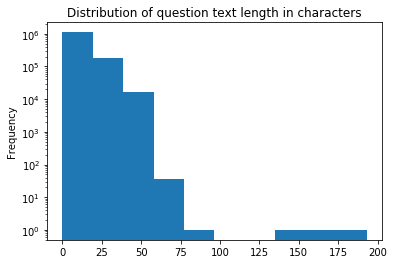

In [14]:
train['question_text'].apply(lambda x: len(x.split())).plot(kind='hist');
plt.yscale('log');
plt.title('Distribution of question text length in characters');

In [15]:
max_len = 72
maxlen = 72
X_train = pad_sequences(train_tokenized, maxlen = max_len)
X_test = pad_sequences(test_tokenized, maxlen = max_len)

In [16]:
y_train = train['target'].values

In [17]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

In [18]:
from sklearn.model_selection import StratifiedKFold
splits = list(StratifiedKFold(n_splits=4, shuffle=True, random_state=10).split(X_train, y_train))

In [19]:
# embed_size = 300
# embedding_path = "../input/quora-insincere-questions-classification/embeddings/glove.840B.300d/glove.840B.300d.txt"
# def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
# embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore'))
# all_embs = np.stack(embedding_index.values())
# emb_mean,emb_std = all_embs.mean(), all_embs.std()
# emb_mean,emb_std = -0.005838499, 0.48782197
# word_index = tk.word_index
# nb_words = min(max_features, len(word_index))
# embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
# for word, i in word_index.items():
#     if i >= max_features: continue
#     embedding_vector = embedding_index.get(word)
#     if embedding_vector is not None: embedding_matrix[i] = embedding_vector

In [20]:
embed_size = 300
embedding_path = "../input/quora-insincere-questions-classification/embeddings/wiki-news-300d-1M/wiki-news-300d-1M.vec"
def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')
embedding_index = dict(get_coefs(*o.split(" ")) for o in open(embedding_path, encoding='utf-8', errors='ignore') if len(o)>100)
all_embs = np.stack(embedding_index.values())
emb_mean,emb_std = all_embs.mean(), all_embs.std()
# emb_mean,emb_std = -0.0053247833, 0.49346462
word_index = tk.word_index
nb_words = min(max_features, len(word_index))
embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words + 1, embed_size))
for word, i in word_index.items():
    if i >= max_features: continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None: embedding_matrix[i] = embedding_vector

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


In [21]:
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        hidden_size = 128
        self.embedding = nn.Embedding(max_features, embed_size)# 120000, 300
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))#[120001, 300]
        self.embedding.weight.requires_grad = False
        self.embedding_dropout = nn.Dropout2d(0.1)
        self.lstm = nn.LSTM(embed_size, hidden_size, bidirectional=True, batch_first=True)
        self.lstm2 = nn.LSTM(256, hidden_size, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(512, 16)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(16, 1)
        
    def forward(self, x):
        h_embedding = self.embedding(x) #[512, 72, 300]
        h_embedding = torch.squeeze(self.embedding_dropout(torch.unsqueeze(h_embedding, 0)))#[512, 72, 300]
        h_lstm, _ = self.lstm(h_embedding)#[512, 72, 256]
        h_lstm2, _ = self.lstm2(h_lstm)
        avg_pool = torch.mean(h_lstm2, 1)#[512, 256]
        max_pool, _ = torch.max(h_lstm2, 1)#[512, 256]
        conc = torch.cat((avg_pool, max_pool), 1)#[512, 512]
        conc = self.relu(self.linear(conc))#[512, 16]
        conc = self.dropout(conc)#[512, 16]
        out = self.out(conc)#[512, 1]
        return out

In [22]:
def train_model(model, x_train, y_train, x_val, y_val, validate=True):
    optimizer = torch.optim.Adam(model.parameters())

    # scheduler = CosineAnnealingLR(optimizer, T_max=5)
    # scheduler = StepLR(optimizer, step_size=3, gamma=0.1)
    
    train = torch.utils.data.TensorDataset(x_train, y_train)
    valid = torch.utils.data.TensorDataset(x_val, y_val)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    loss_fn = torch.nn.BCEWithLogitsLoss(reduction='mean').cuda()
    
    for epoch in range(n_epochs):
        start_time = time.time()
        model.train()
        avg_loss = 0.
        
        for x_batch, y_batch in tqdm(train_loader, disable=True):
            y_pred = model(x_batch)
            
            
            loss = loss_fn(y_pred, y_batch)

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            avg_loss += loss.item() / len(train_loader)
            
        model.eval()
        
        valid_preds = np.zeros((x_val_fold.size(0)))
        
        if validate:
            avg_val_loss = 0.
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                y_pred = model(x_batch).detach()

                avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
                valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
            search_result = threshold_search(y_val.cpu().numpy(), valid_preds)

            val_f1, val_threshold = search_result['f1'], search_result['threshold']
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t val_loss={:.4f} \t val_f1={:.4f} best_t={:.2f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, val_f1, val_threshold, elapsed_time))
        else:
            elapsed_time = time.time() - start_time
            print('Epoch {}/{} \t loss={:.4f} \t time={:.2f}s'.format(
                epoch + 1, n_epochs, avg_loss, elapsed_time))
    
    valid_preds = np.zeros((x_val_fold.size(0)))
    
    avg_val_loss = 0.
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()

        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        valid_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]

    print('Validation loss: ', avg_val_loss)

    test_preds = np.zeros((len(test_loader.dataset)))
    
    for i, (x_batch,) in enumerate(test_loader):
        y_pred = model(x_batch).detach()

        test_preds[i * batch_size:(i+1) * batch_size] = sigmoid(y_pred.cpu().numpy())[:, 0]
    # scheduler.step()
    
    return valid_preds, test_preds#, test_preds_local

In [23]:
x_test_cuda = torch.tensor(X_test, dtype=torch.long).cuda()
test = torch.utils.data.TensorDataset(x_test_cuda)
batch_size = 512
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

In [24]:
seed=1029

def threshold_search(y_true, y_proba):
    best_threshold = 0
    best_score = 0
    for threshold in tqdm([i * 0.01 for i in range(100)], disable=True):
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result

def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [25]:
train_preds = np.zeros(len(train))
test_preds = np.zeros((len(test), len(splits)))
n_epochs = 7
from tqdm import tqdm
from sklearn.metrics import f1_score
for i, (train_idx, valid_idx) in enumerate(splits):    
    x_train_fold = torch.tensor(X_train[train_idx], dtype=torch.long).cuda()
    y_train_fold = torch.tensor(y_train[train_idx, np.newaxis], dtype=torch.float32).cuda()
    x_val_fold = torch.tensor(X_train[valid_idx], dtype=torch.long).cuda()
    y_val_fold = torch.tensor(y_train[valid_idx, np.newaxis], dtype=torch.float32).cuda()
    
    train = torch.utils.data.TensorDataset(x_train_fold, y_train_fold)
    valid = torch.utils.data.TensorDataset(x_val_fold, y_val_fold)
    
    train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
    valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)
    
    print(f'Fold {i + 1}')
    
    seed_everything(seed + i)
    model = NeuralNet()
    model.cuda()

    valid_preds_fold, test_preds_fold = train_model(model,x_train_fold,y_train_fold,x_val_fold,y_val_fold, validate=True)

    train_preds[valid_idx] = valid_preds_fold
    test_preds[:, i] = test_preds_fold
    


Fold 1
Epoch 1/7 	 loss=0.1628 	 val_loss=0.1232 	 val_f1=0.6107 best_t=0.25 	 time=113.42s
Epoch 2/7 	 loss=0.1308 	 val_loss=0.1107 	 val_f1=0.6485 best_t=0.30 	 time=110.62s
Epoch 3/7 	 loss=0.1241 	 val_loss=0.1151 	 val_f1=0.6571 best_t=0.17 	 time=113.16s
Epoch 4/7 	 loss=0.1200 	 val_loss=0.1080 	 val_f1=0.6684 best_t=0.25 	 time=109.94s
Epoch 5/7 	 loss=0.1162 	 val_loss=0.1043 	 val_f1=0.6707 best_t=0.31 	 time=110.13s
Epoch 6/7 	 loss=0.1127 	 val_loss=0.1046 	 val_f1=0.6752 best_t=0.25 	 time=112.46s
Epoch 7/7 	 loss=0.1092 	 val_loss=0.1072 	 val_f1=0.6709 best_t=0.24 	 time=109.16s
Validation loss:  0.10719401572705428
Fold 2
Epoch 1/7 	 loss=0.1484 	 val_loss=0.1222 	 val_f1=0.6302 best_t=0.18 	 time=111.56s
Epoch 2/7 	 loss=0.1278 	 val_loss=0.1107 	 val_f1=0.6584 best_t=0.27 	 time=109.36s
Epoch 3/7 	 loss=0.1227 	 val_loss=0.1048 	 val_f1=0.6694 best_t=0.27 	 time=109.62s
Epoch 4/7 	 loss=0.1189 	 val_loss=0.1028 	 val_f1=0.6748 best_t=0.28 	 time=109.90s
Epoch 5/7 	 l

In [26]:
search_result = threshold_search(y_train, train_preds)
sub['prediction'] = test_preds.mean(1) > search_result['threshold']
sub.to_csv("submission.csv", index=False)